In [1]:
#
# Looks at envelopes of surface elevation and their spectra
# this checks on the normalisations necessary to get the 
# spectra of envelope squared and envelope from the 2D wave spectrum
# following Rice (1941 - p 131)
# First created :      M. de Carlo    2022/04/23
#

### MATPLOTLIB & SCIPY LIRAIRIES ##############""
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.text as mtext
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.cm as cmx 
import numpy as np
import scipy.special as sps # function erf
import scipy.signal as spsi # function fftconvolve
import scipy.interpolate as spi
import scipy.integrate as spint
from scipy import stats

import time

## -- hide warnings
import warnings
warnings.filterwarnings("ignore")
## -- modify global param for figures
mpl.rcParams.update({'figure.figsize':[10,6],'axes.grid' : True,'font.size': 14,'savefig.facecolor':'white'})

import os
import pathlib
import sys

from wave_physics_functions import *
from surface_simulation_functions import *
twopi = 2*np.pi

In [2]:
def myconv2D(x, h):
    assert np.shape(x) == np.shape(h), 'Inputs to periodic convolution '\
                               'must be of the same period, i.e., shape.'

    X = np.fft.fft2(x)
    H = np.fft.fft2(h)

    return np.real(np.fft.ifft2(np.multiply(X, H)))

def generate_wvform_database(nHs,bandwidth=320*1e6,edges_max=200,Hs_max=25,offset=10):
    # edges=np.linspace(0,edges_max,ne)    # range vector
    clight = 299792458
    dr = clight * 1/(bandwidth)
#     print(dr)
    edges=np.arange(0,edges_max+dr,dr)   # range vector
    # dr=edges[1]-edges[0]   
    ne=len(edges)               
    Hsm=np.linspace(0,Hs_max,nHs)
    wfm=np.zeros((nHs,ne-1))
    for k in range(nHs):
        wfm[k,:]=0.5+0.5*sps.erf((edges[:-1]+0.5*dr-offset) / (0.25*np.sqrt(2)*Hsm[k]))

    return wfm, Hsm, edges,dr

def calc_footprint_diam(Hs,pulse_width = 1/(320*1e6),Rorbit=519*1e3,Rearth = 6370*1e3):
    clight= 299792458
    Airemax_div_pi = Rorbit*(clight*pulse_width + 2 * Hs)/(1+(Rorbit/Rearth))
    return 2*np.sqrt(Airemax_div_pi)  

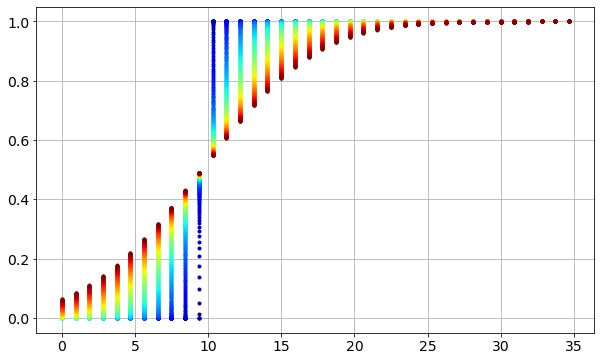

In [3]:
# --- waveform database -------------------
range_offset = 10
nHs= 251
wfm_ref, Hsm_ref, edges_ref,dr = generate_wvform_database(nHs,bandwidth=320*1e6,edges_max=35,Hs_max=25,offset=range_offset)
for ih, _ in enumerate(Hsm_ref):
    plt.plot(edges_ref[:-1],wfm_ref[ih,:],'.',color=plt.cm.jet(ih/len(Hsm_ref)))
plt.grid(True)

In [4]:
def simple_retracking_process(wfm,edges,max_edg=25,nHs=251,alti_sat=519000,dx=10,offset=10,wfm_ref=None,Hsm_ref=None,ispolyfit=0):
    dr = edges[1]-edges[0]
    Apix = np.pi*2*alti_sat*dr / (dx**2) # The area of a ring, in terms of pixels 
    
    testwf=np.broadcast_to(wfm,(nHs,len(wfm)))
    dist=np.sum((Apix*wfm_ref[:,0:max_edg]-testwf[:,0:max_edg])**2,axis=1)

    if ispolyfit:
        p = np.polyfit(Hsm_ref,dist,2)
        Hs = -p[1]/(2*p[0])
    else:
        Imin=np.argmin(dist)
        Hs = Hsm_ref[Imin]

    return Hs

In [5]:
# In this first example we define the wave spectrum direcly on the kx,ky grid 
# that is the Fourier transform of the x,y grid we want for the sea surface
mpl.rcParams.update({'axes.grid' : False})

nx= 2048*4
ny = nx-1

Hsths = np.array([2, 6, 12])
T0s = np.array([6,12,18])

Hsths2D,T0s2D = np.meshgrid(Hsths,T0s)

ind_test = 0#1 to 9
Hsth = 5
T0 = 16
th_deg = 135
kp = k_from_f(1/T0,D=None)
sk_k0 =0.1
sk_k = kp*sk_k0
dx=10
dy=dx
start_time = time.time()
Z2D,kX,kY,dkx,dky = def_spectrum_for_surface(nx=nx,ny=ny,dx=dx,dy=dy,theta_m=th_deg,D=None,T0=T0,Hs=Hsth,
                                             sk_theta=sk_k,sk_k=0.5*sk_k,verbose=True)
# print(4*np.sqrt(np.sum(Z2D*dkx*dky)))
time0 = time.time()
S2_r,S2_i,X,Y,kX2,kY2,rg,dkx2,dky2 = surface_2D_from_Z1kxky(Z2D,kX,kY,0,nx=None,dx=None,dkx=None)
time1 = time.time()
# print('time for def spec = ',time0 - start_time,'; time for simu surface = ',time1-time0)
env2 = (S2_r**2+S2_i**2)
env_minusmean = np.sqrt(env2)-np.mean(np.sqrt(env2).flatten())
env = np.sqrt(env2)

Gaussian spectrum selected. Available options:
 - Hs, sk_theta, sk_k. 
With (sk_k, sk_theta) the sigma values for the k-axis along the main direction and perpendicular to it respectively 
 Other options (common to all spectrum types) are : nx, ny, dx, dy, T0, theta_m, D
Hs for Gaussian :  4.999999999999945
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05


In [7]:
def function_flight_over_surfaces_Z2D(Z2D,kX,kY,Hsth,nx,ny,dx,edges_ref,Lxas,nseed,freq_acqui = 5):
    vit_sat = 7*1e3 # m/s
#     freq_acqui = 20 # Hz
    dist_acquisition = np.arange(0,dx*nx,vit_sat/freq_acqui) # distance
    dist_acPix0 = (dist_acquisition/dx).astype(int)
    alti_sat = 519 * 1e3 # km
    radiTh = calc_footprint_diam(Hsth) # diameter

    ny_mid = int(nx//2) # position of the flight

    nxa = np.floor(radiTh/dx).astype(int) # size of radius in Pixels
    

    dist_acPix = dist_acPix0[(dist_acPix0>nxa)&(dist_acPix0<(dist_acPix0[-1]-nxa))]
    Hs_std = np.zeros((len(dist_acPix),len(Lxas)))
    mean_env = np.zeros((len(dist_acPix),len(Lxas)))
    # Hs_retrack = np.zeros((len(dist_acPix),1))
    waveforms=np.zeros((len(dist_acPix),len(edges_ref)-1))

    [Xa,Ya]=np.meshgrid(dx*np.arange(-nxa,nxa+1), dy*np.arange(-nxa,nxa+1))
    
    std_Hs_surf = np.zeros((nseed,len(Lxas)))
    std_mean_env = np.zeros((nseed,len(Lxas)))
    mean_Hs_surf = np.zeros((nseed,len(Lxas)))
    mean_mean_env = np.zeros((nseed,len(Lxas)))
    Hs_retrack = np.zeros((nseed,len(dist_acPix)))
    for iseed in range(nseed):
        S2_r,S2_i,X,Y,kX2,kY2,rg,dkx2,dky2 = surface_2D_from_Z1kxky(Z2D,kX,kY,iseed,nx=None,dx=None,dkx=None)
        env2 = (S2_r**2+S2_i**2)
        env_minusmean = np.sqrt(env2)-np.mean(np.sqrt(env2).flatten())
        env = np.sqrt(env2)
        for ipix, pix in enumerate(dist_acPix):
            print('iseed = ',iseed,' over ',nseed,'ipix = ',ipix,' over ',len(dist_acPix))
            surf=S2_r[ny_mid-nxa:ny_mid+nxa+1,pix-nxa:pix+nxa+1]
            env_surf = env[ny_mid-nxa:ny_mid+nxa+1,pix-nxa:pix+nxa+1]
            # to have distance to satellite = range
            r=np.sqrt(Xa**2+Ya**2+(alti_sat-surf)**2)-alti_sat+range_offset
            counts,_=np.histogram(r,bins=edges_ref)
            waveforms[ipix,:]=counts

            for inx,Lxa in enumerate(Lxas):
    #             footprint_mask = 
                surf2 = S2_r[ny_mid-(Lxa):ny_mid+(Lxa)+1,pix-(Lxa):pix+(Lxa)+1]
                env_surf2 = env[ny_mid-(Lxa):ny_mid+(Lxa)+1,pix-(Lxa):pix+(Lxa)+1]
                Hs_std[ipix,inx] = 4*np.std(surf2.flatten())
                mean_env[ipix,inx] = np.mean(env_surf2.flatten())
            Hs_retrack[iseed,ipix] = simple_retracking_process(counts,edges_ref,max_edg=15,nHs=nHs,wfm_ref=wfm_ref,Hsm_ref=Hsm_ref)

        std_Hs_surf[iseed,:] = np.std(Hs_std,axis=0)
        std_mean_env[iseed,:] = np.std(1.05*np.sqrt(8)*mean_env,axis=0)
        mean_Hs_surf[iseed,:] = np.mean(Hs_std**2,axis=0)
        mean_mean_env[iseed,:] = np.mean(1.05*np.sqrt(8)*mean_env,axis=0)
    
    return np.std(Hs_retrack,axis=1),std_Hs_surf,std_mean_env,mean_Hs_surf,mean_mean_env

In [11]:
vit_sat = 7*1e3
print(vit_sat/5)
print(vit_sat/1)
print(vit_sat/10)


1400.0
7000.0
700.0


In [13]:
mpl.rcParams.update({'axes.grid' : False})
iscompute = 0
iscomputeEnv = 0
nx= 2048*4
ny = nx-1

Hsths = np.array([2, 6, 12])
T0s = np.array([6,12,18])

Hsths2D0,T0s2D0 = np.meshgrid(Hsths,T0s)
Hsths2D = Hsths2D0.flatten()
T0s2D = T0s2D0.flatten()
nseed = 200
Lxas = np.arange(1,450,12)

freqs = np.array([1,3,5,10])

filename = 'hs_std_tests_freq_ech'
if iscompute:
    std_Hs_surf1 = np.zeros((len(T0s2D),nseed,len(Lxas)))
    std_mean_env1 = np.zeros((len(T0s2D),nseed,len(Lxas)))
    mean_Hs_surf1 = np.zeros((len(T0s2D),nseed,len(Lxas)))
    mean_mean_env1 = np.zeros((len(T0s2D),nseed,len(Lxas)))
    Hs_retrack1 = np.zeros((len(T0s2D),nseed))

    for ind_test in range(4):#9):
        Hsth = Hsths2D[3]#ind_test]
        T0 = T0s2D[3]#ind_test]
        th_deg = 135
        kp = k_from_f(1/T0,D=None)
        sk_k0 =0.1
        sk_k = kp*sk_k0
        dx=10
        dy=dx
        start_time = time.time()
        Z2D,kX,kY,dkx,dky = def_spectrum_for_surface(nx=nx,ny=ny,dx=dx,dy=dy,theta_m=th_deg,D=None,T0=T0,Hs=Hsth,
                                                     sk_theta=sk_k,sk_k=0.5*sk_k,verbose=False)
        Hs_retrack1[ind_test,:],std_Hs_surf1[ind_test,:,:],std_mean_env1[ind_test,:,:],mean_Hs_surf1[ind_test,:,:],mean_mean_env1[ind_test,:,:] = function_flight_over_surfaces_Z2D(Z2D,kX,kY,Hsth,nx,ny,dx,edges_ref,Lxas,nseed,freq_acqui=freqs[ind_test])


    np.savez(filename,Hs_retrack=Hs_retrack1,std_Hs_surf=std_Hs_surf1,std_mean_env= std_mean_env1,mean_Hs_surf=mean_Hs_surf1,mean_mean_env=mean_mean_env1)

else:
    with np.load(filename+'.npz',allow_pickle=True) as data:
        for keys in data.keys():
            print(keys+' = data["'+keys+'"]')
            exec(keys+' = data["'+keys+'"]')

if iscomputeEnv:
    Lxas0 = np.arange(1,450,5)
    Lxs = 2*Lxas0*dx
    ntypes = 2
    int_over_kxky0=np.zeros((ntypes,9,len(Lxs)))
    int_over_kxky0[0,:,:]=int_over_kxky
    for ind_test in range(9):
        Hsth = Hsths2D[ind_test]
        T0 = T0s2D[ind_test]
        th_deg = 135
        kp = k_from_f(1/T0,D=None)
        sk_k0 =0.1
        sk_k = kp*sk_k0
        dx=10
        dy=dx
        start_time = time.time()
        Z2D,kX,kY,dkx,dky = def_spectrum_for_surface(nx=nx,ny=ny,dx=dx,dy=dy,theta_m=th_deg,D=None,T0=T0,Hs=Hsth,
                                                     sk_theta=sk_k,sk_k=0.5*sk_k,verbose=False)
        
        B2_2D = 0.5*8*2*np.fft.fftshift(myconv2D(0.5*Z2D,0.5*np.flip(Z2D)))*dkx*dky
        func_x= spi.interp1d(np.unique(kX),B2_2D)

#         Lxs = 2*Lxas*dx
        for il, Lx in enumerate(Lxs):
            kmin = twopi/(nx*dx)
            klimy = twopi/(Lx)
            klimx = twopi/(Lx)
#             for ity in range(ntypes):
#                 # --- change the values of klimx and klimy ---
            print(ind_test,' over 9 , ',il,' over  ',len(Lxs)-1)
#                 if ity == 0:
#                     klimx = twopi/(Lx)
#                 elif ity==1:
#                     klimx = twopi/(2*Lx)
#                 elif ity==2:
#                     klimx = twopi/(2*1400)
#                 elif ity==3:
#                     klimx = twopi/(2*Lx-1400)
#             #         klim = twopi/(2*Lx-1400)
#                 else:
#                     klim2=klim/2
            int_over_kx = spint.quad_vec(func_x,kmin,klimx)[0]+spint.quad_vec(func_x,-klimx,-kmin)[0]

            func_y = spi.interp1d(kY2,int_over_kx)
            int_over_kxky0[1,ind_test,il] = spint.quad_vec(func_y,-klimy,-kmin)[0] + spint.quad_vec(func_y,kmin,klimy)[0]
    np.save('std_from_env',int_over_kxky0)
else:
    int_over_kxky=np.load('std_from_env.npy')

from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  0  over  200 ipix =  0  over  10
iseed =  0  over  200 ipix =  1  over  10
iseed =  0  over  200 ipix =  2  over  10
iseed =  0  over  200 ipix =  3  over  10
iseed =  0  over  200 ipix =  4  over  10
iseed =  0  over  200 ipix =  5  over  10
iseed =  0  over  200 ipix =  6  over  10
iseed =  0  over  200 ipix =  7  over  10
iseed =  0  over  200 ipix =  8  over  10
iseed =  0  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  1  over  200 ipix =  0  over  10
iseed =  1  over  200 ipix =  1  over  10
iseed =  1  ov

iseed =  12  over  200 ipix =  0  over  10
iseed =  12  over  200 ipix =  1  over  10
iseed =  12  over  200 ipix =  2  over  10
iseed =  12  over  200 ipix =  3  over  10
iseed =  12  over  200 ipix =  4  over  10
iseed =  12  over  200 ipix =  5  over  10
iseed =  12  over  200 ipix =  6  over  10
iseed =  12  over  200 ipix =  7  over  10
iseed =  12  over  200 ipix =  8  over  10
iseed =  12  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  13  over  200 ipix =  0  over  10
iseed =  13  over  200 ipix =  1  over  10
iseed =  13  over  200 ipix =  2  over  10
iseed =  13  over  200 ipix =  3  over  10
iseed =  13  over  200 ipix =  4  over  10
iseed =  13  over  200 ipix =  5  over  10
iseed =  13  over  200 ipix =  6  over  10
iseed =  13  over  200 ipix 

iseed =  24  over  200 ipix =  4  over  10
iseed =  24  over  200 ipix =  5  over  10
iseed =  24  over  200 ipix =  6  over  10
iseed =  24  over  200 ipix =  7  over  10
iseed =  24  over  200 ipix =  8  over  10
iseed =  24  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  25  over  200 ipix =  0  over  10
iseed =  25  over  200 ipix =  1  over  10
iseed =  25  over  200 ipix =  2  over  10
iseed =  25  over  200 ipix =  3  over  10
iseed =  25  over  200 ipix =  4  over  10
iseed =  25  over  200 ipix =  5  over  10
iseed =  25  over  200 ipix =  6  over  10
iseed =  25  over  200 ipix =  7  over  10
iseed =  25  over  200 ipix =  8  over  10
iseed =  25  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.67084

iseed =  36  over  200 ipix =  8  over  10
iseed =  36  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  37  over  200 ipix =  0  over  10
iseed =  37  over  200 ipix =  1  over  10
iseed =  37  over  200 ipix =  2  over  10
iseed =  37  over  200 ipix =  3  over  10
iseed =  37  over  200 ipix =  4  over  10
iseed =  37  over  200 ipix =  5  over  10
iseed =  37  over  200 ipix =  6  over  10
iseed =  37  over  200 ipix =  7  over  10
iseed =  37  over  200 ipix =  8  over  10
iseed =  37  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
is

iseed =  49  over  200 ipix =  0  over  10
iseed =  49  over  200 ipix =  1  over  10
iseed =  49  over  200 ipix =  2  over  10
iseed =  49  over  200 ipix =  3  over  10
iseed =  49  over  200 ipix =  4  over  10
iseed =  49  over  200 ipix =  5  over  10
iseed =  49  over  200 ipix =  6  over  10
iseed =  49  over  200 ipix =  7  over  10
iseed =  49  over  200 ipix =  8  over  10
iseed =  49  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  50  over  200 ipix =  0  over  10
iseed =  50  over  200 ipix =  1  over  10
iseed =  50  over  200 ipix =  2  over  10
iseed =  50  over  200 ipix =  3  over  10
iseed =  50  over  200 ipix =  4  over  10
iseed =  50  over  200 ipix =  5  over  10
iseed =  50  over  200 ipix =  6  over  10
iseed =  50  over  200 ipix 

iseed =  61  over  200 ipix =  6  over  10
iseed =  61  over  200 ipix =  7  over  10
iseed =  61  over  200 ipix =  8  over  10
iseed =  61  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  62  over  200 ipix =  0  over  10
iseed =  62  over  200 ipix =  1  over  10
iseed =  62  over  200 ipix =  2  over  10
iseed =  62  over  200 ipix =  3  over  10
iseed =  62  over  200 ipix =  4  over  10
iseed =  62  over  200 ipix =  5  over  10
iseed =  62  over  200 ipix =  6  over  10
iseed =  62  over  200 ipix =  7  over  10
iseed =  62  over  200 ipix =  8  over  10
iseed =  62  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx

from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  74  over  200 ipix =  0  over  10
iseed =  74  over  200 ipix =  1  over  10
iseed =  74  over  200 ipix =  2  over  10
iseed =  74  over  200 ipix =  3  over  10
iseed =  74  over  200 ipix =  4  over  10
iseed =  74  over  200 ipix =  5  over  10
iseed =  74  over  200 ipix =  6  over  10
iseed =  74  over  200 ipix =  7  over  10
iseed =  74  over  200 ipix =  8  over  10
iseed =  74  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  75  over  200 ipix =  0  over  10
iseed =  75  over  200 ipix =  1  over  10
is

iseed =  86  over  200 ipix =  0  over  10
iseed =  86  over  200 ipix =  1  over  10
iseed =  86  over  200 ipix =  2  over  10
iseed =  86  over  200 ipix =  3  over  10
iseed =  86  over  200 ipix =  4  over  10
iseed =  86  over  200 ipix =  5  over  10
iseed =  86  over  200 ipix =  6  over  10
iseed =  86  over  200 ipix =  7  over  10
iseed =  86  over  200 ipix =  8  over  10
iseed =  86  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  87  over  200 ipix =  0  over  10
iseed =  87  over  200 ipix =  1  over  10
iseed =  87  over  200 ipix =  2  over  10
iseed =  87  over  200 ipix =  3  over  10
iseed =  87  over  200 ipix =  4  over  10
iseed =  87  over  200 ipix =  5  over  10
iseed =  87  over  200 ipix =  6  over  10
iseed =  87  over  200 ipix 

iseed =  98  over  200 ipix =  5  over  10
iseed =  98  over  200 ipix =  6  over  10
iseed =  98  over  200 ipix =  7  over  10
iseed =  98  over  200 ipix =  8  over  10
iseed =  98  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  99  over  200 ipix =  0  over  10
iseed =  99  over  200 ipix =  1  over  10
iseed =  99  over  200 ipix =  2  over  10
iseed =  99  over  200 ipix =  3  over  10
iseed =  99  over  200 ipix =  4  over  10
iseed =  99  over  200 ipix =  5  over  10
iseed =  99  over  200 ipix =  6  over  10
iseed =  99  over  200 ipix =  7  over  10
iseed =  99  over  200 ipix =  8  over  10
iseed =  99  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.00000

iseed =  110  over  200 ipix =  6  over  10
iseed =  110  over  200 ipix =  7  over  10
iseed =  110  over  200 ipix =  8  over  10
iseed =  110  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  111  over  200 ipix =  0  over  10
iseed =  111  over  200 ipix =  1  over  10
iseed =  111  over  200 ipix =  2  over  10
iseed =  111  over  200 ipix =  3  over  10
iseed =  111  over  200 ipix =  4  over  10
iseed =  111  over  200 ipix =  5  over  10
iseed =  111  over  200 ipix =  6  over  10
iseed =  111  over  200 ipix =  7  over  10
iseed =  111  over  200 ipix =  8  over  10
iseed =  111  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.9999999

iseed =  122  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  123  over  200 ipix =  0  over  10
iseed =  123  over  200 ipix =  1  over  10
iseed =  123  over  200 ipix =  2  over  10
iseed =  123  over  200 ipix =  3  over  10
iseed =  123  over  200 ipix =  4  over  10
iseed =  123  over  200 ipix =  5  over  10
iseed =  123  over  200 ipix =  6  over  10
iseed =  123  over  200 ipix =  7  over  10
iseed =  123  over  200 ipix =  8  over  10
iseed =  123  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  124  over  200 ipix =  0 

from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  135  over  200 ipix =  0  over  10
iseed =  135  over  200 ipix =  1  over  10
iseed =  135  over  200 ipix =  2  over  10
iseed =  135  over  200 ipix =  3  over  10
iseed =  135  over  200 ipix =  4  over  10
iseed =  135  over  200 ipix =  5  over  10
iseed =  135  over  200 ipix =  6  over  10
iseed =  135  over  200 ipix =  7  over  10
iseed =  135  over  200 ipix =  8  over  10
iseed =  135  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  136  over  200 ipix =  0  over  10
iseed =  136  over  200 ipix =  1 

iseed =  147  over  200 ipix =  0  over  10
iseed =  147  over  200 ipix =  1  over  10
iseed =  147  over  200 ipix =  2  over  10
iseed =  147  over  200 ipix =  3  over  10
iseed =  147  over  200 ipix =  4  over  10
iseed =  147  over  200 ipix =  5  over  10
iseed =  147  over  200 ipix =  6  over  10
iseed =  147  over  200 ipix =  7  over  10
iseed =  147  over  200 ipix =  8  over  10
iseed =  147  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  148  over  200 ipix =  0  over  10
iseed =  148  over  200 ipix =  1  over  10
iseed =  148  over  200 ipix =  2  over  10
iseed =  148  over  200 ipix =  3  over  10
iseed =  148  over  200 ipix =  4  over  10
iseed =  148  over  200 ipix =  5  over  10
iseed =  148  over  200 ipix =  6  over  10
iseed =  14

iseed =  159  over  200 ipix =  3  over  10
iseed =  159  over  200 ipix =  4  over  10
iseed =  159  over  200 ipix =  5  over  10
iseed =  159  over  200 ipix =  6  over  10
iseed =  159  over  200 ipix =  7  over  10
iseed =  159  over  200 ipix =  8  over  10
iseed =  159  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  160  over  200 ipix =  0  over  10
iseed =  160  over  200 ipix =  1  over  10
iseed =  160  over  200 ipix =  2  over  10
iseed =  160  over  200 ipix =  3  over  10
iseed =  160  over  200 ipix =  4  over  10
iseed =  160  over  200 ipix =  5  over  10
iseed =  160  over  200 ipix =  6  over  10
iseed =  160  over  200 ipix =  7  over  10
iseed =  160  over  200 ipix =  8  over  10
iseed =  160  over  200 ipix =  9  over  10
from vec kX

iseed =  171  over  200 ipix =  6  over  10
iseed =  171  over  200 ipix =  7  over  10
iseed =  171  over  200 ipix =  8  over  10
iseed =  171  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  172  over  200 ipix =  0  over  10
iseed =  172  over  200 ipix =  1  over  10
iseed =  172  over  200 ipix =  2  over  10
iseed =  172  over  200 ipix =  3  over  10
iseed =  172  over  200 ipix =  4  over  10
iseed =  172  over  200 ipix =  5  over  10
iseed =  172  over  200 ipix =  6  over  10
iseed =  172  over  200 ipix =  7  over  10
iseed =  172  over  200 ipix =  8  over  10
iseed =  172  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.9999999

iseed =  183  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  184  over  200 ipix =  0  over  10
iseed =  184  over  200 ipix =  1  over  10
iseed =  184  over  200 ipix =  2  over  10
iseed =  184  over  200 ipix =  3  over  10
iseed =  184  over  200 ipix =  4  over  10
iseed =  184  over  200 ipix =  5  over  10
iseed =  184  over  200 ipix =  6  over  10
iseed =  184  over  200 ipix =  7  over  10
iseed =  184  over  200 ipix =  8  over  10
iseed =  184  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  185  over  200 ipix =  0 

from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  196  over  200 ipix =  0  over  10
iseed =  196  over  200 ipix =  1  over  10
iseed =  196  over  200 ipix =  2  over  10
iseed =  196  over  200 ipix =  3  over  10
iseed =  196  over  200 ipix =  4  over  10
iseed =  196  over  200 ipix =  5  over  10
iseed =  196  over  200 ipix =  6  over  10
iseed =  196  over  200 ipix =  7  over  10
iseed =  196  over  200 ipix =  8  over  10
iseed =  196  over  200 ipix =  9  over  10
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  197  over  200 ipix =  0  over  10
iseed =  197  over  200 ipix =  1 

iseed =  3  over  200 ipix =  12  over  32
iseed =  3  over  200 ipix =  13  over  32
iseed =  3  over  200 ipix =  14  over  32
iseed =  3  over  200 ipix =  15  over  32
iseed =  3  over  200 ipix =  16  over  32
iseed =  3  over  200 ipix =  17  over  32
iseed =  3  over  200 ipix =  18  over  32
iseed =  3  over  200 ipix =  19  over  32
iseed =  3  over  200 ipix =  20  over  32
iseed =  3  over  200 ipix =  21  over  32
iseed =  3  over  200 ipix =  22  over  32
iseed =  3  over  200 ipix =  23  over  32
iseed =  3  over  200 ipix =  24  over  32
iseed =  3  over  200 ipix =  25  over  32
iseed =  3  over  200 ipix =  26  over  32
iseed =  3  over  200 ipix =  27  over  32
iseed =  3  over  200 ipix =  28  over  32
iseed =  3  over  200 ipix =  29  over  32
iseed =  3  over  200 ipix =  30  over  32
iseed =  3  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.9999

iseed =  8  over  200 ipix =  18  over  32
iseed =  8  over  200 ipix =  19  over  32
iseed =  8  over  200 ipix =  20  over  32
iseed =  8  over  200 ipix =  21  over  32
iseed =  8  over  200 ipix =  22  over  32
iseed =  8  over  200 ipix =  23  over  32
iseed =  8  over  200 ipix =  24  over  32
iseed =  8  over  200 ipix =  25  over  32
iseed =  8  over  200 ipix =  26  over  32
iseed =  8  over  200 ipix =  27  over  32
iseed =  8  over  200 ipix =  28  over  32
iseed =  8  over  200 ipix =  29  over  32
iseed =  8  over  200 ipix =  30  over  32
iseed =  8  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  9  over  200 ipix =  0  over  32
iseed =  9  over  200 ipix =  1  over  32
iseed =  9  over  200 ipix =  2  over  32
iseed =  9  over  200 ipix =  3

iseed =  13  over  200 ipix =  21  over  32
iseed =  13  over  200 ipix =  22  over  32
iseed =  13  over  200 ipix =  23  over  32
iseed =  13  over  200 ipix =  24  over  32
iseed =  13  over  200 ipix =  25  over  32
iseed =  13  over  200 ipix =  26  over  32
iseed =  13  over  200 ipix =  27  over  32
iseed =  13  over  200 ipix =  28  over  32
iseed =  13  over  200 ipix =  29  over  32
iseed =  13  over  200 ipix =  30  over  32
iseed =  13  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  14  over  200 ipix =  0  over  32
iseed =  14  over  200 ipix =  1  over  32
iseed =  14  over  200 ipix =  2  over  32
iseed =  14  over  200 ipix =  3  over  32
iseed =  14  over  200 ipix =  4  over  32
iseed =  14  over  200 ipix =  5  over  32
iseed =  14  over

iseed =  18  over  200 ipix =  21  over  32
iseed =  18  over  200 ipix =  22  over  32
iseed =  18  over  200 ipix =  23  over  32
iseed =  18  over  200 ipix =  24  over  32
iseed =  18  over  200 ipix =  25  over  32
iseed =  18  over  200 ipix =  26  over  32
iseed =  18  over  200 ipix =  27  over  32
iseed =  18  over  200 ipix =  28  over  32
iseed =  18  over  200 ipix =  29  over  32
iseed =  18  over  200 ipix =  30  over  32
iseed =  18  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  19  over  200 ipix =  0  over  32
iseed =  19  over  200 ipix =  1  over  32
iseed =  19  over  200 ipix =  2  over  32
iseed =  19  over  200 ipix =  3  over  32
iseed =  19  over  200 ipix =  4  over  32
iseed =  19  over  200 ipix =  5  over  32
iseed =  19  over

iseed =  23  over  200 ipix =  21  over  32
iseed =  23  over  200 ipix =  22  over  32
iseed =  23  over  200 ipix =  23  over  32
iseed =  23  over  200 ipix =  24  over  32
iseed =  23  over  200 ipix =  25  over  32
iseed =  23  over  200 ipix =  26  over  32
iseed =  23  over  200 ipix =  27  over  32
iseed =  23  over  200 ipix =  28  over  32
iseed =  23  over  200 ipix =  29  over  32
iseed =  23  over  200 ipix =  30  over  32
iseed =  23  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  24  over  200 ipix =  0  over  32
iseed =  24  over  200 ipix =  1  over  32
iseed =  24  over  200 ipix =  2  over  32
iseed =  24  over  200 ipix =  3  over  32
iseed =  24  over  200 ipix =  4  over  32
iseed =  24  over  200 ipix =  5  over  32
iseed =  24  over

iseed =  28  over  200 ipix =  21  over  32
iseed =  28  over  200 ipix =  22  over  32
iseed =  28  over  200 ipix =  23  over  32
iseed =  28  over  200 ipix =  24  over  32
iseed =  28  over  200 ipix =  25  over  32
iseed =  28  over  200 ipix =  26  over  32
iseed =  28  over  200 ipix =  27  over  32
iseed =  28  over  200 ipix =  28  over  32
iseed =  28  over  200 ipix =  29  over  32
iseed =  28  over  200 ipix =  30  over  32
iseed =  28  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  29  over  200 ipix =  0  over  32
iseed =  29  over  200 ipix =  1  over  32
iseed =  29  over  200 ipix =  2  over  32
iseed =  29  over  200 ipix =  3  over  32
iseed =  29  over  200 ipix =  4  over  32
iseed =  29  over  200 ipix =  5  over  32
iseed =  29  over

iseed =  33  over  200 ipix =  23  over  32
iseed =  33  over  200 ipix =  24  over  32
iseed =  33  over  200 ipix =  25  over  32
iseed =  33  over  200 ipix =  26  over  32
iseed =  33  over  200 ipix =  27  over  32
iseed =  33  over  200 ipix =  28  over  32
iseed =  33  over  200 ipix =  29  over  32
iseed =  33  over  200 ipix =  30  over  32
iseed =  33  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  34  over  200 ipix =  0  over  32
iseed =  34  over  200 ipix =  1  over  32
iseed =  34  over  200 ipix =  2  over  32
iseed =  34  over  200 ipix =  3  over  32
iseed =  34  over  200 ipix =  4  over  32
iseed =  34  over  200 ipix =  5  over  32
iseed =  34  over  200 ipix =  6  over  32
iseed =  34  over  200 ipix =  7  over  32
iseed =  34  over  

iseed =  38  over  200 ipix =  24  over  32
iseed =  38  over  200 ipix =  25  over  32
iseed =  38  over  200 ipix =  26  over  32
iseed =  38  over  200 ipix =  27  over  32
iseed =  38  over  200 ipix =  28  over  32
iseed =  38  over  200 ipix =  29  over  32
iseed =  38  over  200 ipix =  30  over  32
iseed =  38  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  39  over  200 ipix =  0  over  32
iseed =  39  over  200 ipix =  1  over  32
iseed =  39  over  200 ipix =  2  over  32
iseed =  39  over  200 ipix =  3  over  32
iseed =  39  over  200 ipix =  4  over  32
iseed =  39  over  200 ipix =  5  over  32
iseed =  39  over  200 ipix =  6  over  32
iseed =  39  over  200 ipix =  7  over  32
iseed =  39  over  200 ipix =  8  over  32
iseed =  39  over  2

iseed =  43  over  200 ipix =  24  over  32
iseed =  43  over  200 ipix =  25  over  32
iseed =  43  over  200 ipix =  26  over  32
iseed =  43  over  200 ipix =  27  over  32
iseed =  43  over  200 ipix =  28  over  32
iseed =  43  over  200 ipix =  29  over  32
iseed =  43  over  200 ipix =  30  over  32
iseed =  43  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  44  over  200 ipix =  0  over  32
iseed =  44  over  200 ipix =  1  over  32
iseed =  44  over  200 ipix =  2  over  32
iseed =  44  over  200 ipix =  3  over  32
iseed =  44  over  200 ipix =  4  over  32
iseed =  44  over  200 ipix =  5  over  32
iseed =  44  over  200 ipix =  6  over  32
iseed =  44  over  200 ipix =  7  over  32
iseed =  44  over  200 ipix =  8  over  32
iseed =  44  over  2

iseed =  48  over  200 ipix =  24  over  32
iseed =  48  over  200 ipix =  25  over  32
iseed =  48  over  200 ipix =  26  over  32
iseed =  48  over  200 ipix =  27  over  32
iseed =  48  over  200 ipix =  28  over  32
iseed =  48  over  200 ipix =  29  over  32
iseed =  48  over  200 ipix =  30  over  32
iseed =  48  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  49  over  200 ipix =  0  over  32
iseed =  49  over  200 ipix =  1  over  32
iseed =  49  over  200 ipix =  2  over  32
iseed =  49  over  200 ipix =  3  over  32
iseed =  49  over  200 ipix =  4  over  32
iseed =  49  over  200 ipix =  5  over  32
iseed =  49  over  200 ipix =  6  over  32
iseed =  49  over  200 ipix =  7  over  32
iseed =  49  over  200 ipix =  8  over  32
iseed =  49  over  2

iseed =  53  over  200 ipix =  24  over  32
iseed =  53  over  200 ipix =  25  over  32
iseed =  53  over  200 ipix =  26  over  32
iseed =  53  over  200 ipix =  27  over  32
iseed =  53  over  200 ipix =  28  over  32
iseed =  53  over  200 ipix =  29  over  32
iseed =  53  over  200 ipix =  30  over  32
iseed =  53  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  54  over  200 ipix =  0  over  32
iseed =  54  over  200 ipix =  1  over  32
iseed =  54  over  200 ipix =  2  over  32
iseed =  54  over  200 ipix =  3  over  32
iseed =  54  over  200 ipix =  4  over  32
iseed =  54  over  200 ipix =  5  over  32
iseed =  54  over  200 ipix =  6  over  32
iseed =  54  over  200 ipix =  7  over  32
iseed =  54  over  200 ipix =  8  over  32
iseed =  54  over  2

iseed =  58  over  200 ipix =  26  over  32
iseed =  58  over  200 ipix =  27  over  32
iseed =  58  over  200 ipix =  28  over  32
iseed =  58  over  200 ipix =  29  over  32
iseed =  58  over  200 ipix =  30  over  32
iseed =  58  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  59  over  200 ipix =  0  over  32
iseed =  59  over  200 ipix =  1  over  32
iseed =  59  over  200 ipix =  2  over  32
iseed =  59  over  200 ipix =  3  over  32
iseed =  59  over  200 ipix =  4  over  32
iseed =  59  over  200 ipix =  5  over  32
iseed =  59  over  200 ipix =  6  over  32
iseed =  59  over  200 ipix =  7  over  32
iseed =  59  over  200 ipix =  8  over  32
iseed =  59  over  200 ipix =  9  over  32
iseed =  59  over  200 ipix =  10  over  32
iseed =  59  over  20

iseed =  63  over  200 ipix =  27  over  32
iseed =  63  over  200 ipix =  28  over  32
iseed =  63  over  200 ipix =  29  over  32
iseed =  63  over  200 ipix =  30  over  32
iseed =  63  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  64  over  200 ipix =  0  over  32
iseed =  64  over  200 ipix =  1  over  32
iseed =  64  over  200 ipix =  2  over  32
iseed =  64  over  200 ipix =  3  over  32
iseed =  64  over  200 ipix =  4  over  32
iseed =  64  over  200 ipix =  5  over  32
iseed =  64  over  200 ipix =  6  over  32
iseed =  64  over  200 ipix =  7  over  32
iseed =  64  over  200 ipix =  8  over  32
iseed =  64  over  200 ipix =  9  over  32
iseed =  64  over  200 ipix =  10  over  32
iseed =  64  over  200 ipix =  11  over  32
iseed =  64  over  20

iseed =  68  over  200 ipix =  29  over  32
iseed =  68  over  200 ipix =  30  over  32
iseed =  68  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  69  over  200 ipix =  0  over  32
iseed =  69  over  200 ipix =  1  over  32
iseed =  69  over  200 ipix =  2  over  32
iseed =  69  over  200 ipix =  3  over  32
iseed =  69  over  200 ipix =  4  over  32
iseed =  69  over  200 ipix =  5  over  32
iseed =  69  over  200 ipix =  6  over  32
iseed =  69  over  200 ipix =  7  over  32
iseed =  69  over  200 ipix =  8  over  32
iseed =  69  over  200 ipix =  9  over  32
iseed =  69  over  200 ipix =  10  over  32
iseed =  69  over  200 ipix =  11  over  32
iseed =  69  over  200 ipix =  12  over  32
iseed =  69  over  200 ipix =  13  over  32
iseed =  69  over  20

iseed =  73  over  200 ipix =  29  over  32
iseed =  73  over  200 ipix =  30  over  32
iseed =  73  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  74  over  200 ipix =  0  over  32
iseed =  74  over  200 ipix =  1  over  32
iseed =  74  over  200 ipix =  2  over  32
iseed =  74  over  200 ipix =  3  over  32
iseed =  74  over  200 ipix =  4  over  32
iseed =  74  over  200 ipix =  5  over  32
iseed =  74  over  200 ipix =  6  over  32
iseed =  74  over  200 ipix =  7  over  32
iseed =  74  over  200 ipix =  8  over  32
iseed =  74  over  200 ipix =  9  over  32
iseed =  74  over  200 ipix =  10  over  32
iseed =  74  over  200 ipix =  11  over  32
iseed =  74  over  200 ipix =  12  over  32
iseed =  74  over  200 ipix =  13  over  32
iseed =  74  over  20

iseed =  78  over  200 ipix =  30  over  32
iseed =  78  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  79  over  200 ipix =  0  over  32
iseed =  79  over  200 ipix =  1  over  32
iseed =  79  over  200 ipix =  2  over  32
iseed =  79  over  200 ipix =  3  over  32
iseed =  79  over  200 ipix =  4  over  32
iseed =  79  over  200 ipix =  5  over  32
iseed =  79  over  200 ipix =  6  over  32
iseed =  79  over  200 ipix =  7  over  32
iseed =  79  over  200 ipix =  8  over  32
iseed =  79  over  200 ipix =  9  over  32
iseed =  79  over  200 ipix =  10  over  32
iseed =  79  over  200 ipix =  11  over  32
iseed =  79  over  200 ipix =  12  over  32
iseed =  79  over  200 ipix =  13  over  32
iseed =  79  over  200 ipix =  14  over  32
iseed =  79  over  20

from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  84  over  200 ipix =  0  over  32
iseed =  84  over  200 ipix =  1  over  32
iseed =  84  over  200 ipix =  2  over  32
iseed =  84  over  200 ipix =  3  over  32
iseed =  84  over  200 ipix =  4  over  32
iseed =  84  over  200 ipix =  5  over  32
iseed =  84  over  200 ipix =  6  over  32
iseed =  84  over  200 ipix =  7  over  32
iseed =  84  over  200 ipix =  8  over  32
iseed =  84  over  200 ipix =  9  over  32
iseed =  84  over  200 ipix =  10  over  32
iseed =  84  over  200 ipix =  11  over  32
iseed =  84  over  200 ipix =  12  over  32
iseed =  84  over  200 ipix =  13  over  32
iseed =  84  over  200 ipix =  14  over  32
iseed =  84  over  200 ipix =  15  over  32
iseed =  84  over  200 ipix =  16  over  32
iseed =  84  over  20

from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  89  over  200 ipix =  0  over  32
iseed =  89  over  200 ipix =  1  over  32
iseed =  89  over  200 ipix =  2  over  32
iseed =  89  over  200 ipix =  3  over  32
iseed =  89  over  200 ipix =  4  over  32
iseed =  89  over  200 ipix =  5  over  32
iseed =  89  over  200 ipix =  6  over  32
iseed =  89  over  200 ipix =  7  over  32
iseed =  89  over  200 ipix =  8  over  32
iseed =  89  over  200 ipix =  9  over  32
iseed =  89  over  200 ipix =  10  over  32
iseed =  89  over  200 ipix =  11  over  32
iseed =  89  over  200 ipix =  12  over  32
iseed =  89  over  200 ipix =  13  over  32
iseed =  89  over  200 ipix =  14  over  32
iseed =  89  over  200 ipix =  15  over  32
iseed =  89  over  200 ipix =  16  over  32
iseed =  89  over  20

from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  94  over  200 ipix =  0  over  32
iseed =  94  over  200 ipix =  1  over  32
iseed =  94  over  200 ipix =  2  over  32
iseed =  94  over  200 ipix =  3  over  32
iseed =  94  over  200 ipix =  4  over  32
iseed =  94  over  200 ipix =  5  over  32
iseed =  94  over  200 ipix =  6  over  32
iseed =  94  over  200 ipix =  7  over  32
iseed =  94  over  200 ipix =  8  over  32
iseed =  94  over  200 ipix =  9  over  32
iseed =  94  over  200 ipix =  10  over  32
iseed =  94  over  200 ipix =  11  over  32
iseed =  94  over  200 ipix =  12  over  32
iseed =  94  over  200 ipix =  13  over  32
iseed =  94  over  200 ipix =  14  over  32
iseed =  94  over  200 ipix =  15  over  32
iseed =  94  over  200 ipix =  16  over  32
iseed =  94  over  20

from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  99  over  200 ipix =  0  over  32
iseed =  99  over  200 ipix =  1  over  32
iseed =  99  over  200 ipix =  2  over  32
iseed =  99  over  200 ipix =  3  over  32
iseed =  99  over  200 ipix =  4  over  32
iseed =  99  over  200 ipix =  5  over  32
iseed =  99  over  200 ipix =  6  over  32
iseed =  99  over  200 ipix =  7  over  32
iseed =  99  over  200 ipix =  8  over  32
iseed =  99  over  200 ipix =  9  over  32
iseed =  99  over  200 ipix =  10  over  32
iseed =  99  over  200 ipix =  11  over  32
iseed =  99  over  200 ipix =  12  over  32
iseed =  99  over  200 ipix =  13  over  32
iseed =  99  over  200 ipix =  14  over  32
iseed =  99  over  200 ipix =  15  over  32
iseed =  99  over  200 ipix =  16  over  32
iseed =  99  over  20

iseed =  103  over  200 ipix =  30  over  32
iseed =  103  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  104  over  200 ipix =  0  over  32
iseed =  104  over  200 ipix =  1  over  32
iseed =  104  over  200 ipix =  2  over  32
iseed =  104  over  200 ipix =  3  over  32
iseed =  104  over  200 ipix =  4  over  32
iseed =  104  over  200 ipix =  5  over  32
iseed =  104  over  200 ipix =  6  over  32
iseed =  104  over  200 ipix =  7  over  32
iseed =  104  over  200 ipix =  8  over  32
iseed =  104  over  200 ipix =  9  over  32
iseed =  104  over  200 ipix =  10  over  32
iseed =  104  over  200 ipix =  11  over  32
iseed =  104  over  200 ipix =  12  over  32
iseed =  104  over  200 ipix =  13  over  32
iseed =  104  over  200 ipix =  14  over  32
isee

iseed =  108  over  200 ipix =  27  over  32
iseed =  108  over  200 ipix =  28  over  32
iseed =  108  over  200 ipix =  29  over  32
iseed =  108  over  200 ipix =  30  over  32
iseed =  108  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  109  over  200 ipix =  0  over  32
iseed =  109  over  200 ipix =  1  over  32
iseed =  109  over  200 ipix =  2  over  32
iseed =  109  over  200 ipix =  3  over  32
iseed =  109  over  200 ipix =  4  over  32
iseed =  109  over  200 ipix =  5  over  32
iseed =  109  over  200 ipix =  6  over  32
iseed =  109  over  200 ipix =  7  over  32
iseed =  109  over  200 ipix =  8  over  32
iseed =  109  over  200 ipix =  9  over  32
iseed =  109  over  200 ipix =  10  over  32
iseed =  109  over  200 ipix =  11  over  32
isee

iseed =  113  over  200 ipix =  26  over  32
iseed =  113  over  200 ipix =  27  over  32
iseed =  113  over  200 ipix =  28  over  32
iseed =  113  over  200 ipix =  29  over  32
iseed =  113  over  200 ipix =  30  over  32
iseed =  113  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  114  over  200 ipix =  0  over  32
iseed =  114  over  200 ipix =  1  over  32
iseed =  114  over  200 ipix =  2  over  32
iseed =  114  over  200 ipix =  3  over  32
iseed =  114  over  200 ipix =  4  over  32
iseed =  114  over  200 ipix =  5  over  32
iseed =  114  over  200 ipix =  6  over  32
iseed =  114  over  200 ipix =  7  over  32
iseed =  114  over  200 ipix =  8  over  32
iseed =  114  over  200 ipix =  9  over  32
iseed =  114  over  200 ipix =  10  over  32
isee

iseed =  118  over  200 ipix =  24  over  32
iseed =  118  over  200 ipix =  25  over  32
iseed =  118  over  200 ipix =  26  over  32
iseed =  118  over  200 ipix =  27  over  32
iseed =  118  over  200 ipix =  28  over  32
iseed =  118  over  200 ipix =  29  over  32
iseed =  118  over  200 ipix =  30  over  32
iseed =  118  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  119  over  200 ipix =  0  over  32
iseed =  119  over  200 ipix =  1  over  32
iseed =  119  over  200 ipix =  2  over  32
iseed =  119  over  200 ipix =  3  over  32
iseed =  119  over  200 ipix =  4  over  32
iseed =  119  over  200 ipix =  5  over  32
iseed =  119  over  200 ipix =  6  over  32
iseed =  119  over  200 ipix =  7  over  32
iseed =  119  over  200 ipix =  8  over  32
ise

iseed =  123  over  200 ipix =  21  over  32
iseed =  123  over  200 ipix =  22  over  32
iseed =  123  over  200 ipix =  23  over  32
iseed =  123  over  200 ipix =  24  over  32
iseed =  123  over  200 ipix =  25  over  32
iseed =  123  over  200 ipix =  26  over  32
iseed =  123  over  200 ipix =  27  over  32
iseed =  123  over  200 ipix =  28  over  32
iseed =  123  over  200 ipix =  29  over  32
iseed =  123  over  200 ipix =  30  over  32
iseed =  123  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  124  over  200 ipix =  0  over  32
iseed =  124  over  200 ipix =  1  over  32
iseed =  124  over  200 ipix =  2  over  32
iseed =  124  over  200 ipix =  3  over  32
iseed =  124  over  200 ipix =  4  over  32
iseed =  124  over  200 ipix =  5  over  32


iseed =  128  over  200 ipix =  18  over  32
iseed =  128  over  200 ipix =  19  over  32
iseed =  128  over  200 ipix =  20  over  32
iseed =  128  over  200 ipix =  21  over  32
iseed =  128  over  200 ipix =  22  over  32
iseed =  128  over  200 ipix =  23  over  32
iseed =  128  over  200 ipix =  24  over  32
iseed =  128  over  200 ipix =  25  over  32
iseed =  128  over  200 ipix =  26  over  32
iseed =  128  over  200 ipix =  27  over  32
iseed =  128  over  200 ipix =  28  over  32
iseed =  128  over  200 ipix =  29  over  32
iseed =  128  over  200 ipix =  30  over  32
iseed =  128  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  129  over  200 ipix =  0  over  32
iseed =  129  over  200 ipix =  1  over  32
iseed =  129  over  200 ipix =  2  over  

iseed =  133  over  200 ipix =  17  over  32
iseed =  133  over  200 ipix =  18  over  32
iseed =  133  over  200 ipix =  19  over  32
iseed =  133  over  200 ipix =  20  over  32
iseed =  133  over  200 ipix =  21  over  32
iseed =  133  over  200 ipix =  22  over  32
iseed =  133  over  200 ipix =  23  over  32
iseed =  133  over  200 ipix =  24  over  32
iseed =  133  over  200 ipix =  25  over  32
iseed =  133  over  200 ipix =  26  over  32
iseed =  133  over  200 ipix =  27  over  32
iseed =  133  over  200 ipix =  28  over  32
iseed =  133  over  200 ipix =  29  over  32
iseed =  133  over  200 ipix =  30  over  32
iseed =  133  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  134  over  200 ipix =  0  over  32
iseed =  134  over  200 ipix =  1  over 

iseed =  138  over  200 ipix =  14  over  32
iseed =  138  over  200 ipix =  15  over  32
iseed =  138  over  200 ipix =  16  over  32
iseed =  138  over  200 ipix =  17  over  32
iseed =  138  over  200 ipix =  18  over  32
iseed =  138  over  200 ipix =  19  over  32
iseed =  138  over  200 ipix =  20  over  32
iseed =  138  over  200 ipix =  21  over  32
iseed =  138  over  200 ipix =  22  over  32
iseed =  138  over  200 ipix =  23  over  32
iseed =  138  over  200 ipix =  24  over  32
iseed =  138  over  200 ipix =  25  over  32
iseed =  138  over  200 ipix =  26  over  32
iseed =  138  over  200 ipix =  27  over  32
iseed =  138  over  200 ipix =  28  over  32
iseed =  138  over  200 ipix =  29  over  32
iseed =  138  over  200 ipix =  30  over  32
iseed =  138  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.6

iseed =  143  over  200 ipix =  11  over  32
iseed =  143  over  200 ipix =  12  over  32
iseed =  143  over  200 ipix =  13  over  32
iseed =  143  over  200 ipix =  14  over  32
iseed =  143  over  200 ipix =  15  over  32
iseed =  143  over  200 ipix =  16  over  32
iseed =  143  over  200 ipix =  17  over  32
iseed =  143  over  200 ipix =  18  over  32
iseed =  143  over  200 ipix =  19  over  32
iseed =  143  over  200 ipix =  20  over  32
iseed =  143  over  200 ipix =  21  over  32
iseed =  143  over  200 ipix =  22  over  32
iseed =  143  over  200 ipix =  23  over  32
iseed =  143  over  200 ipix =  24  over  32
iseed =  143  over  200 ipix =  25  over  32
iseed =  143  over  200 ipix =  26  over  32
iseed =  143  over  200 ipix =  27  over  32
iseed =  143  over  200 ipix =  28  over  32
iseed =  143  over  200 ipix =  29  over  32
iseed =  143  over  200 ipix =  30  over  32
iseed =  143  over  200 ipix =  31  over  32
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0

iseed =  148  over  200 ipix =  9  over  32
iseed =  148  over  200 ipix =  10  over  32
iseed =  148  over  200 ipix =  11  over  32
iseed =  148  over  200 ipix =  12  over  32
iseed =  148  over  200 ipix =  13  over  32
iseed =  148  over  200 ipix =  14  over  32
iseed =  148  over  200 ipix =  15  over  32
iseed =  148  over  200 ipix =  16  over  32
iseed =  148  over  200 ipix =  17  over  32
iseed =  148  over  200 ipix =  18  over  32
iseed =  148  over  200 ipix =  19  over  32
iseed =  148  over  200 ipix =  20  over  32
iseed =  148  over  200 ipix =  21  over  32
iseed =  148  over  200 ipix =  22  over  32
iseed =  148  over  200 ipix =  23  over  32
iseed =  148  over  200 ipix =  24  over  32
iseed =  148  over  200 ipix =  25  over  32
iseed =  148  over  200 ipix =  26  over  32
iseed =  148  over  200 ipix =  27  over  32
iseed =  148  over  200 ipix =  28  over  32
iseed =  148  over  200 ipix =  29  over  32
iseed =  148  over  200 ipix =  30  over  32
iseed =  14

iseed =  153  over  200 ipix =  6  over  32
iseed =  153  over  200 ipix =  7  over  32
iseed =  153  over  200 ipix =  8  over  32
iseed =  153  over  200 ipix =  9  over  32
iseed =  153  over  200 ipix =  10  over  32
iseed =  153  over  200 ipix =  11  over  32
iseed =  153  over  200 ipix =  12  over  32
iseed =  153  over  200 ipix =  13  over  32
iseed =  153  over  200 ipix =  14  over  32
iseed =  153  over  200 ipix =  15  over  32
iseed =  153  over  200 ipix =  16  over  32
iseed =  153  over  200 ipix =  17  over  32
iseed =  153  over  200 ipix =  18  over  32
iseed =  153  over  200 ipix =  19  over  32
iseed =  153  over  200 ipix =  20  over  32
iseed =  153  over  200 ipix =  21  over  32
iseed =  153  over  200 ipix =  22  over  32
iseed =  153  over  200 ipix =  23  over  32
iseed =  153  over  200 ipix =  24  over  32
iseed =  153  over  200 ipix =  25  over  32
iseed =  153  over  200 ipix =  26  over  32
iseed =  153  over  200 ipix =  27  over  32
iseed =  153  

iseed =  158  over  200 ipix =  3  over  32
iseed =  158  over  200 ipix =  4  over  32
iseed =  158  over  200 ipix =  5  over  32
iseed =  158  over  200 ipix =  6  over  32
iseed =  158  over  200 ipix =  7  over  32
iseed =  158  over  200 ipix =  8  over  32
iseed =  158  over  200 ipix =  9  over  32
iseed =  158  over  200 ipix =  10  over  32
iseed =  158  over  200 ipix =  11  over  32
iseed =  158  over  200 ipix =  12  over  32
iseed =  158  over  200 ipix =  13  over  32
iseed =  158  over  200 ipix =  14  over  32
iseed =  158  over  200 ipix =  15  over  32
iseed =  158  over  200 ipix =  16  over  32
iseed =  158  over  200 ipix =  17  over  32
iseed =  158  over  200 ipix =  18  over  32
iseed =  158  over  200 ipix =  19  over  32
iseed =  158  over  200 ipix =  20  over  32
iseed =  158  over  200 ipix =  21  over  32
iseed =  158  over  200 ipix =  22  over  32
iseed =  158  over  200 ipix =  23  over  32
iseed =  158  over  200 ipix =  24  over  32
iseed =  158  ove

iseed =  163  over  200 ipix =  0  over  32
iseed =  163  over  200 ipix =  1  over  32
iseed =  163  over  200 ipix =  2  over  32
iseed =  163  over  200 ipix =  3  over  32
iseed =  163  over  200 ipix =  4  over  32
iseed =  163  over  200 ipix =  5  over  32
iseed =  163  over  200 ipix =  6  over  32
iseed =  163  over  200 ipix =  7  over  32
iseed =  163  over  200 ipix =  8  over  32
iseed =  163  over  200 ipix =  9  over  32
iseed =  163  over  200 ipix =  10  over  32
iseed =  163  over  200 ipix =  11  over  32
iseed =  163  over  200 ipix =  12  over  32
iseed =  163  over  200 ipix =  13  over  32
iseed =  163  over  200 ipix =  14  over  32
iseed =  163  over  200 ipix =  15  over  32
iseed =  163  over  200 ipix =  16  over  32
iseed =  163  over  200 ipix =  17  over  32
iseed =  163  over  200 ipix =  18  over  32
iseed =  163  over  200 ipix =  19  over  32
iseed =  163  over  200 ipix =  20  over  32
iseed =  163  over  200 ipix =  21  over  32
iseed =  163  over  

iseed =  168  over  200 ipix =  0  over  32
iseed =  168  over  200 ipix =  1  over  32
iseed =  168  over  200 ipix =  2  over  32
iseed =  168  over  200 ipix =  3  over  32
iseed =  168  over  200 ipix =  4  over  32
iseed =  168  over  200 ipix =  5  over  32
iseed =  168  over  200 ipix =  6  over  32
iseed =  168  over  200 ipix =  7  over  32
iseed =  168  over  200 ipix =  8  over  32
iseed =  168  over  200 ipix =  9  over  32
iseed =  168  over  200 ipix =  10  over  32
iseed =  168  over  200 ipix =  11  over  32
iseed =  168  over  200 ipix =  12  over  32
iseed =  168  over  200 ipix =  13  over  32
iseed =  168  over  200 ipix =  14  over  32
iseed =  168  over  200 ipix =  15  over  32
iseed =  168  over  200 ipix =  16  over  32
iseed =  168  over  200 ipix =  17  over  32
iseed =  168  over  200 ipix =  18  over  32
iseed =  168  over  200 ipix =  19  over  32
iseed =  168  over  200 ipix =  20  over  32
iseed =  168  over  200 ipix =  21  over  32
iseed =  168  over  

iseed =  173  over  200 ipix =  0  over  32
iseed =  173  over  200 ipix =  1  over  32
iseed =  173  over  200 ipix =  2  over  32
iseed =  173  over  200 ipix =  3  over  32
iseed =  173  over  200 ipix =  4  over  32
iseed =  173  over  200 ipix =  5  over  32
iseed =  173  over  200 ipix =  6  over  32
iseed =  173  over  200 ipix =  7  over  32
iseed =  173  over  200 ipix =  8  over  32
iseed =  173  over  200 ipix =  9  over  32
iseed =  173  over  200 ipix =  10  over  32
iseed =  173  over  200 ipix =  11  over  32
iseed =  173  over  200 ipix =  12  over  32
iseed =  173  over  200 ipix =  13  over  32
iseed =  173  over  200 ipix =  14  over  32
iseed =  173  over  200 ipix =  15  over  32
iseed =  173  over  200 ipix =  16  over  32
iseed =  173  over  200 ipix =  17  over  32
iseed =  173  over  200 ipix =  18  over  32
iseed =  173  over  200 ipix =  19  over  32
iseed =  173  over  200 ipix =  20  over  32
iseed =  173  over  200 ipix =  21  over  32
iseed =  173  over  

iseed =  178  over  200 ipix =  0  over  32
iseed =  178  over  200 ipix =  1  over  32
iseed =  178  over  200 ipix =  2  over  32
iseed =  178  over  200 ipix =  3  over  32
iseed =  178  over  200 ipix =  4  over  32
iseed =  178  over  200 ipix =  5  over  32
iseed =  178  over  200 ipix =  6  over  32
iseed =  178  over  200 ipix =  7  over  32
iseed =  178  over  200 ipix =  8  over  32
iseed =  178  over  200 ipix =  9  over  32
iseed =  178  over  200 ipix =  10  over  32
iseed =  178  over  200 ipix =  11  over  32
iseed =  178  over  200 ipix =  12  over  32
iseed =  178  over  200 ipix =  13  over  32
iseed =  178  over  200 ipix =  14  over  32
iseed =  178  over  200 ipix =  15  over  32
iseed =  178  over  200 ipix =  16  over  32
iseed =  178  over  200 ipix =  17  over  32
iseed =  178  over  200 ipix =  18  over  32
iseed =  178  over  200 ipix =  19  over  32
iseed =  178  over  200 ipix =  20  over  32
iseed =  178  over  200 ipix =  21  over  32
iseed =  178  over  

iseed =  183  over  200 ipix =  0  over  32
iseed =  183  over  200 ipix =  1  over  32
iseed =  183  over  200 ipix =  2  over  32
iseed =  183  over  200 ipix =  3  over  32
iseed =  183  over  200 ipix =  4  over  32
iseed =  183  over  200 ipix =  5  over  32
iseed =  183  over  200 ipix =  6  over  32
iseed =  183  over  200 ipix =  7  over  32
iseed =  183  over  200 ipix =  8  over  32
iseed =  183  over  200 ipix =  9  over  32
iseed =  183  over  200 ipix =  10  over  32
iseed =  183  over  200 ipix =  11  over  32
iseed =  183  over  200 ipix =  12  over  32
iseed =  183  over  200 ipix =  13  over  32
iseed =  183  over  200 ipix =  14  over  32
iseed =  183  over  200 ipix =  15  over  32
iseed =  183  over  200 ipix =  16  over  32
iseed =  183  over  200 ipix =  17  over  32
iseed =  183  over  200 ipix =  18  over  32
iseed =  183  over  200 ipix =  19  over  32
iseed =  183  over  200 ipix =  20  over  32
iseed =  183  over  200 ipix =  21  over  32
iseed =  183  over  

iseed =  188  over  200 ipix =  0  over  32
iseed =  188  over  200 ipix =  1  over  32
iseed =  188  over  200 ipix =  2  over  32
iseed =  188  over  200 ipix =  3  over  32
iseed =  188  over  200 ipix =  4  over  32
iseed =  188  over  200 ipix =  5  over  32
iseed =  188  over  200 ipix =  6  over  32
iseed =  188  over  200 ipix =  7  over  32
iseed =  188  over  200 ipix =  8  over  32
iseed =  188  over  200 ipix =  9  over  32
iseed =  188  over  200 ipix =  10  over  32
iseed =  188  over  200 ipix =  11  over  32
iseed =  188  over  200 ipix =  12  over  32
iseed =  188  over  200 ipix =  13  over  32
iseed =  188  over  200 ipix =  14  over  32
iseed =  188  over  200 ipix =  15  over  32
iseed =  188  over  200 ipix =  16  over  32
iseed =  188  over  200 ipix =  17  over  32
iseed =  188  over  200 ipix =  18  over  32
iseed =  188  over  200 ipix =  19  over  32
iseed =  188  over  200 ipix =  20  over  32
iseed =  188  over  200 ipix =  21  over  32
iseed =  188  over  

iseed =  193  over  200 ipix =  0  over  32
iseed =  193  over  200 ipix =  1  over  32
iseed =  193  over  200 ipix =  2  over  32
iseed =  193  over  200 ipix =  3  over  32
iseed =  193  over  200 ipix =  4  over  32
iseed =  193  over  200 ipix =  5  over  32
iseed =  193  over  200 ipix =  6  over  32
iseed =  193  over  200 ipix =  7  over  32
iseed =  193  over  200 ipix =  8  over  32
iseed =  193  over  200 ipix =  9  over  32
iseed =  193  over  200 ipix =  10  over  32
iseed =  193  over  200 ipix =  11  over  32
iseed =  193  over  200 ipix =  12  over  32
iseed =  193  over  200 ipix =  13  over  32
iseed =  193  over  200 ipix =  14  over  32
iseed =  193  over  200 ipix =  15  over  32
iseed =  193  over  200 ipix =  16  over  32
iseed =  193  over  200 ipix =  17  over  32
iseed =  193  over  200 ipix =  18  over  32
iseed =  193  over  200 ipix =  19  over  32
iseed =  193  over  200 ipix =  20  over  32
iseed =  193  over  200 ipix =  21  over  32
iseed =  193  over  

iseed =  198  over  200 ipix =  0  over  32
iseed =  198  over  200 ipix =  1  over  32
iseed =  198  over  200 ipix =  2  over  32
iseed =  198  over  200 ipix =  3  over  32
iseed =  198  over  200 ipix =  4  over  32
iseed =  198  over  200 ipix =  5  over  32
iseed =  198  over  200 ipix =  6  over  32
iseed =  198  over  200 ipix =  7  over  32
iseed =  198  over  200 ipix =  8  over  32
iseed =  198  over  200 ipix =  9  over  32
iseed =  198  over  200 ipix =  10  over  32
iseed =  198  over  200 ipix =  11  over  32
iseed =  198  over  200 ipix =  12  over  32
iseed =  198  over  200 ipix =  13  over  32
iseed =  198  over  200 ipix =  14  over  32
iseed =  198  over  200 ipix =  15  over  32
iseed =  198  over  200 ipix =  16  over  32
iseed =  198  over  200 ipix =  17  over  32
iseed =  198  over  200 ipix =  18  over  32
iseed =  198  over  200 ipix =  19  over  32
iseed =  198  over  200 ipix =  20  over  32
iseed =  198  over  200 ipix =  21  over  32
iseed =  198  over  

iseed =  2  over  200 ipix =  0  over  53
iseed =  2  over  200 ipix =  1  over  53
iseed =  2  over  200 ipix =  2  over  53
iseed =  2  over  200 ipix =  3  over  53
iseed =  2  over  200 ipix =  4  over  53
iseed =  2  over  200 ipix =  5  over  53
iseed =  2  over  200 ipix =  6  over  53
iseed =  2  over  200 ipix =  7  over  53
iseed =  2  over  200 ipix =  8  over  53
iseed =  2  over  200 ipix =  9  over  53
iseed =  2  over  200 ipix =  10  over  53
iseed =  2  over  200 ipix =  11  over  53
iseed =  2  over  200 ipix =  12  over  53
iseed =  2  over  200 ipix =  13  over  53
iseed =  2  over  200 ipix =  14  over  53
iseed =  2  over  200 ipix =  15  over  53
iseed =  2  over  200 ipix =  16  over  53
iseed =  2  over  200 ipix =  17  over  53
iseed =  2  over  200 ipix =  18  over  53
iseed =  2  over  200 ipix =  19  over  53
iseed =  2  over  200 ipix =  20  over  53
iseed =  2  over  200 ipix =  21  over  53
iseed =  2  over  200 ipix =  22  over  53
iseed =  2  over  200

iseed =  5  over  200 ipix =  17  over  53
iseed =  5  over  200 ipix =  18  over  53
iseed =  5  over  200 ipix =  19  over  53
iseed =  5  over  200 ipix =  20  over  53
iseed =  5  over  200 ipix =  21  over  53
iseed =  5  over  200 ipix =  22  over  53
iseed =  5  over  200 ipix =  23  over  53
iseed =  5  over  200 ipix =  24  over  53
iseed =  5  over  200 ipix =  25  over  53
iseed =  5  over  200 ipix =  26  over  53
iseed =  5  over  200 ipix =  27  over  53
iseed =  5  over  200 ipix =  28  over  53
iseed =  5  over  200 ipix =  29  over  53
iseed =  5  over  200 ipix =  30  over  53
iseed =  5  over  200 ipix =  31  over  53
iseed =  5  over  200 ipix =  32  over  53
iseed =  5  over  200 ipix =  33  over  53
iseed =  5  over  200 ipix =  34  over  53
iseed =  5  over  200 ipix =  35  over  53
iseed =  5  over  200 ipix =  36  over  53
iseed =  5  over  200 ipix =  37  over  53
iseed =  5  over  200 ipix =  38  over  53
iseed =  5  over  200 ipix =  39  over  53
iseed =  5 

iseed =  8  over  200 ipix =  33  over  53
iseed =  8  over  200 ipix =  34  over  53
iseed =  8  over  200 ipix =  35  over  53
iseed =  8  over  200 ipix =  36  over  53
iseed =  8  over  200 ipix =  37  over  53
iseed =  8  over  200 ipix =  38  over  53
iseed =  8  over  200 ipix =  39  over  53
iseed =  8  over  200 ipix =  40  over  53
iseed =  8  over  200 ipix =  41  over  53
iseed =  8  over  200 ipix =  42  over  53
iseed =  8  over  200 ipix =  43  over  53
iseed =  8  over  200 ipix =  44  over  53
iseed =  8  over  200 ipix =  45  over  53
iseed =  8  over  200 ipix =  46  over  53
iseed =  8  over  200 ipix =  47  over  53
iseed =  8  over  200 ipix =  48  over  53
iseed =  8  over  200 ipix =  49  over  53
iseed =  8  over  200 ipix =  50  over  53
iseed =  8  over  200 ipix =  51  over  53
iseed =  8  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.9999

iseed =  11  over  200 ipix =  48  over  53
iseed =  11  over  200 ipix =  49  over  53
iseed =  11  over  200 ipix =  50  over  53
iseed =  11  over  200 ipix =  51  over  53
iseed =  11  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  12  over  200 ipix =  0  over  53
iseed =  12  over  200 ipix =  1  over  53
iseed =  12  over  200 ipix =  2  over  53
iseed =  12  over  200 ipix =  3  over  53
iseed =  12  over  200 ipix =  4  over  53
iseed =  12  over  200 ipix =  5  over  53
iseed =  12  over  200 ipix =  6  over  53
iseed =  12  over  200 ipix =  7  over  53
iseed =  12  over  200 ipix =  8  over  53
iseed =  12  over  200 ipix =  9  over  53
iseed =  12  over  200 ipix =  10  over  53
iseed =  12  over  200 ipix =  11  over  53
iseed =  12  over  20

iseed =  15  over  200 ipix =  2  over  53
iseed =  15  over  200 ipix =  3  over  53
iseed =  15  over  200 ipix =  4  over  53
iseed =  15  over  200 ipix =  5  over  53
iseed =  15  over  200 ipix =  6  over  53
iseed =  15  over  200 ipix =  7  over  53
iseed =  15  over  200 ipix =  8  over  53
iseed =  15  over  200 ipix =  9  over  53
iseed =  15  over  200 ipix =  10  over  53
iseed =  15  over  200 ipix =  11  over  53
iseed =  15  over  200 ipix =  12  over  53
iseed =  15  over  200 ipix =  13  over  53
iseed =  15  over  200 ipix =  14  over  53
iseed =  15  over  200 ipix =  15  over  53
iseed =  15  over  200 ipix =  16  over  53
iseed =  15  over  200 ipix =  17  over  53
iseed =  15  over  200 ipix =  18  over  53
iseed =  15  over  200 ipix =  19  over  53
iseed =  15  over  200 ipix =  20  over  53
iseed =  15  over  200 ipix =  21  over  53
iseed =  15  over  200 ipix =  22  over  53
iseed =  15  over  200 ipix =  23  over  53
iseed =  15  over  200 ipix =  24  over 

iseed =  18  over  200 ipix =  15  over  53
iseed =  18  over  200 ipix =  16  over  53
iseed =  18  over  200 ipix =  17  over  53
iseed =  18  over  200 ipix =  18  over  53
iseed =  18  over  200 ipix =  19  over  53
iseed =  18  over  200 ipix =  20  over  53
iseed =  18  over  200 ipix =  21  over  53
iseed =  18  over  200 ipix =  22  over  53
iseed =  18  over  200 ipix =  23  over  53
iseed =  18  over  200 ipix =  24  over  53
iseed =  18  over  200 ipix =  25  over  53
iseed =  18  over  200 ipix =  26  over  53
iseed =  18  over  200 ipix =  27  over  53
iseed =  18  over  200 ipix =  28  over  53
iseed =  18  over  200 ipix =  29  over  53
iseed =  18  over  200 ipix =  30  over  53
iseed =  18  over  200 ipix =  31  over  53
iseed =  18  over  200 ipix =  32  over  53
iseed =  18  over  200 ipix =  33  over  53
iseed =  18  over  200 ipix =  34  over  53
iseed =  18  over  200 ipix =  35  over  53
iseed =  18  over  200 ipix =  36  over  53
iseed =  18  over  200 ipix =  3

iseed =  21  over  200 ipix =  27  over  53
iseed =  21  over  200 ipix =  28  over  53
iseed =  21  over  200 ipix =  29  over  53
iseed =  21  over  200 ipix =  30  over  53
iseed =  21  over  200 ipix =  31  over  53
iseed =  21  over  200 ipix =  32  over  53
iseed =  21  over  200 ipix =  33  over  53
iseed =  21  over  200 ipix =  34  over  53
iseed =  21  over  200 ipix =  35  over  53
iseed =  21  over  200 ipix =  36  over  53
iseed =  21  over  200 ipix =  37  over  53
iseed =  21  over  200 ipix =  38  over  53
iseed =  21  over  200 ipix =  39  over  53
iseed =  21  over  200 ipix =  40  over  53
iseed =  21  over  200 ipix =  41  over  53
iseed =  21  over  200 ipix =  42  over  53
iseed =  21  over  200 ipix =  43  over  53
iseed =  21  over  200 ipix =  44  over  53
iseed =  21  over  200 ipix =  45  over  53
iseed =  21  over  200 ipix =  46  over  53
iseed =  21  over  200 ipix =  47  over  53
iseed =  21  over  200 ipix =  48  over  53
iseed =  21  over  200 ipix =  4

iseed =  24  over  200 ipix =  39  over  53
iseed =  24  over  200 ipix =  40  over  53
iseed =  24  over  200 ipix =  41  over  53
iseed =  24  over  200 ipix =  42  over  53
iseed =  24  over  200 ipix =  43  over  53
iseed =  24  over  200 ipix =  44  over  53
iseed =  24  over  200 ipix =  45  over  53
iseed =  24  over  200 ipix =  46  over  53
iseed =  24  over  200 ipix =  47  over  53
iseed =  24  over  200 ipix =  48  over  53
iseed =  24  over  200 ipix =  49  over  53
iseed =  24  over  200 ipix =  50  over  53
iseed =  24  over  200 ipix =  51  over  53
iseed =  24  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  25  over  200 ipix =  0  over  53
iseed =  25  over  200 ipix =  1  over  53
iseed =  25  over  200 ipix =  2  over  53
iseed =  25  o

iseed =  27  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  28  over  200 ipix =  0  over  53
iseed =  28  over  200 ipix =  1  over  53
iseed =  28  over  200 ipix =  2  over  53
iseed =  28  over  200 ipix =  3  over  53
iseed =  28  over  200 ipix =  4  over  53
iseed =  28  over  200 ipix =  5  over  53
iseed =  28  over  200 ipix =  6  over  53
iseed =  28  over  200 ipix =  7  over  53
iseed =  28  over  200 ipix =  8  over  53
iseed =  28  over  200 ipix =  9  over  53
iseed =  28  over  200 ipix =  10  over  53
iseed =  28  over  200 ipix =  11  over  53
iseed =  28  over  200 ipix =  12  over  53
iseed =  28  over  200 ipix =  13  over  53
iseed =  28  over  200 ipix =  14  over  53
iseed =  28  over  200 ipix =  15  over  53
iseed =  28  over  20

iseed =  31  over  200 ipix =  7  over  53
iseed =  31  over  200 ipix =  8  over  53
iseed =  31  over  200 ipix =  9  over  53
iseed =  31  over  200 ipix =  10  over  53
iseed =  31  over  200 ipix =  11  over  53
iseed =  31  over  200 ipix =  12  over  53
iseed =  31  over  200 ipix =  13  over  53
iseed =  31  over  200 ipix =  14  over  53
iseed =  31  over  200 ipix =  15  over  53
iseed =  31  over  200 ipix =  16  over  53
iseed =  31  over  200 ipix =  17  over  53
iseed =  31  over  200 ipix =  18  over  53
iseed =  31  over  200 ipix =  19  over  53
iseed =  31  over  200 ipix =  20  over  53
iseed =  31  over  200 ipix =  21  over  53
iseed =  31  over  200 ipix =  22  over  53
iseed =  31  over  200 ipix =  23  over  53
iseed =  31  over  200 ipix =  24  over  53
iseed =  31  over  200 ipix =  25  over  53
iseed =  31  over  200 ipix =  26  over  53
iseed =  31  over  200 ipix =  27  over  53
iseed =  31  over  200 ipix =  28  over  53
iseed =  31  over  200 ipix =  29  

iseed =  34  over  200 ipix =  19  over  53
iseed =  34  over  200 ipix =  20  over  53
iseed =  34  over  200 ipix =  21  over  53
iseed =  34  over  200 ipix =  22  over  53
iseed =  34  over  200 ipix =  23  over  53
iseed =  34  over  200 ipix =  24  over  53
iseed =  34  over  200 ipix =  25  over  53
iseed =  34  over  200 ipix =  26  over  53
iseed =  34  over  200 ipix =  27  over  53
iseed =  34  over  200 ipix =  28  over  53
iseed =  34  over  200 ipix =  29  over  53
iseed =  34  over  200 ipix =  30  over  53
iseed =  34  over  200 ipix =  31  over  53
iseed =  34  over  200 ipix =  32  over  53
iseed =  34  over  200 ipix =  33  over  53
iseed =  34  over  200 ipix =  34  over  53
iseed =  34  over  200 ipix =  35  over  53
iseed =  34  over  200 ipix =  36  over  53
iseed =  34  over  200 ipix =  37  over  53
iseed =  34  over  200 ipix =  38  over  53
iseed =  34  over  200 ipix =  39  over  53
iseed =  34  over  200 ipix =  40  over  53
iseed =  34  over  200 ipix =  4

iseed =  37  over  200 ipix =  32  over  53
iseed =  37  over  200 ipix =  33  over  53
iseed =  37  over  200 ipix =  34  over  53
iseed =  37  over  200 ipix =  35  over  53
iseed =  37  over  200 ipix =  36  over  53
iseed =  37  over  200 ipix =  37  over  53
iseed =  37  over  200 ipix =  38  over  53
iseed =  37  over  200 ipix =  39  over  53
iseed =  37  over  200 ipix =  40  over  53
iseed =  37  over  200 ipix =  41  over  53
iseed =  37  over  200 ipix =  42  over  53
iseed =  37  over  200 ipix =  43  over  53
iseed =  37  over  200 ipix =  44  over  53
iseed =  37  over  200 ipix =  45  over  53
iseed =  37  over  200 ipix =  46  over  53
iseed =  37  over  200 ipix =  47  over  53
iseed =  37  over  200 ipix =  48  over  53
iseed =  37  over  200 ipix =  49  over  53
iseed =  37  over  200 ipix =  50  over  53
iseed =  37  over  200 ipix =  51  over  53
iseed =  37  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.6708403213

iseed =  40  over  200 ipix =  45  over  53
iseed =  40  over  200 ipix =  46  over  53
iseed =  40  over  200 ipix =  47  over  53
iseed =  40  over  200 ipix =  48  over  53
iseed =  40  over  200 ipix =  49  over  53
iseed =  40  over  200 ipix =  50  over  53
iseed =  40  over  200 ipix =  51  over  53
iseed =  40  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  41  over  200 ipix =  0  over  53
iseed =  41  over  200 ipix =  1  over  53
iseed =  41  over  200 ipix =  2  over  53
iseed =  41  over  200 ipix =  3  over  53
iseed =  41  over  200 ipix =  4  over  53
iseed =  41  over  200 ipix =  5  over  53
iseed =  41  over  200 ipix =  6  over  53
iseed =  41  over  200 ipix =  7  over  53
iseed =  41  over  200 ipix =  8  over  53
iseed =  41  over  2

iseed =  44  over  200 ipix =  0  over  53
iseed =  44  over  200 ipix =  1  over  53
iseed =  44  over  200 ipix =  2  over  53
iseed =  44  over  200 ipix =  3  over  53
iseed =  44  over  200 ipix =  4  over  53
iseed =  44  over  200 ipix =  5  over  53
iseed =  44  over  200 ipix =  6  over  53
iseed =  44  over  200 ipix =  7  over  53
iseed =  44  over  200 ipix =  8  over  53
iseed =  44  over  200 ipix =  9  over  53
iseed =  44  over  200 ipix =  10  over  53
iseed =  44  over  200 ipix =  11  over  53
iseed =  44  over  200 ipix =  12  over  53
iseed =  44  over  200 ipix =  13  over  53
iseed =  44  over  200 ipix =  14  over  53
iseed =  44  over  200 ipix =  15  over  53
iseed =  44  over  200 ipix =  16  over  53
iseed =  44  over  200 ipix =  17  over  53
iseed =  44  over  200 ipix =  18  over  53
iseed =  44  over  200 ipix =  19  over  53
iseed =  44  over  200 ipix =  20  over  53
iseed =  44  over  200 ipix =  21  over  53
iseed =  44  over  200 ipix =  22  over  5

iseed =  47  over  200 ipix =  13  over  53
iseed =  47  over  200 ipix =  14  over  53
iseed =  47  over  200 ipix =  15  over  53
iseed =  47  over  200 ipix =  16  over  53
iseed =  47  over  200 ipix =  17  over  53
iseed =  47  over  200 ipix =  18  over  53
iseed =  47  over  200 ipix =  19  over  53
iseed =  47  over  200 ipix =  20  over  53
iseed =  47  over  200 ipix =  21  over  53
iseed =  47  over  200 ipix =  22  over  53
iseed =  47  over  200 ipix =  23  over  53
iseed =  47  over  200 ipix =  24  over  53
iseed =  47  over  200 ipix =  25  over  53
iseed =  47  over  200 ipix =  26  over  53
iseed =  47  over  200 ipix =  27  over  53
iseed =  47  over  200 ipix =  28  over  53
iseed =  47  over  200 ipix =  29  over  53
iseed =  47  over  200 ipix =  30  over  53
iseed =  47  over  200 ipix =  31  over  53
iseed =  47  over  200 ipix =  32  over  53
iseed =  47  over  200 ipix =  33  over  53
iseed =  47  over  200 ipix =  34  over  53
iseed =  47  over  200 ipix =  3

iseed =  50  over  200 ipix =  25  over  53
iseed =  50  over  200 ipix =  26  over  53
iseed =  50  over  200 ipix =  27  over  53
iseed =  50  over  200 ipix =  28  over  53
iseed =  50  over  200 ipix =  29  over  53
iseed =  50  over  200 ipix =  30  over  53
iseed =  50  over  200 ipix =  31  over  53
iseed =  50  over  200 ipix =  32  over  53
iseed =  50  over  200 ipix =  33  over  53
iseed =  50  over  200 ipix =  34  over  53
iseed =  50  over  200 ipix =  35  over  53
iseed =  50  over  200 ipix =  36  over  53
iseed =  50  over  200 ipix =  37  over  53
iseed =  50  over  200 ipix =  38  over  53
iseed =  50  over  200 ipix =  39  over  53
iseed =  50  over  200 ipix =  40  over  53
iseed =  50  over  200 ipix =  41  over  53
iseed =  50  over  200 ipix =  42  over  53
iseed =  50  over  200 ipix =  43  over  53
iseed =  50  over  200 ipix =  44  over  53
iseed =  50  over  200 ipix =  45  over  53
iseed =  50  over  200 ipix =  46  over  53
iseed =  50  over  200 ipix =  4

iseed =  53  over  200 ipix =  37  over  53
iseed =  53  over  200 ipix =  38  over  53
iseed =  53  over  200 ipix =  39  over  53
iseed =  53  over  200 ipix =  40  over  53
iseed =  53  over  200 ipix =  41  over  53
iseed =  53  over  200 ipix =  42  over  53
iseed =  53  over  200 ipix =  43  over  53
iseed =  53  over  200 ipix =  44  over  53
iseed =  53  over  200 ipix =  45  over  53
iseed =  53  over  200 ipix =  46  over  53
iseed =  53  over  200 ipix =  47  over  53
iseed =  53  over  200 ipix =  48  over  53
iseed =  53  over  200 ipix =  49  over  53
iseed =  53  over  200 ipix =  50  over  53
iseed =  53  over  200 ipix =  51  over  53
iseed =  53  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  54  over  200 ipix =  0  over  53
iseed =  54 

iseed =  56  over  200 ipix =  49  over  53
iseed =  56  over  200 ipix =  50  over  53
iseed =  56  over  200 ipix =  51  over  53
iseed =  56  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  57  over  200 ipix =  0  over  53
iseed =  57  over  200 ipix =  1  over  53
iseed =  57  over  200 ipix =  2  over  53
iseed =  57  over  200 ipix =  3  over  53
iseed =  57  over  200 ipix =  4  over  53
iseed =  57  over  200 ipix =  5  over  53
iseed =  57  over  200 ipix =  6  over  53
iseed =  57  over  200 ipix =  7  over  53
iseed =  57  over  200 ipix =  8  over  53
iseed =  57  over  200 ipix =  9  over  53
iseed =  57  over  200 ipix =  10  over  53
iseed =  57  over  200 ipix =  11  over  53
iseed =  57  over  200 ipix =  12  over  53
iseed =  57  over  20

iseed =  60  over  200 ipix =  3  over  53
iseed =  60  over  200 ipix =  4  over  53
iseed =  60  over  200 ipix =  5  over  53
iseed =  60  over  200 ipix =  6  over  53
iseed =  60  over  200 ipix =  7  over  53
iseed =  60  over  200 ipix =  8  over  53
iseed =  60  over  200 ipix =  9  over  53
iseed =  60  over  200 ipix =  10  over  53
iseed =  60  over  200 ipix =  11  over  53
iseed =  60  over  200 ipix =  12  over  53
iseed =  60  over  200 ipix =  13  over  53
iseed =  60  over  200 ipix =  14  over  53
iseed =  60  over  200 ipix =  15  over  53
iseed =  60  over  200 ipix =  16  over  53
iseed =  60  over  200 ipix =  17  over  53
iseed =  60  over  200 ipix =  18  over  53
iseed =  60  over  200 ipix =  19  over  53
iseed =  60  over  200 ipix =  20  over  53
iseed =  60  over  200 ipix =  21  over  53
iseed =  60  over  200 ipix =  22  over  53
iseed =  60  over  200 ipix =  23  over  53
iseed =  60  over  200 ipix =  24  over  53
iseed =  60  over  200 ipix =  25  over

iseed =  63  over  200 ipix =  16  over  53
iseed =  63  over  200 ipix =  17  over  53
iseed =  63  over  200 ipix =  18  over  53
iseed =  63  over  200 ipix =  19  over  53
iseed =  63  over  200 ipix =  20  over  53
iseed =  63  over  200 ipix =  21  over  53
iseed =  63  over  200 ipix =  22  over  53
iseed =  63  over  200 ipix =  23  over  53
iseed =  63  over  200 ipix =  24  over  53
iseed =  63  over  200 ipix =  25  over  53
iseed =  63  over  200 ipix =  26  over  53
iseed =  63  over  200 ipix =  27  over  53
iseed =  63  over  200 ipix =  28  over  53
iseed =  63  over  200 ipix =  29  over  53
iseed =  63  over  200 ipix =  30  over  53
iseed =  63  over  200 ipix =  31  over  53
iseed =  63  over  200 ipix =  32  over  53
iseed =  63  over  200 ipix =  33  over  53
iseed =  63  over  200 ipix =  34  over  53
iseed =  63  over  200 ipix =  35  over  53
iseed =  63  over  200 ipix =  36  over  53
iseed =  63  over  200 ipix =  37  over  53
iseed =  63  over  200 ipix =  3

iseed =  66  over  200 ipix =  29  over  53
iseed =  66  over  200 ipix =  30  over  53
iseed =  66  over  200 ipix =  31  over  53
iseed =  66  over  200 ipix =  32  over  53
iseed =  66  over  200 ipix =  33  over  53
iseed =  66  over  200 ipix =  34  over  53
iseed =  66  over  200 ipix =  35  over  53
iseed =  66  over  200 ipix =  36  over  53
iseed =  66  over  200 ipix =  37  over  53
iseed =  66  over  200 ipix =  38  over  53
iseed =  66  over  200 ipix =  39  over  53
iseed =  66  over  200 ipix =  40  over  53
iseed =  66  over  200 ipix =  41  over  53
iseed =  66  over  200 ipix =  42  over  53
iseed =  66  over  200 ipix =  43  over  53
iseed =  66  over  200 ipix =  44  over  53
iseed =  66  over  200 ipix =  45  over  53
iseed =  66  over  200 ipix =  46  over  53
iseed =  66  over  200 ipix =  47  over  53
iseed =  66  over  200 ipix =  48  over  53
iseed =  66  over  200 ipix =  49  over  53
iseed =  66  over  200 ipix =  50  over  53
iseed =  66  over  200 ipix =  5

iseed =  69  over  200 ipix =  41  over  53
iseed =  69  over  200 ipix =  42  over  53
iseed =  69  over  200 ipix =  43  over  53
iseed =  69  over  200 ipix =  44  over  53
iseed =  69  over  200 ipix =  45  over  53
iseed =  69  over  200 ipix =  46  over  53
iseed =  69  over  200 ipix =  47  over  53
iseed =  69  over  200 ipix =  48  over  53
iseed =  69  over  200 ipix =  49  over  53
iseed =  69  over  200 ipix =  50  over  53
iseed =  69  over  200 ipix =  51  over  53
iseed =  69  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  70  over  200 ipix =  0  over  53
iseed =  70  over  200 ipix =  1  over  53
iseed =  70  over  200 ipix =  2  over  53
iseed =  70  over  200 ipix =  3  over  53
iseed =  70  over  200 ipix =  4  over  53
iseed =  70  ove

from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  73  over  200 ipix =  0  over  53
iseed =  73  over  200 ipix =  1  over  53
iseed =  73  over  200 ipix =  2  over  53
iseed =  73  over  200 ipix =  3  over  53
iseed =  73  over  200 ipix =  4  over  53
iseed =  73  over  200 ipix =  5  over  53
iseed =  73  over  200 ipix =  6  over  53
iseed =  73  over  200 ipix =  7  over  53
iseed =  73  over  200 ipix =  8  over  53
iseed =  73  over  200 ipix =  9  over  53
iseed =  73  over  200 ipix =  10  over  53
iseed =  73  over  200 ipix =  11  over  53
iseed =  73  over  200 ipix =  12  over  53
iseed =  73  over  200 ipix =  13  over  53
iseed =  73  over  200 ipix =  14  over  53
iseed =  73  over  200 ipix =  15  over  53
iseed =  73  over  200 ipix =  16  over  53
iseed =  73  over  20

iseed =  76  over  200 ipix =  7  over  53
iseed =  76  over  200 ipix =  8  over  53
iseed =  76  over  200 ipix =  9  over  53
iseed =  76  over  200 ipix =  10  over  53
iseed =  76  over  200 ipix =  11  over  53
iseed =  76  over  200 ipix =  12  over  53
iseed =  76  over  200 ipix =  13  over  53
iseed =  76  over  200 ipix =  14  over  53
iseed =  76  over  200 ipix =  15  over  53
iseed =  76  over  200 ipix =  16  over  53
iseed =  76  over  200 ipix =  17  over  53
iseed =  76  over  200 ipix =  18  over  53
iseed =  76  over  200 ipix =  19  over  53
iseed =  76  over  200 ipix =  20  over  53
iseed =  76  over  200 ipix =  21  over  53
iseed =  76  over  200 ipix =  22  over  53
iseed =  76  over  200 ipix =  23  over  53
iseed =  76  over  200 ipix =  24  over  53
iseed =  76  over  200 ipix =  25  over  53
iseed =  76  over  200 ipix =  26  over  53
iseed =  76  over  200 ipix =  27  over  53
iseed =  76  over  200 ipix =  28  over  53
iseed =  76  over  200 ipix =  29  

iseed =  79  over  200 ipix =  19  over  53
iseed =  79  over  200 ipix =  20  over  53
iseed =  79  over  200 ipix =  21  over  53
iseed =  79  over  200 ipix =  22  over  53
iseed =  79  over  200 ipix =  23  over  53
iseed =  79  over  200 ipix =  24  over  53
iseed =  79  over  200 ipix =  25  over  53
iseed =  79  over  200 ipix =  26  over  53
iseed =  79  over  200 ipix =  27  over  53
iseed =  79  over  200 ipix =  28  over  53
iseed =  79  over  200 ipix =  29  over  53
iseed =  79  over  200 ipix =  30  over  53
iseed =  79  over  200 ipix =  31  over  53
iseed =  79  over  200 ipix =  32  over  53
iseed =  79  over  200 ipix =  33  over  53
iseed =  79  over  200 ipix =  34  over  53
iseed =  79  over  200 ipix =  35  over  53
iseed =  79  over  200 ipix =  36  over  53
iseed =  79  over  200 ipix =  37  over  53
iseed =  79  over  200 ipix =  38  over  53
iseed =  79  over  200 ipix =  39  over  53
iseed =  79  over  200 ipix =  40  over  53
iseed =  79  over  200 ipix =  4

iseed =  82  over  200 ipix =  33  over  53
iseed =  82  over  200 ipix =  34  over  53
iseed =  82  over  200 ipix =  35  over  53
iseed =  82  over  200 ipix =  36  over  53
iseed =  82  over  200 ipix =  37  over  53
iseed =  82  over  200 ipix =  38  over  53
iseed =  82  over  200 ipix =  39  over  53
iseed =  82  over  200 ipix =  40  over  53
iseed =  82  over  200 ipix =  41  over  53
iseed =  82  over  200 ipix =  42  over  53
iseed =  82  over  200 ipix =  43  over  53
iseed =  82  over  200 ipix =  44  over  53
iseed =  82  over  200 ipix =  45  over  53
iseed =  82  over  200 ipix =  46  over  53
iseed =  82  over  200 ipix =  47  over  53
iseed =  82  over  200 ipix =  48  over  53
iseed =  82  over  200 ipix =  49  over  53
iseed =  82  over  200 ipix =  50  over  53
iseed =  82  over  200 ipix =  51  over  53
iseed =  82  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.00000000000

iseed =  85  over  200 ipix =  47  over  53
iseed =  85  over  200 ipix =  48  over  53
iseed =  85  over  200 ipix =  49  over  53
iseed =  85  over  200 ipix =  50  over  53
iseed =  85  over  200 ipix =  51  over  53
iseed =  85  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  86  over  200 ipix =  0  over  53
iseed =  86  over  200 ipix =  1  over  53
iseed =  86  over  200 ipix =  2  over  53
iseed =  86  over  200 ipix =  3  over  53
iseed =  86  over  200 ipix =  4  over  53
iseed =  86  over  200 ipix =  5  over  53
iseed =  86  over  200 ipix =  6  over  53
iseed =  86  over  200 ipix =  7  over  53
iseed =  86  over  200 ipix =  8  over  53
iseed =  86  over  200 ipix =  9  over  53
iseed =  86  over  200 ipix =  10  over  53
iseed =  86  over  20

iseed =  89  over  200 ipix =  0  over  53
iseed =  89  over  200 ipix =  1  over  53
iseed =  89  over  200 ipix =  2  over  53
iseed =  89  over  200 ipix =  3  over  53
iseed =  89  over  200 ipix =  4  over  53
iseed =  89  over  200 ipix =  5  over  53
iseed =  89  over  200 ipix =  6  over  53
iseed =  89  over  200 ipix =  7  over  53
iseed =  89  over  200 ipix =  8  over  53
iseed =  89  over  200 ipix =  9  over  53
iseed =  89  over  200 ipix =  10  over  53
iseed =  89  over  200 ipix =  11  over  53
iseed =  89  over  200 ipix =  12  over  53
iseed =  89  over  200 ipix =  13  over  53
iseed =  89  over  200 ipix =  14  over  53
iseed =  89  over  200 ipix =  15  over  53
iseed =  89  over  200 ipix =  16  over  53
iseed =  89  over  200 ipix =  17  over  53
iseed =  89  over  200 ipix =  18  over  53
iseed =  89  over  200 ipix =  19  over  53
iseed =  89  over  200 ipix =  20  over  53
iseed =  89  over  200 ipix =  21  over  53
iseed =  89  over  200 ipix =  22  over  5

iseed =  92  over  200 ipix =  13  over  53
iseed =  92  over  200 ipix =  14  over  53
iseed =  92  over  200 ipix =  15  over  53
iseed =  92  over  200 ipix =  16  over  53
iseed =  92  over  200 ipix =  17  over  53
iseed =  92  over  200 ipix =  18  over  53
iseed =  92  over  200 ipix =  19  over  53
iseed =  92  over  200 ipix =  20  over  53
iseed =  92  over  200 ipix =  21  over  53
iseed =  92  over  200 ipix =  22  over  53
iseed =  92  over  200 ipix =  23  over  53
iseed =  92  over  200 ipix =  24  over  53
iseed =  92  over  200 ipix =  25  over  53
iseed =  92  over  200 ipix =  26  over  53
iseed =  92  over  200 ipix =  27  over  53
iseed =  92  over  200 ipix =  28  over  53
iseed =  92  over  200 ipix =  29  over  53
iseed =  92  over  200 ipix =  30  over  53
iseed =  92  over  200 ipix =  31  over  53
iseed =  92  over  200 ipix =  32  over  53
iseed =  92  over  200 ipix =  33  over  53
iseed =  92  over  200 ipix =  34  over  53
iseed =  92  over  200 ipix =  3

iseed =  95  over  200 ipix =  27  over  53
iseed =  95  over  200 ipix =  28  over  53
iseed =  95  over  200 ipix =  29  over  53
iseed =  95  over  200 ipix =  30  over  53
iseed =  95  over  200 ipix =  31  over  53
iseed =  95  over  200 ipix =  32  over  53
iseed =  95  over  200 ipix =  33  over  53
iseed =  95  over  200 ipix =  34  over  53
iseed =  95  over  200 ipix =  35  over  53
iseed =  95  over  200 ipix =  36  over  53
iseed =  95  over  200 ipix =  37  over  53
iseed =  95  over  200 ipix =  38  over  53
iseed =  95  over  200 ipix =  39  over  53
iseed =  95  over  200 ipix =  40  over  53
iseed =  95  over  200 ipix =  41  over  53
iseed =  95  over  200 ipix =  42  over  53
iseed =  95  over  200 ipix =  43  over  53
iseed =  95  over  200 ipix =  44  over  53
iseed =  95  over  200 ipix =  45  over  53
iseed =  95  over  200 ipix =  46  over  53
iseed =  95  over  200 ipix =  47  over  53
iseed =  95  over  200 ipix =  48  over  53
iseed =  95  over  200 ipix =  4

iseed =  98  over  200 ipix =  39  over  53
iseed =  98  over  200 ipix =  40  over  53
iseed =  98  over  200 ipix =  41  over  53
iseed =  98  over  200 ipix =  42  over  53
iseed =  98  over  200 ipix =  43  over  53
iseed =  98  over  200 ipix =  44  over  53
iseed =  98  over  200 ipix =  45  over  53
iseed =  98  over  200 ipix =  46  over  53
iseed =  98  over  200 ipix =  47  over  53
iseed =  98  over  200 ipix =  48  over  53
iseed =  98  over  200 ipix =  49  over  53
iseed =  98  over  200 ipix =  50  over  53
iseed =  98  over  200 ipix =  51  over  53
iseed =  98  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  99  over  200 ipix =  0  over  53
iseed =  99  over  200 ipix =  1  over  53
iseed =  99  over  200 ipix =  2  over  53
iseed =  99  o

iseed =  101  over  200 ipix =  49  over  53
iseed =  101  over  200 ipix =  50  over  53
iseed =  101  over  200 ipix =  51  over  53
iseed =  101  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  102  over  200 ipix =  0  over  53
iseed =  102  over  200 ipix =  1  over  53
iseed =  102  over  200 ipix =  2  over  53
iseed =  102  over  200 ipix =  3  over  53
iseed =  102  over  200 ipix =  4  over  53
iseed =  102  over  200 ipix =  5  over  53
iseed =  102  over  200 ipix =  6  over  53
iseed =  102  over  200 ipix =  7  over  53
iseed =  102  over  200 ipix =  8  over  53
iseed =  102  over  200 ipix =  9  over  53
iseed =  102  over  200 ipix =  10  over  53
iseed =  102  over  200 ipix =  11  over  53
iseed =  102  over  200 ipix =  12  over  53
isee

iseed =  105  over  200 ipix =  0  over  53
iseed =  105  over  200 ipix =  1  over  53
iseed =  105  over  200 ipix =  2  over  53
iseed =  105  over  200 ipix =  3  over  53
iseed =  105  over  200 ipix =  4  over  53
iseed =  105  over  200 ipix =  5  over  53
iseed =  105  over  200 ipix =  6  over  53
iseed =  105  over  200 ipix =  7  over  53
iseed =  105  over  200 ipix =  8  over  53
iseed =  105  over  200 ipix =  9  over  53
iseed =  105  over  200 ipix =  10  over  53
iseed =  105  over  200 ipix =  11  over  53
iseed =  105  over  200 ipix =  12  over  53
iseed =  105  over  200 ipix =  13  over  53
iseed =  105  over  200 ipix =  14  over  53
iseed =  105  over  200 ipix =  15  over  53
iseed =  105  over  200 ipix =  16  over  53
iseed =  105  over  200 ipix =  17  over  53
iseed =  105  over  200 ipix =  18  over  53
iseed =  105  over  200 ipix =  19  over  53
iseed =  105  over  200 ipix =  20  over  53
iseed =  105  over  200 ipix =  21  over  53
iseed =  105  over  

iseed =  108  over  200 ipix =  9  over  53
iseed =  108  over  200 ipix =  10  over  53
iseed =  108  over  200 ipix =  11  over  53
iseed =  108  over  200 ipix =  12  over  53
iseed =  108  over  200 ipix =  13  over  53
iseed =  108  over  200 ipix =  14  over  53
iseed =  108  over  200 ipix =  15  over  53
iseed =  108  over  200 ipix =  16  over  53
iseed =  108  over  200 ipix =  17  over  53
iseed =  108  over  200 ipix =  18  over  53
iseed =  108  over  200 ipix =  19  over  53
iseed =  108  over  200 ipix =  20  over  53
iseed =  108  over  200 ipix =  21  over  53
iseed =  108  over  200 ipix =  22  over  53
iseed =  108  over  200 ipix =  23  over  53
iseed =  108  over  200 ipix =  24  over  53
iseed =  108  over  200 ipix =  25  over  53
iseed =  108  over  200 ipix =  26  over  53
iseed =  108  over  200 ipix =  27  over  53
iseed =  108  over  200 ipix =  28  over  53
iseed =  108  over  200 ipix =  29  over  53
iseed =  108  over  200 ipix =  30  over  53
iseed =  10

iseed =  111  over  200 ipix =  17  over  53
iseed =  111  over  200 ipix =  18  over  53
iseed =  111  over  200 ipix =  19  over  53
iseed =  111  over  200 ipix =  20  over  53
iseed =  111  over  200 ipix =  21  over  53
iseed =  111  over  200 ipix =  22  over  53
iseed =  111  over  200 ipix =  23  over  53
iseed =  111  over  200 ipix =  24  over  53
iseed =  111  over  200 ipix =  25  over  53
iseed =  111  over  200 ipix =  26  over  53
iseed =  111  over  200 ipix =  27  over  53
iseed =  111  over  200 ipix =  28  over  53
iseed =  111  over  200 ipix =  29  over  53
iseed =  111  over  200 ipix =  30  over  53
iseed =  111  over  200 ipix =  31  over  53
iseed =  111  over  200 ipix =  32  over  53
iseed =  111  over  200 ipix =  33  over  53
iseed =  111  over  200 ipix =  34  over  53
iseed =  111  over  200 ipix =  35  over  53
iseed =  111  over  200 ipix =  36  over  53
iseed =  111  over  200 ipix =  37  over  53
iseed =  111  over  200 ipix =  38  over  53
iseed =  1

iseed =  114  over  200 ipix =  25  over  53
iseed =  114  over  200 ipix =  26  over  53
iseed =  114  over  200 ipix =  27  over  53
iseed =  114  over  200 ipix =  28  over  53
iseed =  114  over  200 ipix =  29  over  53
iseed =  114  over  200 ipix =  30  over  53
iseed =  114  over  200 ipix =  31  over  53
iseed =  114  over  200 ipix =  32  over  53
iseed =  114  over  200 ipix =  33  over  53
iseed =  114  over  200 ipix =  34  over  53
iseed =  114  over  200 ipix =  35  over  53
iseed =  114  over  200 ipix =  36  over  53
iseed =  114  over  200 ipix =  37  over  53
iseed =  114  over  200 ipix =  38  over  53
iseed =  114  over  200 ipix =  39  over  53
iseed =  114  over  200 ipix =  40  over  53
iseed =  114  over  200 ipix =  41  over  53
iseed =  114  over  200 ipix =  42  over  53
iseed =  114  over  200 ipix =  43  over  53
iseed =  114  over  200 ipix =  44  over  53
iseed =  114  over  200 ipix =  45  over  53
iseed =  114  over  200 ipix =  46  over  53
iseed =  1

iseed =  117  over  200 ipix =  34  over  53
iseed =  117  over  200 ipix =  35  over  53
iseed =  117  over  200 ipix =  36  over  53
iseed =  117  over  200 ipix =  37  over  53
iseed =  117  over  200 ipix =  38  over  53
iseed =  117  over  200 ipix =  39  over  53
iseed =  117  over  200 ipix =  40  over  53
iseed =  117  over  200 ipix =  41  over  53
iseed =  117  over  200 ipix =  42  over  53
iseed =  117  over  200 ipix =  43  over  53
iseed =  117  over  200 ipix =  44  over  53
iseed =  117  over  200 ipix =  45  over  53
iseed =  117  over  200 ipix =  46  over  53
iseed =  117  over  200 ipix =  47  over  53
iseed =  117  over  200 ipix =  48  over  53
iseed =  117  over  200 ipix =  49  over  53
iseed =  117  over  200 ipix =  50  over  53
iseed =  117  over  200 ipix =  51  over  53
iseed =  117  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999

iseed =  120  over  200 ipix =  44  over  53
iseed =  120  over  200 ipix =  45  over  53
iseed =  120  over  200 ipix =  46  over  53
iseed =  120  over  200 ipix =  47  over  53
iseed =  120  over  200 ipix =  48  over  53
iseed =  120  over  200 ipix =  49  over  53
iseed =  120  over  200 ipix =  50  over  53
iseed =  120  over  200 ipix =  51  over  53
iseed =  120  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  121  over  200 ipix =  0  over  53
iseed =  121  over  200 ipix =  1  over  53
iseed =  121  over  200 ipix =  2  over  53
iseed =  121  over  200 ipix =  3  over  53
iseed =  121  over  200 ipix =  4  over  53
iseed =  121  over  200 ipix =  5  over  53
iseed =  121  over  200 ipix =  6  over  53
iseed =  121  over  200 ipix =  7  over  53
is

iseed =  123  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  124  over  200 ipix =  0  over  53
iseed =  124  over  200 ipix =  1  over  53
iseed =  124  over  200 ipix =  2  over  53
iseed =  124  over  200 ipix =  3  over  53
iseed =  124  over  200 ipix =  4  over  53
iseed =  124  over  200 ipix =  5  over  53
iseed =  124  over  200 ipix =  6  over  53
iseed =  124  over  200 ipix =  7  over  53
iseed =  124  over  200 ipix =  8  over  53
iseed =  124  over  200 ipix =  9  over  53
iseed =  124  over  200 ipix =  10  over  53
iseed =  124  over  200 ipix =  11  over  53
iseed =  124  over  200 ipix =  12  over  53
iseed =  124  over  200 ipix =  13  over  53
iseed =  124  over  200 ipix =  14  over  53
iseed =  124  over  200 ipix =  15  over  53
isee

iseed =  127  over  200 ipix =  3  over  53
iseed =  127  over  200 ipix =  4  over  53
iseed =  127  over  200 ipix =  5  over  53
iseed =  127  over  200 ipix =  6  over  53
iseed =  127  over  200 ipix =  7  over  53
iseed =  127  over  200 ipix =  8  over  53
iseed =  127  over  200 ipix =  9  over  53
iseed =  127  over  200 ipix =  10  over  53
iseed =  127  over  200 ipix =  11  over  53
iseed =  127  over  200 ipix =  12  over  53
iseed =  127  over  200 ipix =  13  over  53
iseed =  127  over  200 ipix =  14  over  53
iseed =  127  over  200 ipix =  15  over  53
iseed =  127  over  200 ipix =  16  over  53
iseed =  127  over  200 ipix =  17  over  53
iseed =  127  over  200 ipix =  18  over  53
iseed =  127  over  200 ipix =  19  over  53
iseed =  127  over  200 ipix =  20  over  53
iseed =  127  over  200 ipix =  21  over  53
iseed =  127  over  200 ipix =  22  over  53
iseed =  127  over  200 ipix =  23  over  53
iseed =  127  over  200 ipix =  24  over  53
iseed =  127  ove

iseed =  130  over  200 ipix =  11  over  53
iseed =  130  over  200 ipix =  12  over  53
iseed =  130  over  200 ipix =  13  over  53
iseed =  130  over  200 ipix =  14  over  53
iseed =  130  over  200 ipix =  15  over  53
iseed =  130  over  200 ipix =  16  over  53
iseed =  130  over  200 ipix =  17  over  53
iseed =  130  over  200 ipix =  18  over  53
iseed =  130  over  200 ipix =  19  over  53
iseed =  130  over  200 ipix =  20  over  53
iseed =  130  over  200 ipix =  21  over  53
iseed =  130  over  200 ipix =  22  over  53
iseed =  130  over  200 ipix =  23  over  53
iseed =  130  over  200 ipix =  24  over  53
iseed =  130  over  200 ipix =  25  over  53
iseed =  130  over  200 ipix =  26  over  53
iseed =  130  over  200 ipix =  27  over  53
iseed =  130  over  200 ipix =  28  over  53
iseed =  130  over  200 ipix =  29  over  53
iseed =  130  over  200 ipix =  30  over  53
iseed =  130  over  200 ipix =  31  over  53
iseed =  130  over  200 ipix =  32  over  53
iseed =  1

iseed =  133  over  200 ipix =  20  over  53
iseed =  133  over  200 ipix =  21  over  53
iseed =  133  over  200 ipix =  22  over  53
iseed =  133  over  200 ipix =  23  over  53
iseed =  133  over  200 ipix =  24  over  53
iseed =  133  over  200 ipix =  25  over  53
iseed =  133  over  200 ipix =  26  over  53
iseed =  133  over  200 ipix =  27  over  53
iseed =  133  over  200 ipix =  28  over  53
iseed =  133  over  200 ipix =  29  over  53
iseed =  133  over  200 ipix =  30  over  53
iseed =  133  over  200 ipix =  31  over  53
iseed =  133  over  200 ipix =  32  over  53
iseed =  133  over  200 ipix =  33  over  53
iseed =  133  over  200 ipix =  34  over  53
iseed =  133  over  200 ipix =  35  over  53
iseed =  133  over  200 ipix =  36  over  53
iseed =  133  over  200 ipix =  37  over  53
iseed =  133  over  200 ipix =  38  over  53
iseed =  133  over  200 ipix =  39  over  53
iseed =  133  over  200 ipix =  40  over  53
iseed =  133  over  200 ipix =  41  over  53
iseed =  1

iseed =  136  over  200 ipix =  28  over  53
iseed =  136  over  200 ipix =  29  over  53
iseed =  136  over  200 ipix =  30  over  53
iseed =  136  over  200 ipix =  31  over  53
iseed =  136  over  200 ipix =  32  over  53
iseed =  136  over  200 ipix =  33  over  53
iseed =  136  over  200 ipix =  34  over  53
iseed =  136  over  200 ipix =  35  over  53
iseed =  136  over  200 ipix =  36  over  53
iseed =  136  over  200 ipix =  37  over  53
iseed =  136  over  200 ipix =  38  over  53
iseed =  136  over  200 ipix =  39  over  53
iseed =  136  over  200 ipix =  40  over  53
iseed =  136  over  200 ipix =  41  over  53
iseed =  136  over  200 ipix =  42  over  53
iseed =  136  over  200 ipix =  43  over  53
iseed =  136  over  200 ipix =  44  over  53
iseed =  136  over  200 ipix =  45  over  53
iseed =  136  over  200 ipix =  46  over  53
iseed =  136  over  200 ipix =  47  over  53
iseed =  136  over  200 ipix =  48  over  53
iseed =  136  over  200 ipix =  49  over  53
iseed =  1

iseed =  139  over  200 ipix =  36  over  53
iseed =  139  over  200 ipix =  37  over  53
iseed =  139  over  200 ipix =  38  over  53
iseed =  139  over  200 ipix =  39  over  53
iseed =  139  over  200 ipix =  40  over  53
iseed =  139  over  200 ipix =  41  over  53
iseed =  139  over  200 ipix =  42  over  53
iseed =  139  over  200 ipix =  43  over  53
iseed =  139  over  200 ipix =  44  over  53
iseed =  139  over  200 ipix =  45  over  53
iseed =  139  over  200 ipix =  46  over  53
iseed =  139  over  200 ipix =  47  over  53
iseed =  139  over  200 ipix =  48  over  53
iseed =  139  over  200 ipix =  49  over  53
iseed =  139  over  200 ipix =  50  over  53
iseed =  139  over  200 ipix =  51  over  53
iseed =  139  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.67084032130549

iseed =  142  over  200 ipix =  45  over  53
iseed =  142  over  200 ipix =  46  over  53
iseed =  142  over  200 ipix =  47  over  53
iseed =  142  over  200 ipix =  48  over  53
iseed =  142  over  200 ipix =  49  over  53
iseed =  142  over  200 ipix =  50  over  53
iseed =  142  over  200 ipix =  51  over  53
iseed =  142  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  143  over  200 ipix =  0  over  53
iseed =  143  over  200 ipix =  1  over  53
iseed =  143  over  200 ipix =  2  over  53
iseed =  143  over  200 ipix =  3  over  53
iseed =  143  over  200 ipix =  4  over  53
iseed =  143  over  200 ipix =  5  over  53
iseed =  143  over  200 ipix =  6  over  53
iseed =  143  over  200 ipix =  7  over  53
iseed =  143  over  200 ipix =  8  over  53
ise

from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  146  over  200 ipix =  0  over  53
iseed =  146  over  200 ipix =  1  over  53
iseed =  146  over  200 ipix =  2  over  53
iseed =  146  over  200 ipix =  3  over  53
iseed =  146  over  200 ipix =  4  over  53
iseed =  146  over  200 ipix =  5  over  53
iseed =  146  over  200 ipix =  6  over  53
iseed =  146  over  200 ipix =  7  over  53
iseed =  146  over  200 ipix =  8  over  53
iseed =  146  over  200 ipix =  9  over  53
iseed =  146  over  200 ipix =  10  over  53
iseed =  146  over  200 ipix =  11  over  53
iseed =  146  over  200 ipix =  12  over  53
iseed =  146  over  200 ipix =  13  over  53
iseed =  146  over  200 ipix =  14  over  53
iseed =  146  over  200 ipix =  15  over  53
iseed =  146  over  200 ipix =  16  over  53
isee

iseed =  149  over  200 ipix =  3  over  53
iseed =  149  over  200 ipix =  4  over  53
iseed =  149  over  200 ipix =  5  over  53
iseed =  149  over  200 ipix =  6  over  53
iseed =  149  over  200 ipix =  7  over  53
iseed =  149  over  200 ipix =  8  over  53
iseed =  149  over  200 ipix =  9  over  53
iseed =  149  over  200 ipix =  10  over  53
iseed =  149  over  200 ipix =  11  over  53
iseed =  149  over  200 ipix =  12  over  53
iseed =  149  over  200 ipix =  13  over  53
iseed =  149  over  200 ipix =  14  over  53
iseed =  149  over  200 ipix =  15  over  53
iseed =  149  over  200 ipix =  16  over  53
iseed =  149  over  200 ipix =  17  over  53
iseed =  149  over  200 ipix =  18  over  53
iseed =  149  over  200 ipix =  19  over  53
iseed =  149  over  200 ipix =  20  over  53
iseed =  149  over  200 ipix =  21  over  53
iseed =  149  over  200 ipix =  22  over  53
iseed =  149  over  200 ipix =  23  over  53
iseed =  149  over  200 ipix =  24  over  53
iseed =  149  ove

iseed =  152  over  200 ipix =  12  over  53
iseed =  152  over  200 ipix =  13  over  53
iseed =  152  over  200 ipix =  14  over  53
iseed =  152  over  200 ipix =  15  over  53
iseed =  152  over  200 ipix =  16  over  53
iseed =  152  over  200 ipix =  17  over  53
iseed =  152  over  200 ipix =  18  over  53
iseed =  152  over  200 ipix =  19  over  53
iseed =  152  over  200 ipix =  20  over  53
iseed =  152  over  200 ipix =  21  over  53
iseed =  152  over  200 ipix =  22  over  53
iseed =  152  over  200 ipix =  23  over  53
iseed =  152  over  200 ipix =  24  over  53
iseed =  152  over  200 ipix =  25  over  53
iseed =  152  over  200 ipix =  26  over  53
iseed =  152  over  200 ipix =  27  over  53
iseed =  152  over  200 ipix =  28  over  53
iseed =  152  over  200 ipix =  29  over  53
iseed =  152  over  200 ipix =  30  over  53
iseed =  152  over  200 ipix =  31  over  53
iseed =  152  over  200 ipix =  32  over  53
iseed =  152  over  200 ipix =  33  over  53
iseed =  1

iseed =  155  over  200 ipix =  21  over  53
iseed =  155  over  200 ipix =  22  over  53
iseed =  155  over  200 ipix =  23  over  53
iseed =  155  over  200 ipix =  24  over  53
iseed =  155  over  200 ipix =  25  over  53
iseed =  155  over  200 ipix =  26  over  53
iseed =  155  over  200 ipix =  27  over  53
iseed =  155  over  200 ipix =  28  over  53
iseed =  155  over  200 ipix =  29  over  53
iseed =  155  over  200 ipix =  30  over  53
iseed =  155  over  200 ipix =  31  over  53
iseed =  155  over  200 ipix =  32  over  53
iseed =  155  over  200 ipix =  33  over  53
iseed =  155  over  200 ipix =  34  over  53
iseed =  155  over  200 ipix =  35  over  53
iseed =  155  over  200 ipix =  36  over  53
iseed =  155  over  200 ipix =  37  over  53
iseed =  155  over  200 ipix =  38  over  53
iseed =  155  over  200 ipix =  39  over  53
iseed =  155  over  200 ipix =  40  over  53
iseed =  155  over  200 ipix =  41  over  53
iseed =  155  over  200 ipix =  42  over  53
iseed =  1

iseed =  158  over  200 ipix =  30  over  53
iseed =  158  over  200 ipix =  31  over  53
iseed =  158  over  200 ipix =  32  over  53
iseed =  158  over  200 ipix =  33  over  53
iseed =  158  over  200 ipix =  34  over  53
iseed =  158  over  200 ipix =  35  over  53
iseed =  158  over  200 ipix =  36  over  53
iseed =  158  over  200 ipix =  37  over  53
iseed =  158  over  200 ipix =  38  over  53
iseed =  158  over  200 ipix =  39  over  53
iseed =  158  over  200 ipix =  40  over  53
iseed =  158  over  200 ipix =  41  over  53
iseed =  158  over  200 ipix =  42  over  53
iseed =  158  over  200 ipix =  43  over  53
iseed =  158  over  200 ipix =  44  over  53
iseed =  158  over  200 ipix =  45  over  53
iseed =  158  over  200 ipix =  46  over  53
iseed =  158  over  200 ipix =  47  over  53
iseed =  158  over  200 ipix =  48  over  53
iseed =  158  over  200 ipix =  49  over  53
iseed =  158  over  200 ipix =  50  over  53
iseed =  158  over  200 ipix =  51  over  53
iseed =  1

iseed =  161  over  200 ipix =  39  over  53
iseed =  161  over  200 ipix =  40  over  53
iseed =  161  over  200 ipix =  41  over  53
iseed =  161  over  200 ipix =  42  over  53
iseed =  161  over  200 ipix =  43  over  53
iseed =  161  over  200 ipix =  44  over  53
iseed =  161  over  200 ipix =  45  over  53
iseed =  161  over  200 ipix =  46  over  53
iseed =  161  over  200 ipix =  47  over  53
iseed =  161  over  200 ipix =  48  over  53
iseed =  161  over  200 ipix =  49  over  53
iseed =  161  over  200 ipix =  50  over  53
iseed =  161  over  200 ipix =  51  over  53
iseed =  161  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  162  over  200 ipix =  0  over  53
iseed =  162  over  200 ipix =  1  over  53
iseed =  162  over  200 ipix =  2  over  

iseed =  164  over  200 ipix =  48  over  53
iseed =  164  over  200 ipix =  49  over  53
iseed =  164  over  200 ipix =  50  over  53
iseed =  164  over  200 ipix =  51  over  53
iseed =  164  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  165  over  200 ipix =  0  over  53
iseed =  165  over  200 ipix =  1  over  53
iseed =  165  over  200 ipix =  2  over  53
iseed =  165  over  200 ipix =  3  over  53
iseed =  165  over  200 ipix =  4  over  53
iseed =  165  over  200 ipix =  5  over  53
iseed =  165  over  200 ipix =  6  over  53
iseed =  165  over  200 ipix =  7  over  53
iseed =  165  over  200 ipix =  8  over  53
iseed =  165  over  200 ipix =  9  over  53
iseed =  165  over  200 ipix =  10  over  53
iseed =  165  over  200 ipix =  11  over  53
isee

iseed =  168  over  200 ipix =  0  over  53
iseed =  168  over  200 ipix =  1  over  53
iseed =  168  over  200 ipix =  2  over  53
iseed =  168  over  200 ipix =  3  over  53
iseed =  168  over  200 ipix =  4  over  53
iseed =  168  over  200 ipix =  5  over  53
iseed =  168  over  200 ipix =  6  over  53
iseed =  168  over  200 ipix =  7  over  53
iseed =  168  over  200 ipix =  8  over  53
iseed =  168  over  200 ipix =  9  over  53
iseed =  168  over  200 ipix =  10  over  53
iseed =  168  over  200 ipix =  11  over  53
iseed =  168  over  200 ipix =  12  over  53
iseed =  168  over  200 ipix =  13  over  53
iseed =  168  over  200 ipix =  14  over  53
iseed =  168  over  200 ipix =  15  over  53
iseed =  168  over  200 ipix =  16  over  53
iseed =  168  over  200 ipix =  17  over  53
iseed =  168  over  200 ipix =  18  over  53
iseed =  168  over  200 ipix =  19  over  53
iseed =  168  over  200 ipix =  20  over  53
iseed =  168  over  200 ipix =  21  over  53
iseed =  168  over  

iseed =  171  over  200 ipix =  9  over  53
iseed =  171  over  200 ipix =  10  over  53
iseed =  171  over  200 ipix =  11  over  53
iseed =  171  over  200 ipix =  12  over  53
iseed =  171  over  200 ipix =  13  over  53
iseed =  171  over  200 ipix =  14  over  53
iseed =  171  over  200 ipix =  15  over  53
iseed =  171  over  200 ipix =  16  over  53
iseed =  171  over  200 ipix =  17  over  53
iseed =  171  over  200 ipix =  18  over  53
iseed =  171  over  200 ipix =  19  over  53
iseed =  171  over  200 ipix =  20  over  53
iseed =  171  over  200 ipix =  21  over  53
iseed =  171  over  200 ipix =  22  over  53
iseed =  171  over  200 ipix =  23  over  53
iseed =  171  over  200 ipix =  24  over  53
iseed =  171  over  200 ipix =  25  over  53
iseed =  171  over  200 ipix =  26  over  53
iseed =  171  over  200 ipix =  27  over  53
iseed =  171  over  200 ipix =  28  over  53
iseed =  171  over  200 ipix =  29  over  53
iseed =  171  over  200 ipix =  30  over  53
iseed =  17

iseed =  174  over  200 ipix =  18  over  53
iseed =  174  over  200 ipix =  19  over  53
iseed =  174  over  200 ipix =  20  over  53
iseed =  174  over  200 ipix =  21  over  53
iseed =  174  over  200 ipix =  22  over  53
iseed =  174  over  200 ipix =  23  over  53
iseed =  174  over  200 ipix =  24  over  53
iseed =  174  over  200 ipix =  25  over  53
iseed =  174  over  200 ipix =  26  over  53
iseed =  174  over  200 ipix =  27  over  53
iseed =  174  over  200 ipix =  28  over  53
iseed =  174  over  200 ipix =  29  over  53
iseed =  174  over  200 ipix =  30  over  53
iseed =  174  over  200 ipix =  31  over  53
iseed =  174  over  200 ipix =  32  over  53
iseed =  174  over  200 ipix =  33  over  53
iseed =  174  over  200 ipix =  34  over  53
iseed =  174  over  200 ipix =  35  over  53
iseed =  174  over  200 ipix =  36  over  53
iseed =  174  over  200 ipix =  37  over  53
iseed =  174  over  200 ipix =  38  over  53
iseed =  174  over  200 ipix =  39  over  53
iseed =  1

iseed =  177  over  200 ipix =  27  over  53
iseed =  177  over  200 ipix =  28  over  53
iseed =  177  over  200 ipix =  29  over  53
iseed =  177  over  200 ipix =  30  over  53
iseed =  177  over  200 ipix =  31  over  53
iseed =  177  over  200 ipix =  32  over  53
iseed =  177  over  200 ipix =  33  over  53
iseed =  177  over  200 ipix =  34  over  53
iseed =  177  over  200 ipix =  35  over  53
iseed =  177  over  200 ipix =  36  over  53
iseed =  177  over  200 ipix =  37  over  53
iseed =  177  over  200 ipix =  38  over  53
iseed =  177  over  200 ipix =  39  over  53
iseed =  177  over  200 ipix =  40  over  53
iseed =  177  over  200 ipix =  41  over  53
iseed =  177  over  200 ipix =  42  over  53
iseed =  177  over  200 ipix =  43  over  53
iseed =  177  over  200 ipix =  44  over  53
iseed =  177  over  200 ipix =  45  over  53
iseed =  177  over  200 ipix =  46  over  53
iseed =  177  over  200 ipix =  47  over  53
iseed =  177  over  200 ipix =  48  over  53
iseed =  1

iseed =  180  over  200 ipix =  36  over  53
iseed =  180  over  200 ipix =  37  over  53
iseed =  180  over  200 ipix =  38  over  53
iseed =  180  over  200 ipix =  39  over  53
iseed =  180  over  200 ipix =  40  over  53
iseed =  180  over  200 ipix =  41  over  53
iseed =  180  over  200 ipix =  42  over  53
iseed =  180  over  200 ipix =  43  over  53
iseed =  180  over  200 ipix =  44  over  53
iseed =  180  over  200 ipix =  45  over  53
iseed =  180  over  200 ipix =  46  over  53
iseed =  180  over  200 ipix =  47  over  53
iseed =  180  over  200 ipix =  48  over  53
iseed =  180  over  200 ipix =  49  over  53
iseed =  180  over  200 ipix =  50  over  53
iseed =  180  over  200 ipix =  51  over  53
iseed =  180  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.67084032130549

iseed =  183  over  200 ipix =  45  over  53
iseed =  183  over  200 ipix =  46  over  53
iseed =  183  over  200 ipix =  47  over  53
iseed =  183  over  200 ipix =  48  over  53
iseed =  183  over  200 ipix =  49  over  53
iseed =  183  over  200 ipix =  50  over  53
iseed =  183  over  200 ipix =  51  over  53
iseed =  183  over  200 ipix =  52  over  53
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  184  over  200 ipix =  0  over  53
iseed =  184  over  200 ipix =  1  over  53
iseed =  184  over  200 ipix =  2  over  53
iseed =  184  over  200 ipix =  3  over  53
iseed =  184  over  200 ipix =  4  over  53
iseed =  184  over  200 ipix =  5  over  53
iseed =  184  over  200 ipix =  6  over  53
iseed =  184  over  200 ipix =  7  over  53
iseed =  184  over  200 ipix =  8  over  53
ise

from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  187  over  200 ipix =  0  over  53
iseed =  187  over  200 ipix =  1  over  53
iseed =  187  over  200 ipix =  2  over  53
iseed =  187  over  200 ipix =  3  over  53
iseed =  187  over  200 ipix =  4  over  53
iseed =  187  over  200 ipix =  5  over  53
iseed =  187  over  200 ipix =  6  over  53
iseed =  187  over  200 ipix =  7  over  53
iseed =  187  over  200 ipix =  8  over  53
iseed =  187  over  200 ipix =  9  over  53
iseed =  187  over  200 ipix =  10  over  53
iseed =  187  over  200 ipix =  11  over  53
iseed =  187  over  200 ipix =  12  over  53
iseed =  187  over  200 ipix =  13  over  53
iseed =  187  over  200 ipix =  14  over  53
iseed =  187  over  200 ipix =  15  over  53
iseed =  187  over  200 ipix =  16  over  53
isee

iseed =  190  over  200 ipix =  3  over  53
iseed =  190  over  200 ipix =  4  over  53
iseed =  190  over  200 ipix =  5  over  53
iseed =  190  over  200 ipix =  6  over  53
iseed =  190  over  200 ipix =  7  over  53
iseed =  190  over  200 ipix =  8  over  53
iseed =  190  over  200 ipix =  9  over  53
iseed =  190  over  200 ipix =  10  over  53
iseed =  190  over  200 ipix =  11  over  53
iseed =  190  over  200 ipix =  12  over  53
iseed =  190  over  200 ipix =  13  over  53
iseed =  190  over  200 ipix =  14  over  53
iseed =  190  over  200 ipix =  15  over  53
iseed =  190  over  200 ipix =  16  over  53
iseed =  190  over  200 ipix =  17  over  53
iseed =  190  over  200 ipix =  18  over  53
iseed =  190  over  200 ipix =  19  over  53
iseed =  190  over  200 ipix =  20  over  53
iseed =  190  over  200 ipix =  21  over  53
iseed =  190  over  200 ipix =  22  over  53
iseed =  190  over  200 ipix =  23  over  53
iseed =  190  over  200 ipix =  24  over  53
iseed =  190  ove

iseed =  193  over  200 ipix =  12  over  53
iseed =  193  over  200 ipix =  13  over  53
iseed =  193  over  200 ipix =  14  over  53
iseed =  193  over  200 ipix =  15  over  53
iseed =  193  over  200 ipix =  16  over  53
iseed =  193  over  200 ipix =  17  over  53
iseed =  193  over  200 ipix =  18  over  53
iseed =  193  over  200 ipix =  19  over  53
iseed =  193  over  200 ipix =  20  over  53
iseed =  193  over  200 ipix =  21  over  53
iseed =  193  over  200 ipix =  22  over  53
iseed =  193  over  200 ipix =  23  over  53
iseed =  193  over  200 ipix =  24  over  53
iseed =  193  over  200 ipix =  25  over  53
iseed =  193  over  200 ipix =  26  over  53
iseed =  193  over  200 ipix =  27  over  53
iseed =  193  over  200 ipix =  28  over  53
iseed =  193  over  200 ipix =  29  over  53
iseed =  193  over  200 ipix =  30  over  53
iseed =  193  over  200 ipix =  31  over  53
iseed =  193  over  200 ipix =  32  over  53
iseed =  193  over  200 ipix =  33  over  53
iseed =  1

iseed =  196  over  200 ipix =  20  over  53
iseed =  196  over  200 ipix =  21  over  53
iseed =  196  over  200 ipix =  22  over  53
iseed =  196  over  200 ipix =  23  over  53
iseed =  196  over  200 ipix =  24  over  53
iseed =  196  over  200 ipix =  25  over  53
iseed =  196  over  200 ipix =  26  over  53
iseed =  196  over  200 ipix =  27  over  53
iseed =  196  over  200 ipix =  28  over  53
iseed =  196  over  200 ipix =  29  over  53
iseed =  196  over  200 ipix =  30  over  53
iseed =  196  over  200 ipix =  31  over  53
iseed =  196  over  200 ipix =  32  over  53
iseed =  196  over  200 ipix =  33  over  53
iseed =  196  over  200 ipix =  34  over  53
iseed =  196  over  200 ipix =  35  over  53
iseed =  196  over  200 ipix =  36  over  53
iseed =  196  over  200 ipix =  37  over  53
iseed =  196  over  200 ipix =  38  over  53
iseed =  196  over  200 ipix =  39  over  53
iseed =  196  over  200 ipix =  40  over  53
iseed =  196  over  200 ipix =  41  over  53
iseed =  1

iseed =  199  over  200 ipix =  28  over  53
iseed =  199  over  200 ipix =  29  over  53
iseed =  199  over  200 ipix =  30  over  53
iseed =  199  over  200 ipix =  31  over  53
iseed =  199  over  200 ipix =  32  over  53
iseed =  199  over  200 ipix =  33  over  53
iseed =  199  over  200 ipix =  34  over  53
iseed =  199  over  200 ipix =  35  over  53
iseed =  199  over  200 ipix =  36  over  53
iseed =  199  over  200 ipix =  37  over  53
iseed =  199  over  200 ipix =  38  over  53
iseed =  199  over  200 ipix =  39  over  53
iseed =  199  over  200 ipix =  40  over  53
iseed =  199  over  200 ipix =  41  over  53
iseed =  199  over  200 ipix =  42  over  53
iseed =  199  over  200 ipix =  43  over  53
iseed =  199  over  200 ipix =  44  over  53
iseed =  199  over  200 ipix =  45  over  53
iseed =  199  over  200 ipix =  46  over  53
iseed =  199  over  200 ipix =  47  over  53
iseed =  199  over  200 ipix =  48  over  53
iseed =  199  over  200 ipix =  49  over  53
iseed =  1

iseed =  1  over  200 ipix =  44  over  108
iseed =  1  over  200 ipix =  45  over  108
iseed =  1  over  200 ipix =  46  over  108
iseed =  1  over  200 ipix =  47  over  108
iseed =  1  over  200 ipix =  48  over  108
iseed =  1  over  200 ipix =  49  over  108
iseed =  1  over  200 ipix =  50  over  108
iseed =  1  over  200 ipix =  51  over  108
iseed =  1  over  200 ipix =  52  over  108
iseed =  1  over  200 ipix =  53  over  108
iseed =  1  over  200 ipix =  54  over  108
iseed =  1  over  200 ipix =  55  over  108
iseed =  1  over  200 ipix =  56  over  108
iseed =  1  over  200 ipix =  57  over  108
iseed =  1  over  200 ipix =  58  over  108
iseed =  1  over  200 ipix =  59  over  108
iseed =  1  over  200 ipix =  60  over  108
iseed =  1  over  200 ipix =  61  over  108
iseed =  1  over  200 ipix =  62  over  108
iseed =  1  over  200 ipix =  63  over  108
iseed =  1  over  200 ipix =  64  over  108
iseed =  1  over  200 ipix =  65  over  108
iseed =  1  over  200 ipix =  66

iseed =  3  over  200 ipix =  5  over  108
iseed =  3  over  200 ipix =  6  over  108
iseed =  3  over  200 ipix =  7  over  108
iseed =  3  over  200 ipix =  8  over  108
iseed =  3  over  200 ipix =  9  over  108
iseed =  3  over  200 ipix =  10  over  108
iseed =  3  over  200 ipix =  11  over  108
iseed =  3  over  200 ipix =  12  over  108
iseed =  3  over  200 ipix =  13  over  108
iseed =  3  over  200 ipix =  14  over  108
iseed =  3  over  200 ipix =  15  over  108
iseed =  3  over  200 ipix =  16  over  108
iseed =  3  over  200 ipix =  17  over  108
iseed =  3  over  200 ipix =  18  over  108
iseed =  3  over  200 ipix =  19  over  108
iseed =  3  over  200 ipix =  20  over  108
iseed =  3  over  200 ipix =  21  over  108
iseed =  3  over  200 ipix =  22  over  108
iseed =  3  over  200 ipix =  23  over  108
iseed =  3  over  200 ipix =  24  over  108
iseed =  3  over  200 ipix =  25  over  108
iseed =  3  over  200 ipix =  26  over  108
iseed =  3  over  200 ipix =  27  ove

iseed =  4  over  200 ipix =  78  over  108
iseed =  4  over  200 ipix =  79  over  108
iseed =  4  over  200 ipix =  80  over  108
iseed =  4  over  200 ipix =  81  over  108
iseed =  4  over  200 ipix =  82  over  108
iseed =  4  over  200 ipix =  83  over  108
iseed =  4  over  200 ipix =  84  over  108
iseed =  4  over  200 ipix =  85  over  108
iseed =  4  over  200 ipix =  86  over  108
iseed =  4  over  200 ipix =  87  over  108
iseed =  4  over  200 ipix =  88  over  108
iseed =  4  over  200 ipix =  89  over  108
iseed =  4  over  200 ipix =  90  over  108
iseed =  4  over  200 ipix =  91  over  108
iseed =  4  over  200 ipix =  92  over  108
iseed =  4  over  200 ipix =  93  over  108
iseed =  4  over  200 ipix =  94  over  108
iseed =  4  over  200 ipix =  95  over  108
iseed =  4  over  200 ipix =  96  over  108
iseed =  4  over  200 ipix =  97  over  108
iseed =  4  over  200 ipix =  98  over  108
iseed =  4  over  200 ipix =  99  over  108
iseed =  4  over  200 ipix =  10

iseed =  6  over  200 ipix =  38  over  108
iseed =  6  over  200 ipix =  39  over  108
iseed =  6  over  200 ipix =  40  over  108
iseed =  6  over  200 ipix =  41  over  108
iseed =  6  over  200 ipix =  42  over  108
iseed =  6  over  200 ipix =  43  over  108
iseed =  6  over  200 ipix =  44  over  108
iseed =  6  over  200 ipix =  45  over  108
iseed =  6  over  200 ipix =  46  over  108
iseed =  6  over  200 ipix =  47  over  108
iseed =  6  over  200 ipix =  48  over  108
iseed =  6  over  200 ipix =  49  over  108
iseed =  6  over  200 ipix =  50  over  108
iseed =  6  over  200 ipix =  51  over  108
iseed =  6  over  200 ipix =  52  over  108
iseed =  6  over  200 ipix =  53  over  108
iseed =  6  over  200 ipix =  54  over  108
iseed =  6  over  200 ipix =  55  over  108
iseed =  6  over  200 ipix =  56  over  108
iseed =  6  over  200 ipix =  57  over  108
iseed =  6  over  200 ipix =  58  over  108
iseed =  6  over  200 ipix =  59  over  108
iseed =  6  over  200 ipix =  60

iseed =  8  over  200 ipix =  0  over  108
iseed =  8  over  200 ipix =  1  over  108
iseed =  8  over  200 ipix =  2  over  108
iseed =  8  over  200 ipix =  3  over  108
iseed =  8  over  200 ipix =  4  over  108
iseed =  8  over  200 ipix =  5  over  108
iseed =  8  over  200 ipix =  6  over  108
iseed =  8  over  200 ipix =  7  over  108
iseed =  8  over  200 ipix =  8  over  108
iseed =  8  over  200 ipix =  9  over  108
iseed =  8  over  200 ipix =  10  over  108
iseed =  8  over  200 ipix =  11  over  108
iseed =  8  over  200 ipix =  12  over  108
iseed =  8  over  200 ipix =  13  over  108
iseed =  8  over  200 ipix =  14  over  108
iseed =  8  over  200 ipix =  15  over  108
iseed =  8  over  200 ipix =  16  over  108
iseed =  8  over  200 ipix =  17  over  108
iseed =  8  over  200 ipix =  18  over  108
iseed =  8  over  200 ipix =  19  over  108
iseed =  8  over  200 ipix =  20  over  108
iseed =  8  over  200 ipix =  21  over  108
iseed =  8  over  200 ipix =  22  over  10

iseed =  9  over  200 ipix =  74  over  108
iseed =  9  over  200 ipix =  75  over  108
iseed =  9  over  200 ipix =  76  over  108
iseed =  9  over  200 ipix =  77  over  108
iseed =  9  over  200 ipix =  78  over  108
iseed =  9  over  200 ipix =  79  over  108
iseed =  9  over  200 ipix =  80  over  108
iseed =  9  over  200 ipix =  81  over  108
iseed =  9  over  200 ipix =  82  over  108
iseed =  9  over  200 ipix =  83  over  108
iseed =  9  over  200 ipix =  84  over  108
iseed =  9  over  200 ipix =  85  over  108
iseed =  9  over  200 ipix =  86  over  108
iseed =  9  over  200 ipix =  87  over  108
iseed =  9  over  200 ipix =  88  over  108
iseed =  9  over  200 ipix =  89  over  108
iseed =  9  over  200 ipix =  90  over  108
iseed =  9  over  200 ipix =  91  over  108
iseed =  9  over  200 ipix =  92  over  108
iseed =  9  over  200 ipix =  93  over  108
iseed =  9  over  200 ipix =  94  over  108
iseed =  9  over  200 ipix =  95  over  108
iseed =  9  over  200 ipix =  96

iseed =  11  over  200 ipix =  32  over  108
iseed =  11  over  200 ipix =  33  over  108
iseed =  11  over  200 ipix =  34  over  108
iseed =  11  over  200 ipix =  35  over  108
iseed =  11  over  200 ipix =  36  over  108
iseed =  11  over  200 ipix =  37  over  108
iseed =  11  over  200 ipix =  38  over  108
iseed =  11  over  200 ipix =  39  over  108
iseed =  11  over  200 ipix =  40  over  108
iseed =  11  over  200 ipix =  41  over  108
iseed =  11  over  200 ipix =  42  over  108
iseed =  11  over  200 ipix =  43  over  108
iseed =  11  over  200 ipix =  44  over  108
iseed =  11  over  200 ipix =  45  over  108
iseed =  11  over  200 ipix =  46  over  108
iseed =  11  over  200 ipix =  47  over  108
iseed =  11  over  200 ipix =  48  over  108
iseed =  11  over  200 ipix =  49  over  108
iseed =  11  over  200 ipix =  50  over  108
iseed =  11  over  200 ipix =  51  over  108
iseed =  11  over  200 ipix =  52  over  108
iseed =  11  over  200 ipix =  53  over  108
iseed =  1

iseed =  12  over  200 ipix =  101  over  108
iseed =  12  over  200 ipix =  102  over  108
iseed =  12  over  200 ipix =  103  over  108
iseed =  12  over  200 ipix =  104  over  108
iseed =  12  over  200 ipix =  105  over  108
iseed =  12  over  200 ipix =  106  over  108
iseed =  12  over  200 ipix =  107  over  108
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  13  over  200 ipix =  0  over  108
iseed =  13  over  200 ipix =  1  over  108
iseed =  13  over  200 ipix =  2  over  108
iseed =  13  over  200 ipix =  3  over  108
iseed =  13  over  200 ipix =  4  over  108
iseed =  13  over  200 ipix =  5  over  108
iseed =  13  over  200 ipix =  6  over  108
iseed =  13  over  200 ipix =  7  over  108
iseed =  13  over  200 ipix =  8  over  108
iseed =  13  over  200 ipix =  9  over  1

iseed =  14  over  200 ipix =  57  over  108
iseed =  14  over  200 ipix =  58  over  108
iseed =  14  over  200 ipix =  59  over  108
iseed =  14  over  200 ipix =  60  over  108
iseed =  14  over  200 ipix =  61  over  108
iseed =  14  over  200 ipix =  62  over  108
iseed =  14  over  200 ipix =  63  over  108
iseed =  14  over  200 ipix =  64  over  108
iseed =  14  over  200 ipix =  65  over  108
iseed =  14  over  200 ipix =  66  over  108
iseed =  14  over  200 ipix =  67  over  108
iseed =  14  over  200 ipix =  68  over  108
iseed =  14  over  200 ipix =  69  over  108
iseed =  14  over  200 ipix =  70  over  108
iseed =  14  over  200 ipix =  71  over  108
iseed =  14  over  200 ipix =  72  over  108
iseed =  14  over  200 ipix =  73  over  108
iseed =  14  over  200 ipix =  74  over  108
iseed =  14  over  200 ipix =  75  over  108
iseed =  14  over  200 ipix =  76  over  108
iseed =  14  over  200 ipix =  77  over  108
iseed =  14  over  200 ipix =  78  over  108
iseed =  1

iseed =  16  over  200 ipix =  13  over  108
iseed =  16  over  200 ipix =  14  over  108
iseed =  16  over  200 ipix =  15  over  108
iseed =  16  over  200 ipix =  16  over  108
iseed =  16  over  200 ipix =  17  over  108
iseed =  16  over  200 ipix =  18  over  108
iseed =  16  over  200 ipix =  19  over  108
iseed =  16  over  200 ipix =  20  over  108
iseed =  16  over  200 ipix =  21  over  108
iseed =  16  over  200 ipix =  22  over  108
iseed =  16  over  200 ipix =  23  over  108
iseed =  16  over  200 ipix =  24  over  108
iseed =  16  over  200 ipix =  25  over  108
iseed =  16  over  200 ipix =  26  over  108
iseed =  16  over  200 ipix =  27  over  108
iseed =  16  over  200 ipix =  28  over  108
iseed =  16  over  200 ipix =  29  over  108
iseed =  16  over  200 ipix =  30  over  108
iseed =  16  over  200 ipix =  31  over  108
iseed =  16  over  200 ipix =  32  over  108
iseed =  16  over  200 ipix =  33  over  108
iseed =  16  over  200 ipix =  34  over  108
iseed =  1

iseed =  17  over  200 ipix =  82  over  108
iseed =  17  over  200 ipix =  83  over  108
iseed =  17  over  200 ipix =  84  over  108
iseed =  17  over  200 ipix =  85  over  108
iseed =  17  over  200 ipix =  86  over  108
iseed =  17  over  200 ipix =  87  over  108
iseed =  17  over  200 ipix =  88  over  108
iseed =  17  over  200 ipix =  89  over  108
iseed =  17  over  200 ipix =  90  over  108
iseed =  17  over  200 ipix =  91  over  108
iseed =  17  over  200 ipix =  92  over  108
iseed =  17  over  200 ipix =  93  over  108
iseed =  17  over  200 ipix =  94  over  108
iseed =  17  over  200 ipix =  95  over  108
iseed =  17  over  200 ipix =  96  over  108
iseed =  17  over  200 ipix =  97  over  108
iseed =  17  over  200 ipix =  98  over  108
iseed =  17  over  200 ipix =  99  over  108
iseed =  17  over  200 ipix =  100  over  108
iseed =  17  over  200 ipix =  101  over  108
iseed =  17  over  200 ipix =  102  over  108
iseed =  17  over  200 ipix =  103  over  108
iseed 

iseed =  19  over  200 ipix =  39  over  108
iseed =  19  over  200 ipix =  40  over  108
iseed =  19  over  200 ipix =  41  over  108
iseed =  19  over  200 ipix =  42  over  108
iseed =  19  over  200 ipix =  43  over  108
iseed =  19  over  200 ipix =  44  over  108
iseed =  19  over  200 ipix =  45  over  108
iseed =  19  over  200 ipix =  46  over  108
iseed =  19  over  200 ipix =  47  over  108
iseed =  19  over  200 ipix =  48  over  108
iseed =  19  over  200 ipix =  49  over  108
iseed =  19  over  200 ipix =  50  over  108
iseed =  19  over  200 ipix =  51  over  108
iseed =  19  over  200 ipix =  52  over  108
iseed =  19  over  200 ipix =  53  over  108
iseed =  19  over  200 ipix =  54  over  108
iseed =  19  over  200 ipix =  55  over  108
iseed =  19  over  200 ipix =  56  over  108
iseed =  19  over  200 ipix =  57  over  108
iseed =  19  over  200 ipix =  58  over  108
iseed =  19  over  200 ipix =  59  over  108
iseed =  19  over  200 ipix =  60  over  108
iseed =  1

from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  21  over  200 ipix =  0  over  108
iseed =  21  over  200 ipix =  1  over  108
iseed =  21  over  200 ipix =  2  over  108
iseed =  21  over  200 ipix =  3  over  108
iseed =  21  over  200 ipix =  4  over  108
iseed =  21  over  200 ipix =  5  over  108
iseed =  21  over  200 ipix =  6  over  108
iseed =  21  over  200 ipix =  7  over  108
iseed =  21  over  200 ipix =  8  over  108
iseed =  21  over  200 ipix =  9  over  108
iseed =  21  over  200 ipix =  10  over  108
iseed =  21  over  200 ipix =  11  over  108
iseed =  21  over  200 ipix =  12  over  108
iseed =  21  over  200 ipix =  13  over  108
iseed =  21  over  200 ipix =  14  over  108
iseed =  21  over  200 ipix =  15  over  108
iseed =  21  over  200 ipix =  16  over  108
isee

iseed =  22  over  200 ipix =  65  over  108
iseed =  22  over  200 ipix =  66  over  108
iseed =  22  over  200 ipix =  67  over  108
iseed =  22  over  200 ipix =  68  over  108
iseed =  22  over  200 ipix =  69  over  108
iseed =  22  over  200 ipix =  70  over  108
iseed =  22  over  200 ipix =  71  over  108
iseed =  22  over  200 ipix =  72  over  108
iseed =  22  over  200 ipix =  73  over  108
iseed =  22  over  200 ipix =  74  over  108
iseed =  22  over  200 ipix =  75  over  108
iseed =  22  over  200 ipix =  76  over  108
iseed =  22  over  200 ipix =  77  over  108
iseed =  22  over  200 ipix =  78  over  108
iseed =  22  over  200 ipix =  79  over  108
iseed =  22  over  200 ipix =  80  over  108
iseed =  22  over  200 ipix =  81  over  108
iseed =  22  over  200 ipix =  82  over  108
iseed =  22  over  200 ipix =  83  over  108
iseed =  22  over  200 ipix =  84  over  108
iseed =  22  over  200 ipix =  85  over  108
iseed =  22  over  200 ipix =  86  over  108
iseed =  2

iseed =  24  over  200 ipix =  21  over  108
iseed =  24  over  200 ipix =  22  over  108
iseed =  24  over  200 ipix =  23  over  108
iseed =  24  over  200 ipix =  24  over  108
iseed =  24  over  200 ipix =  25  over  108
iseed =  24  over  200 ipix =  26  over  108
iseed =  24  over  200 ipix =  27  over  108
iseed =  24  over  200 ipix =  28  over  108
iseed =  24  over  200 ipix =  29  over  108
iseed =  24  over  200 ipix =  30  over  108
iseed =  24  over  200 ipix =  31  over  108
iseed =  24  over  200 ipix =  32  over  108
iseed =  24  over  200 ipix =  33  over  108
iseed =  24  over  200 ipix =  34  over  108
iseed =  24  over  200 ipix =  35  over  108
iseed =  24  over  200 ipix =  36  over  108
iseed =  24  over  200 ipix =  37  over  108
iseed =  24  over  200 ipix =  38  over  108
iseed =  24  over  200 ipix =  39  over  108
iseed =  24  over  200 ipix =  40  over  108
iseed =  24  over  200 ipix =  41  over  108
iseed =  24  over  200 ipix =  42  over  108
iseed =  2

iseed =  25  over  200 ipix =  90  over  108
iseed =  25  over  200 ipix =  91  over  108
iseed =  25  over  200 ipix =  92  over  108
iseed =  25  over  200 ipix =  93  over  108
iseed =  25  over  200 ipix =  94  over  108
iseed =  25  over  200 ipix =  95  over  108
iseed =  25  over  200 ipix =  96  over  108
iseed =  25  over  200 ipix =  97  over  108
iseed =  25  over  200 ipix =  98  over  108
iseed =  25  over  200 ipix =  99  over  108
iseed =  25  over  200 ipix =  100  over  108
iseed =  25  over  200 ipix =  101  over  108
iseed =  25  over  200 ipix =  102  over  108
iseed =  25  over  200 ipix =  103  over  108
iseed =  25  over  200 ipix =  104  over  108
iseed =  25  over  200 ipix =  105  over  108
iseed =  25  over  200 ipix =  106  over  108
iseed =  25  over  200 ipix =  107  over  108
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dk

iseed =  27  over  200 ipix =  47  over  108
iseed =  27  over  200 ipix =  48  over  108
iseed =  27  over  200 ipix =  49  over  108
iseed =  27  over  200 ipix =  50  over  108
iseed =  27  over  200 ipix =  51  over  108
iseed =  27  over  200 ipix =  52  over  108
iseed =  27  over  200 ipix =  53  over  108
iseed =  27  over  200 ipix =  54  over  108
iseed =  27  over  200 ipix =  55  over  108
iseed =  27  over  200 ipix =  56  over  108
iseed =  27  over  200 ipix =  57  over  108
iseed =  27  over  200 ipix =  58  over  108
iseed =  27  over  200 ipix =  59  over  108
iseed =  27  over  200 ipix =  60  over  108
iseed =  27  over  200 ipix =  61  over  108
iseed =  27  over  200 ipix =  62  over  108
iseed =  27  over  200 ipix =  63  over  108
iseed =  27  over  200 ipix =  64  over  108
iseed =  27  over  200 ipix =  65  over  108
iseed =  27  over  200 ipix =  66  over  108
iseed =  27  over  200 ipix =  67  over  108
iseed =  27  over  200 ipix =  68  over  108
iseed =  2

iseed =  29  over  200 ipix =  3  over  108
iseed =  29  over  200 ipix =  4  over  108
iseed =  29  over  200 ipix =  5  over  108
iseed =  29  over  200 ipix =  6  over  108
iseed =  29  over  200 ipix =  7  over  108
iseed =  29  over  200 ipix =  8  over  108
iseed =  29  over  200 ipix =  9  over  108
iseed =  29  over  200 ipix =  10  over  108
iseed =  29  over  200 ipix =  11  over  108
iseed =  29  over  200 ipix =  12  over  108
iseed =  29  over  200 ipix =  13  over  108
iseed =  29  over  200 ipix =  14  over  108
iseed =  29  over  200 ipix =  15  over  108
iseed =  29  over  200 ipix =  16  over  108
iseed =  29  over  200 ipix =  17  over  108
iseed =  29  over  200 ipix =  18  over  108
iseed =  29  over  200 ipix =  19  over  108
iseed =  29  over  200 ipix =  20  over  108
iseed =  29  over  200 ipix =  21  over  108
iseed =  29  over  200 ipix =  22  over  108
iseed =  29  over  200 ipix =  23  over  108
iseed =  29  over  200 ipix =  24  over  108
iseed =  29  over

iseed =  30  over  200 ipix =  72  over  108
iseed =  30  over  200 ipix =  73  over  108
iseed =  30  over  200 ipix =  74  over  108
iseed =  30  over  200 ipix =  75  over  108
iseed =  30  over  200 ipix =  76  over  108
iseed =  30  over  200 ipix =  77  over  108
iseed =  30  over  200 ipix =  78  over  108
iseed =  30  over  200 ipix =  79  over  108
iseed =  30  over  200 ipix =  80  over  108
iseed =  30  over  200 ipix =  81  over  108
iseed =  30  over  200 ipix =  82  over  108
iseed =  30  over  200 ipix =  83  over  108
iseed =  30  over  200 ipix =  84  over  108
iseed =  30  over  200 ipix =  85  over  108
iseed =  30  over  200 ipix =  86  over  108
iseed =  30  over  200 ipix =  87  over  108
iseed =  30  over  200 ipix =  88  over  108
iseed =  30  over  200 ipix =  89  over  108
iseed =  30  over  200 ipix =  90  over  108
iseed =  30  over  200 ipix =  91  over  108
iseed =  30  over  200 ipix =  92  over  108
iseed =  30  over  200 ipix =  93  over  108
iseed =  3

iseed =  32  over  200 ipix =  30  over  108
iseed =  32  over  200 ipix =  31  over  108
iseed =  32  over  200 ipix =  32  over  108
iseed =  32  over  200 ipix =  33  over  108
iseed =  32  over  200 ipix =  34  over  108
iseed =  32  over  200 ipix =  35  over  108
iseed =  32  over  200 ipix =  36  over  108
iseed =  32  over  200 ipix =  37  over  108
iseed =  32  over  200 ipix =  38  over  108
iseed =  32  over  200 ipix =  39  over  108
iseed =  32  over  200 ipix =  40  over  108
iseed =  32  over  200 ipix =  41  over  108
iseed =  32  over  200 ipix =  42  over  108
iseed =  32  over  200 ipix =  43  over  108
iseed =  32  over  200 ipix =  44  over  108
iseed =  32  over  200 ipix =  45  over  108
iseed =  32  over  200 ipix =  46  over  108
iseed =  32  over  200 ipix =  47  over  108
iseed =  32  over  200 ipix =  48  over  108
iseed =  32  over  200 ipix =  49  over  108
iseed =  32  over  200 ipix =  50  over  108
iseed =  32  over  200 ipix =  51  over  108
iseed =  3

iseed =  33  over  200 ipix =  100  over  108
iseed =  33  over  200 ipix =  101  over  108
iseed =  33  over  200 ipix =  102  over  108
iseed =  33  over  200 ipix =  103  over  108
iseed =  33  over  200 ipix =  104  over  108
iseed =  33  over  200 ipix =  105  over  108
iseed =  33  over  200 ipix =  106  over  108
iseed =  33  over  200 ipix =  107  over  108
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  34  over  200 ipix =  0  over  108
iseed =  34  over  200 ipix =  1  over  108
iseed =  34  over  200 ipix =  2  over  108
iseed =  34  over  200 ipix =  3  over  108
iseed =  34  over  200 ipix =  4  over  108
iseed =  34  over  200 ipix =  5  over  108
iseed =  34  over  200 ipix =  6  over  108
iseed =  34  over  200 ipix =  7  over  108
iseed =  34  over  200 ipix =  8  over 

iseed =  35  over  200 ipix =  58  over  108
iseed =  35  over  200 ipix =  59  over  108
iseed =  35  over  200 ipix =  60  over  108
iseed =  35  over  200 ipix =  61  over  108
iseed =  35  over  200 ipix =  62  over  108
iseed =  35  over  200 ipix =  63  over  108
iseed =  35  over  200 ipix =  64  over  108
iseed =  35  over  200 ipix =  65  over  108
iseed =  35  over  200 ipix =  66  over  108
iseed =  35  over  200 ipix =  67  over  108
iseed =  35  over  200 ipix =  68  over  108
iseed =  35  over  200 ipix =  69  over  108
iseed =  35  over  200 ipix =  70  over  108
iseed =  35  over  200 ipix =  71  over  108
iseed =  35  over  200 ipix =  72  over  108
iseed =  35  over  200 ipix =  73  over  108
iseed =  35  over  200 ipix =  74  over  108
iseed =  35  over  200 ipix =  75  over  108
iseed =  35  over  200 ipix =  76  over  108
iseed =  35  over  200 ipix =  77  over  108
iseed =  35  over  200 ipix =  78  over  108
iseed =  35  over  200 ipix =  79  over  108
iseed =  3

iseed =  37  over  200 ipix =  15  over  108
iseed =  37  over  200 ipix =  16  over  108
iseed =  37  over  200 ipix =  17  over  108
iseed =  37  over  200 ipix =  18  over  108
iseed =  37  over  200 ipix =  19  over  108
iseed =  37  over  200 ipix =  20  over  108
iseed =  37  over  200 ipix =  21  over  108
iseed =  37  over  200 ipix =  22  over  108
iseed =  37  over  200 ipix =  23  over  108
iseed =  37  over  200 ipix =  24  over  108
iseed =  37  over  200 ipix =  25  over  108
iseed =  37  over  200 ipix =  26  over  108
iseed =  37  over  200 ipix =  27  over  108
iseed =  37  over  200 ipix =  28  over  108
iseed =  37  over  200 ipix =  29  over  108
iseed =  37  over  200 ipix =  30  over  108
iseed =  37  over  200 ipix =  31  over  108
iseed =  37  over  200 ipix =  32  over  108
iseed =  37  over  200 ipix =  33  over  108
iseed =  37  over  200 ipix =  34  over  108
iseed =  37  over  200 ipix =  35  over  108
iseed =  37  over  200 ipix =  36  over  108
iseed =  3

iseed =  38  over  200 ipix =  85  over  108
iseed =  38  over  200 ipix =  86  over  108
iseed =  38  over  200 ipix =  87  over  108
iseed =  38  over  200 ipix =  88  over  108
iseed =  38  over  200 ipix =  89  over  108
iseed =  38  over  200 ipix =  90  over  108
iseed =  38  over  200 ipix =  91  over  108
iseed =  38  over  200 ipix =  92  over  108
iseed =  38  over  200 ipix =  93  over  108
iseed =  38  over  200 ipix =  94  over  108
iseed =  38  over  200 ipix =  95  over  108
iseed =  38  over  200 ipix =  96  over  108
iseed =  38  over  200 ipix =  97  over  108
iseed =  38  over  200 ipix =  98  over  108
iseed =  38  over  200 ipix =  99  over  108
iseed =  38  over  200 ipix =  100  over  108
iseed =  38  over  200 ipix =  101  over  108
iseed =  38  over  200 ipix =  102  over  108
iseed =  38  over  200 ipix =  103  over  108
iseed =  38  over  200 ipix =  104  over  108
iseed =  38  over  200 ipix =  105  over  108
iseed =  38  over  200 ipix =  106  over  108
ise

iseed =  40  over  200 ipix =  41  over  108
iseed =  40  over  200 ipix =  42  over  108
iseed =  40  over  200 ipix =  43  over  108
iseed =  40  over  200 ipix =  44  over  108
iseed =  40  over  200 ipix =  45  over  108
iseed =  40  over  200 ipix =  46  over  108
iseed =  40  over  200 ipix =  47  over  108
iseed =  40  over  200 ipix =  48  over  108
iseed =  40  over  200 ipix =  49  over  108
iseed =  40  over  200 ipix =  50  over  108
iseed =  40  over  200 ipix =  51  over  108
iseed =  40  over  200 ipix =  52  over  108
iseed =  40  over  200 ipix =  53  over  108
iseed =  40  over  200 ipix =  54  over  108
iseed =  40  over  200 ipix =  55  over  108
iseed =  40  over  200 ipix =  56  over  108
iseed =  40  over  200 ipix =  57  over  108
iseed =  40  over  200 ipix =  58  over  108
iseed =  40  over  200 ipix =  59  over  108
iseed =  40  over  200 ipix =  60  over  108
iseed =  40  over  200 ipix =  61  over  108
iseed =  40  over  200 ipix =  62  over  108
iseed =  4

iseed =  42  over  200 ipix =  0  over  108
iseed =  42  over  200 ipix =  1  over  108
iseed =  42  over  200 ipix =  2  over  108
iseed =  42  over  200 ipix =  3  over  108
iseed =  42  over  200 ipix =  4  over  108
iseed =  42  over  200 ipix =  5  over  108
iseed =  42  over  200 ipix =  6  over  108
iseed =  42  over  200 ipix =  7  over  108
iseed =  42  over  200 ipix =  8  over  108
iseed =  42  over  200 ipix =  9  over  108
iseed =  42  over  200 ipix =  10  over  108
iseed =  42  over  200 ipix =  11  over  108
iseed =  42  over  200 ipix =  12  over  108
iseed =  42  over  200 ipix =  13  over  108
iseed =  42  over  200 ipix =  14  over  108
iseed =  42  over  200 ipix =  15  over  108
iseed =  42  over  200 ipix =  16  over  108
iseed =  42  over  200 ipix =  17  over  108
iseed =  42  over  200 ipix =  18  over  108
iseed =  42  over  200 ipix =  19  over  108
iseed =  42  over  200 ipix =  20  over  108
iseed =  42  over  200 ipix =  21  over  108
iseed =  42  over  2

iseed =  43  over  200 ipix =  69  over  108
iseed =  43  over  200 ipix =  70  over  108
iseed =  43  over  200 ipix =  71  over  108
iseed =  43  over  200 ipix =  72  over  108
iseed =  43  over  200 ipix =  73  over  108
iseed =  43  over  200 ipix =  74  over  108
iseed =  43  over  200 ipix =  75  over  108
iseed =  43  over  200 ipix =  76  over  108
iseed =  43  over  200 ipix =  77  over  108
iseed =  43  over  200 ipix =  78  over  108
iseed =  43  over  200 ipix =  79  over  108
iseed =  43  over  200 ipix =  80  over  108
iseed =  43  over  200 ipix =  81  over  108
iseed =  43  over  200 ipix =  82  over  108
iseed =  43  over  200 ipix =  83  over  108
iseed =  43  over  200 ipix =  84  over  108
iseed =  43  over  200 ipix =  85  over  108
iseed =  43  over  200 ipix =  86  over  108
iseed =  43  over  200 ipix =  87  over  108
iseed =  43  over  200 ipix =  88  over  108
iseed =  43  over  200 ipix =  89  over  108
iseed =  43  over  200 ipix =  90  over  108
iseed =  4

iseed =  45  over  200 ipix =  25  over  108
iseed =  45  over  200 ipix =  26  over  108
iseed =  45  over  200 ipix =  27  over  108
iseed =  45  over  200 ipix =  28  over  108
iseed =  45  over  200 ipix =  29  over  108
iseed =  45  over  200 ipix =  30  over  108
iseed =  45  over  200 ipix =  31  over  108
iseed =  45  over  200 ipix =  32  over  108
iseed =  45  over  200 ipix =  33  over  108
iseed =  45  over  200 ipix =  34  over  108
iseed =  45  over  200 ipix =  35  over  108
iseed =  45  over  200 ipix =  36  over  108
iseed =  45  over  200 ipix =  37  over  108
iseed =  45  over  200 ipix =  38  over  108
iseed =  45  over  200 ipix =  39  over  108
iseed =  45  over  200 ipix =  40  over  108
iseed =  45  over  200 ipix =  41  over  108
iseed =  45  over  200 ipix =  42  over  108
iseed =  45  over  200 ipix =  43  over  108
iseed =  45  over  200 ipix =  44  over  108
iseed =  45  over  200 ipix =  45  over  108
iseed =  45  over  200 ipix =  46  over  108
iseed =  4

iseed =  46  over  200 ipix =  95  over  108
iseed =  46  over  200 ipix =  96  over  108
iseed =  46  over  200 ipix =  97  over  108
iseed =  46  over  200 ipix =  98  over  108
iseed =  46  over  200 ipix =  99  over  108
iseed =  46  over  200 ipix =  100  over  108
iseed =  46  over  200 ipix =  101  over  108
iseed =  46  over  200 ipix =  102  over  108
iseed =  46  over  200 ipix =  103  over  108
iseed =  46  over  200 ipix =  104  over  108
iseed =  46  over  200 ipix =  105  over  108
iseed =  46  over  200 ipix =  106  over  108
iseed =  46  over  200 ipix =  107  over  108
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  47  over  200 ipix =  0  over  108
iseed =  47  over  200 ipix =  1  over  108
iseed =  47  over  200 ipix =  2  over  108
iseed =  47  over  200 ipix =  3  

iseed =  48  over  200 ipix =  51  over  108
iseed =  48  over  200 ipix =  52  over  108
iseed =  48  over  200 ipix =  53  over  108
iseed =  48  over  200 ipix =  54  over  108
iseed =  48  over  200 ipix =  55  over  108
iseed =  48  over  200 ipix =  56  over  108
iseed =  48  over  200 ipix =  57  over  108
iseed =  48  over  200 ipix =  58  over  108
iseed =  48  over  200 ipix =  59  over  108
iseed =  48  over  200 ipix =  60  over  108
iseed =  48  over  200 ipix =  61  over  108
iseed =  48  over  200 ipix =  62  over  108
iseed =  48  over  200 ipix =  63  over  108
iseed =  48  over  200 ipix =  64  over  108
iseed =  48  over  200 ipix =  65  over  108
iseed =  48  over  200 ipix =  66  over  108
iseed =  48  over  200 ipix =  67  over  108
iseed =  48  over  200 ipix =  68  over  108
iseed =  48  over  200 ipix =  69  over  108
iseed =  48  over  200 ipix =  70  over  108
iseed =  48  over  200 ipix =  71  over  108
iseed =  48  over  200 ipix =  72  over  108
iseed =  4

iseed =  50  over  200 ipix =  7  over  108
iseed =  50  over  200 ipix =  8  over  108
iseed =  50  over  200 ipix =  9  over  108
iseed =  50  over  200 ipix =  10  over  108
iseed =  50  over  200 ipix =  11  over  108
iseed =  50  over  200 ipix =  12  over  108
iseed =  50  over  200 ipix =  13  over  108
iseed =  50  over  200 ipix =  14  over  108
iseed =  50  over  200 ipix =  15  over  108
iseed =  50  over  200 ipix =  16  over  108
iseed =  50  over  200 ipix =  17  over  108
iseed =  50  over  200 ipix =  18  over  108
iseed =  50  over  200 ipix =  19  over  108
iseed =  50  over  200 ipix =  20  over  108
iseed =  50  over  200 ipix =  21  over  108
iseed =  50  over  200 ipix =  22  over  108
iseed =  50  over  200 ipix =  23  over  108
iseed =  50  over  200 ipix =  24  over  108
iseed =  50  over  200 ipix =  25  over  108
iseed =  50  over  200 ipix =  26  over  108
iseed =  50  over  200 ipix =  27  over  108
iseed =  50  over  200 ipix =  28  over  108
iseed =  50  

iseed =  51  over  200 ipix =  77  over  108
iseed =  51  over  200 ipix =  78  over  108
iseed =  51  over  200 ipix =  79  over  108
iseed =  51  over  200 ipix =  80  over  108
iseed =  51  over  200 ipix =  81  over  108
iseed =  51  over  200 ipix =  82  over  108
iseed =  51  over  200 ipix =  83  over  108
iseed =  51  over  200 ipix =  84  over  108
iseed =  51  over  200 ipix =  85  over  108
iseed =  51  over  200 ipix =  86  over  108
iseed =  51  over  200 ipix =  87  over  108
iseed =  51  over  200 ipix =  88  over  108
iseed =  51  over  200 ipix =  89  over  108
iseed =  51  over  200 ipix =  90  over  108
iseed =  51  over  200 ipix =  91  over  108
iseed =  51  over  200 ipix =  92  over  108
iseed =  51  over  200 ipix =  93  over  108
iseed =  51  over  200 ipix =  94  over  108
iseed =  51  over  200 ipix =  95  over  108
iseed =  51  over  200 ipix =  96  over  108
iseed =  51  over  200 ipix =  97  over  108
iseed =  51  over  200 ipix =  98  over  108
iseed =  5

iseed =  53  over  200 ipix =  33  over  108
iseed =  53  over  200 ipix =  34  over  108
iseed =  53  over  200 ipix =  35  over  108
iseed =  53  over  200 ipix =  36  over  108
iseed =  53  over  200 ipix =  37  over  108
iseed =  53  over  200 ipix =  38  over  108
iseed =  53  over  200 ipix =  39  over  108
iseed =  53  over  200 ipix =  40  over  108
iseed =  53  over  200 ipix =  41  over  108
iseed =  53  over  200 ipix =  42  over  108
iseed =  53  over  200 ipix =  43  over  108
iseed =  53  over  200 ipix =  44  over  108
iseed =  53  over  200 ipix =  45  over  108
iseed =  53  over  200 ipix =  46  over  108
iseed =  53  over  200 ipix =  47  over  108
iseed =  53  over  200 ipix =  48  over  108
iseed =  53  over  200 ipix =  49  over  108
iseed =  53  over  200 ipix =  50  over  108
iseed =  53  over  200 ipix =  51  over  108
iseed =  53  over  200 ipix =  52  over  108
iseed =  53  over  200 ipix =  53  over  108
iseed =  53  over  200 ipix =  54  over  108
iseed =  5

iseed =  54  over  200 ipix =  103  over  108
iseed =  54  over  200 ipix =  104  over  108
iseed =  54  over  200 ipix =  105  over  108
iseed =  54  over  200 ipix =  106  over  108
iseed =  54  over  200 ipix =  107  over  108
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  55  over  200 ipix =  0  over  108
iseed =  55  over  200 ipix =  1  over  108
iseed =  55  over  200 ipix =  2  over  108
iseed =  55  over  200 ipix =  3  over  108
iseed =  55  over  200 ipix =  4  over  108
iseed =  55  over  200 ipix =  5  over  108
iseed =  55  over  200 ipix =  6  over  108
iseed =  55  over  200 ipix =  7  over  108
iseed =  55  over  200 ipix =  8  over  108
iseed =  55  over  200 ipix =  9  over  108
iseed =  55  over  200 ipix =  10  over  108
iseed =  55  over  200 ipix =  11  over  108

iseed =  56  over  200 ipix =  59  over  108
iseed =  56  over  200 ipix =  60  over  108
iseed =  56  over  200 ipix =  61  over  108
iseed =  56  over  200 ipix =  62  over  108
iseed =  56  over  200 ipix =  63  over  108
iseed =  56  over  200 ipix =  64  over  108
iseed =  56  over  200 ipix =  65  over  108
iseed =  56  over  200 ipix =  66  over  108
iseed =  56  over  200 ipix =  67  over  108
iseed =  56  over  200 ipix =  68  over  108
iseed =  56  over  200 ipix =  69  over  108
iseed =  56  over  200 ipix =  70  over  108
iseed =  56  over  200 ipix =  71  over  108
iseed =  56  over  200 ipix =  72  over  108
iseed =  56  over  200 ipix =  73  over  108
iseed =  56  over  200 ipix =  74  over  108
iseed =  56  over  200 ipix =  75  over  108
iseed =  56  over  200 ipix =  76  over  108
iseed =  56  over  200 ipix =  77  over  108
iseed =  56  over  200 ipix =  78  over  108
iseed =  56  over  200 ipix =  79  over  108
iseed =  56  over  200 ipix =  80  over  108
iseed =  5

iseed =  58  over  200 ipix =  16  over  108
iseed =  58  over  200 ipix =  17  over  108
iseed =  58  over  200 ipix =  18  over  108
iseed =  58  over  200 ipix =  19  over  108
iseed =  58  over  200 ipix =  20  over  108
iseed =  58  over  200 ipix =  21  over  108
iseed =  58  over  200 ipix =  22  over  108
iseed =  58  over  200 ipix =  23  over  108
iseed =  58  over  200 ipix =  24  over  108
iseed =  58  over  200 ipix =  25  over  108
iseed =  58  over  200 ipix =  26  over  108
iseed =  58  over  200 ipix =  27  over  108
iseed =  58  over  200 ipix =  28  over  108
iseed =  58  over  200 ipix =  29  over  108
iseed =  58  over  200 ipix =  30  over  108
iseed =  58  over  200 ipix =  31  over  108
iseed =  58  over  200 ipix =  32  over  108
iseed =  58  over  200 ipix =  33  over  108
iseed =  58  over  200 ipix =  34  over  108
iseed =  58  over  200 ipix =  35  over  108
iseed =  58  over  200 ipix =  36  over  108
iseed =  58  over  200 ipix =  37  over  108
iseed =  5

iseed =  59  over  200 ipix =  85  over  108
iseed =  59  over  200 ipix =  86  over  108
iseed =  59  over  200 ipix =  87  over  108
iseed =  59  over  200 ipix =  88  over  108
iseed =  59  over  200 ipix =  89  over  108
iseed =  59  over  200 ipix =  90  over  108
iseed =  59  over  200 ipix =  91  over  108
iseed =  59  over  200 ipix =  92  over  108
iseed =  59  over  200 ipix =  93  over  108
iseed =  59  over  200 ipix =  94  over  108
iseed =  59  over  200 ipix =  95  over  108
iseed =  59  over  200 ipix =  96  over  108
iseed =  59  over  200 ipix =  97  over  108
iseed =  59  over  200 ipix =  98  over  108
iseed =  59  over  200 ipix =  99  over  108
iseed =  59  over  200 ipix =  100  over  108
iseed =  59  over  200 ipix =  101  over  108
iseed =  59  over  200 ipix =  102  over  108
iseed =  59  over  200 ipix =  103  over  108
iseed =  59  over  200 ipix =  104  over  108
iseed =  59  over  200 ipix =  105  over  108
iseed =  59  over  200 ipix =  106  over  108
ise

iseed =  61  over  200 ipix =  42  over  108
iseed =  61  over  200 ipix =  43  over  108
iseed =  61  over  200 ipix =  44  over  108
iseed =  61  over  200 ipix =  45  over  108
iseed =  61  over  200 ipix =  46  over  108
iseed =  61  over  200 ipix =  47  over  108
iseed =  61  over  200 ipix =  48  over  108
iseed =  61  over  200 ipix =  49  over  108
iseed =  61  over  200 ipix =  50  over  108
iseed =  61  over  200 ipix =  51  over  108
iseed =  61  over  200 ipix =  52  over  108
iseed =  61  over  200 ipix =  53  over  108
iseed =  61  over  200 ipix =  54  over  108
iseed =  61  over  200 ipix =  55  over  108
iseed =  61  over  200 ipix =  56  over  108
iseed =  61  over  200 ipix =  57  over  108
iseed =  61  over  200 ipix =  58  over  108
iseed =  61  over  200 ipix =  59  over  108
iseed =  61  over  200 ipix =  60  over  108
iseed =  61  over  200 ipix =  61  over  108
iseed =  61  over  200 ipix =  62  over  108
iseed =  61  over  200 ipix =  63  over  108
iseed =  6

iseed =  63  over  200 ipix =  0  over  108
iseed =  63  over  200 ipix =  1  over  108
iseed =  63  over  200 ipix =  2  over  108
iseed =  63  over  200 ipix =  3  over  108
iseed =  63  over  200 ipix =  4  over  108
iseed =  63  over  200 ipix =  5  over  108
iseed =  63  over  200 ipix =  6  over  108
iseed =  63  over  200 ipix =  7  over  108
iseed =  63  over  200 ipix =  8  over  108
iseed =  63  over  200 ipix =  9  over  108
iseed =  63  over  200 ipix =  10  over  108
iseed =  63  over  200 ipix =  11  over  108
iseed =  63  over  200 ipix =  12  over  108
iseed =  63  over  200 ipix =  13  over  108
iseed =  63  over  200 ipix =  14  over  108
iseed =  63  over  200 ipix =  15  over  108
iseed =  63  over  200 ipix =  16  over  108
iseed =  63  over  200 ipix =  17  over  108
iseed =  63  over  200 ipix =  18  over  108
iseed =  63  over  200 ipix =  19  over  108
iseed =  63  over  200 ipix =  20  over  108
iseed =  63  over  200 ipix =  21  over  108
iseed =  63  over  2

iseed =  64  over  200 ipix =  69  over  108
iseed =  64  over  200 ipix =  70  over  108
iseed =  64  over  200 ipix =  71  over  108
iseed =  64  over  200 ipix =  72  over  108
iseed =  64  over  200 ipix =  73  over  108
iseed =  64  over  200 ipix =  74  over  108
iseed =  64  over  200 ipix =  75  over  108
iseed =  64  over  200 ipix =  76  over  108
iseed =  64  over  200 ipix =  77  over  108
iseed =  64  over  200 ipix =  78  over  108
iseed =  64  over  200 ipix =  79  over  108
iseed =  64  over  200 ipix =  80  over  108
iseed =  64  over  200 ipix =  81  over  108
iseed =  64  over  200 ipix =  82  over  108
iseed =  64  over  200 ipix =  83  over  108
iseed =  64  over  200 ipix =  84  over  108
iseed =  64  over  200 ipix =  85  over  108
iseed =  64  over  200 ipix =  86  over  108
iseed =  64  over  200 ipix =  87  over  108
iseed =  64  over  200 ipix =  88  over  108
iseed =  64  over  200 ipix =  89  over  108
iseed =  64  over  200 ipix =  90  over  108
iseed =  6

iseed =  66  over  200 ipix =  25  over  108
iseed =  66  over  200 ipix =  26  over  108
iseed =  66  over  200 ipix =  27  over  108
iseed =  66  over  200 ipix =  28  over  108
iseed =  66  over  200 ipix =  29  over  108
iseed =  66  over  200 ipix =  30  over  108
iseed =  66  over  200 ipix =  31  over  108
iseed =  66  over  200 ipix =  32  over  108
iseed =  66  over  200 ipix =  33  over  108
iseed =  66  over  200 ipix =  34  over  108
iseed =  66  over  200 ipix =  35  over  108
iseed =  66  over  200 ipix =  36  over  108
iseed =  66  over  200 ipix =  37  over  108
iseed =  66  over  200 ipix =  38  over  108
iseed =  66  over  200 ipix =  39  over  108
iseed =  66  over  200 ipix =  40  over  108
iseed =  66  over  200 ipix =  41  over  108
iseed =  66  over  200 ipix =  42  over  108
iseed =  66  over  200 ipix =  43  over  108
iseed =  66  over  200 ipix =  44  over  108
iseed =  66  over  200 ipix =  45  over  108
iseed =  66  over  200 ipix =  46  over  108
iseed =  6

iseed =  67  over  200 ipix =  95  over  108
iseed =  67  over  200 ipix =  96  over  108
iseed =  67  over  200 ipix =  97  over  108
iseed =  67  over  200 ipix =  98  over  108
iseed =  67  over  200 ipix =  99  over  108
iseed =  67  over  200 ipix =  100  over  108
iseed =  67  over  200 ipix =  101  over  108
iseed =  67  over  200 ipix =  102  over  108
iseed =  67  over  200 ipix =  103  over  108
iseed =  67  over  200 ipix =  104  over  108
iseed =  67  over  200 ipix =  105  over  108
iseed =  67  over  200 ipix =  106  over  108
iseed =  67  over  200 ipix =  107  over  108
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  68  over  200 ipix =  0  over  108
iseed =  68  over  200 ipix =  1  over  108
iseed =  68  over  200 ipix =  2  over  108
iseed =  68  over  200 ipix =  3  

iseed =  69  over  200 ipix =  51  over  108
iseed =  69  over  200 ipix =  52  over  108
iseed =  69  over  200 ipix =  53  over  108
iseed =  69  over  200 ipix =  54  over  108
iseed =  69  over  200 ipix =  55  over  108
iseed =  69  over  200 ipix =  56  over  108
iseed =  69  over  200 ipix =  57  over  108
iseed =  69  over  200 ipix =  58  over  108
iseed =  69  over  200 ipix =  59  over  108
iseed =  69  over  200 ipix =  60  over  108
iseed =  69  over  200 ipix =  61  over  108
iseed =  69  over  200 ipix =  62  over  108
iseed =  69  over  200 ipix =  63  over  108
iseed =  69  over  200 ipix =  64  over  108
iseed =  69  over  200 ipix =  65  over  108
iseed =  69  over  200 ipix =  66  over  108
iseed =  69  over  200 ipix =  67  over  108
iseed =  69  over  200 ipix =  68  over  108
iseed =  69  over  200 ipix =  69  over  108
iseed =  69  over  200 ipix =  70  over  108
iseed =  69  over  200 ipix =  71  over  108
iseed =  69  over  200 ipix =  72  over  108
iseed =  6

iseed =  71  over  200 ipix =  7  over  108
iseed =  71  over  200 ipix =  8  over  108
iseed =  71  over  200 ipix =  9  over  108
iseed =  71  over  200 ipix =  10  over  108
iseed =  71  over  200 ipix =  11  over  108
iseed =  71  over  200 ipix =  12  over  108
iseed =  71  over  200 ipix =  13  over  108
iseed =  71  over  200 ipix =  14  over  108
iseed =  71  over  200 ipix =  15  over  108
iseed =  71  over  200 ipix =  16  over  108
iseed =  71  over  200 ipix =  17  over  108
iseed =  71  over  200 ipix =  18  over  108
iseed =  71  over  200 ipix =  19  over  108
iseed =  71  over  200 ipix =  20  over  108
iseed =  71  over  200 ipix =  21  over  108
iseed =  71  over  200 ipix =  22  over  108
iseed =  71  over  200 ipix =  23  over  108
iseed =  71  over  200 ipix =  24  over  108
iseed =  71  over  200 ipix =  25  over  108
iseed =  71  over  200 ipix =  26  over  108
iseed =  71  over  200 ipix =  27  over  108
iseed =  71  over  200 ipix =  28  over  108
iseed =  71  

iseed =  72  over  200 ipix =  77  over  108
iseed =  72  over  200 ipix =  78  over  108
iseed =  72  over  200 ipix =  79  over  108
iseed =  72  over  200 ipix =  80  over  108
iseed =  72  over  200 ipix =  81  over  108
iseed =  72  over  200 ipix =  82  over  108
iseed =  72  over  200 ipix =  83  over  108
iseed =  72  over  200 ipix =  84  over  108
iseed =  72  over  200 ipix =  85  over  108
iseed =  72  over  200 ipix =  86  over  108
iseed =  72  over  200 ipix =  87  over  108
iseed =  72  over  200 ipix =  88  over  108
iseed =  72  over  200 ipix =  89  over  108
iseed =  72  over  200 ipix =  90  over  108
iseed =  72  over  200 ipix =  91  over  108
iseed =  72  over  200 ipix =  92  over  108
iseed =  72  over  200 ipix =  93  over  108
iseed =  72  over  200 ipix =  94  over  108
iseed =  72  over  200 ipix =  95  over  108
iseed =  72  over  200 ipix =  96  over  108
iseed =  72  over  200 ipix =  97  over  108
iseed =  72  over  200 ipix =  98  over  108
iseed =  7

iseed =  74  over  200 ipix =  33  over  108
iseed =  74  over  200 ipix =  34  over  108
iseed =  74  over  200 ipix =  35  over  108
iseed =  74  over  200 ipix =  36  over  108
iseed =  74  over  200 ipix =  37  over  108
iseed =  74  over  200 ipix =  38  over  108
iseed =  74  over  200 ipix =  39  over  108
iseed =  74  over  200 ipix =  40  over  108
iseed =  74  over  200 ipix =  41  over  108
iseed =  74  over  200 ipix =  42  over  108
iseed =  74  over  200 ipix =  43  over  108
iseed =  74  over  200 ipix =  44  over  108
iseed =  74  over  200 ipix =  45  over  108
iseed =  74  over  200 ipix =  46  over  108
iseed =  74  over  200 ipix =  47  over  108
iseed =  74  over  200 ipix =  48  over  108
iseed =  74  over  200 ipix =  49  over  108
iseed =  74  over  200 ipix =  50  over  108
iseed =  74  over  200 ipix =  51  over  108
iseed =  74  over  200 ipix =  52  over  108
iseed =  74  over  200 ipix =  53  over  108
iseed =  74  over  200 ipix =  54  over  108
iseed =  7

iseed =  75  over  200 ipix =  103  over  108
iseed =  75  over  200 ipix =  104  over  108
iseed =  75  over  200 ipix =  105  over  108
iseed =  75  over  200 ipix =  106  over  108
iseed =  75  over  200 ipix =  107  over  108
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  76  over  200 ipix =  0  over  108
iseed =  76  over  200 ipix =  1  over  108
iseed =  76  over  200 ipix =  2  over  108
iseed =  76  over  200 ipix =  3  over  108
iseed =  76  over  200 ipix =  4  over  108
iseed =  76  over  200 ipix =  5  over  108
iseed =  76  over  200 ipix =  6  over  108
iseed =  76  over  200 ipix =  7  over  108
iseed =  76  over  200 ipix =  8  over  108
iseed =  76  over  200 ipix =  9  over  108
iseed =  76  over  200 ipix =  10  over  108
iseed =  76  over  200 ipix =  11  over  108

iseed =  77  over  200 ipix =  59  over  108
iseed =  77  over  200 ipix =  60  over  108
iseed =  77  over  200 ipix =  61  over  108
iseed =  77  over  200 ipix =  62  over  108
iseed =  77  over  200 ipix =  63  over  108
iseed =  77  over  200 ipix =  64  over  108
iseed =  77  over  200 ipix =  65  over  108
iseed =  77  over  200 ipix =  66  over  108
iseed =  77  over  200 ipix =  67  over  108
iseed =  77  over  200 ipix =  68  over  108
iseed =  77  over  200 ipix =  69  over  108
iseed =  77  over  200 ipix =  70  over  108
iseed =  77  over  200 ipix =  71  over  108
iseed =  77  over  200 ipix =  72  over  108
iseed =  77  over  200 ipix =  73  over  108
iseed =  77  over  200 ipix =  74  over  108
iseed =  77  over  200 ipix =  75  over  108
iseed =  77  over  200 ipix =  76  over  108
iseed =  77  over  200 ipix =  77  over  108
iseed =  77  over  200 ipix =  78  over  108
iseed =  77  over  200 ipix =  79  over  108
iseed =  77  over  200 ipix =  80  over  108
iseed =  7

iseed =  79  over  200 ipix =  15  over  108
iseed =  79  over  200 ipix =  16  over  108
iseed =  79  over  200 ipix =  17  over  108
iseed =  79  over  200 ipix =  18  over  108
iseed =  79  over  200 ipix =  19  over  108
iseed =  79  over  200 ipix =  20  over  108
iseed =  79  over  200 ipix =  21  over  108
iseed =  79  over  200 ipix =  22  over  108
iseed =  79  over  200 ipix =  23  over  108
iseed =  79  over  200 ipix =  24  over  108
iseed =  79  over  200 ipix =  25  over  108
iseed =  79  over  200 ipix =  26  over  108
iseed =  79  over  200 ipix =  27  over  108
iseed =  79  over  200 ipix =  28  over  108
iseed =  79  over  200 ipix =  29  over  108
iseed =  79  over  200 ipix =  30  over  108
iseed =  79  over  200 ipix =  31  over  108
iseed =  79  over  200 ipix =  32  over  108
iseed =  79  over  200 ipix =  33  over  108
iseed =  79  over  200 ipix =  34  over  108
iseed =  79  over  200 ipix =  35  over  108
iseed =  79  over  200 ipix =  36  over  108
iseed =  7

iseed =  80  over  200 ipix =  84  over  108
iseed =  80  over  200 ipix =  85  over  108
iseed =  80  over  200 ipix =  86  over  108
iseed =  80  over  200 ipix =  87  over  108
iseed =  80  over  200 ipix =  88  over  108
iseed =  80  over  200 ipix =  89  over  108
iseed =  80  over  200 ipix =  90  over  108
iseed =  80  over  200 ipix =  91  over  108
iseed =  80  over  200 ipix =  92  over  108
iseed =  80  over  200 ipix =  93  over  108
iseed =  80  over  200 ipix =  94  over  108
iseed =  80  over  200 ipix =  95  over  108
iseed =  80  over  200 ipix =  96  over  108
iseed =  80  over  200 ipix =  97  over  108
iseed =  80  over  200 ipix =  98  over  108
iseed =  80  over  200 ipix =  99  over  108
iseed =  80  over  200 ipix =  100  over  108
iseed =  80  over  200 ipix =  101  over  108
iseed =  80  over  200 ipix =  102  over  108
iseed =  80  over  200 ipix =  103  over  108
iseed =  80  over  200 ipix =  104  over  108
iseed =  80  over  200 ipix =  105  over  108
isee

iseed =  82  over  200 ipix =  41  over  108
iseed =  82  over  200 ipix =  42  over  108
iseed =  82  over  200 ipix =  43  over  108
iseed =  82  over  200 ipix =  44  over  108
iseed =  82  over  200 ipix =  45  over  108
iseed =  82  over  200 ipix =  46  over  108
iseed =  82  over  200 ipix =  47  over  108
iseed =  82  over  200 ipix =  48  over  108
iseed =  82  over  200 ipix =  49  over  108
iseed =  82  over  200 ipix =  50  over  108
iseed =  82  over  200 ipix =  51  over  108
iseed =  82  over  200 ipix =  52  over  108
iseed =  82  over  200 ipix =  53  over  108
iseed =  82  over  200 ipix =  54  over  108
iseed =  82  over  200 ipix =  55  over  108
iseed =  82  over  200 ipix =  56  over  108
iseed =  82  over  200 ipix =  57  over  108
iseed =  82  over  200 ipix =  58  over  108
iseed =  82  over  200 ipix =  59  over  108
iseed =  82  over  200 ipix =  60  over  108
iseed =  82  over  200 ipix =  61  over  108
iseed =  82  over  200 ipix =  62  over  108
iseed =  8

iseed =  84  over  200 ipix =  0  over  108
iseed =  84  over  200 ipix =  1  over  108
iseed =  84  over  200 ipix =  2  over  108
iseed =  84  over  200 ipix =  3  over  108
iseed =  84  over  200 ipix =  4  over  108
iseed =  84  over  200 ipix =  5  over  108
iseed =  84  over  200 ipix =  6  over  108
iseed =  84  over  200 ipix =  7  over  108
iseed =  84  over  200 ipix =  8  over  108
iseed =  84  over  200 ipix =  9  over  108
iseed =  84  over  200 ipix =  10  over  108
iseed =  84  over  200 ipix =  11  over  108
iseed =  84  over  200 ipix =  12  over  108
iseed =  84  over  200 ipix =  13  over  108
iseed =  84  over  200 ipix =  14  over  108
iseed =  84  over  200 ipix =  15  over  108
iseed =  84  over  200 ipix =  16  over  108
iseed =  84  over  200 ipix =  17  over  108
iseed =  84  over  200 ipix =  18  over  108
iseed =  84  over  200 ipix =  19  over  108
iseed =  84  over  200 ipix =  20  over  108
iseed =  84  over  200 ipix =  21  over  108
iseed =  84  over  2

iseed =  85  over  200 ipix =  69  over  108
iseed =  85  over  200 ipix =  70  over  108
iseed =  85  over  200 ipix =  71  over  108
iseed =  85  over  200 ipix =  72  over  108
iseed =  85  over  200 ipix =  73  over  108
iseed =  85  over  200 ipix =  74  over  108
iseed =  85  over  200 ipix =  75  over  108
iseed =  85  over  200 ipix =  76  over  108
iseed =  85  over  200 ipix =  77  over  108
iseed =  85  over  200 ipix =  78  over  108
iseed =  85  over  200 ipix =  79  over  108
iseed =  85  over  200 ipix =  80  over  108
iseed =  85  over  200 ipix =  81  over  108
iseed =  85  over  200 ipix =  82  over  108
iseed =  85  over  200 ipix =  83  over  108
iseed =  85  over  200 ipix =  84  over  108
iseed =  85  over  200 ipix =  85  over  108
iseed =  85  over  200 ipix =  86  over  108
iseed =  85  over  200 ipix =  87  over  108
iseed =  85  over  200 ipix =  88  over  108
iseed =  85  over  200 ipix =  89  over  108
iseed =  85  over  200 ipix =  90  over  108
iseed =  8

iseed =  87  over  200 ipix =  25  over  108
iseed =  87  over  200 ipix =  26  over  108
iseed =  87  over  200 ipix =  27  over  108
iseed =  87  over  200 ipix =  28  over  108
iseed =  87  over  200 ipix =  29  over  108
iseed =  87  over  200 ipix =  30  over  108
iseed =  87  over  200 ipix =  31  over  108
iseed =  87  over  200 ipix =  32  over  108
iseed =  87  over  200 ipix =  33  over  108
iseed =  87  over  200 ipix =  34  over  108
iseed =  87  over  200 ipix =  35  over  108
iseed =  87  over  200 ipix =  36  over  108
iseed =  87  over  200 ipix =  37  over  108
iseed =  87  over  200 ipix =  38  over  108
iseed =  87  over  200 ipix =  39  over  108
iseed =  87  over  200 ipix =  40  over  108
iseed =  87  over  200 ipix =  41  over  108
iseed =  87  over  200 ipix =  42  over  108
iseed =  87  over  200 ipix =  43  over  108
iseed =  87  over  200 ipix =  44  over  108
iseed =  87  over  200 ipix =  45  over  108
iseed =  87  over  200 ipix =  46  over  108
iseed =  8

iseed =  88  over  200 ipix =  95  over  108
iseed =  88  over  200 ipix =  96  over  108
iseed =  88  over  200 ipix =  97  over  108
iseed =  88  over  200 ipix =  98  over  108
iseed =  88  over  200 ipix =  99  over  108
iseed =  88  over  200 ipix =  100  over  108
iseed =  88  over  200 ipix =  101  over  108
iseed =  88  over  200 ipix =  102  over  108
iseed =  88  over  200 ipix =  103  over  108
iseed =  88  over  200 ipix =  104  over  108
iseed =  88  over  200 ipix =  105  over  108
iseed =  88  over  200 ipix =  106  over  108
iseed =  88  over  200 ipix =  107  over  108
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  89  over  200 ipix =  0  over  108
iseed =  89  over  200 ipix =  1  over  108
iseed =  89  over  200 ipix =  2  over  108
iseed =  89  over  200 ipix =  3  

iseed =  90  over  200 ipix =  51  over  108
iseed =  90  over  200 ipix =  52  over  108
iseed =  90  over  200 ipix =  53  over  108
iseed =  90  over  200 ipix =  54  over  108
iseed =  90  over  200 ipix =  55  over  108
iseed =  90  over  200 ipix =  56  over  108
iseed =  90  over  200 ipix =  57  over  108
iseed =  90  over  200 ipix =  58  over  108
iseed =  90  over  200 ipix =  59  over  108
iseed =  90  over  200 ipix =  60  over  108
iseed =  90  over  200 ipix =  61  over  108
iseed =  90  over  200 ipix =  62  over  108
iseed =  90  over  200 ipix =  63  over  108
iseed =  90  over  200 ipix =  64  over  108
iseed =  90  over  200 ipix =  65  over  108
iseed =  90  over  200 ipix =  66  over  108
iseed =  90  over  200 ipix =  67  over  108
iseed =  90  over  200 ipix =  68  over  108
iseed =  90  over  200 ipix =  69  over  108
iseed =  90  over  200 ipix =  70  over  108
iseed =  90  over  200 ipix =  71  over  108
iseed =  90  over  200 ipix =  72  over  108
iseed =  9

iseed =  92  over  200 ipix =  7  over  108
iseed =  92  over  200 ipix =  8  over  108
iseed =  92  over  200 ipix =  9  over  108
iseed =  92  over  200 ipix =  10  over  108
iseed =  92  over  200 ipix =  11  over  108
iseed =  92  over  200 ipix =  12  over  108
iseed =  92  over  200 ipix =  13  over  108
iseed =  92  over  200 ipix =  14  over  108
iseed =  92  over  200 ipix =  15  over  108
iseed =  92  over  200 ipix =  16  over  108
iseed =  92  over  200 ipix =  17  over  108
iseed =  92  over  200 ipix =  18  over  108
iseed =  92  over  200 ipix =  19  over  108
iseed =  92  over  200 ipix =  20  over  108
iseed =  92  over  200 ipix =  21  over  108
iseed =  92  over  200 ipix =  22  over  108
iseed =  92  over  200 ipix =  23  over  108
iseed =  92  over  200 ipix =  24  over  108
iseed =  92  over  200 ipix =  25  over  108
iseed =  92  over  200 ipix =  26  over  108
iseed =  92  over  200 ipix =  27  over  108
iseed =  92  over  200 ipix =  28  over  108
iseed =  92  

iseed =  93  over  200 ipix =  77  over  108
iseed =  93  over  200 ipix =  78  over  108
iseed =  93  over  200 ipix =  79  over  108
iseed =  93  over  200 ipix =  80  over  108
iseed =  93  over  200 ipix =  81  over  108
iseed =  93  over  200 ipix =  82  over  108
iseed =  93  over  200 ipix =  83  over  108
iseed =  93  over  200 ipix =  84  over  108
iseed =  93  over  200 ipix =  85  over  108
iseed =  93  over  200 ipix =  86  over  108
iseed =  93  over  200 ipix =  87  over  108
iseed =  93  over  200 ipix =  88  over  108
iseed =  93  over  200 ipix =  89  over  108
iseed =  93  over  200 ipix =  90  over  108
iseed =  93  over  200 ipix =  91  over  108
iseed =  93  over  200 ipix =  92  over  108
iseed =  93  over  200 ipix =  93  over  108
iseed =  93  over  200 ipix =  94  over  108
iseed =  93  over  200 ipix =  95  over  108
iseed =  93  over  200 ipix =  96  over  108
iseed =  93  over  200 ipix =  97  over  108
iseed =  93  over  200 ipix =  98  over  108
iseed =  9

iseed =  95  over  200 ipix =  33  over  108
iseed =  95  over  200 ipix =  34  over  108
iseed =  95  over  200 ipix =  35  over  108
iseed =  95  over  200 ipix =  36  over  108
iseed =  95  over  200 ipix =  37  over  108
iseed =  95  over  200 ipix =  38  over  108
iseed =  95  over  200 ipix =  39  over  108
iseed =  95  over  200 ipix =  40  over  108
iseed =  95  over  200 ipix =  41  over  108
iseed =  95  over  200 ipix =  42  over  108
iseed =  95  over  200 ipix =  43  over  108
iseed =  95  over  200 ipix =  44  over  108
iseed =  95  over  200 ipix =  45  over  108
iseed =  95  over  200 ipix =  46  over  108
iseed =  95  over  200 ipix =  47  over  108
iseed =  95  over  200 ipix =  48  over  108
iseed =  95  over  200 ipix =  49  over  108
iseed =  95  over  200 ipix =  50  over  108
iseed =  95  over  200 ipix =  51  over  108
iseed =  95  over  200 ipix =  52  over  108
iseed =  95  over  200 ipix =  53  over  108
iseed =  95  over  200 ipix =  54  over  108
iseed =  9

iseed =  96  over  200 ipix =  103  over  108
iseed =  96  over  200 ipix =  104  over  108
iseed =  96  over  200 ipix =  105  over  108
iseed =  96  over  200 ipix =  106  over  108
iseed =  96  over  200 ipix =  107  over  108
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  97  over  200 ipix =  0  over  108
iseed =  97  over  200 ipix =  1  over  108
iseed =  97  over  200 ipix =  2  over  108
iseed =  97  over  200 ipix =  3  over  108
iseed =  97  over  200 ipix =  4  over  108
iseed =  97  over  200 ipix =  5  over  108
iseed =  97  over  200 ipix =  6  over  108
iseed =  97  over  200 ipix =  7  over  108
iseed =  97  over  200 ipix =  8  over  108
iseed =  97  over  200 ipix =  9  over  108
iseed =  97  over  200 ipix =  10  over  108
iseed =  97  over  200 ipix =  11  over  108

iseed =  98  over  200 ipix =  59  over  108
iseed =  98  over  200 ipix =  60  over  108
iseed =  98  over  200 ipix =  61  over  108
iseed =  98  over  200 ipix =  62  over  108
iseed =  98  over  200 ipix =  63  over  108
iseed =  98  over  200 ipix =  64  over  108
iseed =  98  over  200 ipix =  65  over  108
iseed =  98  over  200 ipix =  66  over  108
iseed =  98  over  200 ipix =  67  over  108
iseed =  98  over  200 ipix =  68  over  108
iseed =  98  over  200 ipix =  69  over  108
iseed =  98  over  200 ipix =  70  over  108
iseed =  98  over  200 ipix =  71  over  108
iseed =  98  over  200 ipix =  72  over  108
iseed =  98  over  200 ipix =  73  over  108
iseed =  98  over  200 ipix =  74  over  108
iseed =  98  over  200 ipix =  75  over  108
iseed =  98  over  200 ipix =  76  over  108
iseed =  98  over  200 ipix =  77  over  108
iseed =  98  over  200 ipix =  78  over  108
iseed =  98  over  200 ipix =  79  over  108
iseed =  98  over  200 ipix =  80  over  108
iseed =  9

iseed =  100  over  200 ipix =  15  over  108
iseed =  100  over  200 ipix =  16  over  108
iseed =  100  over  200 ipix =  17  over  108
iseed =  100  over  200 ipix =  18  over  108
iseed =  100  over  200 ipix =  19  over  108
iseed =  100  over  200 ipix =  20  over  108
iseed =  100  over  200 ipix =  21  over  108
iseed =  100  over  200 ipix =  22  over  108
iseed =  100  over  200 ipix =  23  over  108
iseed =  100  over  200 ipix =  24  over  108
iseed =  100  over  200 ipix =  25  over  108
iseed =  100  over  200 ipix =  26  over  108
iseed =  100  over  200 ipix =  27  over  108
iseed =  100  over  200 ipix =  28  over  108
iseed =  100  over  200 ipix =  29  over  108
iseed =  100  over  200 ipix =  30  over  108
iseed =  100  over  200 ipix =  31  over  108
iseed =  100  over  200 ipix =  32  over  108
iseed =  100  over  200 ipix =  33  over  108
iseed =  100  over  200 ipix =  34  over  108
iseed =  100  over  200 ipix =  35  over  108
iseed =  100  over  200 ipix =  36

iseed =  101  over  200 ipix =  81  over  108
iseed =  101  over  200 ipix =  82  over  108
iseed =  101  over  200 ipix =  83  over  108
iseed =  101  over  200 ipix =  84  over  108
iseed =  101  over  200 ipix =  85  over  108
iseed =  101  over  200 ipix =  86  over  108
iseed =  101  over  200 ipix =  87  over  108
iseed =  101  over  200 ipix =  88  over  108
iseed =  101  over  200 ipix =  89  over  108
iseed =  101  over  200 ipix =  90  over  108
iseed =  101  over  200 ipix =  91  over  108
iseed =  101  over  200 ipix =  92  over  108
iseed =  101  over  200 ipix =  93  over  108
iseed =  101  over  200 ipix =  94  over  108
iseed =  101  over  200 ipix =  95  over  108
iseed =  101  over  200 ipix =  96  over  108
iseed =  101  over  200 ipix =  97  over  108
iseed =  101  over  200 ipix =  98  over  108
iseed =  101  over  200 ipix =  99  over  108
iseed =  101  over  200 ipix =  100  over  108
iseed =  101  over  200 ipix =  101  over  108
iseed =  101  over  200 ipix =  

iseed =  103  over  200 ipix =  33  over  108
iseed =  103  over  200 ipix =  34  over  108
iseed =  103  over  200 ipix =  35  over  108
iseed =  103  over  200 ipix =  36  over  108
iseed =  103  over  200 ipix =  37  over  108
iseed =  103  over  200 ipix =  38  over  108
iseed =  103  over  200 ipix =  39  over  108
iseed =  103  over  200 ipix =  40  over  108
iseed =  103  over  200 ipix =  41  over  108
iseed =  103  over  200 ipix =  42  over  108
iseed =  103  over  200 ipix =  43  over  108
iseed =  103  over  200 ipix =  44  over  108
iseed =  103  over  200 ipix =  45  over  108
iseed =  103  over  200 ipix =  46  over  108
iseed =  103  over  200 ipix =  47  over  108
iseed =  103  over  200 ipix =  48  over  108
iseed =  103  over  200 ipix =  49  over  108
iseed =  103  over  200 ipix =  50  over  108
iseed =  103  over  200 ipix =  51  over  108
iseed =  103  over  200 ipix =  52  over  108
iseed =  103  over  200 ipix =  53  over  108
iseed =  103  over  200 ipix =  54

iseed =  104  over  200 ipix =  99  over  108
iseed =  104  over  200 ipix =  100  over  108
iseed =  104  over  200 ipix =  101  over  108
iseed =  104  over  200 ipix =  102  over  108
iseed =  104  over  200 ipix =  103  over  108
iseed =  104  over  200 ipix =  104  over  108
iseed =  104  over  200 ipix =  105  over  108
iseed =  104  over  200 ipix =  106  over  108
iseed =  104  over  200 ipix =  107  over  108
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  105  over  200 ipix =  0  over  108
iseed =  105  over  200 ipix =  1  over  108
iseed =  105  over  200 ipix =  2  over  108
iseed =  105  over  200 ipix =  3  over  108
iseed =  105  over  200 ipix =  4  over  108
iseed =  105  over  200 ipix =  5  over  108
iseed =  105  over  200 ipix =  6  over  108
iseed =  105  over  20

iseed =  106  over  200 ipix =  51  over  108
iseed =  106  over  200 ipix =  52  over  108
iseed =  106  over  200 ipix =  53  over  108
iseed =  106  over  200 ipix =  54  over  108
iseed =  106  over  200 ipix =  55  over  108
iseed =  106  over  200 ipix =  56  over  108
iseed =  106  over  200 ipix =  57  over  108
iseed =  106  over  200 ipix =  58  over  108
iseed =  106  over  200 ipix =  59  over  108
iseed =  106  over  200 ipix =  60  over  108
iseed =  106  over  200 ipix =  61  over  108
iseed =  106  over  200 ipix =  62  over  108
iseed =  106  over  200 ipix =  63  over  108
iseed =  106  over  200 ipix =  64  over  108
iseed =  106  over  200 ipix =  65  over  108
iseed =  106  over  200 ipix =  66  over  108
iseed =  106  over  200 ipix =  67  over  108
iseed =  106  over  200 ipix =  68  over  108
iseed =  106  over  200 ipix =  69  over  108
iseed =  106  over  200 ipix =  70  over  108
iseed =  106  over  200 ipix =  71  over  108
iseed =  106  over  200 ipix =  72

iseed =  108  over  200 ipix =  3  over  108
iseed =  108  over  200 ipix =  4  over  108
iseed =  108  over  200 ipix =  5  over  108
iseed =  108  over  200 ipix =  6  over  108
iseed =  108  over  200 ipix =  7  over  108
iseed =  108  over  200 ipix =  8  over  108
iseed =  108  over  200 ipix =  9  over  108
iseed =  108  over  200 ipix =  10  over  108
iseed =  108  over  200 ipix =  11  over  108
iseed =  108  over  200 ipix =  12  over  108
iseed =  108  over  200 ipix =  13  over  108
iseed =  108  over  200 ipix =  14  over  108
iseed =  108  over  200 ipix =  15  over  108
iseed =  108  over  200 ipix =  16  over  108
iseed =  108  over  200 ipix =  17  over  108
iseed =  108  over  200 ipix =  18  over  108
iseed =  108  over  200 ipix =  19  over  108
iseed =  108  over  200 ipix =  20  over  108
iseed =  108  over  200 ipix =  21  over  108
iseed =  108  over  200 ipix =  22  over  108
iseed =  108  over  200 ipix =  23  over  108
iseed =  108  over  200 ipix =  24  over 

iseed =  109  over  200 ipix =  69  over  108
iseed =  109  over  200 ipix =  70  over  108
iseed =  109  over  200 ipix =  71  over  108
iseed =  109  over  200 ipix =  72  over  108
iseed =  109  over  200 ipix =  73  over  108
iseed =  109  over  200 ipix =  74  over  108
iseed =  109  over  200 ipix =  75  over  108
iseed =  109  over  200 ipix =  76  over  108
iseed =  109  over  200 ipix =  77  over  108
iseed =  109  over  200 ipix =  78  over  108
iseed =  109  over  200 ipix =  79  over  108
iseed =  109  over  200 ipix =  80  over  108
iseed =  109  over  200 ipix =  81  over  108
iseed =  109  over  200 ipix =  82  over  108
iseed =  109  over  200 ipix =  83  over  108
iseed =  109  over  200 ipix =  84  over  108
iseed =  109  over  200 ipix =  85  over  108
iseed =  109  over  200 ipix =  86  over  108
iseed =  109  over  200 ipix =  87  over  108
iseed =  109  over  200 ipix =  88  over  108
iseed =  109  over  200 ipix =  89  over  108
iseed =  109  over  200 ipix =  90

iseed =  111  over  200 ipix =  21  over  108
iseed =  111  over  200 ipix =  22  over  108
iseed =  111  over  200 ipix =  23  over  108
iseed =  111  over  200 ipix =  24  over  108
iseed =  111  over  200 ipix =  25  over  108
iseed =  111  over  200 ipix =  26  over  108
iseed =  111  over  200 ipix =  27  over  108
iseed =  111  over  200 ipix =  28  over  108
iseed =  111  over  200 ipix =  29  over  108
iseed =  111  over  200 ipix =  30  over  108
iseed =  111  over  200 ipix =  31  over  108
iseed =  111  over  200 ipix =  32  over  108
iseed =  111  over  200 ipix =  33  over  108
iseed =  111  over  200 ipix =  34  over  108
iseed =  111  over  200 ipix =  35  over  108
iseed =  111  over  200 ipix =  36  over  108
iseed =  111  over  200 ipix =  37  over  108
iseed =  111  over  200 ipix =  38  over  108
iseed =  111  over  200 ipix =  39  over  108
iseed =  111  over  200 ipix =  40  over  108
iseed =  111  over  200 ipix =  41  over  108
iseed =  111  over  200 ipix =  42

iseed =  112  over  200 ipix =  87  over  108
iseed =  112  over  200 ipix =  88  over  108
iseed =  112  over  200 ipix =  89  over  108
iseed =  112  over  200 ipix =  90  over  108
iseed =  112  over  200 ipix =  91  over  108
iseed =  112  over  200 ipix =  92  over  108
iseed =  112  over  200 ipix =  93  over  108
iseed =  112  over  200 ipix =  94  over  108
iseed =  112  over  200 ipix =  95  over  108
iseed =  112  over  200 ipix =  96  over  108
iseed =  112  over  200 ipix =  97  over  108
iseed =  112  over  200 ipix =  98  over  108
iseed =  112  over  200 ipix =  99  over  108
iseed =  112  over  200 ipix =  100  over  108
iseed =  112  over  200 ipix =  101  over  108
iseed =  112  over  200 ipix =  102  over  108
iseed =  112  over  200 ipix =  103  over  108
iseed =  112  over  200 ipix =  104  over  108
iseed =  112  over  200 ipix =  105  over  108
iseed =  112  over  200 ipix =  106  over  108
iseed =  112  over  200 ipix =  107  over  108
from vec kX0, dkx =  7.669

iseed =  114  over  200 ipix =  39  over  108
iseed =  114  over  200 ipix =  40  over  108
iseed =  114  over  200 ipix =  41  over  108
iseed =  114  over  200 ipix =  42  over  108
iseed =  114  over  200 ipix =  43  over  108
iseed =  114  over  200 ipix =  44  over  108
iseed =  114  over  200 ipix =  45  over  108
iseed =  114  over  200 ipix =  46  over  108
iseed =  114  over  200 ipix =  47  over  108
iseed =  114  over  200 ipix =  48  over  108
iseed =  114  over  200 ipix =  49  over  108
iseed =  114  over  200 ipix =  50  over  108
iseed =  114  over  200 ipix =  51  over  108
iseed =  114  over  200 ipix =  52  over  108
iseed =  114  over  200 ipix =  53  over  108
iseed =  114  over  200 ipix =  54  over  108
iseed =  114  over  200 ipix =  55  over  108
iseed =  114  over  200 ipix =  56  over  108
iseed =  114  over  200 ipix =  57  over  108
iseed =  114  over  200 ipix =  58  over  108
iseed =  114  over  200 ipix =  59  over  108
iseed =  114  over  200 ipix =  60

iseed =  115  over  200 ipix =  105  over  108
iseed =  115  over  200 ipix =  106  over  108
iseed =  115  over  200 ipix =  107  over  108
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  116  over  200 ipix =  0  over  108
iseed =  116  over  200 ipix =  1  over  108
iseed =  116  over  200 ipix =  2  over  108
iseed =  116  over  200 ipix =  3  over  108
iseed =  116  over  200 ipix =  4  over  108
iseed =  116  over  200 ipix =  5  over  108
iseed =  116  over  200 ipix =  6  over  108
iseed =  116  over  200 ipix =  7  over  108
iseed =  116  over  200 ipix =  8  over  108
iseed =  116  over  200 ipix =  9  over  108
iseed =  116  over  200 ipix =  10  over  108
iseed =  116  over  200 ipix =  11  over  108
iseed =  116  over  200 ipix =  12  over  108
iseed =  116  over  200 ipix =

iseed =  117  over  200 ipix =  57  over  108
iseed =  117  over  200 ipix =  58  over  108
iseed =  117  over  200 ipix =  59  over  108
iseed =  117  over  200 ipix =  60  over  108
iseed =  117  over  200 ipix =  61  over  108
iseed =  117  over  200 ipix =  62  over  108
iseed =  117  over  200 ipix =  63  over  108
iseed =  117  over  200 ipix =  64  over  108
iseed =  117  over  200 ipix =  65  over  108
iseed =  117  over  200 ipix =  66  over  108
iseed =  117  over  200 ipix =  67  over  108
iseed =  117  over  200 ipix =  68  over  108
iseed =  117  over  200 ipix =  69  over  108
iseed =  117  over  200 ipix =  70  over  108
iseed =  117  over  200 ipix =  71  over  108
iseed =  117  over  200 ipix =  72  over  108
iseed =  117  over  200 ipix =  73  over  108
iseed =  117  over  200 ipix =  74  over  108
iseed =  117  over  200 ipix =  75  over  108
iseed =  117  over  200 ipix =  76  over  108
iseed =  117  over  200 ipix =  77  over  108
iseed =  117  over  200 ipix =  78

iseed =  119  over  200 ipix =  9  over  108
iseed =  119  over  200 ipix =  10  over  108
iseed =  119  over  200 ipix =  11  over  108
iseed =  119  over  200 ipix =  12  over  108
iseed =  119  over  200 ipix =  13  over  108
iseed =  119  over  200 ipix =  14  over  108
iseed =  119  over  200 ipix =  15  over  108
iseed =  119  over  200 ipix =  16  over  108
iseed =  119  over  200 ipix =  17  over  108
iseed =  119  over  200 ipix =  18  over  108
iseed =  119  over  200 ipix =  19  over  108
iseed =  119  over  200 ipix =  20  over  108
iseed =  119  over  200 ipix =  21  over  108
iseed =  119  over  200 ipix =  22  over  108
iseed =  119  over  200 ipix =  23  over  108
iseed =  119  over  200 ipix =  24  over  108
iseed =  119  over  200 ipix =  25  over  108
iseed =  119  over  200 ipix =  26  over  108
iseed =  119  over  200 ipix =  27  over  108
iseed =  119  over  200 ipix =  28  over  108
iseed =  119  over  200 ipix =  29  over  108
iseed =  119  over  200 ipix =  30 

iseed =  120  over  200 ipix =  75  over  108
iseed =  120  over  200 ipix =  76  over  108
iseed =  120  over  200 ipix =  77  over  108
iseed =  120  over  200 ipix =  78  over  108
iseed =  120  over  200 ipix =  79  over  108
iseed =  120  over  200 ipix =  80  over  108
iseed =  120  over  200 ipix =  81  over  108
iseed =  120  over  200 ipix =  82  over  108
iseed =  120  over  200 ipix =  83  over  108
iseed =  120  over  200 ipix =  84  over  108
iseed =  120  over  200 ipix =  85  over  108
iseed =  120  over  200 ipix =  86  over  108
iseed =  120  over  200 ipix =  87  over  108
iseed =  120  over  200 ipix =  88  over  108
iseed =  120  over  200 ipix =  89  over  108
iseed =  120  over  200 ipix =  90  over  108
iseed =  120  over  200 ipix =  91  over  108
iseed =  120  over  200 ipix =  92  over  108
iseed =  120  over  200 ipix =  93  over  108
iseed =  120  over  200 ipix =  94  over  108
iseed =  120  over  200 ipix =  95  over  108
iseed =  120  over  200 ipix =  96

iseed =  122  over  200 ipix =  28  over  108
iseed =  122  over  200 ipix =  29  over  108
iseed =  122  over  200 ipix =  30  over  108
iseed =  122  over  200 ipix =  31  over  108
iseed =  122  over  200 ipix =  32  over  108
iseed =  122  over  200 ipix =  33  over  108
iseed =  122  over  200 ipix =  34  over  108
iseed =  122  over  200 ipix =  35  over  108
iseed =  122  over  200 ipix =  36  over  108
iseed =  122  over  200 ipix =  37  over  108
iseed =  122  over  200 ipix =  38  over  108
iseed =  122  over  200 ipix =  39  over  108
iseed =  122  over  200 ipix =  40  over  108
iseed =  122  over  200 ipix =  41  over  108
iseed =  122  over  200 ipix =  42  over  108
iseed =  122  over  200 ipix =  43  over  108
iseed =  122  over  200 ipix =  44  over  108
iseed =  122  over  200 ipix =  45  over  108
iseed =  122  over  200 ipix =  46  over  108
iseed =  122  over  200 ipix =  47  over  108
iseed =  122  over  200 ipix =  48  over  108
iseed =  122  over  200 ipix =  49

iseed =  123  over  200 ipix =  93  over  108
iseed =  123  over  200 ipix =  94  over  108
iseed =  123  over  200 ipix =  95  over  108
iseed =  123  over  200 ipix =  96  over  108
iseed =  123  over  200 ipix =  97  over  108
iseed =  123  over  200 ipix =  98  over  108
iseed =  123  over  200 ipix =  99  over  108
iseed =  123  over  200 ipix =  100  over  108
iseed =  123  over  200 ipix =  101  over  108
iseed =  123  over  200 ipix =  102  over  108
iseed =  123  over  200 ipix =  103  over  108
iseed =  123  over  200 ipix =  104  over  108
iseed =  123  over  200 ipix =  105  over  108
iseed =  123  over  200 ipix =  106  over  108
iseed =  123  over  200 ipix =  107  over  108
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  124  over  200 ipix =  0  over  108
iseed =  124  ov

iseed =  125  over  200 ipix =  45  over  108
iseed =  125  over  200 ipix =  46  over  108
iseed =  125  over  200 ipix =  47  over  108
iseed =  125  over  200 ipix =  48  over  108
iseed =  125  over  200 ipix =  49  over  108
iseed =  125  over  200 ipix =  50  over  108
iseed =  125  over  200 ipix =  51  over  108
iseed =  125  over  200 ipix =  52  over  108
iseed =  125  over  200 ipix =  53  over  108
iseed =  125  over  200 ipix =  54  over  108
iseed =  125  over  200 ipix =  55  over  108
iseed =  125  over  200 ipix =  56  over  108
iseed =  125  over  200 ipix =  57  over  108
iseed =  125  over  200 ipix =  58  over  108
iseed =  125  over  200 ipix =  59  over  108
iseed =  125  over  200 ipix =  60  over  108
iseed =  125  over  200 ipix =  61  over  108
iseed =  125  over  200 ipix =  62  over  108
iseed =  125  over  200 ipix =  63  over  108
iseed =  125  over  200 ipix =  64  over  108
iseed =  125  over  200 ipix =  65  over  108
iseed =  125  over  200 ipix =  66

iseed =  127  over  200 ipix =  0  over  108
iseed =  127  over  200 ipix =  1  over  108
iseed =  127  over  200 ipix =  2  over  108
iseed =  127  over  200 ipix =  3  over  108
iseed =  127  over  200 ipix =  4  over  108
iseed =  127  over  200 ipix =  5  over  108
iseed =  127  over  200 ipix =  6  over  108
iseed =  127  over  200 ipix =  7  over  108
iseed =  127  over  200 ipix =  8  over  108
iseed =  127  over  200 ipix =  9  over  108
iseed =  127  over  200 ipix =  10  over  108
iseed =  127  over  200 ipix =  11  over  108
iseed =  127  over  200 ipix =  12  over  108
iseed =  127  over  200 ipix =  13  over  108
iseed =  127  over  200 ipix =  14  over  108
iseed =  127  over  200 ipix =  15  over  108
iseed =  127  over  200 ipix =  16  over  108
iseed =  127  over  200 ipix =  17  over  108
iseed =  127  over  200 ipix =  18  over  108
iseed =  127  over  200 ipix =  19  over  108
iseed =  127  over  200 ipix =  20  over  108
iseed =  127  over  200 ipix =  21  over  10

iseed =  128  over  200 ipix =  67  over  108
iseed =  128  over  200 ipix =  68  over  108
iseed =  128  over  200 ipix =  69  over  108
iseed =  128  over  200 ipix =  70  over  108
iseed =  128  over  200 ipix =  71  over  108
iseed =  128  over  200 ipix =  72  over  108
iseed =  128  over  200 ipix =  73  over  108
iseed =  128  over  200 ipix =  74  over  108
iseed =  128  over  200 ipix =  75  over  108
iseed =  128  over  200 ipix =  76  over  108
iseed =  128  over  200 ipix =  77  over  108
iseed =  128  over  200 ipix =  78  over  108
iseed =  128  over  200 ipix =  79  over  108
iseed =  128  over  200 ipix =  80  over  108
iseed =  128  over  200 ipix =  81  over  108
iseed =  128  over  200 ipix =  82  over  108
iseed =  128  over  200 ipix =  83  over  108
iseed =  128  over  200 ipix =  84  over  108
iseed =  128  over  200 ipix =  85  over  108
iseed =  128  over  200 ipix =  86  over  108
iseed =  128  over  200 ipix =  87  over  108
iseed =  128  over  200 ipix =  88

iseed =  130  over  200 ipix =  19  over  108
iseed =  130  over  200 ipix =  20  over  108
iseed =  130  over  200 ipix =  21  over  108
iseed =  130  over  200 ipix =  22  over  108
iseed =  130  over  200 ipix =  23  over  108
iseed =  130  over  200 ipix =  24  over  108
iseed =  130  over  200 ipix =  25  over  108
iseed =  130  over  200 ipix =  26  over  108
iseed =  130  over  200 ipix =  27  over  108
iseed =  130  over  200 ipix =  28  over  108
iseed =  130  over  200 ipix =  29  over  108
iseed =  130  over  200 ipix =  30  over  108
iseed =  130  over  200 ipix =  31  over  108
iseed =  130  over  200 ipix =  32  over  108
iseed =  130  over  200 ipix =  33  over  108
iseed =  130  over  200 ipix =  34  over  108
iseed =  130  over  200 ipix =  35  over  108
iseed =  130  over  200 ipix =  36  over  108
iseed =  130  over  200 ipix =  37  over  108
iseed =  130  over  200 ipix =  38  over  108
iseed =  130  over  200 ipix =  39  over  108
iseed =  130  over  200 ipix =  40

iseed =  131  over  200 ipix =  85  over  108
iseed =  131  over  200 ipix =  86  over  108
iseed =  131  over  200 ipix =  87  over  108
iseed =  131  over  200 ipix =  88  over  108
iseed =  131  over  200 ipix =  89  over  108
iseed =  131  over  200 ipix =  90  over  108
iseed =  131  over  200 ipix =  91  over  108
iseed =  131  over  200 ipix =  92  over  108
iseed =  131  over  200 ipix =  93  over  108
iseed =  131  over  200 ipix =  94  over  108
iseed =  131  over  200 ipix =  95  over  108
iseed =  131  over  200 ipix =  96  over  108
iseed =  131  over  200 ipix =  97  over  108
iseed =  131  over  200 ipix =  98  over  108
iseed =  131  over  200 ipix =  99  over  108
iseed =  131  over  200 ipix =  100  over  108
iseed =  131  over  200 ipix =  101  over  108
iseed =  131  over  200 ipix =  102  over  108
iseed =  131  over  200 ipix =  103  over  108
iseed =  131  over  200 ipix =  104  over  108
iseed =  131  over  200 ipix =  105  over  108
iseed =  131  over  200 ipix

iseed =  133  over  200 ipix =  37  over  108
iseed =  133  over  200 ipix =  38  over  108
iseed =  133  over  200 ipix =  39  over  108
iseed =  133  over  200 ipix =  40  over  108
iseed =  133  over  200 ipix =  41  over  108
iseed =  133  over  200 ipix =  42  over  108
iseed =  133  over  200 ipix =  43  over  108
iseed =  133  over  200 ipix =  44  over  108
iseed =  133  over  200 ipix =  45  over  108
iseed =  133  over  200 ipix =  46  over  108
iseed =  133  over  200 ipix =  47  over  108
iseed =  133  over  200 ipix =  48  over  108
iseed =  133  over  200 ipix =  49  over  108
iseed =  133  over  200 ipix =  50  over  108
iseed =  133  over  200 ipix =  51  over  108
iseed =  133  over  200 ipix =  52  over  108
iseed =  133  over  200 ipix =  53  over  108
iseed =  133  over  200 ipix =  54  over  108
iseed =  133  over  200 ipix =  55  over  108
iseed =  133  over  200 ipix =  56  over  108
iseed =  133  over  200 ipix =  57  over  108
iseed =  133  over  200 ipix =  58

iseed =  134  over  200 ipix =  103  over  108
iseed =  134  over  200 ipix =  104  over  108
iseed =  134  over  200 ipix =  105  over  108
iseed =  134  over  200 ipix =  106  over  108
iseed =  134  over  200 ipix =  107  over  108
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  135  over  200 ipix =  0  over  108
iseed =  135  over  200 ipix =  1  over  108
iseed =  135  over  200 ipix =  2  over  108
iseed =  135  over  200 ipix =  3  over  108
iseed =  135  over  200 ipix =  4  over  108
iseed =  135  over  200 ipix =  5  over  108
iseed =  135  over  200 ipix =  6  over  108
iseed =  135  over  200 ipix =  7  over  108
iseed =  135  over  200 ipix =  8  over  108
iseed =  135  over  200 ipix =  9  over  108
iseed =  135  over  200 ipix =  10  over  108
iseed =  135  over  200 ipix

iseed =  136  over  200 ipix =  55  over  108
iseed =  136  over  200 ipix =  56  over  108
iseed =  136  over  200 ipix =  57  over  108
iseed =  136  over  200 ipix =  58  over  108
iseed =  136  over  200 ipix =  59  over  108
iseed =  136  over  200 ipix =  60  over  108
iseed =  136  over  200 ipix =  61  over  108
iseed =  136  over  200 ipix =  62  over  108
iseed =  136  over  200 ipix =  63  over  108
iseed =  136  over  200 ipix =  64  over  108
iseed =  136  over  200 ipix =  65  over  108
iseed =  136  over  200 ipix =  66  over  108
iseed =  136  over  200 ipix =  67  over  108
iseed =  136  over  200 ipix =  68  over  108
iseed =  136  over  200 ipix =  69  over  108
iseed =  136  over  200 ipix =  70  over  108
iseed =  136  over  200 ipix =  71  over  108
iseed =  136  over  200 ipix =  72  over  108
iseed =  136  over  200 ipix =  73  over  108
iseed =  136  over  200 ipix =  74  over  108
iseed =  136  over  200 ipix =  75  over  108
iseed =  136  over  200 ipix =  76

iseed =  138  over  200 ipix =  7  over  108
iseed =  138  over  200 ipix =  8  over  108
iseed =  138  over  200 ipix =  9  over  108
iseed =  138  over  200 ipix =  10  over  108
iseed =  138  over  200 ipix =  11  over  108
iseed =  138  over  200 ipix =  12  over  108
iseed =  138  over  200 ipix =  13  over  108
iseed =  138  over  200 ipix =  14  over  108
iseed =  138  over  200 ipix =  15  over  108
iseed =  138  over  200 ipix =  16  over  108
iseed =  138  over  200 ipix =  17  over  108
iseed =  138  over  200 ipix =  18  over  108
iseed =  138  over  200 ipix =  19  over  108
iseed =  138  over  200 ipix =  20  over  108
iseed =  138  over  200 ipix =  21  over  108
iseed =  138  over  200 ipix =  22  over  108
iseed =  138  over  200 ipix =  23  over  108
iseed =  138  over  200 ipix =  24  over  108
iseed =  138  over  200 ipix =  25  over  108
iseed =  138  over  200 ipix =  26  over  108
iseed =  138  over  200 ipix =  27  over  108
iseed =  138  over  200 ipix =  28  o

iseed =  139  over  200 ipix =  73  over  108
iseed =  139  over  200 ipix =  74  over  108
iseed =  139  over  200 ipix =  75  over  108
iseed =  139  over  200 ipix =  76  over  108
iseed =  139  over  200 ipix =  77  over  108
iseed =  139  over  200 ipix =  78  over  108
iseed =  139  over  200 ipix =  79  over  108
iseed =  139  over  200 ipix =  80  over  108
iseed =  139  over  200 ipix =  81  over  108
iseed =  139  over  200 ipix =  82  over  108
iseed =  139  over  200 ipix =  83  over  108
iseed =  139  over  200 ipix =  84  over  108
iseed =  139  over  200 ipix =  85  over  108
iseed =  139  over  200 ipix =  86  over  108
iseed =  139  over  200 ipix =  87  over  108
iseed =  139  over  200 ipix =  88  over  108
iseed =  139  over  200 ipix =  89  over  108
iseed =  139  over  200 ipix =  90  over  108
iseed =  139  over  200 ipix =  91  over  108
iseed =  139  over  200 ipix =  92  over  108
iseed =  139  over  200 ipix =  93  over  108
iseed =  139  over  200 ipix =  94

iseed =  141  over  200 ipix =  25  over  108
iseed =  141  over  200 ipix =  26  over  108
iseed =  141  over  200 ipix =  27  over  108
iseed =  141  over  200 ipix =  28  over  108
iseed =  141  over  200 ipix =  29  over  108
iseed =  141  over  200 ipix =  30  over  108
iseed =  141  over  200 ipix =  31  over  108
iseed =  141  over  200 ipix =  32  over  108
iseed =  141  over  200 ipix =  33  over  108
iseed =  141  over  200 ipix =  34  over  108
iseed =  141  over  200 ipix =  35  over  108
iseed =  141  over  200 ipix =  36  over  108
iseed =  141  over  200 ipix =  37  over  108
iseed =  141  over  200 ipix =  38  over  108
iseed =  141  over  200 ipix =  39  over  108
iseed =  141  over  200 ipix =  40  over  108
iseed =  141  over  200 ipix =  41  over  108
iseed =  141  over  200 ipix =  42  over  108
iseed =  141  over  200 ipix =  43  over  108
iseed =  141  over  200 ipix =  44  over  108
iseed =  141  over  200 ipix =  45  over  108
iseed =  141  over  200 ipix =  46

iseed =  142  over  200 ipix =  91  over  108
iseed =  142  over  200 ipix =  92  over  108
iseed =  142  over  200 ipix =  93  over  108
iseed =  142  over  200 ipix =  94  over  108
iseed =  142  over  200 ipix =  95  over  108
iseed =  142  over  200 ipix =  96  over  108
iseed =  142  over  200 ipix =  97  over  108
iseed =  142  over  200 ipix =  98  over  108
iseed =  142  over  200 ipix =  99  over  108
iseed =  142  over  200 ipix =  100  over  108
iseed =  142  over  200 ipix =  101  over  108
iseed =  142  over  200 ipix =  102  over  108
iseed =  142  over  200 ipix =  103  over  108
iseed =  142  over  200 ipix =  104  over  108
iseed =  142  over  200 ipix =  105  over  108
iseed =  142  over  200 ipix =  106  over  108
iseed =  142  over  200 ipix =  107  over  108
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  

iseed =  144  over  200 ipix =  43  over  108
iseed =  144  over  200 ipix =  44  over  108
iseed =  144  over  200 ipix =  45  over  108
iseed =  144  over  200 ipix =  46  over  108
iseed =  144  over  200 ipix =  47  over  108
iseed =  144  over  200 ipix =  48  over  108
iseed =  144  over  200 ipix =  49  over  108
iseed =  144  over  200 ipix =  50  over  108
iseed =  144  over  200 ipix =  51  over  108
iseed =  144  over  200 ipix =  52  over  108
iseed =  144  over  200 ipix =  53  over  108
iseed =  144  over  200 ipix =  54  over  108
iseed =  144  over  200 ipix =  55  over  108
iseed =  144  over  200 ipix =  56  over  108
iseed =  144  over  200 ipix =  57  over  108
iseed =  144  over  200 ipix =  58  over  108
iseed =  144  over  200 ipix =  59  over  108
iseed =  144  over  200 ipix =  60  over  108
iseed =  144  over  200 ipix =  61  over  108
iseed =  144  over  200 ipix =  62  over  108
iseed =  144  over  200 ipix =  63  over  108
iseed =  144  over  200 ipix =  64

from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  146  over  200 ipix =  0  over  108
iseed =  146  over  200 ipix =  1  over  108
iseed =  146  over  200 ipix =  2  over  108
iseed =  146  over  200 ipix =  3  over  108
iseed =  146  over  200 ipix =  4  over  108
iseed =  146  over  200 ipix =  5  over  108
iseed =  146  over  200 ipix =  6  over  108
iseed =  146  over  200 ipix =  7  over  108
iseed =  146  over  200 ipix =  8  over  108
iseed =  146  over  200 ipix =  9  over  108
iseed =  146  over  200 ipix =  10  over  108
iseed =  146  over  200 ipix =  11  over  108
iseed =  146  over  200 ipix =  12  over  108
iseed =  146  over  200 ipix =  13  over  108
iseed =  146  over  200 ipix =  14  over  108
iseed =  146  over  200 ipix =  15  over  108
iseed =  146  over  200 ipix =  1

iseed =  147  over  200 ipix =  61  over  108
iseed =  147  over  200 ipix =  62  over  108
iseed =  147  over  200 ipix =  63  over  108
iseed =  147  over  200 ipix =  64  over  108
iseed =  147  over  200 ipix =  65  over  108
iseed =  147  over  200 ipix =  66  over  108
iseed =  147  over  200 ipix =  67  over  108
iseed =  147  over  200 ipix =  68  over  108
iseed =  147  over  200 ipix =  69  over  108
iseed =  147  over  200 ipix =  70  over  108
iseed =  147  over  200 ipix =  71  over  108
iseed =  147  over  200 ipix =  72  over  108
iseed =  147  over  200 ipix =  73  over  108
iseed =  147  over  200 ipix =  74  over  108
iseed =  147  over  200 ipix =  75  over  108
iseed =  147  over  200 ipix =  76  over  108
iseed =  147  over  200 ipix =  77  over  108
iseed =  147  over  200 ipix =  78  over  108
iseed =  147  over  200 ipix =  79  over  108
iseed =  147  over  200 ipix =  80  over  108
iseed =  147  over  200 ipix =  81  over  108
iseed =  147  over  200 ipix =  82

iseed =  149  over  200 ipix =  14  over  108
iseed =  149  over  200 ipix =  15  over  108
iseed =  149  over  200 ipix =  16  over  108
iseed =  149  over  200 ipix =  17  over  108
iseed =  149  over  200 ipix =  18  over  108
iseed =  149  over  200 ipix =  19  over  108
iseed =  149  over  200 ipix =  20  over  108
iseed =  149  over  200 ipix =  21  over  108
iseed =  149  over  200 ipix =  22  over  108
iseed =  149  over  200 ipix =  23  over  108
iseed =  149  over  200 ipix =  24  over  108
iseed =  149  over  200 ipix =  25  over  108
iseed =  149  over  200 ipix =  26  over  108
iseed =  149  over  200 ipix =  27  over  108
iseed =  149  over  200 ipix =  28  over  108
iseed =  149  over  200 ipix =  29  over  108
iseed =  149  over  200 ipix =  30  over  108
iseed =  149  over  200 ipix =  31  over  108
iseed =  149  over  200 ipix =  32  over  108
iseed =  149  over  200 ipix =  33  over  108
iseed =  149  over  200 ipix =  34  over  108
iseed =  149  over  200 ipix =  35

iseed =  150  over  200 ipix =  80  over  108
iseed =  150  over  200 ipix =  81  over  108
iseed =  150  over  200 ipix =  82  over  108
iseed =  150  over  200 ipix =  83  over  108
iseed =  150  over  200 ipix =  84  over  108
iseed =  150  over  200 ipix =  85  over  108
iseed =  150  over  200 ipix =  86  over  108
iseed =  150  over  200 ipix =  87  over  108
iseed =  150  over  200 ipix =  88  over  108
iseed =  150  over  200 ipix =  89  over  108
iseed =  150  over  200 ipix =  90  over  108
iseed =  150  over  200 ipix =  91  over  108
iseed =  150  over  200 ipix =  92  over  108
iseed =  150  over  200 ipix =  93  over  108
iseed =  150  over  200 ipix =  94  over  108
iseed =  150  over  200 ipix =  95  over  108
iseed =  150  over  200 ipix =  96  over  108
iseed =  150  over  200 ipix =  97  over  108
iseed =  150  over  200 ipix =  98  over  108
iseed =  150  over  200 ipix =  99  over  108
iseed =  150  over  200 ipix =  100  over  108
iseed =  150  over  200 ipix =  1

iseed =  152  over  200 ipix =  32  over  108
iseed =  152  over  200 ipix =  33  over  108
iseed =  152  over  200 ipix =  34  over  108
iseed =  152  over  200 ipix =  35  over  108
iseed =  152  over  200 ipix =  36  over  108
iseed =  152  over  200 ipix =  37  over  108
iseed =  152  over  200 ipix =  38  over  108
iseed =  152  over  200 ipix =  39  over  108
iseed =  152  over  200 ipix =  40  over  108
iseed =  152  over  200 ipix =  41  over  108
iseed =  152  over  200 ipix =  42  over  108
iseed =  152  over  200 ipix =  43  over  108
iseed =  152  over  200 ipix =  44  over  108
iseed =  152  over  200 ipix =  45  over  108
iseed =  152  over  200 ipix =  46  over  108
iseed =  152  over  200 ipix =  47  over  108
iseed =  152  over  200 ipix =  48  over  108
iseed =  152  over  200 ipix =  49  over  108
iseed =  152  over  200 ipix =  50  over  108
iseed =  152  over  200 ipix =  51  over  108
iseed =  152  over  200 ipix =  52  over  108
iseed =  152  over  200 ipix =  53

iseed =  153  over  200 ipix =  98  over  108
iseed =  153  over  200 ipix =  99  over  108
iseed =  153  over  200 ipix =  100  over  108
iseed =  153  over  200 ipix =  101  over  108
iseed =  153  over  200 ipix =  102  over  108
iseed =  153  over  200 ipix =  103  over  108
iseed =  153  over  200 ipix =  104  over  108
iseed =  153  over  200 ipix =  105  over  108
iseed =  153  over  200 ipix =  106  over  108
iseed =  153  over  200 ipix =  107  over  108
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  154  over  200 ipix =  0  over  108
iseed =  154  over  200 ipix =  1  over  108
iseed =  154  over  200 ipix =  2  over  108
iseed =  154  over  200 ipix =  3  over  108
iseed =  154  over  200 ipix =  4  over  108
iseed =  154  over  200 ipix =  5  over  108
iseed =  154  over  2

iseed =  155  over  200 ipix =  50  over  108
iseed =  155  over  200 ipix =  51  over  108
iseed =  155  over  200 ipix =  52  over  108
iseed =  155  over  200 ipix =  53  over  108
iseed =  155  over  200 ipix =  54  over  108
iseed =  155  over  200 ipix =  55  over  108
iseed =  155  over  200 ipix =  56  over  108
iseed =  155  over  200 ipix =  57  over  108
iseed =  155  over  200 ipix =  58  over  108
iseed =  155  over  200 ipix =  59  over  108
iseed =  155  over  200 ipix =  60  over  108
iseed =  155  over  200 ipix =  61  over  108
iseed =  155  over  200 ipix =  62  over  108
iseed =  155  over  200 ipix =  63  over  108
iseed =  155  over  200 ipix =  64  over  108
iseed =  155  over  200 ipix =  65  over  108
iseed =  155  over  200 ipix =  66  over  108
iseed =  155  over  200 ipix =  67  over  108
iseed =  155  over  200 ipix =  68  over  108
iseed =  155  over  200 ipix =  69  over  108
iseed =  155  over  200 ipix =  70  over  108
iseed =  155  over  200 ipix =  71

iseed =  157  over  200 ipix =  3  over  108
iseed =  157  over  200 ipix =  4  over  108
iseed =  157  over  200 ipix =  5  over  108
iseed =  157  over  200 ipix =  6  over  108
iseed =  157  over  200 ipix =  7  over  108
iseed =  157  over  200 ipix =  8  over  108
iseed =  157  over  200 ipix =  9  over  108
iseed =  157  over  200 ipix =  10  over  108
iseed =  157  over  200 ipix =  11  over  108
iseed =  157  over  200 ipix =  12  over  108
iseed =  157  over  200 ipix =  13  over  108
iseed =  157  over  200 ipix =  14  over  108
iseed =  157  over  200 ipix =  15  over  108
iseed =  157  over  200 ipix =  16  over  108
iseed =  157  over  200 ipix =  17  over  108
iseed =  157  over  200 ipix =  18  over  108
iseed =  157  over  200 ipix =  19  over  108
iseed =  157  over  200 ipix =  20  over  108
iseed =  157  over  200 ipix =  21  over  108
iseed =  157  over  200 ipix =  22  over  108
iseed =  157  over  200 ipix =  23  over  108
iseed =  157  over  200 ipix =  24  over 

iseed =  158  over  200 ipix =  69  over  108
iseed =  158  over  200 ipix =  70  over  108
iseed =  158  over  200 ipix =  71  over  108
iseed =  158  over  200 ipix =  72  over  108
iseed =  158  over  200 ipix =  73  over  108
iseed =  158  over  200 ipix =  74  over  108
iseed =  158  over  200 ipix =  75  over  108
iseed =  158  over  200 ipix =  76  over  108
iseed =  158  over  200 ipix =  77  over  108
iseed =  158  over  200 ipix =  78  over  108
iseed =  158  over  200 ipix =  79  over  108
iseed =  158  over  200 ipix =  80  over  108
iseed =  158  over  200 ipix =  81  over  108
iseed =  158  over  200 ipix =  82  over  108
iseed =  158  over  200 ipix =  83  over  108
iseed =  158  over  200 ipix =  84  over  108
iseed =  158  over  200 ipix =  85  over  108
iseed =  158  over  200 ipix =  86  over  108
iseed =  158  over  200 ipix =  87  over  108
iseed =  158  over  200 ipix =  88  over  108
iseed =  158  over  200 ipix =  89  over  108
iseed =  158  over  200 ipix =  90

iseed =  160  over  200 ipix =  21  over  108
iseed =  160  over  200 ipix =  22  over  108
iseed =  160  over  200 ipix =  23  over  108
iseed =  160  over  200 ipix =  24  over  108
iseed =  160  over  200 ipix =  25  over  108
iseed =  160  over  200 ipix =  26  over  108
iseed =  160  over  200 ipix =  27  over  108
iseed =  160  over  200 ipix =  28  over  108
iseed =  160  over  200 ipix =  29  over  108
iseed =  160  over  200 ipix =  30  over  108
iseed =  160  over  200 ipix =  31  over  108
iseed =  160  over  200 ipix =  32  over  108
iseed =  160  over  200 ipix =  33  over  108
iseed =  160  over  200 ipix =  34  over  108
iseed =  160  over  200 ipix =  35  over  108
iseed =  160  over  200 ipix =  36  over  108
iseed =  160  over  200 ipix =  37  over  108
iseed =  160  over  200 ipix =  38  over  108
iseed =  160  over  200 ipix =  39  over  108
iseed =  160  over  200 ipix =  40  over  108
iseed =  160  over  200 ipix =  41  over  108
iseed =  160  over  200 ipix =  42

iseed =  161  over  200 ipix =  86  over  108
iseed =  161  over  200 ipix =  87  over  108
iseed =  161  over  200 ipix =  88  over  108
iseed =  161  over  200 ipix =  89  over  108
iseed =  161  over  200 ipix =  90  over  108
iseed =  161  over  200 ipix =  91  over  108
iseed =  161  over  200 ipix =  92  over  108
iseed =  161  over  200 ipix =  93  over  108
iseed =  161  over  200 ipix =  94  over  108
iseed =  161  over  200 ipix =  95  over  108
iseed =  161  over  200 ipix =  96  over  108
iseed =  161  over  200 ipix =  97  over  108
iseed =  161  over  200 ipix =  98  over  108
iseed =  161  over  200 ipix =  99  over  108
iseed =  161  over  200 ipix =  100  over  108
iseed =  161  over  200 ipix =  101  over  108
iseed =  161  over  200 ipix =  102  over  108
iseed =  161  over  200 ipix =  103  over  108
iseed =  161  over  200 ipix =  104  over  108
iseed =  161  over  200 ipix =  105  over  108
iseed =  161  over  200 ipix =  106  over  108
iseed =  161  over  200 ipi

iseed =  163  over  200 ipix =  40  over  108
iseed =  163  over  200 ipix =  41  over  108
iseed =  163  over  200 ipix =  42  over  108
iseed =  163  over  200 ipix =  43  over  108
iseed =  163  over  200 ipix =  44  over  108
iseed =  163  over  200 ipix =  45  over  108
iseed =  163  over  200 ipix =  46  over  108
iseed =  163  over  200 ipix =  47  over  108
iseed =  163  over  200 ipix =  48  over  108
iseed =  163  over  200 ipix =  49  over  108
iseed =  163  over  200 ipix =  50  over  108
iseed =  163  over  200 ipix =  51  over  108
iseed =  163  over  200 ipix =  52  over  108
iseed =  163  over  200 ipix =  53  over  108
iseed =  163  over  200 ipix =  54  over  108
iseed =  163  over  200 ipix =  55  over  108
iseed =  163  over  200 ipix =  56  over  108
iseed =  163  over  200 ipix =  57  over  108
iseed =  163  over  200 ipix =  58  over  108
iseed =  163  over  200 ipix =  59  over  108
iseed =  163  over  200 ipix =  60  over  108
iseed =  163  over  200 ipix =  61

iseed =  164  over  200 ipix =  105  over  108
iseed =  164  over  200 ipix =  106  over  108
iseed =  164  over  200 ipix =  107  over  108
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  165  over  200 ipix =  0  over  108
iseed =  165  over  200 ipix =  1  over  108
iseed =  165  over  200 ipix =  2  over  108
iseed =  165  over  200 ipix =  3  over  108
iseed =  165  over  200 ipix =  4  over  108
iseed =  165  over  200 ipix =  5  over  108
iseed =  165  over  200 ipix =  6  over  108
iseed =  165  over  200 ipix =  7  over  108
iseed =  165  over  200 ipix =  8  over  108
iseed =  165  over  200 ipix =  9  over  108
iseed =  165  over  200 ipix =  10  over  108
iseed =  165  over  200 ipix =  11  over  108
iseed =  165  over  200 ipix =  12  over  108
iseed =  165  over  200 ipix =

iseed =  166  over  200 ipix =  57  over  108
iseed =  166  over  200 ipix =  58  over  108
iseed =  166  over  200 ipix =  59  over  108
iseed =  166  over  200 ipix =  60  over  108
iseed =  166  over  200 ipix =  61  over  108
iseed =  166  over  200 ipix =  62  over  108
iseed =  166  over  200 ipix =  63  over  108
iseed =  166  over  200 ipix =  64  over  108
iseed =  166  over  200 ipix =  65  over  108
iseed =  166  over  200 ipix =  66  over  108
iseed =  166  over  200 ipix =  67  over  108
iseed =  166  over  200 ipix =  68  over  108
iseed =  166  over  200 ipix =  69  over  108
iseed =  166  over  200 ipix =  70  over  108
iseed =  166  over  200 ipix =  71  over  108
iseed =  166  over  200 ipix =  72  over  108
iseed =  166  over  200 ipix =  73  over  108
iseed =  166  over  200 ipix =  74  over  108
iseed =  166  over  200 ipix =  75  over  108
iseed =  166  over  200 ipix =  76  over  108
iseed =  166  over  200 ipix =  77  over  108
iseed =  166  over  200 ipix =  78

iseed =  168  over  200 ipix =  10  over  108
iseed =  168  over  200 ipix =  11  over  108
iseed =  168  over  200 ipix =  12  over  108
iseed =  168  over  200 ipix =  13  over  108
iseed =  168  over  200 ipix =  14  over  108
iseed =  168  over  200 ipix =  15  over  108
iseed =  168  over  200 ipix =  16  over  108
iseed =  168  over  200 ipix =  17  over  108
iseed =  168  over  200 ipix =  18  over  108
iseed =  168  over  200 ipix =  19  over  108
iseed =  168  over  200 ipix =  20  over  108
iseed =  168  over  200 ipix =  21  over  108
iseed =  168  over  200 ipix =  22  over  108
iseed =  168  over  200 ipix =  23  over  108
iseed =  168  over  200 ipix =  24  over  108
iseed =  168  over  200 ipix =  25  over  108
iseed =  168  over  200 ipix =  26  over  108
iseed =  168  over  200 ipix =  27  over  108
iseed =  168  over  200 ipix =  28  over  108
iseed =  168  over  200 ipix =  29  over  108
iseed =  168  over  200 ipix =  30  over  108
iseed =  168  over  200 ipix =  31

iseed =  169  over  200 ipix =  77  over  108
iseed =  169  over  200 ipix =  78  over  108
iseed =  169  over  200 ipix =  79  over  108
iseed =  169  over  200 ipix =  80  over  108
iseed =  169  over  200 ipix =  81  over  108
iseed =  169  over  200 ipix =  82  over  108
iseed =  169  over  200 ipix =  83  over  108
iseed =  169  over  200 ipix =  84  over  108
iseed =  169  over  200 ipix =  85  over  108
iseed =  169  over  200 ipix =  86  over  108
iseed =  169  over  200 ipix =  87  over  108
iseed =  169  over  200 ipix =  88  over  108
iseed =  169  over  200 ipix =  89  over  108
iseed =  169  over  200 ipix =  90  over  108
iseed =  169  over  200 ipix =  91  over  108
iseed =  169  over  200 ipix =  92  over  108
iseed =  169  over  200 ipix =  93  over  108
iseed =  169  over  200 ipix =  94  over  108
iseed =  169  over  200 ipix =  95  over  108
iseed =  169  over  200 ipix =  96  over  108
iseed =  169  over  200 ipix =  97  over  108
iseed =  169  over  200 ipix =  98

iseed =  171  over  200 ipix =  30  over  108
iseed =  171  over  200 ipix =  31  over  108
iseed =  171  over  200 ipix =  32  over  108
iseed =  171  over  200 ipix =  33  over  108
iseed =  171  over  200 ipix =  34  over  108
iseed =  171  over  200 ipix =  35  over  108
iseed =  171  over  200 ipix =  36  over  108
iseed =  171  over  200 ipix =  37  over  108
iseed =  171  over  200 ipix =  38  over  108
iseed =  171  over  200 ipix =  39  over  108
iseed =  171  over  200 ipix =  40  over  108
iseed =  171  over  200 ipix =  41  over  108
iseed =  171  over  200 ipix =  42  over  108
iseed =  171  over  200 ipix =  43  over  108
iseed =  171  over  200 ipix =  44  over  108
iseed =  171  over  200 ipix =  45  over  108
iseed =  171  over  200 ipix =  46  over  108
iseed =  171  over  200 ipix =  47  over  108
iseed =  171  over  200 ipix =  48  over  108
iseed =  171  over  200 ipix =  49  over  108
iseed =  171  over  200 ipix =  50  over  108
iseed =  171  over  200 ipix =  51

iseed =  172  over  200 ipix =  95  over  108
iseed =  172  over  200 ipix =  96  over  108
iseed =  172  over  200 ipix =  97  over  108
iseed =  172  over  200 ipix =  98  over  108
iseed =  172  over  200 ipix =  99  over  108
iseed =  172  over  200 ipix =  100  over  108
iseed =  172  over  200 ipix =  101  over  108
iseed =  172  over  200 ipix =  102  over  108
iseed =  172  over  200 ipix =  103  over  108
iseed =  172  over  200 ipix =  104  over  108
iseed =  172  over  200 ipix =  105  over  108
iseed =  172  over  200 ipix =  106  over  108
iseed =  172  over  200 ipix =  107  over  108
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  173  over  200 ipix =  0  over  108
iseed =  173  over  200 ipix =  1  over  108
iseed =  173  over  200 ipix =  2  over  108
iseed =  173  over

iseed =  174  over  200 ipix =  48  over  108
iseed =  174  over  200 ipix =  49  over  108
iseed =  174  over  200 ipix =  50  over  108
iseed =  174  over  200 ipix =  51  over  108
iseed =  174  over  200 ipix =  52  over  108
iseed =  174  over  200 ipix =  53  over  108
iseed =  174  over  200 ipix =  54  over  108
iseed =  174  over  200 ipix =  55  over  108
iseed =  174  over  200 ipix =  56  over  108
iseed =  174  over  200 ipix =  57  over  108
iseed =  174  over  200 ipix =  58  over  108
iseed =  174  over  200 ipix =  59  over  108
iseed =  174  over  200 ipix =  60  over  108
iseed =  174  over  200 ipix =  61  over  108
iseed =  174  over  200 ipix =  62  over  108
iseed =  174  over  200 ipix =  63  over  108
iseed =  174  over  200 ipix =  64  over  108
iseed =  174  over  200 ipix =  65  over  108
iseed =  174  over  200 ipix =  66  over  108
iseed =  174  over  200 ipix =  67  over  108
iseed =  174  over  200 ipix =  68  over  108
iseed =  174  over  200 ipix =  69

iseed =  176  over  200 ipix =  0  over  108
iseed =  176  over  200 ipix =  1  over  108
iseed =  176  over  200 ipix =  2  over  108
iseed =  176  over  200 ipix =  3  over  108
iseed =  176  over  200 ipix =  4  over  108
iseed =  176  over  200 ipix =  5  over  108
iseed =  176  over  200 ipix =  6  over  108
iseed =  176  over  200 ipix =  7  over  108
iseed =  176  over  200 ipix =  8  over  108
iseed =  176  over  200 ipix =  9  over  108
iseed =  176  over  200 ipix =  10  over  108
iseed =  176  over  200 ipix =  11  over  108
iseed =  176  over  200 ipix =  12  over  108
iseed =  176  over  200 ipix =  13  over  108
iseed =  176  over  200 ipix =  14  over  108
iseed =  176  over  200 ipix =  15  over  108
iseed =  176  over  200 ipix =  16  over  108
iseed =  176  over  200 ipix =  17  over  108
iseed =  176  over  200 ipix =  18  over  108
iseed =  176  over  200 ipix =  19  over  108
iseed =  176  over  200 ipix =  20  over  108
iseed =  176  over  200 ipix =  21  over  10

iseed =  177  over  200 ipix =  68  over  108
iseed =  177  over  200 ipix =  69  over  108
iseed =  177  over  200 ipix =  70  over  108
iseed =  177  over  200 ipix =  71  over  108
iseed =  177  over  200 ipix =  72  over  108
iseed =  177  over  200 ipix =  73  over  108
iseed =  177  over  200 ipix =  74  over  108
iseed =  177  over  200 ipix =  75  over  108
iseed =  177  over  200 ipix =  76  over  108
iseed =  177  over  200 ipix =  77  over  108
iseed =  177  over  200 ipix =  78  over  108
iseed =  177  over  200 ipix =  79  over  108
iseed =  177  over  200 ipix =  80  over  108
iseed =  177  over  200 ipix =  81  over  108
iseed =  177  over  200 ipix =  82  over  108
iseed =  177  over  200 ipix =  83  over  108
iseed =  177  over  200 ipix =  84  over  108
iseed =  177  over  200 ipix =  85  over  108
iseed =  177  over  200 ipix =  86  over  108
iseed =  177  over  200 ipix =  87  over  108
iseed =  177  over  200 ipix =  88  over  108
iseed =  177  over  200 ipix =  89

iseed =  179  over  200 ipix =  21  over  108
iseed =  179  over  200 ipix =  22  over  108
iseed =  179  over  200 ipix =  23  over  108
iseed =  179  over  200 ipix =  24  over  108
iseed =  179  over  200 ipix =  25  over  108
iseed =  179  over  200 ipix =  26  over  108
iseed =  179  over  200 ipix =  27  over  108
iseed =  179  over  200 ipix =  28  over  108
iseed =  179  over  200 ipix =  29  over  108
iseed =  179  over  200 ipix =  30  over  108
iseed =  179  over  200 ipix =  31  over  108
iseed =  179  over  200 ipix =  32  over  108
iseed =  179  over  200 ipix =  33  over  108
iseed =  179  over  200 ipix =  34  over  108
iseed =  179  over  200 ipix =  35  over  108
iseed =  179  over  200 ipix =  36  over  108
iseed =  179  over  200 ipix =  37  over  108
iseed =  179  over  200 ipix =  38  over  108
iseed =  179  over  200 ipix =  39  over  108
iseed =  179  over  200 ipix =  40  over  108
iseed =  179  over  200 ipix =  41  over  108
iseed =  179  over  200 ipix =  42

iseed =  180  over  200 ipix =  87  over  108
iseed =  180  over  200 ipix =  88  over  108
iseed =  180  over  200 ipix =  89  over  108
iseed =  180  over  200 ipix =  90  over  108
iseed =  180  over  200 ipix =  91  over  108
iseed =  180  over  200 ipix =  92  over  108
iseed =  180  over  200 ipix =  93  over  108
iseed =  180  over  200 ipix =  94  over  108
iseed =  180  over  200 ipix =  95  over  108
iseed =  180  over  200 ipix =  96  over  108
iseed =  180  over  200 ipix =  97  over  108
iseed =  180  over  200 ipix =  98  over  108
iseed =  180  over  200 ipix =  99  over  108
iseed =  180  over  200 ipix =  100  over  108
iseed =  180  over  200 ipix =  101  over  108
iseed =  180  over  200 ipix =  102  over  108
iseed =  180  over  200 ipix =  103  over  108
iseed =  180  over  200 ipix =  104  over  108
iseed =  180  over  200 ipix =  105  over  108
iseed =  180  over  200 ipix =  106  over  108
iseed =  180  over  200 ipix =  107  over  108
from vec kX0, dkx =  7.669

iseed =  182  over  200 ipix =  41  over  108
iseed =  182  over  200 ipix =  42  over  108
iseed =  182  over  200 ipix =  43  over  108
iseed =  182  over  200 ipix =  44  over  108
iseed =  182  over  200 ipix =  45  over  108
iseed =  182  over  200 ipix =  46  over  108
iseed =  182  over  200 ipix =  47  over  108
iseed =  182  over  200 ipix =  48  over  108
iseed =  182  over  200 ipix =  49  over  108
iseed =  182  over  200 ipix =  50  over  108
iseed =  182  over  200 ipix =  51  over  108
iseed =  182  over  200 ipix =  52  over  108
iseed =  182  over  200 ipix =  53  over  108
iseed =  182  over  200 ipix =  54  over  108
iseed =  182  over  200 ipix =  55  over  108
iseed =  182  over  200 ipix =  56  over  108
iseed =  182  over  200 ipix =  57  over  108
iseed =  182  over  200 ipix =  58  over  108
iseed =  182  over  200 ipix =  59  over  108
iseed =  182  over  200 ipix =  60  over  108
iseed =  182  over  200 ipix =  61  over  108
iseed =  182  over  200 ipix =  62

from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  184  over  200 ipix =  0  over  108
iseed =  184  over  200 ipix =  1  over  108
iseed =  184  over  200 ipix =  2  over  108
iseed =  184  over  200 ipix =  3  over  108
iseed =  184  over  200 ipix =  4  over  108
iseed =  184  over  200 ipix =  5  over  108
iseed =  184  over  200 ipix =  6  over  108
iseed =  184  over  200 ipix =  7  over  108
iseed =  184  over  200 ipix =  8  over  108
iseed =  184  over  200 ipix =  9  over  108
iseed =  184  over  200 ipix =  10  over  108
iseed =  184  over  200 ipix =  11  over  108
iseed =  184  over  200 ipix =  12  over  108
iseed =  184  over  200 ipix =  13  over  108
iseed =  184  over  200 ipix =  14  over  108
iseed =  184  over  200 ipix =  15  over  108
iseed =  184  over  200 ipix =  1

iseed =  185  over  200 ipix =  60  over  108
iseed =  185  over  200 ipix =  61  over  108
iseed =  185  over  200 ipix =  62  over  108
iseed =  185  over  200 ipix =  63  over  108
iseed =  185  over  200 ipix =  64  over  108
iseed =  185  over  200 ipix =  65  over  108
iseed =  185  over  200 ipix =  66  over  108
iseed =  185  over  200 ipix =  67  over  108
iseed =  185  over  200 ipix =  68  over  108
iseed =  185  over  200 ipix =  69  over  108
iseed =  185  over  200 ipix =  70  over  108
iseed =  185  over  200 ipix =  71  over  108
iseed =  185  over  200 ipix =  72  over  108
iseed =  185  over  200 ipix =  73  over  108
iseed =  185  over  200 ipix =  74  over  108
iseed =  185  over  200 ipix =  75  over  108
iseed =  185  over  200 ipix =  76  over  108
iseed =  185  over  200 ipix =  77  over  108
iseed =  185  over  200 ipix =  78  over  108
iseed =  185  over  200 ipix =  79  over  108
iseed =  185  over  200 ipix =  80  over  108
iseed =  185  over  200 ipix =  81

iseed =  187  over  200 ipix =  12  over  108
iseed =  187  over  200 ipix =  13  over  108
iseed =  187  over  200 ipix =  14  over  108
iseed =  187  over  200 ipix =  15  over  108
iseed =  187  over  200 ipix =  16  over  108
iseed =  187  over  200 ipix =  17  over  108
iseed =  187  over  200 ipix =  18  over  108
iseed =  187  over  200 ipix =  19  over  108
iseed =  187  over  200 ipix =  20  over  108
iseed =  187  over  200 ipix =  21  over  108
iseed =  187  over  200 ipix =  22  over  108
iseed =  187  over  200 ipix =  23  over  108
iseed =  187  over  200 ipix =  24  over  108
iseed =  187  over  200 ipix =  25  over  108
iseed =  187  over  200 ipix =  26  over  108
iseed =  187  over  200 ipix =  27  over  108
iseed =  187  over  200 ipix =  28  over  108
iseed =  187  over  200 ipix =  29  over  108
iseed =  187  over  200 ipix =  30  over  108
iseed =  187  over  200 ipix =  31  over  108
iseed =  187  over  200 ipix =  32  over  108
iseed =  187  over  200 ipix =  33

iseed =  188  over  200 ipix =  78  over  108
iseed =  188  over  200 ipix =  79  over  108
iseed =  188  over  200 ipix =  80  over  108
iseed =  188  over  200 ipix =  81  over  108
iseed =  188  over  200 ipix =  82  over  108
iseed =  188  over  200 ipix =  83  over  108
iseed =  188  over  200 ipix =  84  over  108
iseed =  188  over  200 ipix =  85  over  108
iseed =  188  over  200 ipix =  86  over  108
iseed =  188  over  200 ipix =  87  over  108
iseed =  188  over  200 ipix =  88  over  108
iseed =  188  over  200 ipix =  89  over  108
iseed =  188  over  200 ipix =  90  over  108
iseed =  188  over  200 ipix =  91  over  108
iseed =  188  over  200 ipix =  92  over  108
iseed =  188  over  200 ipix =  93  over  108
iseed =  188  over  200 ipix =  94  over  108
iseed =  188  over  200 ipix =  95  over  108
iseed =  188  over  200 ipix =  96  over  108
iseed =  188  over  200 ipix =  97  over  108
iseed =  188  over  200 ipix =  98  over  108
iseed =  188  over  200 ipix =  99

iseed =  190  over  200 ipix =  30  over  108
iseed =  190  over  200 ipix =  31  over  108
iseed =  190  over  200 ipix =  32  over  108
iseed =  190  over  200 ipix =  33  over  108
iseed =  190  over  200 ipix =  34  over  108
iseed =  190  over  200 ipix =  35  over  108
iseed =  190  over  200 ipix =  36  over  108
iseed =  190  over  200 ipix =  37  over  108
iseed =  190  over  200 ipix =  38  over  108
iseed =  190  over  200 ipix =  39  over  108
iseed =  190  over  200 ipix =  40  over  108
iseed =  190  over  200 ipix =  41  over  108
iseed =  190  over  200 ipix =  42  over  108
iseed =  190  over  200 ipix =  43  over  108
iseed =  190  over  200 ipix =  44  over  108
iseed =  190  over  200 ipix =  45  over  108
iseed =  190  over  200 ipix =  46  over  108
iseed =  190  over  200 ipix =  47  over  108
iseed =  190  over  200 ipix =  48  over  108
iseed =  190  over  200 ipix =  49  over  108
iseed =  190  over  200 ipix =  50  over  108
iseed =  190  over  200 ipix =  51

iseed =  191  over  200 ipix =  96  over  108
iseed =  191  over  200 ipix =  97  over  108
iseed =  191  over  200 ipix =  98  over  108
iseed =  191  over  200 ipix =  99  over  108
iseed =  191  over  200 ipix =  100  over  108
iseed =  191  over  200 ipix =  101  over  108
iseed =  191  over  200 ipix =  102  over  108
iseed =  191  over  200 ipix =  103  over  108
iseed =  191  over  200 ipix =  104  over  108
iseed =  191  over  200 ipix =  105  over  108
iseed =  191  over  200 ipix =  106  over  108
iseed =  191  over  200 ipix =  107  over  108
from vec kX0, dkx =  7.669903939427902e-05
from vec kY0, dky =  7.670840321305494e-05
variables : 
 dx =  10.000000000000396  ; dy =  9.999999999997224  ; nx =  8192  ; ny =  8191
dkx =  7.669903939427902e-05  ; dky =  7.670840321305494e-05
iseed =  192  over  200 ipix =  0  over  108
iseed =  192  over  200 ipix =  1  over  108
iseed =  192  over  200 ipix =  2  over  108
iseed =  192  over  200 ipix =  3  over  108
iseed =  192  over 

iseed =  193  over  200 ipix =  48  over  108
iseed =  193  over  200 ipix =  49  over  108
iseed =  193  over  200 ipix =  50  over  108
iseed =  193  over  200 ipix =  51  over  108
iseed =  193  over  200 ipix =  52  over  108
iseed =  193  over  200 ipix =  53  over  108
iseed =  193  over  200 ipix =  54  over  108
iseed =  193  over  200 ipix =  55  over  108
iseed =  193  over  200 ipix =  56  over  108
iseed =  193  over  200 ipix =  57  over  108
iseed =  193  over  200 ipix =  58  over  108
iseed =  193  over  200 ipix =  59  over  108
iseed =  193  over  200 ipix =  60  over  108
iseed =  193  over  200 ipix =  61  over  108
iseed =  193  over  200 ipix =  62  over  108
iseed =  193  over  200 ipix =  63  over  108
iseed =  193  over  200 ipix =  64  over  108
iseed =  193  over  200 ipix =  65  over  108
iseed =  193  over  200 ipix =  66  over  108
iseed =  193  over  200 ipix =  67  over  108
iseed =  193  over  200 ipix =  68  over  108
iseed =  193  over  200 ipix =  69

iseed =  195  over  200 ipix =  0  over  108
iseed =  195  over  200 ipix =  1  over  108
iseed =  195  over  200 ipix =  2  over  108
iseed =  195  over  200 ipix =  3  over  108
iseed =  195  over  200 ipix =  4  over  108
iseed =  195  over  200 ipix =  5  over  108
iseed =  195  over  200 ipix =  6  over  108
iseed =  195  over  200 ipix =  7  over  108
iseed =  195  over  200 ipix =  8  over  108
iseed =  195  over  200 ipix =  9  over  108
iseed =  195  over  200 ipix =  10  over  108
iseed =  195  over  200 ipix =  11  over  108
iseed =  195  over  200 ipix =  12  over  108
iseed =  195  over  200 ipix =  13  over  108
iseed =  195  over  200 ipix =  14  over  108
iseed =  195  over  200 ipix =  15  over  108
iseed =  195  over  200 ipix =  16  over  108
iseed =  195  over  200 ipix =  17  over  108
iseed =  195  over  200 ipix =  18  over  108
iseed =  195  over  200 ipix =  19  over  108
iseed =  195  over  200 ipix =  20  over  108
iseed =  195  over  200 ipix =  21  over  10

iseed =  196  over  200 ipix =  68  over  108
iseed =  196  over  200 ipix =  69  over  108
iseed =  196  over  200 ipix =  70  over  108
iseed =  196  over  200 ipix =  71  over  108
iseed =  196  over  200 ipix =  72  over  108
iseed =  196  over  200 ipix =  73  over  108
iseed =  196  over  200 ipix =  74  over  108
iseed =  196  over  200 ipix =  75  over  108
iseed =  196  over  200 ipix =  76  over  108
iseed =  196  over  200 ipix =  77  over  108
iseed =  196  over  200 ipix =  78  over  108
iseed =  196  over  200 ipix =  79  over  108
iseed =  196  over  200 ipix =  80  over  108
iseed =  196  over  200 ipix =  81  over  108
iseed =  196  over  200 ipix =  82  over  108
iseed =  196  over  200 ipix =  83  over  108
iseed =  196  over  200 ipix =  84  over  108
iseed =  196  over  200 ipix =  85  over  108
iseed =  196  over  200 ipix =  86  over  108
iseed =  196  over  200 ipix =  87  over  108
iseed =  196  over  200 ipix =  88  over  108
iseed =  196  over  200 ipix =  89

iseed =  198  over  200 ipix =  21  over  108
iseed =  198  over  200 ipix =  22  over  108
iseed =  198  over  200 ipix =  23  over  108
iseed =  198  over  200 ipix =  24  over  108
iseed =  198  over  200 ipix =  25  over  108
iseed =  198  over  200 ipix =  26  over  108
iseed =  198  over  200 ipix =  27  over  108
iseed =  198  over  200 ipix =  28  over  108
iseed =  198  over  200 ipix =  29  over  108
iseed =  198  over  200 ipix =  30  over  108
iseed =  198  over  200 ipix =  31  over  108
iseed =  198  over  200 ipix =  32  over  108
iseed =  198  over  200 ipix =  33  over  108
iseed =  198  over  200 ipix =  34  over  108
iseed =  198  over  200 ipix =  35  over  108
iseed =  198  over  200 ipix =  36  over  108
iseed =  198  over  200 ipix =  37  over  108
iseed =  198  over  200 ipix =  38  over  108
iseed =  198  over  200 ipix =  39  over  108
iseed =  198  over  200 ipix =  40  over  108
iseed =  198  over  200 ipix =  41  over  108
iseed =  198  over  200 ipix =  42

iseed =  199  over  200 ipix =  87  over  108
iseed =  199  over  200 ipix =  88  over  108
iseed =  199  over  200 ipix =  89  over  108
iseed =  199  over  200 ipix =  90  over  108
iseed =  199  over  200 ipix =  91  over  108
iseed =  199  over  200 ipix =  92  over  108
iseed =  199  over  200 ipix =  93  over  108
iseed =  199  over  200 ipix =  94  over  108
iseed =  199  over  200 ipix =  95  over  108
iseed =  199  over  200 ipix =  96  over  108
iseed =  199  over  200 ipix =  97  over  108
iseed =  199  over  200 ipix =  98  over  108
iseed =  199  over  200 ipix =  99  over  108
iseed =  199  over  200 ipix =  100  over  108
iseed =  199  over  200 ipix =  101  over  108
iseed =  199  over  200 ipix =  102  over  108
iseed =  199  over  200 ipix =  103  over  108
iseed =  199  over  200 ipix =  104  over  108
iseed =  199  over  200 ipix =  105  over  108
iseed =  199  over  200 ipix =  106  over  108
iseed =  199  over  200 ipix =  107  over  108


In [33]:
Hsth = Hsths2D[-1]
T0 = T0s2D[-1]
th_deg = 135
kp = k_from_f(1/T0,D=None)
sk_k0 =0.1
sk_k = kp*sk_k0
dx=10*9
dy=dx
nseed=25
start_time = time.time()
Z2D,kX,kY,dkx,dky = def_spectrum_for_surface(nx=nx,ny=ny,dx=dx,dy=dy,theta_m=th_deg,D=None,T0=T0,Hs=Hsth,
                                             sk_theta=sk_k,sk_k=0.5*sk_k,verbose=False)
Lxas = np.arange(1,450*9,12*9)

Hs_retrack10,std_Hs_surf10,std_mean_env10,mean_Hs_surf10,mean_mean_env10 = function_flight_over_surfaces_Z2D(Z2D,kX,kY,Hsth,nx,ny,dx,edges_ref,Lxas,nseed)


from vec kX0, dkx =  8.522115488254767e-06
from vec kY0, dky =  8.523155912550096e-06
variables : 
 dx =  89.99999999998728  ; dy =  90.00000000009713  ; nx =  8192  ; ny =  8191
dkx =  8.522115488254767e-06  ; dky =  8.523155912550096e-06
iseed =  0  over  25 ipix =  0  over  2067
iseed =  0  over  25 ipix =  1  over  2067
iseed =  0  over  25 ipix =  2  over  2067
iseed =  0  over  25 ipix =  3  over  2067
iseed =  0  over  25 ipix =  4  over  2067
iseed =  0  over  25 ipix =  5  over  2067
iseed =  0  over  25 ipix =  6  over  2067
iseed =  0  over  25 ipix =  7  over  2067
iseed =  0  over  25 ipix =  8  over  2067
iseed =  0  over  25 ipix =  9  over  2067
iseed =  0  over  25 ipix =  10  over  2067
iseed =  0  over  25 ipix =  11  over  2067
iseed =  0  over  25 ipix =  12  over  2067
iseed =  0  over  25 ipix =  13  over  2067
iseed =  0  over  25 ipix =  14  over  2067
iseed =  0  over  25 ipix =  15  over  2067
iseed =  0  over  25 ipix =  16  over  2067
iseed =  0  over  25 i

iseed =  0  over  25 ipix =  181  over  2067
iseed =  0  over  25 ipix =  182  over  2067
iseed =  0  over  25 ipix =  183  over  2067
iseed =  0  over  25 ipix =  184  over  2067
iseed =  0  over  25 ipix =  185  over  2067
iseed =  0  over  25 ipix =  186  over  2067
iseed =  0  over  25 ipix =  187  over  2067
iseed =  0  over  25 ipix =  188  over  2067
iseed =  0  over  25 ipix =  189  over  2067
iseed =  0  over  25 ipix =  190  over  2067
iseed =  0  over  25 ipix =  191  over  2067
iseed =  0  over  25 ipix =  192  over  2067
iseed =  0  over  25 ipix =  193  over  2067
iseed =  0  over  25 ipix =  194  over  2067
iseed =  0  over  25 ipix =  195  over  2067
iseed =  0  over  25 ipix =  196  over  2067
iseed =  0  over  25 ipix =  197  over  2067
iseed =  0  over  25 ipix =  198  over  2067
iseed =  0  over  25 ipix =  199  over  2067
iseed =  0  over  25 ipix =  200  over  2067
iseed =  0  over  25 ipix =  201  over  2067
iseed =  0  over  25 ipix =  202  over  2067
iseed =  0

iseed =  0  over  25 ipix =  364  over  2067
iseed =  0  over  25 ipix =  365  over  2067
iseed =  0  over  25 ipix =  366  over  2067
iseed =  0  over  25 ipix =  367  over  2067
iseed =  0  over  25 ipix =  368  over  2067
iseed =  0  over  25 ipix =  369  over  2067
iseed =  0  over  25 ipix =  370  over  2067
iseed =  0  over  25 ipix =  371  over  2067
iseed =  0  over  25 ipix =  372  over  2067
iseed =  0  over  25 ipix =  373  over  2067
iseed =  0  over  25 ipix =  374  over  2067
iseed =  0  over  25 ipix =  375  over  2067
iseed =  0  over  25 ipix =  376  over  2067
iseed =  0  over  25 ipix =  377  over  2067
iseed =  0  over  25 ipix =  378  over  2067
iseed =  0  over  25 ipix =  379  over  2067
iseed =  0  over  25 ipix =  380  over  2067
iseed =  0  over  25 ipix =  381  over  2067
iseed =  0  over  25 ipix =  382  over  2067
iseed =  0  over  25 ipix =  383  over  2067
iseed =  0  over  25 ipix =  384  over  2067
iseed =  0  over  25 ipix =  385  over  2067
iseed =  0

iseed =  0  over  25 ipix =  547  over  2067
iseed =  0  over  25 ipix =  548  over  2067
iseed =  0  over  25 ipix =  549  over  2067
iseed =  0  over  25 ipix =  550  over  2067
iseed =  0  over  25 ipix =  551  over  2067
iseed =  0  over  25 ipix =  552  over  2067
iseed =  0  over  25 ipix =  553  over  2067
iseed =  0  over  25 ipix =  554  over  2067
iseed =  0  over  25 ipix =  555  over  2067
iseed =  0  over  25 ipix =  556  over  2067
iseed =  0  over  25 ipix =  557  over  2067
iseed =  0  over  25 ipix =  558  over  2067
iseed =  0  over  25 ipix =  559  over  2067
iseed =  0  over  25 ipix =  560  over  2067
iseed =  0  over  25 ipix =  561  over  2067
iseed =  0  over  25 ipix =  562  over  2067
iseed =  0  over  25 ipix =  563  over  2067
iseed =  0  over  25 ipix =  564  over  2067
iseed =  0  over  25 ipix =  565  over  2067
iseed =  0  over  25 ipix =  566  over  2067
iseed =  0  over  25 ipix =  567  over  2067
iseed =  0  over  25 ipix =  568  over  2067
iseed =  0

iseed =  0  over  25 ipix =  730  over  2067
iseed =  0  over  25 ipix =  731  over  2067
iseed =  0  over  25 ipix =  732  over  2067
iseed =  0  over  25 ipix =  733  over  2067
iseed =  0  over  25 ipix =  734  over  2067
iseed =  0  over  25 ipix =  735  over  2067
iseed =  0  over  25 ipix =  736  over  2067
iseed =  0  over  25 ipix =  737  over  2067
iseed =  0  over  25 ipix =  738  over  2067
iseed =  0  over  25 ipix =  739  over  2067
iseed =  0  over  25 ipix =  740  over  2067
iseed =  0  over  25 ipix =  741  over  2067
iseed =  0  over  25 ipix =  742  over  2067
iseed =  0  over  25 ipix =  743  over  2067
iseed =  0  over  25 ipix =  744  over  2067
iseed =  0  over  25 ipix =  745  over  2067
iseed =  0  over  25 ipix =  746  over  2067
iseed =  0  over  25 ipix =  747  over  2067
iseed =  0  over  25 ipix =  748  over  2067
iseed =  0  over  25 ipix =  749  over  2067
iseed =  0  over  25 ipix =  750  over  2067
iseed =  0  over  25 ipix =  751  over  2067
iseed =  0

iseed =  0  over  25 ipix =  913  over  2067
iseed =  0  over  25 ipix =  914  over  2067
iseed =  0  over  25 ipix =  915  over  2067
iseed =  0  over  25 ipix =  916  over  2067
iseed =  0  over  25 ipix =  917  over  2067
iseed =  0  over  25 ipix =  918  over  2067
iseed =  0  over  25 ipix =  919  over  2067
iseed =  0  over  25 ipix =  920  over  2067
iseed =  0  over  25 ipix =  921  over  2067
iseed =  0  over  25 ipix =  922  over  2067
iseed =  0  over  25 ipix =  923  over  2067
iseed =  0  over  25 ipix =  924  over  2067
iseed =  0  over  25 ipix =  925  over  2067
iseed =  0  over  25 ipix =  926  over  2067
iseed =  0  over  25 ipix =  927  over  2067
iseed =  0  over  25 ipix =  928  over  2067
iseed =  0  over  25 ipix =  929  over  2067
iseed =  0  over  25 ipix =  930  over  2067
iseed =  0  over  25 ipix =  931  over  2067
iseed =  0  over  25 ipix =  932  over  2067
iseed =  0  over  25 ipix =  933  over  2067
iseed =  0  over  25 ipix =  934  over  2067
iseed =  0

iseed =  0  over  25 ipix =  1093  over  2067
iseed =  0  over  25 ipix =  1094  over  2067
iseed =  0  over  25 ipix =  1095  over  2067
iseed =  0  over  25 ipix =  1096  over  2067
iseed =  0  over  25 ipix =  1097  over  2067
iseed =  0  over  25 ipix =  1098  over  2067
iseed =  0  over  25 ipix =  1099  over  2067
iseed =  0  over  25 ipix =  1100  over  2067
iseed =  0  over  25 ipix =  1101  over  2067
iseed =  0  over  25 ipix =  1102  over  2067
iseed =  0  over  25 ipix =  1103  over  2067
iseed =  0  over  25 ipix =  1104  over  2067
iseed =  0  over  25 ipix =  1105  over  2067
iseed =  0  over  25 ipix =  1106  over  2067
iseed =  0  over  25 ipix =  1107  over  2067
iseed =  0  over  25 ipix =  1108  over  2067
iseed =  0  over  25 ipix =  1109  over  2067
iseed =  0  over  25 ipix =  1110  over  2067
iseed =  0  over  25 ipix =  1111  over  2067
iseed =  0  over  25 ipix =  1112  over  2067
iseed =  0  over  25 ipix =  1113  over  2067
iseed =  0  over  25 ipix =  1114 

iseed =  0  over  25 ipix =  1272  over  2067
iseed =  0  over  25 ipix =  1273  over  2067
iseed =  0  over  25 ipix =  1274  over  2067
iseed =  0  over  25 ipix =  1275  over  2067
iseed =  0  over  25 ipix =  1276  over  2067
iseed =  0  over  25 ipix =  1277  over  2067
iseed =  0  over  25 ipix =  1278  over  2067
iseed =  0  over  25 ipix =  1279  over  2067
iseed =  0  over  25 ipix =  1280  over  2067
iseed =  0  over  25 ipix =  1281  over  2067
iseed =  0  over  25 ipix =  1282  over  2067
iseed =  0  over  25 ipix =  1283  over  2067
iseed =  0  over  25 ipix =  1284  over  2067
iseed =  0  over  25 ipix =  1285  over  2067
iseed =  0  over  25 ipix =  1286  over  2067
iseed =  0  over  25 ipix =  1287  over  2067
iseed =  0  over  25 ipix =  1288  over  2067
iseed =  0  over  25 ipix =  1289  over  2067
iseed =  0  over  25 ipix =  1290  over  2067
iseed =  0  over  25 ipix =  1291  over  2067
iseed =  0  over  25 ipix =  1292  over  2067
iseed =  0  over  25 ipix =  1293 

iseed =  0  over  25 ipix =  1451  over  2067
iseed =  0  over  25 ipix =  1452  over  2067
iseed =  0  over  25 ipix =  1453  over  2067
iseed =  0  over  25 ipix =  1454  over  2067
iseed =  0  over  25 ipix =  1455  over  2067
iseed =  0  over  25 ipix =  1456  over  2067
iseed =  0  over  25 ipix =  1457  over  2067
iseed =  0  over  25 ipix =  1458  over  2067
iseed =  0  over  25 ipix =  1459  over  2067
iseed =  0  over  25 ipix =  1460  over  2067
iseed =  0  over  25 ipix =  1461  over  2067
iseed =  0  over  25 ipix =  1462  over  2067
iseed =  0  over  25 ipix =  1463  over  2067
iseed =  0  over  25 ipix =  1464  over  2067
iseed =  0  over  25 ipix =  1465  over  2067
iseed =  0  over  25 ipix =  1466  over  2067
iseed =  0  over  25 ipix =  1467  over  2067
iseed =  0  over  25 ipix =  1468  over  2067
iseed =  0  over  25 ipix =  1469  over  2067
iseed =  0  over  25 ipix =  1470  over  2067
iseed =  0  over  25 ipix =  1471  over  2067
iseed =  0  over  25 ipix =  1472 

iseed =  0  over  25 ipix =  1630  over  2067
iseed =  0  over  25 ipix =  1631  over  2067
iseed =  0  over  25 ipix =  1632  over  2067
iseed =  0  over  25 ipix =  1633  over  2067
iseed =  0  over  25 ipix =  1634  over  2067
iseed =  0  over  25 ipix =  1635  over  2067
iseed =  0  over  25 ipix =  1636  over  2067
iseed =  0  over  25 ipix =  1637  over  2067
iseed =  0  over  25 ipix =  1638  over  2067
iseed =  0  over  25 ipix =  1639  over  2067
iseed =  0  over  25 ipix =  1640  over  2067
iseed =  0  over  25 ipix =  1641  over  2067
iseed =  0  over  25 ipix =  1642  over  2067
iseed =  0  over  25 ipix =  1643  over  2067
iseed =  0  over  25 ipix =  1644  over  2067
iseed =  0  over  25 ipix =  1645  over  2067
iseed =  0  over  25 ipix =  1646  over  2067
iseed =  0  over  25 ipix =  1647  over  2067
iseed =  0  over  25 ipix =  1648  over  2067
iseed =  0  over  25 ipix =  1649  over  2067
iseed =  0  over  25 ipix =  1650  over  2067
iseed =  0  over  25 ipix =  1651 

iseed =  0  over  25 ipix =  1809  over  2067
iseed =  0  over  25 ipix =  1810  over  2067
iseed =  0  over  25 ipix =  1811  over  2067
iseed =  0  over  25 ipix =  1812  over  2067
iseed =  0  over  25 ipix =  1813  over  2067
iseed =  0  over  25 ipix =  1814  over  2067
iseed =  0  over  25 ipix =  1815  over  2067
iseed =  0  over  25 ipix =  1816  over  2067
iseed =  0  over  25 ipix =  1817  over  2067
iseed =  0  over  25 ipix =  1818  over  2067
iseed =  0  over  25 ipix =  1819  over  2067
iseed =  0  over  25 ipix =  1820  over  2067
iseed =  0  over  25 ipix =  1821  over  2067
iseed =  0  over  25 ipix =  1822  over  2067
iseed =  0  over  25 ipix =  1823  over  2067
iseed =  0  over  25 ipix =  1824  over  2067
iseed =  0  over  25 ipix =  1825  over  2067
iseed =  0  over  25 ipix =  1826  over  2067
iseed =  0  over  25 ipix =  1827  over  2067
iseed =  0  over  25 ipix =  1828  over  2067
iseed =  0  over  25 ipix =  1829  over  2067
iseed =  0  over  25 ipix =  1830 

iseed =  0  over  25 ipix =  1988  over  2067
iseed =  0  over  25 ipix =  1989  over  2067
iseed =  0  over  25 ipix =  1990  over  2067
iseed =  0  over  25 ipix =  1991  over  2067
iseed =  0  over  25 ipix =  1992  over  2067
iseed =  0  over  25 ipix =  1993  over  2067
iseed =  0  over  25 ipix =  1994  over  2067
iseed =  0  over  25 ipix =  1995  over  2067
iseed =  0  over  25 ipix =  1996  over  2067
iseed =  0  over  25 ipix =  1997  over  2067
iseed =  0  over  25 ipix =  1998  over  2067
iseed =  0  over  25 ipix =  1999  over  2067
iseed =  0  over  25 ipix =  2000  over  2067
iseed =  0  over  25 ipix =  2001  over  2067
iseed =  0  over  25 ipix =  2002  over  2067
iseed =  0  over  25 ipix =  2003  over  2067
iseed =  0  over  25 ipix =  2004  over  2067
iseed =  0  over  25 ipix =  2005  over  2067
iseed =  0  over  25 ipix =  2006  over  2067
iseed =  0  over  25 ipix =  2007  over  2067
iseed =  0  over  25 ipix =  2008  over  2067
iseed =  0  over  25 ipix =  2009 

iseed =  1  over  25 ipix =  100  over  2067
iseed =  1  over  25 ipix =  101  over  2067
iseed =  1  over  25 ipix =  102  over  2067
iseed =  1  over  25 ipix =  103  over  2067
iseed =  1  over  25 ipix =  104  over  2067
iseed =  1  over  25 ipix =  105  over  2067
iseed =  1  over  25 ipix =  106  over  2067
iseed =  1  over  25 ipix =  107  over  2067
iseed =  1  over  25 ipix =  108  over  2067
iseed =  1  over  25 ipix =  109  over  2067
iseed =  1  over  25 ipix =  110  over  2067
iseed =  1  over  25 ipix =  111  over  2067
iseed =  1  over  25 ipix =  112  over  2067
iseed =  1  over  25 ipix =  113  over  2067
iseed =  1  over  25 ipix =  114  over  2067
iseed =  1  over  25 ipix =  115  over  2067
iseed =  1  over  25 ipix =  116  over  2067
iseed =  1  over  25 ipix =  117  over  2067
iseed =  1  over  25 ipix =  118  over  2067
iseed =  1  over  25 ipix =  119  over  2067
iseed =  1  over  25 ipix =  120  over  2067
iseed =  1  over  25 ipix =  121  over  2067
iseed =  1

iseed =  1  over  25 ipix =  284  over  2067
iseed =  1  over  25 ipix =  285  over  2067
iseed =  1  over  25 ipix =  286  over  2067
iseed =  1  over  25 ipix =  287  over  2067
iseed =  1  over  25 ipix =  288  over  2067
iseed =  1  over  25 ipix =  289  over  2067
iseed =  1  over  25 ipix =  290  over  2067
iseed =  1  over  25 ipix =  291  over  2067
iseed =  1  over  25 ipix =  292  over  2067
iseed =  1  over  25 ipix =  293  over  2067
iseed =  1  over  25 ipix =  294  over  2067
iseed =  1  over  25 ipix =  295  over  2067
iseed =  1  over  25 ipix =  296  over  2067
iseed =  1  over  25 ipix =  297  over  2067
iseed =  1  over  25 ipix =  298  over  2067
iseed =  1  over  25 ipix =  299  over  2067
iseed =  1  over  25 ipix =  300  over  2067
iseed =  1  over  25 ipix =  301  over  2067
iseed =  1  over  25 ipix =  302  over  2067
iseed =  1  over  25 ipix =  303  over  2067
iseed =  1  over  25 ipix =  304  over  2067
iseed =  1  over  25 ipix =  305  over  2067
iseed =  1

iseed =  1  over  25 ipix =  467  over  2067
iseed =  1  over  25 ipix =  468  over  2067
iseed =  1  over  25 ipix =  469  over  2067
iseed =  1  over  25 ipix =  470  over  2067
iseed =  1  over  25 ipix =  471  over  2067
iseed =  1  over  25 ipix =  472  over  2067
iseed =  1  over  25 ipix =  473  over  2067
iseed =  1  over  25 ipix =  474  over  2067
iseed =  1  over  25 ipix =  475  over  2067
iseed =  1  over  25 ipix =  476  over  2067
iseed =  1  over  25 ipix =  477  over  2067
iseed =  1  over  25 ipix =  478  over  2067
iseed =  1  over  25 ipix =  479  over  2067
iseed =  1  over  25 ipix =  480  over  2067
iseed =  1  over  25 ipix =  481  over  2067
iseed =  1  over  25 ipix =  482  over  2067
iseed =  1  over  25 ipix =  483  over  2067
iseed =  1  over  25 ipix =  484  over  2067
iseed =  1  over  25 ipix =  485  over  2067
iseed =  1  over  25 ipix =  486  over  2067
iseed =  1  over  25 ipix =  487  over  2067
iseed =  1  over  25 ipix =  488  over  2067
iseed =  1

iseed =  1  over  25 ipix =  650  over  2067
iseed =  1  over  25 ipix =  651  over  2067
iseed =  1  over  25 ipix =  652  over  2067
iseed =  1  over  25 ipix =  653  over  2067
iseed =  1  over  25 ipix =  654  over  2067
iseed =  1  over  25 ipix =  655  over  2067
iseed =  1  over  25 ipix =  656  over  2067
iseed =  1  over  25 ipix =  657  over  2067
iseed =  1  over  25 ipix =  658  over  2067
iseed =  1  over  25 ipix =  659  over  2067
iseed =  1  over  25 ipix =  660  over  2067
iseed =  1  over  25 ipix =  661  over  2067
iseed =  1  over  25 ipix =  662  over  2067
iseed =  1  over  25 ipix =  663  over  2067
iseed =  1  over  25 ipix =  664  over  2067
iseed =  1  over  25 ipix =  665  over  2067
iseed =  1  over  25 ipix =  666  over  2067
iseed =  1  over  25 ipix =  667  over  2067
iseed =  1  over  25 ipix =  668  over  2067
iseed =  1  over  25 ipix =  669  over  2067
iseed =  1  over  25 ipix =  670  over  2067
iseed =  1  over  25 ipix =  671  over  2067
iseed =  1

iseed =  1  over  25 ipix =  833  over  2067
iseed =  1  over  25 ipix =  834  over  2067
iseed =  1  over  25 ipix =  835  over  2067
iseed =  1  over  25 ipix =  836  over  2067
iseed =  1  over  25 ipix =  837  over  2067
iseed =  1  over  25 ipix =  838  over  2067
iseed =  1  over  25 ipix =  839  over  2067
iseed =  1  over  25 ipix =  840  over  2067
iseed =  1  over  25 ipix =  841  over  2067
iseed =  1  over  25 ipix =  842  over  2067
iseed =  1  over  25 ipix =  843  over  2067
iseed =  1  over  25 ipix =  844  over  2067
iseed =  1  over  25 ipix =  845  over  2067
iseed =  1  over  25 ipix =  846  over  2067
iseed =  1  over  25 ipix =  847  over  2067
iseed =  1  over  25 ipix =  848  over  2067
iseed =  1  over  25 ipix =  849  over  2067
iseed =  1  over  25 ipix =  850  over  2067
iseed =  1  over  25 ipix =  851  over  2067
iseed =  1  over  25 ipix =  852  over  2067
iseed =  1  over  25 ipix =  853  over  2067
iseed =  1  over  25 ipix =  854  over  2067
iseed =  1

iseed =  1  over  25 ipix =  1015  over  2067
iseed =  1  over  25 ipix =  1016  over  2067
iseed =  1  over  25 ipix =  1017  over  2067
iseed =  1  over  25 ipix =  1018  over  2067
iseed =  1  over  25 ipix =  1019  over  2067
iseed =  1  over  25 ipix =  1020  over  2067
iseed =  1  over  25 ipix =  1021  over  2067
iseed =  1  over  25 ipix =  1022  over  2067
iseed =  1  over  25 ipix =  1023  over  2067
iseed =  1  over  25 ipix =  1024  over  2067
iseed =  1  over  25 ipix =  1025  over  2067
iseed =  1  over  25 ipix =  1026  over  2067
iseed =  1  over  25 ipix =  1027  over  2067
iseed =  1  over  25 ipix =  1028  over  2067
iseed =  1  over  25 ipix =  1029  over  2067
iseed =  1  over  25 ipix =  1030  over  2067
iseed =  1  over  25 ipix =  1031  over  2067
iseed =  1  over  25 ipix =  1032  over  2067
iseed =  1  over  25 ipix =  1033  over  2067
iseed =  1  over  25 ipix =  1034  over  2067
iseed =  1  over  25 ipix =  1035  over  2067
iseed =  1  over  25 ipix =  1036 

iseed =  1  over  25 ipix =  1194  over  2067
iseed =  1  over  25 ipix =  1195  over  2067
iseed =  1  over  25 ipix =  1196  over  2067
iseed =  1  over  25 ipix =  1197  over  2067
iseed =  1  over  25 ipix =  1198  over  2067
iseed =  1  over  25 ipix =  1199  over  2067
iseed =  1  over  25 ipix =  1200  over  2067
iseed =  1  over  25 ipix =  1201  over  2067
iseed =  1  over  25 ipix =  1202  over  2067
iseed =  1  over  25 ipix =  1203  over  2067
iseed =  1  over  25 ipix =  1204  over  2067
iseed =  1  over  25 ipix =  1205  over  2067
iseed =  1  over  25 ipix =  1206  over  2067
iseed =  1  over  25 ipix =  1207  over  2067
iseed =  1  over  25 ipix =  1208  over  2067
iseed =  1  over  25 ipix =  1209  over  2067
iseed =  1  over  25 ipix =  1210  over  2067
iseed =  1  over  25 ipix =  1211  over  2067
iseed =  1  over  25 ipix =  1212  over  2067
iseed =  1  over  25 ipix =  1213  over  2067
iseed =  1  over  25 ipix =  1214  over  2067
iseed =  1  over  25 ipix =  1215 

iseed =  1  over  25 ipix =  1373  over  2067
iseed =  1  over  25 ipix =  1374  over  2067
iseed =  1  over  25 ipix =  1375  over  2067
iseed =  1  over  25 ipix =  1376  over  2067
iseed =  1  over  25 ipix =  1377  over  2067
iseed =  1  over  25 ipix =  1378  over  2067
iseed =  1  over  25 ipix =  1379  over  2067
iseed =  1  over  25 ipix =  1380  over  2067
iseed =  1  over  25 ipix =  1381  over  2067
iseed =  1  over  25 ipix =  1382  over  2067
iseed =  1  over  25 ipix =  1383  over  2067
iseed =  1  over  25 ipix =  1384  over  2067
iseed =  1  over  25 ipix =  1385  over  2067
iseed =  1  over  25 ipix =  1386  over  2067
iseed =  1  over  25 ipix =  1387  over  2067
iseed =  1  over  25 ipix =  1388  over  2067
iseed =  1  over  25 ipix =  1389  over  2067
iseed =  1  over  25 ipix =  1390  over  2067
iseed =  1  over  25 ipix =  1391  over  2067
iseed =  1  over  25 ipix =  1392  over  2067
iseed =  1  over  25 ipix =  1393  over  2067
iseed =  1  over  25 ipix =  1394 

iseed =  1  over  25 ipix =  1552  over  2067
iseed =  1  over  25 ipix =  1553  over  2067
iseed =  1  over  25 ipix =  1554  over  2067
iseed =  1  over  25 ipix =  1555  over  2067
iseed =  1  over  25 ipix =  1556  over  2067
iseed =  1  over  25 ipix =  1557  over  2067
iseed =  1  over  25 ipix =  1558  over  2067
iseed =  1  over  25 ipix =  1559  over  2067
iseed =  1  over  25 ipix =  1560  over  2067
iseed =  1  over  25 ipix =  1561  over  2067
iseed =  1  over  25 ipix =  1562  over  2067
iseed =  1  over  25 ipix =  1563  over  2067
iseed =  1  over  25 ipix =  1564  over  2067
iseed =  1  over  25 ipix =  1565  over  2067
iseed =  1  over  25 ipix =  1566  over  2067
iseed =  1  over  25 ipix =  1567  over  2067
iseed =  1  over  25 ipix =  1568  over  2067
iseed =  1  over  25 ipix =  1569  over  2067
iseed =  1  over  25 ipix =  1570  over  2067
iseed =  1  over  25 ipix =  1571  over  2067
iseed =  1  over  25 ipix =  1572  over  2067
iseed =  1  over  25 ipix =  1573 

iseed =  1  over  25 ipix =  1731  over  2067
iseed =  1  over  25 ipix =  1732  over  2067
iseed =  1  over  25 ipix =  1733  over  2067
iseed =  1  over  25 ipix =  1734  over  2067
iseed =  1  over  25 ipix =  1735  over  2067
iseed =  1  over  25 ipix =  1736  over  2067
iseed =  1  over  25 ipix =  1737  over  2067
iseed =  1  over  25 ipix =  1738  over  2067
iseed =  1  over  25 ipix =  1739  over  2067
iseed =  1  over  25 ipix =  1740  over  2067
iseed =  1  over  25 ipix =  1741  over  2067
iseed =  1  over  25 ipix =  1742  over  2067
iseed =  1  over  25 ipix =  1743  over  2067
iseed =  1  over  25 ipix =  1744  over  2067
iseed =  1  over  25 ipix =  1745  over  2067
iseed =  1  over  25 ipix =  1746  over  2067
iseed =  1  over  25 ipix =  1747  over  2067
iseed =  1  over  25 ipix =  1748  over  2067
iseed =  1  over  25 ipix =  1749  over  2067
iseed =  1  over  25 ipix =  1750  over  2067
iseed =  1  over  25 ipix =  1751  over  2067
iseed =  1  over  25 ipix =  1752 

iseed =  1  over  25 ipix =  1910  over  2067
iseed =  1  over  25 ipix =  1911  over  2067
iseed =  1  over  25 ipix =  1912  over  2067
iseed =  1  over  25 ipix =  1913  over  2067
iseed =  1  over  25 ipix =  1914  over  2067
iseed =  1  over  25 ipix =  1915  over  2067
iseed =  1  over  25 ipix =  1916  over  2067
iseed =  1  over  25 ipix =  1917  over  2067
iseed =  1  over  25 ipix =  1918  over  2067
iseed =  1  over  25 ipix =  1919  over  2067
iseed =  1  over  25 ipix =  1920  over  2067
iseed =  1  over  25 ipix =  1921  over  2067
iseed =  1  over  25 ipix =  1922  over  2067
iseed =  1  over  25 ipix =  1923  over  2067
iseed =  1  over  25 ipix =  1924  over  2067
iseed =  1  over  25 ipix =  1925  over  2067
iseed =  1  over  25 ipix =  1926  over  2067
iseed =  1  over  25 ipix =  1927  over  2067
iseed =  1  over  25 ipix =  1928  over  2067
iseed =  1  over  25 ipix =  1929  over  2067
iseed =  1  over  25 ipix =  1930  over  2067
iseed =  1  over  25 ipix =  1931 

iseed =  2  over  25 ipix =  51  over  2067
iseed =  2  over  25 ipix =  52  over  2067
iseed =  2  over  25 ipix =  53  over  2067
iseed =  2  over  25 ipix =  54  over  2067
iseed =  2  over  25 ipix =  55  over  2067
iseed =  2  over  25 ipix =  56  over  2067
iseed =  2  over  25 ipix =  57  over  2067
iseed =  2  over  25 ipix =  58  over  2067
iseed =  2  over  25 ipix =  59  over  2067
iseed =  2  over  25 ipix =  60  over  2067
iseed =  2  over  25 ipix =  61  over  2067
iseed =  2  over  25 ipix =  62  over  2067
iseed =  2  over  25 ipix =  63  over  2067
iseed =  2  over  25 ipix =  64  over  2067
iseed =  2  over  25 ipix =  65  over  2067
iseed =  2  over  25 ipix =  66  over  2067
iseed =  2  over  25 ipix =  67  over  2067
iseed =  2  over  25 ipix =  68  over  2067
iseed =  2  over  25 ipix =  69  over  2067
iseed =  2  over  25 ipix =  70  over  2067
iseed =  2  over  25 ipix =  71  over  2067
iseed =  2  over  25 ipix =  72  over  2067
iseed =  2  over  25 ipix =  73 

iseed =  2  over  25 ipix =  236  over  2067
iseed =  2  over  25 ipix =  237  over  2067
iseed =  2  over  25 ipix =  238  over  2067
iseed =  2  over  25 ipix =  239  over  2067
iseed =  2  over  25 ipix =  240  over  2067
iseed =  2  over  25 ipix =  241  over  2067
iseed =  2  over  25 ipix =  242  over  2067
iseed =  2  over  25 ipix =  243  over  2067
iseed =  2  over  25 ipix =  244  over  2067
iseed =  2  over  25 ipix =  245  over  2067
iseed =  2  over  25 ipix =  246  over  2067
iseed =  2  over  25 ipix =  247  over  2067
iseed =  2  over  25 ipix =  248  over  2067
iseed =  2  over  25 ipix =  249  over  2067
iseed =  2  over  25 ipix =  250  over  2067
iseed =  2  over  25 ipix =  251  over  2067
iseed =  2  over  25 ipix =  252  over  2067
iseed =  2  over  25 ipix =  253  over  2067
iseed =  2  over  25 ipix =  254  over  2067
iseed =  2  over  25 ipix =  255  over  2067
iseed =  2  over  25 ipix =  256  over  2067
iseed =  2  over  25 ipix =  257  over  2067
iseed =  2

iseed =  2  over  25 ipix =  419  over  2067
iseed =  2  over  25 ipix =  420  over  2067
iseed =  2  over  25 ipix =  421  over  2067
iseed =  2  over  25 ipix =  422  over  2067
iseed =  2  over  25 ipix =  423  over  2067
iseed =  2  over  25 ipix =  424  over  2067
iseed =  2  over  25 ipix =  425  over  2067
iseed =  2  over  25 ipix =  426  over  2067
iseed =  2  over  25 ipix =  427  over  2067
iseed =  2  over  25 ipix =  428  over  2067
iseed =  2  over  25 ipix =  429  over  2067
iseed =  2  over  25 ipix =  430  over  2067
iseed =  2  over  25 ipix =  431  over  2067
iseed =  2  over  25 ipix =  432  over  2067
iseed =  2  over  25 ipix =  433  over  2067
iseed =  2  over  25 ipix =  434  over  2067
iseed =  2  over  25 ipix =  435  over  2067
iseed =  2  over  25 ipix =  436  over  2067
iseed =  2  over  25 ipix =  437  over  2067
iseed =  2  over  25 ipix =  438  over  2067
iseed =  2  over  25 ipix =  439  over  2067
iseed =  2  over  25 ipix =  440  over  2067
iseed =  2

iseed =  2  over  25 ipix =  602  over  2067
iseed =  2  over  25 ipix =  603  over  2067
iseed =  2  over  25 ipix =  604  over  2067
iseed =  2  over  25 ipix =  605  over  2067
iseed =  2  over  25 ipix =  606  over  2067
iseed =  2  over  25 ipix =  607  over  2067
iseed =  2  over  25 ipix =  608  over  2067
iseed =  2  over  25 ipix =  609  over  2067
iseed =  2  over  25 ipix =  610  over  2067
iseed =  2  over  25 ipix =  611  over  2067
iseed =  2  over  25 ipix =  612  over  2067
iseed =  2  over  25 ipix =  613  over  2067
iseed =  2  over  25 ipix =  614  over  2067
iseed =  2  over  25 ipix =  615  over  2067
iseed =  2  over  25 ipix =  616  over  2067
iseed =  2  over  25 ipix =  617  over  2067
iseed =  2  over  25 ipix =  618  over  2067
iseed =  2  over  25 ipix =  619  over  2067
iseed =  2  over  25 ipix =  620  over  2067
iseed =  2  over  25 ipix =  621  over  2067
iseed =  2  over  25 ipix =  622  over  2067
iseed =  2  over  25 ipix =  623  over  2067
iseed =  2

iseed =  2  over  25 ipix =  785  over  2067
iseed =  2  over  25 ipix =  786  over  2067
iseed =  2  over  25 ipix =  787  over  2067
iseed =  2  over  25 ipix =  788  over  2067
iseed =  2  over  25 ipix =  789  over  2067
iseed =  2  over  25 ipix =  790  over  2067
iseed =  2  over  25 ipix =  791  over  2067
iseed =  2  over  25 ipix =  792  over  2067
iseed =  2  over  25 ipix =  793  over  2067
iseed =  2  over  25 ipix =  794  over  2067
iseed =  2  over  25 ipix =  795  over  2067
iseed =  2  over  25 ipix =  796  over  2067
iseed =  2  over  25 ipix =  797  over  2067
iseed =  2  over  25 ipix =  798  over  2067
iseed =  2  over  25 ipix =  799  over  2067
iseed =  2  over  25 ipix =  800  over  2067
iseed =  2  over  25 ipix =  801  over  2067
iseed =  2  over  25 ipix =  802  over  2067
iseed =  2  over  25 ipix =  803  over  2067
iseed =  2  over  25 ipix =  804  over  2067
iseed =  2  over  25 ipix =  805  over  2067
iseed =  2  over  25 ipix =  806  over  2067
iseed =  2

iseed =  2  over  25 ipix =  968  over  2067
iseed =  2  over  25 ipix =  969  over  2067
iseed =  2  over  25 ipix =  970  over  2067
iseed =  2  over  25 ipix =  971  over  2067
iseed =  2  over  25 ipix =  972  over  2067
iseed =  2  over  25 ipix =  973  over  2067
iseed =  2  over  25 ipix =  974  over  2067
iseed =  2  over  25 ipix =  975  over  2067
iseed =  2  over  25 ipix =  976  over  2067
iseed =  2  over  25 ipix =  977  over  2067
iseed =  2  over  25 ipix =  978  over  2067
iseed =  2  over  25 ipix =  979  over  2067
iseed =  2  over  25 ipix =  980  over  2067
iseed =  2  over  25 ipix =  981  over  2067
iseed =  2  over  25 ipix =  982  over  2067
iseed =  2  over  25 ipix =  983  over  2067
iseed =  2  over  25 ipix =  984  over  2067
iseed =  2  over  25 ipix =  985  over  2067
iseed =  2  over  25 ipix =  986  over  2067
iseed =  2  over  25 ipix =  987  over  2067
iseed =  2  over  25 ipix =  988  over  2067
iseed =  2  over  25 ipix =  989  over  2067
iseed =  2

iseed =  2  over  25 ipix =  1147  over  2067
iseed =  2  over  25 ipix =  1148  over  2067
iseed =  2  over  25 ipix =  1149  over  2067
iseed =  2  over  25 ipix =  1150  over  2067
iseed =  2  over  25 ipix =  1151  over  2067
iseed =  2  over  25 ipix =  1152  over  2067
iseed =  2  over  25 ipix =  1153  over  2067
iseed =  2  over  25 ipix =  1154  over  2067
iseed =  2  over  25 ipix =  1155  over  2067
iseed =  2  over  25 ipix =  1156  over  2067
iseed =  2  over  25 ipix =  1157  over  2067
iseed =  2  over  25 ipix =  1158  over  2067
iseed =  2  over  25 ipix =  1159  over  2067
iseed =  2  over  25 ipix =  1160  over  2067
iseed =  2  over  25 ipix =  1161  over  2067
iseed =  2  over  25 ipix =  1162  over  2067
iseed =  2  over  25 ipix =  1163  over  2067
iseed =  2  over  25 ipix =  1164  over  2067
iseed =  2  over  25 ipix =  1165  over  2067
iseed =  2  over  25 ipix =  1166  over  2067
iseed =  2  over  25 ipix =  1167  over  2067
iseed =  2  over  25 ipix =  1168 

iseed =  2  over  25 ipix =  1326  over  2067
iseed =  2  over  25 ipix =  1327  over  2067
iseed =  2  over  25 ipix =  1328  over  2067
iseed =  2  over  25 ipix =  1329  over  2067
iseed =  2  over  25 ipix =  1330  over  2067
iseed =  2  over  25 ipix =  1331  over  2067
iseed =  2  over  25 ipix =  1332  over  2067
iseed =  2  over  25 ipix =  1333  over  2067
iseed =  2  over  25 ipix =  1334  over  2067
iseed =  2  over  25 ipix =  1335  over  2067
iseed =  2  over  25 ipix =  1336  over  2067
iseed =  2  over  25 ipix =  1337  over  2067
iseed =  2  over  25 ipix =  1338  over  2067
iseed =  2  over  25 ipix =  1339  over  2067
iseed =  2  over  25 ipix =  1340  over  2067
iseed =  2  over  25 ipix =  1341  over  2067
iseed =  2  over  25 ipix =  1342  over  2067
iseed =  2  over  25 ipix =  1343  over  2067
iseed =  2  over  25 ipix =  1344  over  2067
iseed =  2  over  25 ipix =  1345  over  2067
iseed =  2  over  25 ipix =  1346  over  2067
iseed =  2  over  25 ipix =  1347 

iseed =  2  over  25 ipix =  1505  over  2067
iseed =  2  over  25 ipix =  1506  over  2067
iseed =  2  over  25 ipix =  1507  over  2067


KeyboardInterrupt: 

Hs = 12 ; T0 = 18        diff vs footprint =  -5739.91      ratio =  0.38


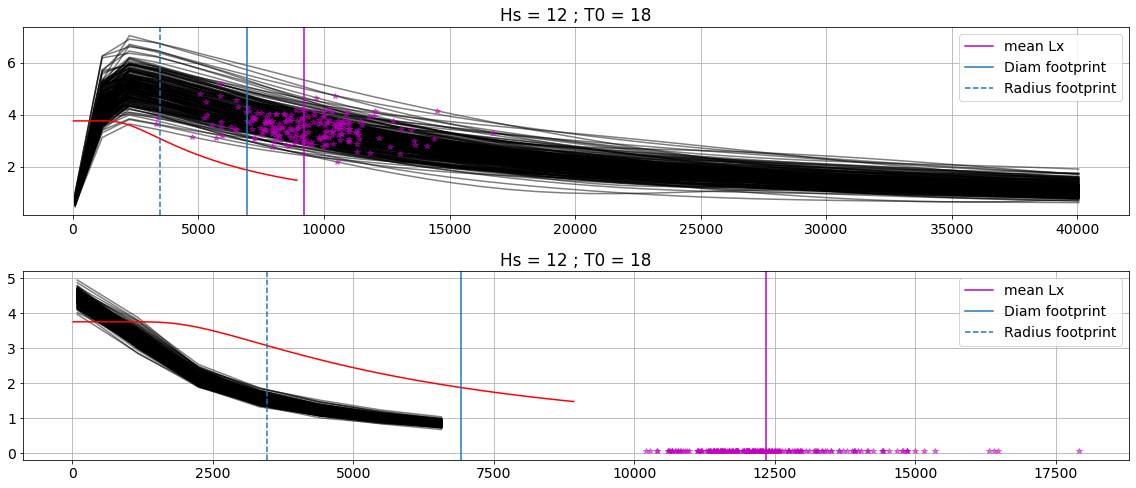

In [31]:
fig,axs = plt.subplots(2,1,figsize=(16,7))

int_env_kc_B = (int_over_kxky0[1,:,:len(Lxs)]*2*(4-np.pi)/np.reshape(Hsths2D,(len(Hsths2D),1))**2)
equiv_std_kc_B = np.sqrt(8*int_env_kc_B)

Lxbis = np.zeros((9,nseed))
# for indtest in range(9):
indtest=8
Lx01 = np.zeros(nseed)
stdHssurf = np.squeeze(std_Hs_surf[indtest,:,:])

for iseed in range(nseed):
    indmax = (np.nanargmax(stdHssurf[iseed,:],))
#         print(indmax)
    func_std_hs_surf = spi.interp1d(stdHssurf[iseed,indmax:],Lxas[indmax:],fill_value="extrapolate")
    indmax = (np.nanargmax(std_Hs_surf10[iseed,:],))    
    func_std_hs_surf2 = spi.interp1d(std_Hs_surf10[iseed,indmax:],Lxas[indmax:],fill_value="extrapolate")
    Lxbis[indtest,iseed] = func_std_hs_surf(Hs_retrack[indtest,iseed]) 
    Lx01[iseed]=func_std_hs_surf2(Hs_retrack10[iseed]) 

axs[0].plot(Lxas*dx,stdHssurf.T,'-k',alpha=0.5)
#     print(Lxbis)
axs[0].plot(Lxbis[indtest,:]*dx,Hs_retrack[indtest,:],'*m',alpha=0.5)
axs[0].plot(Lxs,equiv_std_kc_B[indtest,:],'-r')
radiTh = calc_footprint_diam(Hsths2D[indtest])
axs[0].axvline(np.mean(Lxbis[indtest,:])*dx,linestyle='-',color='m',label='mean Lx')
axs[0].axvline(radiTh,linestyle='-',label='Diam footprint')
axs[0].axvline(radiTh/2,linestyle='--',label='Radius footprint')
axs[0].legend()
# axs[0].set_xlim((0,3000))
axs[0].grid(True)
axs[0].set_title('Hs = '+str(Hsths2D[indtest])+' ; T0 = '+str(T0s2D[indtest]))
#     print('Hs = '+str(Hsths2D[indtest])+' ; T0 = '+str(T0s2D[indtest]),' Lx mean = ',
#           f'{np.mean(Lxbis[indtest,:]):.2f}',' +/- '+f'{np.std(Lxbis[indtest,:]):.2f}',
#           ' = ',f'{100*np.std(Lxbis[indtest,:])/np.mean(Lxbis[indtest,:]):.1f}','%')
print('Hs = '+str(Hsths2D[indtest])+' ; T0 = '+str(T0s2D[indtest]),'       diff vs footprint = ',f'{(radiTh/2)-np.mean(Lxbis[indtest,:]*dx):.2f}',
      '     ratio = ',f'{(radiTh/2)/np.mean(Lxbis[indtest,:]*dx):.2f}')



axs[1].plot(Lxas*dx,std_Hs_surf10.T,'-k',alpha=0.5)
#     print(Lxbis)
axs[1].plot(Lx01*dx,Hs_retrack10,'*m',alpha=0.5)
axs[1].plot(Lxs,equiv_std_kc_B[indtest,:],'-r')
radiTh = calc_footprint_diam(Hsths2D[indtest])
axs[1].axvline(np.mean(Lx01)*dx,linestyle='-',color='m',label='mean Lx')
axs[1].axvline(radiTh,linestyle='-',label='Diam footprint')
axs[1].axvline(radiTh/2,linestyle='--',label='Radius footprint')
axs[1].legend()
# axs[1].set_xlim((0,3000))
axs[1].grid(True)
axs[1].set_title('Hs = '+str(Hsths2D[indtest])+' ; T0 = '+str(T0s2D[indtest]))


plt.tight_layout()



(200, 38)


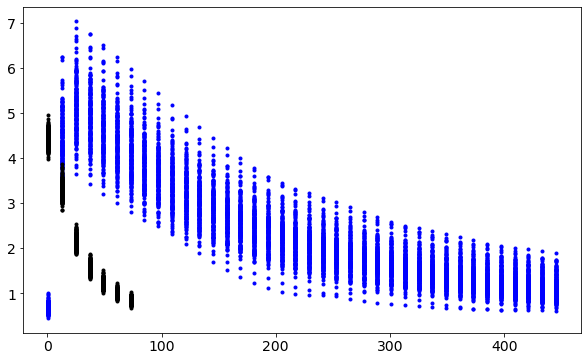

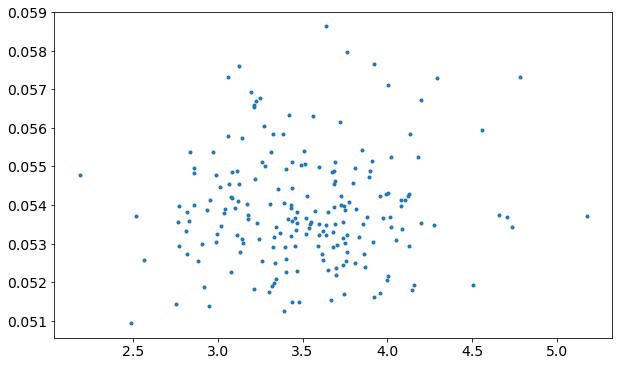

In [30]:
plt.plot(Lxas,std_Hs_surf[-1,:,:].T,'.b')
plt.plot(Lxas,std_Hs_surf10.T,'.k');
print(np.shape(std_Hs_surf10))

plt.figure()
plt.plot(Hs_retrack[-1,:],Hs_retrack10,'.')

Hs = 2 ; T0 = 6        diff vs footprint =  1077.90      ratio =  3.34
Hs = 6 ; T0 = 6        diff vs footprint =  1569.25      ratio =  2.70
Hs = 12 ; T0 = 6        diff vs footprint =  2240.26      ratio =  2.84
Hs = 2 ; T0 = 12        diff vs footprint =  958.72      ratio =  2.65
Hs = 6 ; T0 = 12        diff vs footprint =  1622.72      ratio =  2.87
Hs = 12 ; T0 = 12        diff vs footprint =  2309.31      ratio =  3.01
Hs = 2 ; T0 = 18        diff vs footprint =  722.87      ratio =  1.89
Hs = 6 ; T0 = 18        diff vs footprint =  1721.03      ratio =  3.23
Hs = 12 ; T0 = 18        diff vs footprint =  2437.22      ratio =  3.38


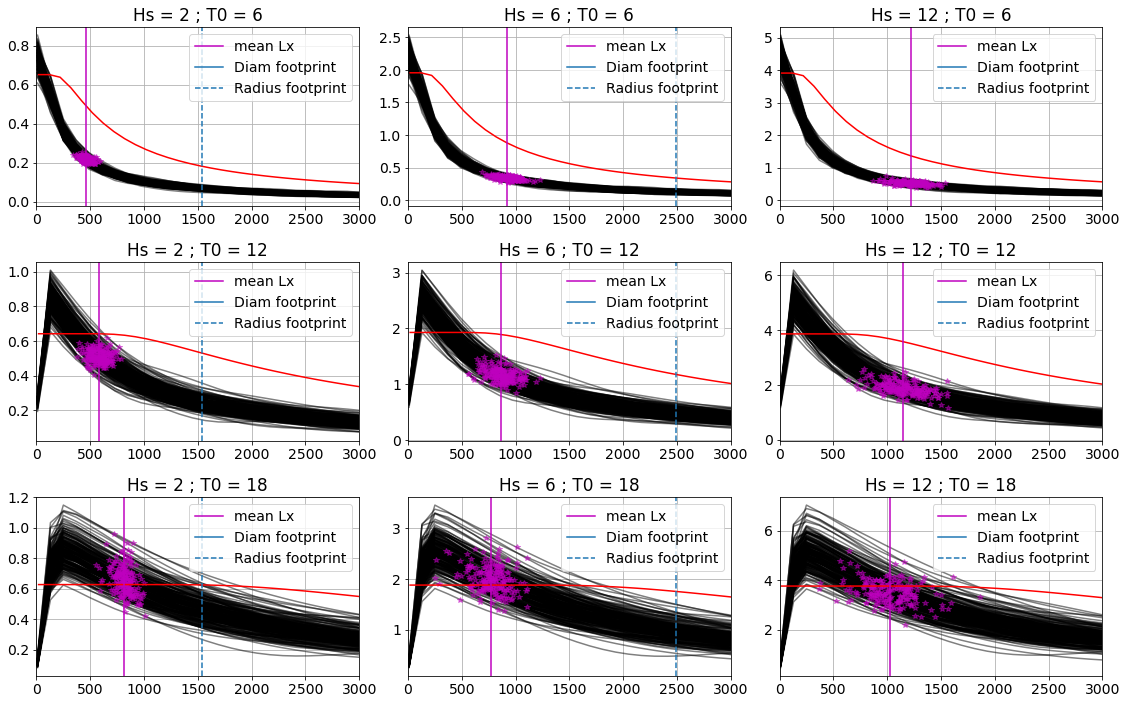

In [13]:
fig,axs = plt.subplots(3,3,figsize=(16,10))

int_env_kc_B = (int_over_kxky0[1,:,:len(Lxs)]*2*(4-np.pi)/np.reshape(Hsths2D,(len(Hsths2D),1))**2)
equiv_std_kc_B = np.sqrt(8*int_env_kc_B)

Lxbis = np.zeros((9,nseed))
for indtest in range(9):
    stdHssurf = np.squeeze(std_Hs_surf[indtest,:,:])
    for iseed in range(nseed):
        indmax = (np.nanargmax(stdHssurf[iseed,:],))
#         print(indmax)
        func_std_hs_surf = spi.interp1d(stdHssurf[iseed,indmax:],Lxas[indmax:],fill_value="extrapolate")
        Lxbis[indtest,iseed] = func_std_hs_surf(Hs_retrack[indtest,iseed]) 
    
    axs[indtest//3,indtest%3].plot(Lxas*dx,stdHssurf.T,'-k',alpha=0.5)
#     print(Lxbis)
    axs[indtest//3,indtest%3].plot(Lxbis[indtest,:]*dx,Hs_retrack[indtest,:],'*m',alpha=0.5)
    axs[indtest//3,indtest%3].plot(Lxs,equiv_std_kc_B[indtest,:],'-r')
    radiTh = calc_footprint_diam(Hsths2D[indtest])
    axs[indtest//3,indtest%3].axvline(np.mean(Lxbis[indtest,:])*dx,linestyle='-',color='m',label='mean Lx')
    axs[indtest//3,indtest%3].axvline(radiTh,linestyle='-',label='Diam footprint')
    axs[indtest//3,indtest%3].axvline(radiTh/2,linestyle='--',label='Radius footprint')
    axs[indtest//3,indtest%3].legend()
    axs[indtest//3,indtest%3].set_xlim((0,3000))
#     for iseed in range(nseed):
#         axs[indtest//3,indtest%3].axhline(Hs_retrack1[indtest,iseed],linestyle='--',color='r',alpha=0.3)
    axs[indtest//3,indtest%3].grid(True)
    axs[indtest//3,indtest%3].set_title('Hs = '+str(Hsths2D[indtest])+' ; T0 = '+str(T0s2D[indtest]))
#     print('Hs = '+str(Hsths2D[indtest])+' ; T0 = '+str(T0s2D[indtest]),' Lx mean = ',
#           f'{np.mean(Lxbis[indtest,:]):.2f}',' +/- '+f'{np.std(Lxbis[indtest,:]):.2f}',
#           ' = ',f'{100*np.std(Lxbis[indtest,:])/np.mean(Lxbis[indtest,:]):.1f}','%')
    print('Hs = '+str(Hsths2D[indtest])+' ; T0 = '+str(T0s2D[indtest]),'       diff vs footprint = ',f'{(radiTh/2)-np.mean(Lxbis[indtest,:]*dx):.2f}',
          '     ratio = ',f'{(radiTh/2)/np.mean(Lxbis[indtest,:]*dx):.2f}')
plt.tight_layout()



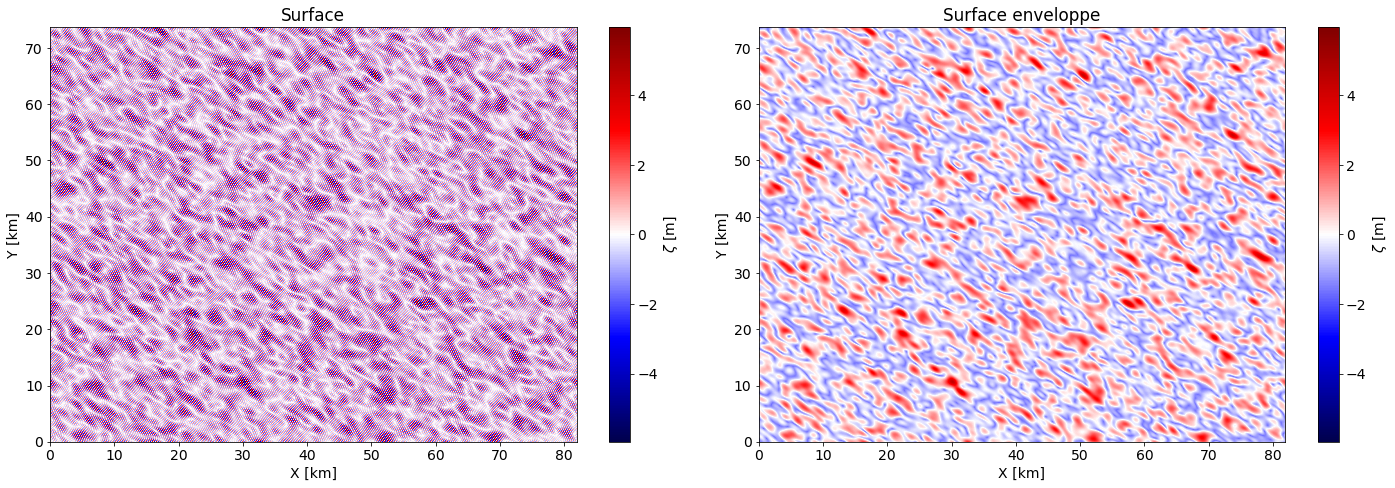

In [84]:
## Figure Surface et Surface Enveloppe ###########################""
fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)

im=axs[0].pcolormesh(X/1000,Y/1000,S2_r,cmap='seismic',norm = mcolors.Normalize(vmin=S2_r.min(), vmax=S2_r.max()))
_=plt.colorbar(im,ax=axs[0],label='$\zeta$ [m]')
_=axs[0].set_xlabel('X [km]')
_=axs[0].set_ylabel('Y [km]')
_=axs[0].set_title('Surface')


env2 = (S2_r**2+S2_i**2)
env_minusmean = np.sqrt(env2)-np.mean(np.sqrt(env2).flatten())
env = np.sqrt(env2)

im=axs[1].pcolormesh(X/1000,Y/1000,env_minusmean,cmap='seismic',norm = mcolors.Normalize(vmin=S2_r.min(), vmax=S2_r.max()))
_=plt.colorbar(im,ax=axs[1],label='$\zeta$ [m]')

_=axs[1].set_xlabel('X [km]')
_=axs[1].set_ylabel('Y [km]')
_=axs[1].set_title('Surface enveloppe')
_=plt.tight_layout()

In [6]:
radiTh = calc_footprint_diam(20)

nxa = np.floor(radiTh/dx).astype(int)
print(nxa//2)

vit_sat = 7*1e3 # m/s
freq_acqui = 5 # Hz
dist_acquisition = np.arange(0,dx*nx,vit_sat/freq_acqui) # distance
dist_acPix0 = (dist_acquisition/dx).astype(int)
alti_sat = 519 * 1e3 # km
radiTh = calc_footprint_diam(Hsth) # diameter

ny_mid = int(nx//2) # position of the flight
print(dist_acquisition[1] - dist_acquisition[0] )
print(vit_sat/freq_acqui)

443
1400.0
1400.0


In [87]:
4*np.std(S2_r.flatten())

5.2704627669472055

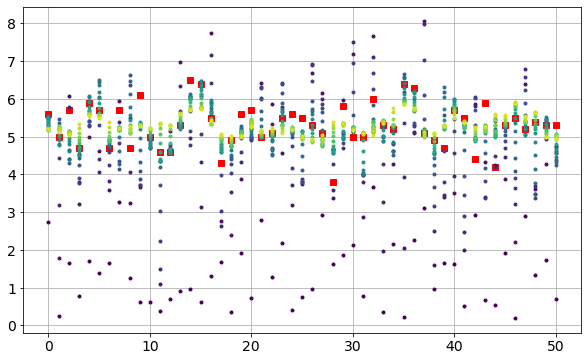

In [30]:
# for ik in range(np.size(Hs_std,1)):
#     plt.plot(Hs_retrack[-1,:],Hs_std[:,ik],'.',color=plt.cm.viridis(ik/np.size(Hs_std,1)))
plt.grid(True)
# plt.axline((4,4),slope=1)

plt.plot(Hs_retrack[-1,:],'sr')
for ik in range(np.size(Hs_std,1)):
    plt.plot(Hs_std[:,ik],'.',color=plt.cm.viridis(ik/np.size(Hs_std,1)))
# je comprends ton graphique : les erreurs de mesure de Hs par retracking ou std ne sont pas corrélées.

In [79]:
np.corrcoef(Hs_retrack[-1,1:],(Hs_retrack[-1,:-1]))
print(len(Hs_retrack[-1,1:]))
print(np.sqrt(1/50))
print(np.corrcoef(Hs_retrack[-1,1:],(Hs_retrack[-1,:-1])))

50
0.1414213562373095
[[ 1.         -0.04344295]
 [-0.04344295  1.        ]]


In [17]:
dist_pix_twoacqui = np.unique(dist_acPix[1:]-dist_acPix[0:-1])
print(dist_pix_twoacqui)
print(len(dist_acPix))
print(nx//nxa)

[140]
51
17


In [18]:
B2_2D = 0.5*8*2*np.fft.fftshift(myconv2D(0.5*Z2D,0.5*np.flip(Z2D)))*dkx2*dky2

In [67]:
B2_2D = 0.5*8*2*np.fft.fftshift(myconv2D(0.5*Z2D,0.5*np.flip(Z2D)))*dkx2*dky2
func_x= spi.interp1d(kX2,B2_2D)

Lxs = 2*Lxas*dx
int_over_kxky=np.zeros(len(Lxs))
for il, Lx in enumerate(Lxs):
    print(il,' over  ',len(Lxs)-1)
    kmin = twopi/(nx*dx)
    klim = twopi/(Lx)
    if Lx>1400:
        klim2 = twopi/(2*Lx)
#         klim = twopi/(2*Lx-1400)
    else:
        klim2=klim/2
    int_over_kx = spint.quad_vec(func_x,kmin,klim2)[0]+spint.quad_vec(func_x,-klim2,-kmin)[0]
    
    func_y = spi.interp1d(kY2,int_over_kx)
    int_over_kxky[il] = spint.quad_vec(func_y,-klim,-kmin)[0]+spint.quad_vec(func_y,kmin,klim)[0]


# L_footprintB = calc_footprint_diam(HSBoxB)
# int_env2_foot_B = intB_kc_B * LC /L_footprintB

# sum_env_tot_B = (sumBs_tot_B*2*(4-np.pi)/HSBoxB**2)
# int_env_kc_B = (int_env2_foot_B*2*(4-np.pi)/HSBoxB**2)

0  over   18
1  over   18
2  over   18
3  over   18
4  over   18
5  over   18
6  over   18
7  over   18
8  over   18
9  over   18
10  over   18
11  over   18
12  over   18
13  over   18
14  over   18
15  over   18
16  over   18
17  over   18
18  over   18


In [68]:
int_env_kc_B = (int_over_kxky*2*(4-np.pi)/Hsth**2)
equiv_std_kc_B = np.sqrt(8*int_env_kc_B)# - HSBoxB**2)

Lxs-dist_pix_twoacqui*dx

array([-1380, -1140,  -900,  -660,  -420,  -180,    60,   300,   540,
         780,  1020,  1260,  1500,  1740,  1980,  2220,  2460,  2700,
        2940])

In [42]:
dist_acquisition

array([    0.,  1400.,  2800.,  4200.,  5600.,  7000.,  8400.,  9800.,
       11200., 12600., 14000., 15400., 16800., 18200., 19600., 21000.,
       22400., 23800., 25200., 26600., 28000., 29400., 30800., 32200.,
       33600., 35000., 36400., 37800., 39200., 40600., 42000., 43400.,
       44800., 46200., 47600., 49000., 50400., 51800., 53200., 54600.,
       56000., 57400., 58800., 60200., 61600., 63000., 64400., 65800.,
       67200., 68600., 70000., 71400., 72800., 74200., 75600., 77000.,
       78400., 79800., 81200.])

In [52]:
equiv_std_kc_B2=np.copy(equiv_std_kc_B)
ind = np.where(Lxs>(dist_pix_twoacqui*dx))[0]
equiv_std_kc_B2[ind]=equiv_std_kc_B2[ind]*(((nx-(2*nxa))*dx)//(Lxs[ind]))/(len(dist_acPix))

In [53]:
equiv_std_kc_B2 = np.copy(equiv_std_kc_B)

Hs Th = 16, T0 = 7 s


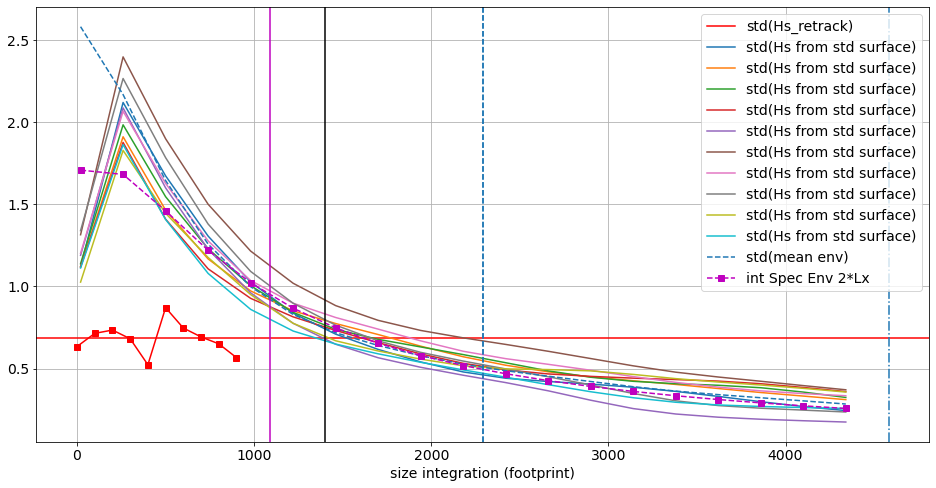

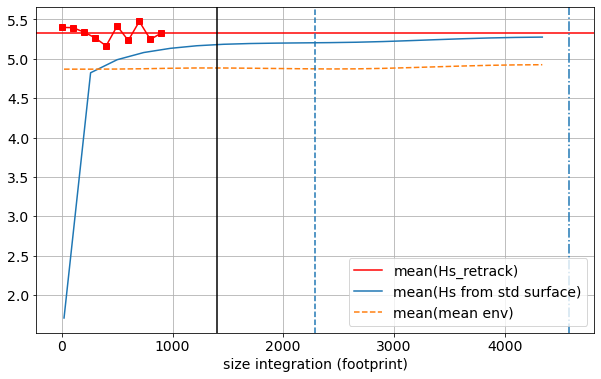

In [86]:
# std_Hs_surf = np.std(Hs_std,axis=0)
# std_mean_env = np.std(1.05*np.sqrt(8)*mean_env,axis=0)

size_footprint = 2*np.arange(0,nxa)*dx
ind_max = np.argmax(std_Hs_surf)
# f_std_hs = spi.interp1d(std_Hs_surf[ind_max:],size_footprint[ind_max:])
# f_std_env = spi.interp1d(std_mean_env[ind_max:],size_footprint[ind_max:])
plt.figure(figsize=(16,8))
# fig,axs = plt.subplots(1,1,figsize=(20,6))
plt.axhline(np.median(np.std(Hs_retrack,axis=1)),color='r',label='std(Hs_retrack)')
plt.plot(100*np.arange(nseed),(np.std(Hs_retrack,axis=1)),'-s',color='r')
plt.plot(2*Lxas*dx,(std_Hs_surf.T),'-',label='std(Hs from std surface)')
plt.plot(2*Lxas*dx,np.mean(std_mean_env,axis=0),'--',label='std(mean env)')
# plt.plot(Lxs,equiv_std_kc_B2,'-sb',label='int Spec Env 2*Lx-2800')
plt.plot(Lxs,equiv_std_kc_B,'--sm',label='int Spec Env 2*Lx')

# plt.plot(Lxs,equiv_std_kc_B1,'-ok',label='int Spec Env avant 1400')
# plt.plot(Lxs,equiv_std_kc_B1/(2),':ok',label='int Spec Env avant 1400')
# plt.plot(Lxs,equiv_std_kc_B0,'--*',markersize=10,label='int Spec Env avant 2*1400')

plt.xlabel('size integration (footprint)')
plt.axvline(radiTh,linestyle='-.')
plt.axvline(dist_pix_twoacqui*dx,color='k')
plt.axvline(radiTh//2,linestyle='--')
plt.axvline(radiTh//2,linestyle='--')
plt.axvline((radiTh//2)-1200,linestyle='-',color='m')
plt.grid(True)
# axs[0].set_xscale('log')
# axs[0].set_yscale('log')
plt.legend()
# Etant donné la deadline, envoyez moi tous vos commentaires aujourd'hui afin qu'ils soient inclus d'ici mercredi prochain.

plt.figure()
plt.axhline(np.mean(np.mean(Hs_retrack,axis=1)),color='r',label='mean(Hs_retrack)')
plt.plot(100*np.arange(nseed),np.mean(Hs_retrack,axis=1),'-s',color='r')
plt.plot(2*Lxas*dx,np.mean(mean_Hs_surf,axis=0),'-',label='mean(Hs from std surface)')
plt.plot(2*Lxas*dx,np.mean(mean_mean_env,axis=0),'--',label='mean(mean env)')
# axs[1].plot(Lxs,equiv_std_kc_B,'-o',label='int Spec Env')
plt.xlabel('size integration (footprint)')
plt.axvline(radiTh,linestyle='-.')
plt.axvline(dist_pix_twoacqui*dx,color='k')
plt.axvline(radiTh//2,linestyle='--')
# axs[1].axvline((radiTh//2)-1000,linestyle='-',color='m')
plt.grid(True)
# axs[1].set_xscale('log')
# axs[1].set_yscale('log')
plt.legend()

# plt.figure()
# plt.plot(Hs_std,Hs_retrack,'*')
# plt.plot(Hs_std,2*np.sqrt(8)*mean_env,'.')
# plt.axline((15,15),slope=1,color='k',linestyle='--')
# plt.axline((17,15),slope=1,color='k',linestyle=':')
# plt.grid(True)
# print(' stds : ..... ')
# print('Hs from std : ',np.std(Hs_std))
# print('Hs from retrack : ',np.std(Hs_retrack))
# print('env : ',np.std(np.sqrt(8)*mean_env))
print('Hs Th = 16, T0 = 7 s')

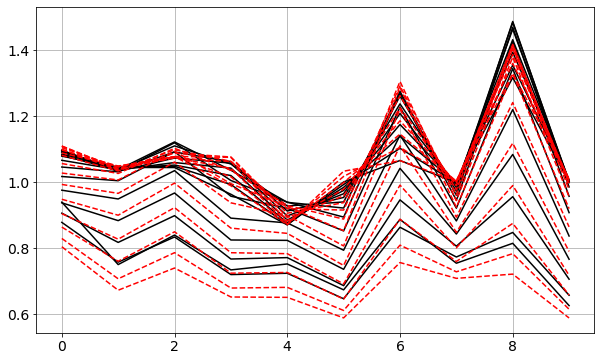

In [152]:
plt.plot(equiv_std_kc_B[1:]/(std_Hs_surf)[:,1:],'-k')
plt.plot(equiv_std_kc_B[1:]/(std_mean_env)[:,1:],'--r')
# plt.yscale('log')
plt.grid(True)

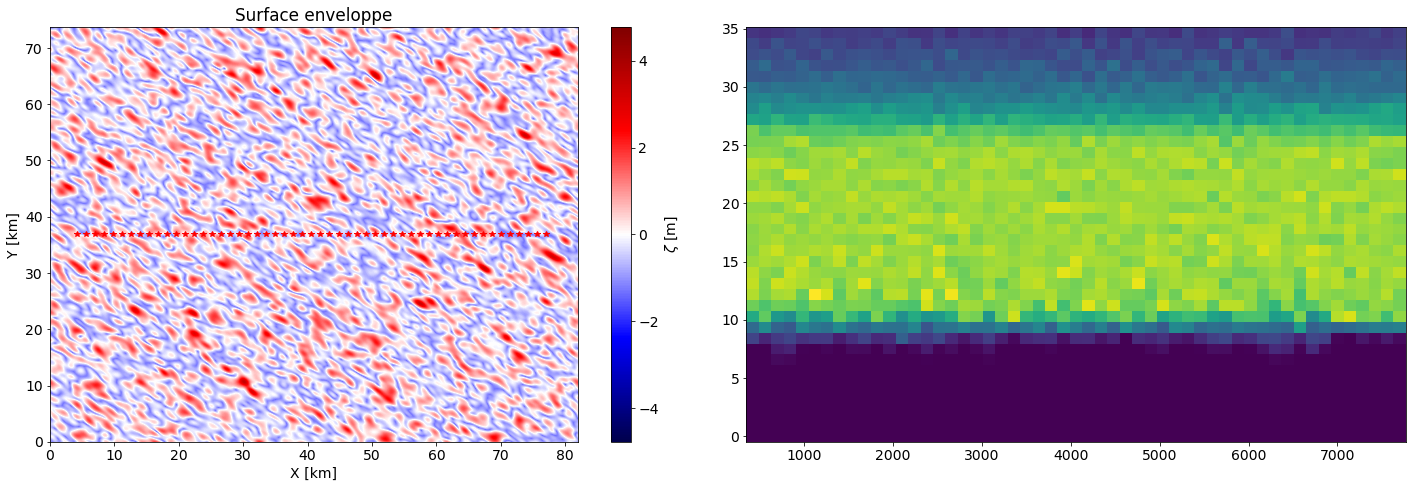

In [69]:
fig,axs = plt.subplots(1,2,figsize=(20,7))
m=axs[0].pcolormesh(X/1000,Y/1000,env_minusmean,cmap='seismic',norm = mcolors.Normalize(vmin=S2_r.min(), vmax=S2_r.max()))
_=plt.colorbar(im,ax=axs[0],label='$\zeta$ [m]')

_=axs[0].set_xlabel('X [km]')
_=axs[0].set_ylabel('Y [km]')
_=axs[0].set_title('Surface enveloppe')
_=axs[0].plot(X[dist_acPix]/1000,Y[ny_mid]/1000*np.ones(np.shape(dist_acPix)),'*r')


_=plt.tight_layout()
axs[1].pcolormesh(dist_acPix,edges_ref[:-1],waveforms.T)

In [3]:
# Checking on what convolution in numpy really is: not circular convolution !!!
# let us define "myconv" as the circular convolution we need. 
# This is OK here because our surface is periodic and the FFT gives no funny effects ... 
# warning this convolution does not flip the second array ... need to be flipped before

import numpy as np
def myconv(x, h):
    assert np.shape(x) == np.shape(h), 'Inputs to periodic convolution '\
                               'must be of the same period, i.e., shape.'

    X = np.fft.fft(x)
    H = np.fft.fft(h)

    return np.real(np.fft.ifft(np.multiply(X, H)))

# and here is a quick verification

a=[2.0,3.0]
b=[1.0,0.5]
print('this is the standard non-circular convolution:',np.convolve(a,b, 'same'))
c=myconv(a,b)
print('this is my circular convolution:              ',c)
print(a[0]*b[0]+a[1]*b[-1],a[0]*b[1]+a[1]*b[0])

this is the standard non-circular convolution: [2. 4.]
this is my circular convolution:               [3.5 4. ]
3.5 4.0


In [6]:
isplot = 1
isprints = 1
Lc=4000 # cut-off wavelength approximating effect of altimeter footprint
kc=2*np.pi/Lc

In [4]:
## exemple Welch 1D 
## function to extract vector into tiles
def extract_Welch_tiles_1D(A,nxtile):
    # nxtiles : nb of pixels by tiles
    nxA = len(A)
#     nxtile = int(nxA//Ntiles)
    Ntiles = int(nxA//nxtile)
    shx = int(nxtile//2)
    Ntiles_overlap = 2*Ntiles-1
    
    extract= np.zeros((Ntiles_overlap,nxtile))
    for windows in range(Ntiles_overlap):
        if windows < Ntiles:
            i1 = int(windows + 1)
            extract[windows,:]=A[nxtile*(i1-1):nxtile*i1]
        elif windows >= Ntiles:
            i1 = int((windows-Ntiles)+ 1)
            extract[windows,:]=A[nxtile*(i1-1)+shx:nxtile*i1+shx]
    
    return extract, Ntiles_overlap

In [8]:
print(Z2D_def.shape)
print(kx.shape)
print(kx)

(4048, 4048)
(4048,)
[-0.31415927 -0.31400405 -0.31384883 ...  0.31369361  0.31384883
  0.31400405]


In [9]:
# investigate integration over total signal #############################
isplot=0
Hss = np.arange(1,20)
nHs=len(Hss)
Lp=9.81/np.pi*T0**2;
kp=2*np.pi/Lp;sx=kp*0.1;sy=sx;
slope = np.zeros(nHs)
inter = np.zeros(nHs)
Hs_from_surf2D = np.zeros(nHs)
Hs_from_surf1D = np.zeros(nHs)
equiv_Hs_from_env = np.zeros(nHs)
estim_Hstot_from_env = np.zeros(nHs)
estim_Hstot_from_env_spec = np.zeros(nHs)
estim_Hstot_from_env_spec0 = np.zeros(nHs)
Lc=4000 # cut-off wavelength approximating effect of altimeter footprint
kc=2*np.pi/Lc
nLL = 15
LLs=np.linspace(1000,6000,nLL)

Hs2_means = np.zeros((nLL,nHs))
Hs_means_2 = np.zeros((nLL,nHs))
Hs2_stds = np.zeros((nLL,nHs))
Hs_stds_2 = np.zeros((nLL,nHs))
Hs2_estimated_mean = np.zeros((nLL,nHs))
Hs2_estimated_std = np.zeros((nLL,nHs))
Hs_estimated_mean = np.zeros((nLL,nHs))
Hs_estimated_std = np.zeros((nLL,nHs))
var_env_above = np.zeros((nLL,nHs))
var_env2_above = np.zeros((nLL,nHs))
Hs2_estimated_env = np.zeros((nLL,nHs))
Hs2_estimated_env2 = np.zeros((nLL,nHs))

for ihs,Hs in enumerate(Hss):
    Z2D_def, kX, kY = def_spectrum_for_surface(nx=nx,ny=ny,dx=dx,dy=dy,theta_m=theta_m,D=D,T0=T0,Hs=Hs,
                             sk_theta=sx,sk_k=sy,typeSpec='Gaussian')

    # Z1, kX, kY = def_spectrum_for_surface(nx=nx,ny=ny,dx=dx,dy=dy,theta_m=theta_m,D=D,T0=T0,
    #                                       nk=1001,nth=36,klims=(0.0002,0.2),n=4,typeSpec='PM')

    # Makes a surface with random phases using a seed (4th argument)
    S2D_r,S2D_i,X,Y,kx,rg,dkx,dky= surface_from_Z1kxky_uniform_phase(Z2D_def,kX,kY,10) 
    ### Get a equivalent 2D spectrum from DFT of the surface ################
    # -- to verify the coefficients ------------------------------------
    Z2D_from_FFT = np.abs(np.fft.fft2(S2D_r,norm='forward'))**2/(dkx*dky)

    ### 1D spectrum from integration over ky 
    Z1D_def = (np.sum(Z2D_def,axis=0))*dky
    Z1D_def_noshift=np.fft.ifftshift(Z1D_def)

    ### Generate a 1D surface based on 1D spectrum (1 realisation) #########
    rng = np.random.default_rng(0)
    rg = rng.uniform(low=0.0, high=1.0, size=(nx))
    # -- from original 1D spectrum (from 2D)
    zhats=np.sqrt(2*np.fft.ifftshift(Z1D_def)*dkx)*np.exp(1j*2*np.pi*rg)
    S1D_r = np.real(np.fft.ifft(zhats,norm="forward"))
    S1D_i = np.imag(np.fft.ifft(zhats,norm="forward"))

    ### Envelope squared A2D and envelope B2D ###############################################
    # -- 2D env
    A2D = (S2D_r**2+S2D_i**2) # S1 is real part, S2 is imaginary part
    B2D = np.sqrt(A2D) 
    A2D = A2D-np.mean(A2D.flatten())
#     B2D = B2D-np.mean(B2D.flatten())

    # ---- Spectrum of A = spectrum of envelope squared from 2D Surface ---------------
    Spec_env2_2D = np.abs(np.fft.fft2(A2D,norm='forward'))**2/(dky*dkx)
    Spec_env1_2D = np.abs(np.fft.fft2(B2D-np.mean(B2D.flatten()),norm='forward'))**2/(dky*dkx)
    Spec_env1_2D_DC = np.abs(np.fft.fft2(B2D,norm='forward'))**2/(dky*dkx)

    # integration over y <=> integration over realisations 
    Spec_env2_from_2D = np.sum(Spec_env2_2D,axis=0)*dky
    Spec_env1_from_2D = np.sum(Spec_env1_2D,axis=0)*dky
    Spec_env1_DC_from_2D = np.sum(Spec_env1_2D_DC,axis=0)*dky*dkx

    Spec_env2_from_2D_shifted = np.fft.fftshift(Spec_env2_from_2D)
    Spec_env1_from_2D_shifted = np.fft.fftshift(Spec_env1_from_2D)
    Spec_env1_DC_from_2D_shifted = np.fft.fftshift(Spec_env1_DC_from_2D)
    
    Spec_env1_func = spi.interp1d(kx,Spec_env1_from_2D_shifted)
    Spec_env2_func = spi.interp1d(kx,Spec_env2_from_2D_shifted)

    # -- 1D env
    A1D = (S1D_r**2+S1D_i**2) # S1 is real part, S2 is imaginary part
    B1D = np.sqrt(A1D) 
    A1D = A1D-np.mean(A1D.flatten())
    # B1D = B1D-np.mean(B1D.flatten())
    var1_from2D_spec = np.sum(Spec_env1_from_2D_shifted)*dkx
    estim_Hstot_from_env[ihs] = np.sqrt(8)*np.sqrt(np.mean(B1D.flatten())**2 + np.std(B1D.flatten())**2)
    estim_Hstot_from_env_spec0[ihs] = np.sqrt(8)*np.sqrt(np.mean(B1D.flatten())**2 + var1_from2D_spec)
    estim_Hstot_from_env_spec[ihs] = np.sqrt(8)*np.sqrt(Spec_env1_DC_from_2D[0] + var1_from2D_spec)
    equiv_Hs_from_env[ihs] = 2*np.sqrt(2)*(np.mean(B1D.flatten()))
    Hs_from_surf1D[ihs] = 4*np.std(S1D_r)
    Hs_from_surf2D[ihs] = 4*np.std(S2D_r)

    print('---- Hs from Std of surface : ----------------------------------')
    print('1D :           4*std(S1D_r) = ',Hs_from_surf1D[ihs])
    print('2D :           4*std(S2D_r) = ',Hs_from_surf2D[ihs])
    print(' ')
    print('---- Hs from envelope : --------------')
    print('equivalent (2 * env ~ Hrms)  = ',equiv_Hs_from_env[ihs])
    print('estimation (sqrt(8)*sqrt(mean(env)**2 + std(env)**2))  = ',estim_Hstot_from_env[ihs])
    print('')
    mean_env = np.mean(B1D)
    
    for il,LL in enumerate(LLs):
        Nfoot = int(LL//dx)
        kc=2*np.pi/LL
        
        var_env_above[il,ihs] = spint.quad(Spec_env1_func,kc,kx.max())[0]+spint.quad(Spec_env1_func,kx.min(),-kc)[0]
        var_env2_above[il,ihs] = spint.quad(Spec_env2_func,kc,kx.max())[0]+spint.quad(Spec_env2_func,kx.min(),-kc)[0]
#         var_env2_conv_above[il,ihs]=spint.quad(conv_1Da_func,kc,kx.max())[0]+spint.quad(conv_1Da_func,kx.min(),-kc)[0]
        
        footprints_S1D, Ntiles= extract_Welch_tiles_1D(S1D_r,Nfoot)
        footprints_Env, Ntiles= extract_Welch_tiles_1D(B1D,Nfoot)
#         print('LL = ',LL,', shape footprints = ',np.shape(footprints_S1D))
        Hs_footprints_disk_2 = 4**2*np.var(footprints_S1D,axis=1,ddof=0)
        Hs_footprints_disk = np.sqrt(Hs_footprints_disk_2)
        env_means_disk = np.mean(footprints_Env,axis=1)
        env_var_disk = np.var(footprints_Env,axis=1,ddof=1)

        Hs2_means[il,ihs] = np.mean(Hs_footprints_disk_2)
        Hs_means_2[il,ihs] = np.mean(Hs_footprints_disk)**2
        Hs2_stds[il,ihs] = np.std(Hs_footprints_disk_2)
        Hs_stds_2[il,ihs] = np.var(Hs_footprints_disk)

        Hs2_estimated_footprint = 8*(env_means_disk**2 + env_var_disk)
        Hs2_estimated_mean[il,ihs] = np.mean(Hs2_estimated_footprint) # THIS one is similar to local Hs !!!! NICELY DONE !
        Hs2_estimated_std[il,ihs] = np.std(Hs2_estimated_footprint)
        Hs2_estimated_env[il,ihs] = 8*(Spec_env1_DC_from_2D[0]+var_env_above[il,ihs])
        Hs2_estimated_env2[il,ihs] = 8*(Spec_env1_DC_from_2D[0]+var_env2_above[il,ihs])
        
        Hs_estimated_mean[il,ihs] = np.mean(np.sqrt(Hs2_estimated_footprint)) # THIS one is similar to local Hs !!!! NICELY DONE !
        Hs_estimated_std[il,ihs] = np.std(np.sqrt(Hs2_estimated_footprint))

    res = stats.linregress(np.sqrt(Hs_stds_2[:,ihs]), np.sqrt(Hs2_estimated_std[:,ihs]))
    slope[ihs]=res.slope
    inter[ihs]=res.intercept

Gaussian spectrum selected. Available options:
 - Hs, sk_theta, sk_k. 
With (sk_k, sk_theta) the sigma values for the k-axis along the main direction and perpendicular to it respectively 
 Other options (common to all spectrum types) are : nx, ny, dx, dy, T0, theta_m, D
Hs for Gaussian :  0.9999999999999937


KeyboardInterrupt: 

Ratio Hs_from_surf/Hs_def =  1.0540925533894956


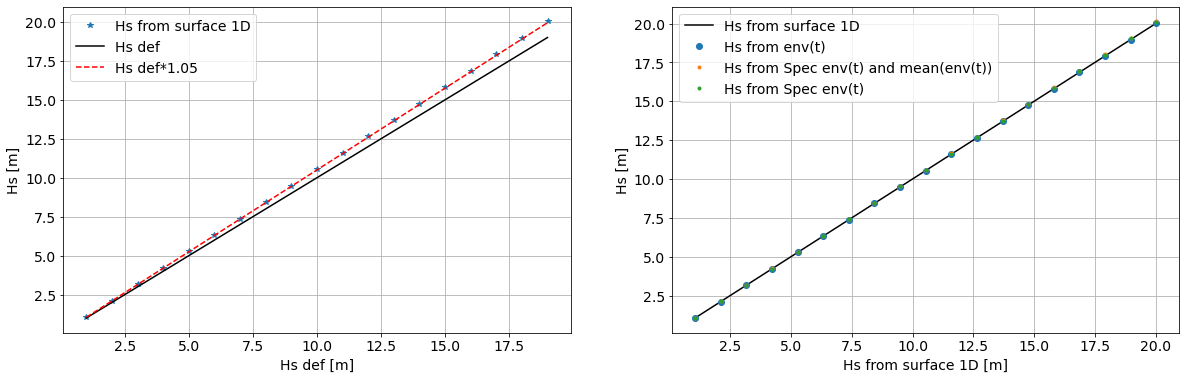

In [7]:
# --- Ratio Hs defined vs Hs from std surface = 1.05
res = stats.linregress(Hss,Hs_from_surf1D)
print('Ratio Hs_from_surf/Hs_def = ',res.slope)
fig,axs=plt.subplots(1,2,figsize=(20,6))
_=axs[0].plot(Hss,Hs_from_surf1D,'*',label='Hs from surface 1D')
_=axs[0].plot(Hss,Hss,'-k',label='Hs def')
_=axs[0].plot(Hss,Hss*1.05,'--r',label='Hs def*1.05')
_=axs[0].set_xlabel('Hs def [m]')
_=axs[0].set_ylabel('Hs [m]')
_=axs[0].legend()

# _=axs[1].plot(Hss,Hs_from_surf1D,'*',label='Hs from surface 1D')
_=axs[1].plot(Hs_from_surf1D,Hs_from_surf1D,'-k',label='Hs from surface 1D')#def')
_=axs[1].plot(Hs_from_surf1D,estim_Hstot_from_env,'o',label='Hs from env(t)')
_=axs[1].plot(Hs_from_surf1D,estim_Hstot_from_env_spec0,'.',label='Hs from Spec env(t) and mean(env(t))')
_=axs[1].plot(Hs_from_surf1D,(estim_Hstot_from_env_spec),'.',label='Hs from Spec env(t)')
_=axs[1].set_xlabel('Hs from surface 1D [m]')
_=axs[1].set_ylabel('Hs [m]')
_=axs[1].legend()

In [58]:
# investigate variances r/r partial integration of spectrum #######################

isplot=0
Hss = np.arange(4,20,4)
nHs=len(Hss)
T0=12
Lp=9.81/np.pi*T0**2;
kp=2*np.pi/Lp;
sx=kp*0.14
sy=sx;

nseed= 8
slope = np.zeros(nHs)
inter = np.zeros(nHs)
Hs_from_surf2D = np.zeros(nHs)
Hs_from_surf1D = np.zeros(nHs)
equiv_Hs_from_env = np.zeros(nHs)
estim_Hstot_from_env = np.zeros(nHs)
estim_Hstot_from_env_spec = np.zeros(nHs)
estim_Hstot_from_env_spec0 = np.zeros(nHs)
Lc=4000 # cut-off wavelength approximating effect of altimeter footprint
# kc=2*np.pi/Lc
nLL = 20
L_low = 2*np.pi/(1.72*sx)#2.5*sx)
LLs=np.flip(np.linspace(500,8000,nLL))
Ntmax = int(2*(nx//(LLs.min()//dx))-1)
# # to study the limit
# L_low = 2*np.pi/(2*sx)
# LLs=np.flip(np.linspace(1000,L_low,nLL))

mean_sum_spec_env_without0 = np.zeros((nLL,nHs))
std_sum_spec_env_without0 = np.zeros((nLL,nHs))
sum_spec_env = np.zeros((nLL,nHs))
Hs2_means = np.zeros((nLL,nHs))
Hs_means_2 = np.zeros((nLL,nHs))
Hs2_stds = np.zeros((nLL,nHs))
Hs_stds_2 = np.zeros((nLL,nHs))
Hs2_estimated_mean = np.zeros((nLL,nHs))
Hs2_estimated_std = np.zeros((nLL,nHs))
Hs_estimated_mean = np.zeros((nLL,nHs))
Hs_estimated_std = np.zeros((nLL,nHs))
var_env_above = np.zeros((nLL,nHs,nseed))
var_env_2D_above = np.zeros((nLL,nHs,nseed))
var_env_welch = np.zeros((nLL,nHs,nseed))
var_env_footspec = np.zeros((nLL,nHs,nseed))
Hs_footprints_disk_2_vec = np.zeros((nLL,nHs,nseed,Ntmax))
env_means_disk_vec = np.zeros((nLL,nHs,nseed,Ntmax))
env_var_disk_vec = np.zeros((nLL,nHs,nseed,Ntmax))

Hs2_estimated_env = np.zeros((nLL,nHs))
Hs2_estimated_env2 = np.zeros((nLL,nHs))

if isplot:
    fig,axs = plt.subplots(2,2,figsize=(20,14))
    fig2,axs2 = plt.subplots(2,2,figsize=(20,14))
spec_funcs = []
for ihs,Hs in enumerate(Hss):
    Z2D_def, kX, kY = def_spectrum_for_surface(nx=nx,ny=ny,dx=dx,dy=dy,theta_m=theta_m,D=D,T0=T0,Hs=Hs,
                             sk_theta=sx,sk_k=sy,typeSpec='Gaussian')
    
    # Makes a surface with random phases using a seed (4th argument)
    S2D_r,S2D_i,X,Y,kx,rg,dkx,dky= surface_from_Z1kxky_uniform_phase(Z2D_def,kX,kY,10) 
#     ### Get a equivalent 2D spectrum from DFT of the surface ################
#     # -- to verify the coefficients ------------------------------------
#     Z2D_from_FFT = np.abs(np.fft.fft2(S2D_r,norm='forward'))**2/(dkx*dky)

    ### 1D spectrum from integration over ky 
    Z1D_def = (np.sum(Z2D_def,axis=0))*dky # from -kmax to + kmax
    Z1D_def_noshift = np.fft.ifftshift(Z1D_def) #  from 0 to kmax + -kmax to 0
    spec_funcs0 = []
    ### Generate a 1D surface based on 1D spectrum (1 realisation) #########
    for isee in range(nseed):
        rng = np.random.default_rng(isee)
        rg = rng.uniform(low=0.0, high=1.0, size=(nx))
        # -- from original 1D spectrum (from 2D)
        zhats=np.sqrt(2*Z1D_def_noshift*dkx)*np.exp(1j*2*np.pi*rg)
        S1D_r = np.real(np.fft.ifft(zhats,norm="forward"))
        S1D_i = np.imag(np.fft.ifft(zhats,norm="forward"))

        ### Envelope squared A2D and envelope B2D ###############################################
        # -- 2D env --------------- --------------- --------------- ---------------
        A2D = (S2D_r**2+S2D_i**2) # S1 is real part, S2 is imaginary part
        B2D = np.sqrt(A2D) 
        A2D = A2D-np.mean(A2D.flatten())
    #     B2D = B2D-np.mean(B2D.flatten())

        # ---- Spectrum of A = spectrum of envelope squared from 2D Surface ---------------
        Spec_env2_2D = np.abs(np.fft.fft2(A2D,norm='forward'))**2/(dky*dkx)
        Spec_env1_2D = np.abs(np.fft.fft2(B2D-np.mean(B2D.flatten()),norm='forward'))**2/(dky*dkx)
        Spec_env1_2D_DC = np.abs(np.fft.fft2(B2D,norm='forward'))**2/(dky*dkx)

        # integration over y <=> integration over realisations 
        Spec_env2_from_2D = np.sum(Spec_env2_2D,axis=0)*dky # 0 to kmax  and -kmax to 0
        Spec_env1_from_2D = np.sum(Spec_env1_2D,axis=0)*dky # 0 to kmax  and -kmax to 0
        Spec_env1_DC_from_2D = np.sum(Spec_env1_2D_DC,axis=0)*dky # 0 to kmax  and -kmax to 0

        Spec_env2_from_2D_shifted = np.fft.fftshift(Spec_env2_from_2D) # -kmax to kmax
        Spec_env1_from_2D_shifted = np.fft.fftshift(Spec_env1_from_2D) # -kmax to kmax
        Spec_env1_DC_from_2D_shifted = np.fft.fftshift(Spec_env1_DC_from_2D) # -kmax to kmax

        Spec_env1_2D_func = spi.interp1d(kx,Spec_env1_from_2D_shifted)
        Spec_env1_DC_2D_func = spi.interp1d(kx,Spec_env1_DC_from_2D_shifted)
        Spec_env2_2D_func = spi.interp1d(kx,Spec_env2_from_2D_shifted)
        
        spec_funcs0.append(Spec_env1_DC_2D_func)
        # -- 1D env --------------- --------------- --------------- ---------------
        A1D = (S1D_r**2+S1D_i**2) # S1 is real part, S2 is imaginary part
        B1D = np.sqrt(A1D) 
        A1D = A1D-np.mean(A1D.flatten())
        # B1D = B1D-np.mean(B1D.flatten())
        Spec_env2_1D = np.abs(np.fft.fft(A1D,norm='forward'))**2/dkx # 0 to kmax  and -kmax to 0
        Spec_env1_1D = np.abs(np.fft.fft(B1D-np.mean(B1D.flatten()),norm='forward'))**2/(dkx) # 0 to kmax  and -kmax to 0
        Spec_env1_1D_DC = np.abs(np.fft.fft(B1D,norm='forward'))**2/(dkx) # 0 to kmax  and -kmax to 0

        Spec_env2_1D_shifted = np.fft.fftshift(Spec_env2_1D) # -kmax to kmax
        Spec_env1_1D_shifted = np.fft.fftshift(Spec_env1_1D) # -kmax to kmax
        Spec_env1_DC_1D_shifted = np.fft.fftshift(Spec_env1_1D_DC) # -kmax to kmax

        Spec_env1_1D_func = spi.interp1d(kx,Spec_env1_1D_shifted)
        Spec_env2_1D_func = spi.interp1d(kx,Spec_env2_1D_shifted)

        var1_from2D_spec = np.sum(Spec_env1_from_2D_shifted)*dkx
        var1_from1D_spec = np.sum(Spec_env1_1D_shifted)*dkx

        estim_Hstot_from_env[ihs] = np.sqrt(8)*np.sqrt(np.mean(B1D.flatten())**2 + np.std(B1D.flatten())**2)
        estim_Hstot_from_env_spec0[ihs] = np.sqrt(8)*np.sqrt(np.mean(B1D.flatten())**2 + var1_from2D_spec)
        estim_Hstot_from_env_spec[ihs] = np.sqrt(8)*np.sqrt(Spec_env1_DC_from_2D[0] + var1_from2D_spec)
        equiv_Hs_from_env[ihs] = 2*np.sqrt(2)*(np.mean(B1D.flatten()))
        Hs_from_surf1D[ihs] = 4*np.std(S1D_r)
        Hs_from_surf2D[ihs] = 4*np.std(S2D_r)
        '''
        print('---- Hs from Std of surface : ----------------------------------')
        print('1D :           4*std(S1D_r) = ',Hs_from_surf1D[ihs])
        print('2D :           4*std(S2D_r) = ',Hs_from_surf2D[ihs])
        print(' ')
        print('---- Hs from envelope : --------------')
        print('equivalent (2 * env ~ Hrms)  = ',equiv_Hs_from_env[ihs])
        print('estimation (sqrt(8)*sqrt(mean(env)**2 + std(env)**2))  = ',estim_Hstot_from_env[ihs])
        print('')
        '''
        mean_env = np.mean(B1D)

        if (isplot) and (Hs%4==0):
            axs[((Hs//4)-1)//2,((Hs//4)-1)%2].plot(kx,Spec_env1_from_2D_shifted,'--ok',zorder=100) 
            axs[((Hs//4)-1)//2,((Hs//4)-1)%2].set_title('Hs = '+str(Hs))
    #         axs[((Hs//4)-1)//2,((Hs//4)-1)%2].set_xscale('log')
    #         axs[((Hs//4)-1)//2,((Hs//4)-1)%2].set_yscale('log')
            axs2[((Hs//4)-1)//2,((Hs//4)-1)%2].set_title('Hs = '+str(Hs))
            axs2[((Hs//4)-1)//2,((Hs//4)-1)%2].set_xscale('log')
            axs2[((Hs//4)-1)//2,((Hs//4)-1)%2].set_yscale('log')
        for il,LL in enumerate(LLs):
            Nfoot = int(LL//dx) # size of footprint
            kc=2*np.pi/(LL)

            footprints_S1D, Ntiles = extract_Welch_tiles_1D(S1D_r,Nfoot)
            footprints_Env, Ntiles = extract_Welch_tiles_1D(B1D-B1D.mean(),Nfoot) 
            # axis : nb of footprint = Ntiles, size footprint = Nfoot
            hann_weight = 0.5 - 0.5 * np.cos(2*np.pi*np.arange(Nfoot)/(Nfoot-1))
            hann_weight = np.tile(hann_weight,(Ntiles,1))
            U = np.mean(np.abs(hann_weight)**2)

            # --- var calculated from surface in footprint --------------
            Hs_footprints_disk_2 = np.var(footprints_S1D,axis=1,ddof=1)
            Hs_footprints_disk = np.sqrt(Hs_footprints_disk_2)

            # --- Spec for enveloppe in footprint -----
            spec_footprint_Env0 = np.abs(np.fft.fftshift(np.fft.fft(footprints_Env*hann_weight,
                                                                    norm='forward',axis=1)))**2
            freq_footprint_mkmax_kmax = np.fft.fftshift(np.fft.fftfreq(Nfoot, d=dx)*2*np.pi)
            dkxspec = freq_footprint_mkmax_kmax[1] - freq_footprint_mkmax_kmax[0]
            spec_footprint_Env = np.mean(spec_footprint_Env0/(dkxspec*U),axis=0)
            spec_footprint_Env_func = spi.interp1d(freq_footprint_mkmax_kmax,spec_footprint_Env)
            # --- Spec for enveloppe in footprint - welch -----
            freq_welch,spec_welch_Env = spsi.welch(B1D-B1D.mean(),fs = 2*np.pi/dx,
                                                   nperseg=Nfoot)#,noverlap = Nfoot-6 )
            spec_welch_Env_func = spi.interp1d(freq_welch,spec_welch_Env)

            # --- Definition KxMax -----------------------
            kxMax = np.min((kx.max(),freq_welch.max(),freq_footprint_mkmax_kmax.max()))
            # ----- Var from tot spec int -------------------------------------
            var_env_above[il,ihs,isee] = spint.quad(Spec_env1_1D_func,kc,kxMax)[0]+spint.quad(Spec_env1_1D_func,-kxMax,-kc)[0]
            var_env_2D_above[il,ihs,isee] = spint.quad(Spec_env1_2D_func,kc,kxMax)[0]+spint.quad(Spec_env1_2D_func,-kxMax,-kc)[0]
    #         var_env2_conv_above[il,ihs]=spint.quad(conv_1Da_func,kc,kx.max())[0]+spint.quad(conv_1Da_func,kx.min(),-kc)[0]

            var_env_welch[il,ihs,isee] = spint.quad(spec_welch_Env_func,kc,kxMax)[0]
            var_env_footspec[il,ihs,isee] = spint.quad(spec_footprint_Env_func,kc,kxMax)[0]+spint.quad(spec_footprint_Env_func,-kxMax,-kc)[0]

            # --- 
            sum_spec = np.sum(spec_footprint_Env0[:,np.abs(freq_footprint_mkmax_kmax)>0],axis=1)
            mean_sum_spec_env_without0[il,ihs] = np.mean(sum_spec)
            std_sum_spec_env_without0[il,ihs] = np.std(sum_spec)
    #         sum_spec_env[il,ihs] = np.sum(spec_footprint_Env,axis=1)
            kmin = np.min(freq_footprint_mkmax_kmax[freq_footprint_mkmax_kmax>0])

            if (isplot) and (Hs%4==0):
                A = Spec_env1_2D_func(freq_welch[:-1])
                B = np.mean(spec_footprint_Env0/(dkxspec*U),axis=0)[freq_footprint_mkmax_kmax>=0] - A
                C = spec_welch_Env[:-1]-A

                freq_footprint_0_kmax=freq_footprint_mkmax_kmax[freq_footprint_mkmax_kmax>=0]
    #             axs[((Hs//4)-1)//2,((Hs//4)-1)%2].plot(freq_footprint_mkmax_kmax,spec_footprint_Env.T/dkxspec,'-',alpha=0.5,color=plt.cm.jet(LL/LLs.max()),markersize=18)
                axs[((Hs//4)-1)//2,((Hs//4)-1)%2].plot(freq_footprint_mkmax_kmax,np.mean(spec_footprint_Env0/dkxspec,axis=0),
                                                       '*-',color=plt.cm.jet(LL/LLs.max()),markersize=12,markeredgecolor='k',zorder=0)
                axs2[((Hs//4)-1)//2,((Hs//4)-1)%2].plot(freq_footprint_0_kmax,np.abs(B),'*-',
                                                       color=plt.cm.jet(LL/LLs.max()),markersize=12,markeredgecolor='k')
                axs2[((Hs//4)-1)//2,((Hs//4)-1)%2].plot(freq_welch[:-1],np.abs(C),'o--',color=plt.cm.jet(LL/LLs.max())
                                                       ,markersize=12,markeredgecolor='w')
                axs2[((Hs//4)-1)//2,((Hs//4)-1)%2].plot(freq_welch[:-1],np.abs(C/B),'^:',color=plt.cm.jet(LL/LLs.max())
                                                       ,markersize=12,markeredgecolor='w')
                axs[((Hs//4)-1)//2,((Hs//4)-1)%2].plot(freq_welch,spec_welch_Env,'o--',color=plt.cm.jet(LL/LLs.max()),
                                                       markersize=12,markeredgecolor='k',zorder=1)

                axs2[((Hs//4)-1)//2,((Hs//4)-1)%2].axvline(kmin,color=plt.cm.jet(LL/LLs.max()),label=LL)
                axs2[((Hs//4)-1)//2,((Hs//4)-1)%2].legend()
                axs[((Hs//4)-1)//2,((Hs//4)-1)%2].axvline(kmin,color=plt.cm.jet(LL/LLs.max()),label=LL)
                axs[((Hs//4)-1)//2,((Hs//4)-1)%2].legend()
    #             axs[((Hs//4)-1)//2,((Hs//4)-1)%2].set_xlim((10**-4,10**-2))

            # --- calculate mean and var of env per footprint --------------------
            env_means_disk = np.mean(footprints_Env,axis=1)
            env_var_disk = np.var(footprints_Env,axis=1,ddof=1)

            # --- take the mean and std over tiles of Hs**2 --------------------
            Hs_footprints_disk_2_vec[il,ihs,isee,:Ntiles]=Hs_footprints_disk_2
            env_means_disk_vec[il,ihs,isee,:Ntiles]=env_means_disk
            env_var_disk_vec[il,ihs,isee,:Ntiles]=env_var_disk
            
            Hs2_means[il,ihs] = np.mean(Hs_footprints_disk_2)
            Hs2_stds[il,ihs] = np.std(Hs_footprints_disk_2)
            # --- take the mean**2 and std**2 over tiles of Hs --------------------
            Hs_means_2[il,ihs] = np.mean(Hs_footprints_disk)**2
            Hs_stds_2[il,ihs] = np.var(Hs_footprints_disk)

            # --- estimate Hs**2 mean and std from envelope equivalent Hs**2 ------------------------------
            Hs2_estimated_footprint = 8*(env_means_disk**2 + env_var_disk)
            Hs2_estimated_mean[il,ihs] = np.mean(Hs2_estimated_footprint) # THIS one is similar to local Hs !!!! NICELY DONE !
            Hs2_estimated_std[il,ihs] = np.std(Hs2_estimated_footprint)
            # --- estimate Hs**2 from spectrum of envelope -------------------------
            Hs2_estimated_env[il,ihs] = 8*(Spec_env1_DC_from_2D[0]+var_env_above[il,ihs,0])
            Hs2_estimated_env2[il,ihs] = 8*(Spec_env1_DC_from_2D[0]+var_env_2D_above[il,ihs,0])
            # --- estimate Hs mean and std from estimated Hs**2 from spectrum of envelope -------------------------
            Hs_estimated_mean[il,ihs] = np.mean(np.sqrt(Hs2_estimated_footprint)) # THIS one is similar to local Hs !!!! NICELY DONE !
            Hs_estimated_std[il,ihs] = np.std(np.sqrt(Hs2_estimated_footprint))

    spec_funcs.append(spec_funcs0)
    res = stats.linregress(np.sqrt(Hs_stds_2[:,ihs]), np.sqrt(Hs2_estimated_std[:,ihs]))
    slope[ihs]=res.slope
    inter[ihs]=res.intercept

Hs for Gaussian :  3.9999999999999676
Hs for Gaussian :  7.999999999999935
Hs for Gaussian :  11.999999999999778
Hs for Gaussian :  15.99999999999987


Lp = 9.81/np.pi*T0**2 = 449.6572776186701
sx = kp*0.1 =  0.0019562586591806972
lim = 2*np.pi / (3*sx) =  1070.6125657587381
2*pi / sx :  3211.837697276215
LL =  2078.9473684210525  x =  1.5449345885632426
LL =  1684.2105263157896  x =  1.9070286327577526
mean x =  1.7259816106604977


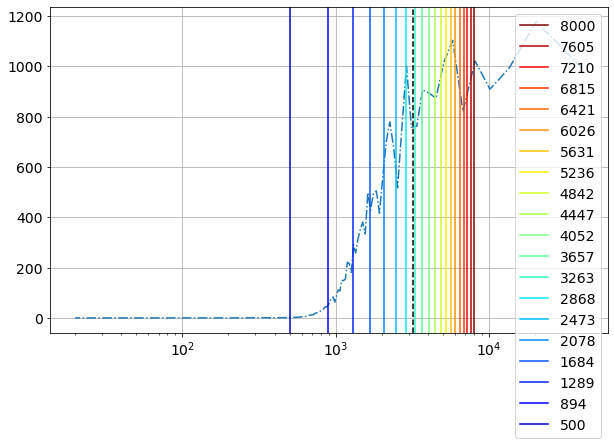

In [27]:
print('Lp = 9.81/np.pi*T0**2 =',Lp)
print('sx = kp*0.1 = ',sx)
print('lim = 2*np.pi / (3*sx) = ',2*np.pi / (3*sx))
plt.plot(2*np.pi/kx,Spec_env1_from_2D_shifted,'-.')

oldLLs = np.flip(np.linspace(1000,2*np.pi / (2*sx),6))
# LLs 
# for LL in oldLLs:
#     plt.axvline(2*np.pi/(LL),color=plt.cm.jet(LL/oldLLs.max()),linestyle='--',label=np.floor(LL))
for LL in LLs:
    plt.axvline((LL),color=plt.cm.jet(LL/LLs.max()),linestyle='-',label=int(np.floor(LL)))

plt.axvline(2*np.pi/sx,color='k',linestyle='--')
print('2*pi / sx : ',2*np.pi/sx)
# plt.axvline(2.5*sx,color='k',linestyle='-.')
# plt.axvline(3*sx,color='k',linestyle=':',linewidth=3)
_=plt.legend()
_=plt.xscale('log')

print('LL = ',LLs[-5],' x = ',2*np.pi/(LLs[-5]*sx))
print('LL = ',LLs[-4],' x = ',2*np.pi/(LLs[-4]*sx))
nxsx = 0.5*((2*np.pi/(LLs[-5]*sx)) + (2*np.pi/(LLs[-4]*sx)))
print('mean x = ',nxsx)
# plt.axvline(nxsx*sx,color='k',linestyle='-.')
# plt.axvline(3*sx,color='k',linestyle=':',linewidth=3)

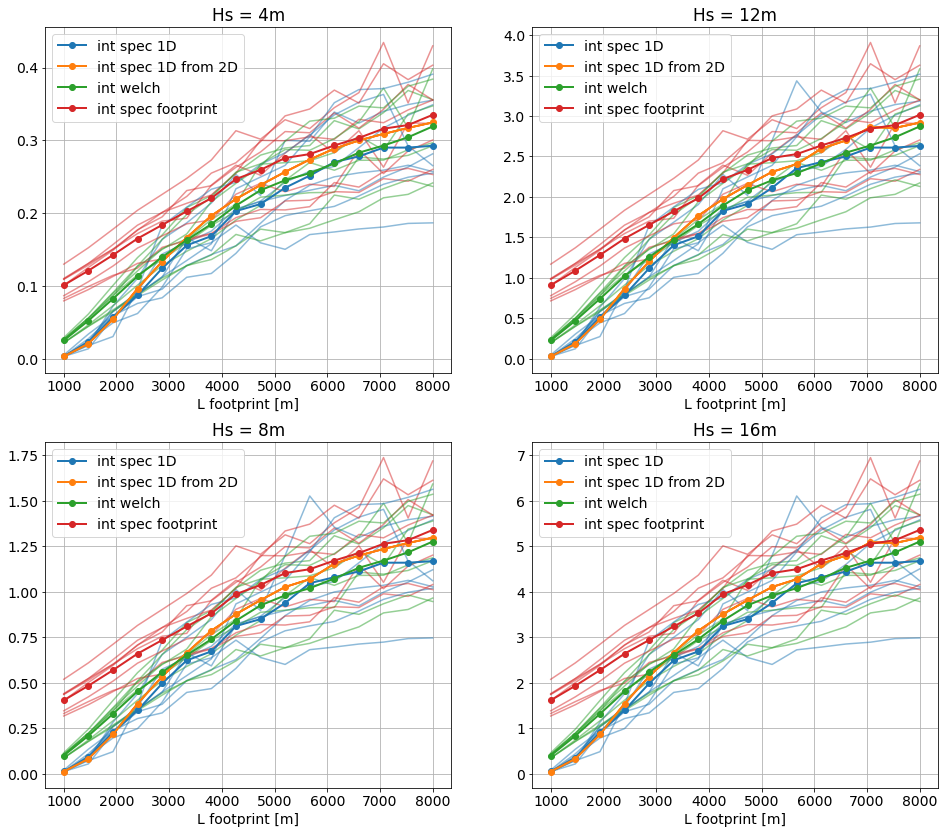

In [25]:
fig,axs = plt.subplots(2,2,figsize=(16,14))
for ihs in range(4):
    for isee in range(nseed):
        if isee==0:
            cl1, =axs[ihs%2,ihs//2].plot(LLs,var_env_above[:,ihs,isee],'-',alpha=0.5)
            cl2, =axs[ihs%2,ihs//2].plot(LLs,var_env_2D_above[:,ihs,isee],'-',alpha=0.5)
            cl3, =axs[ihs%2,ihs//2].plot(LLs,var_env_welch[:,ihs,isee],'-',alpha=0.5)
            cl4, =axs[ihs%2,ihs//2].plot(LLs,var_env_footspec[:,ihs,isee],'-',alpha=0.5)
        else:
            axs[ihs%2,ihs//2].plot(LLs,var_env_above[:,ihs,isee],'-',alpha=0.5,color=cl1.get_color())
            axs[ihs%2,ihs//2].plot(LLs,var_env_2D_above[:,ihs,isee],'-',alpha=0.5,color=cl2.get_color())
            axs[ihs%2,ihs//2].plot(LLs,var_env_welch[:,ihs,isee],'-',alpha=0.5,color=cl3.get_color())
            axs[ihs%2,ihs//2].plot(LLs,var_env_footspec[:,ihs,isee],'-',alpha=0.5,color=cl4.get_color())
    
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_above[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl1.get_color(),alpha=1,label='int spec 1D')
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_2D_above[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl2.get_color(),alpha=1,label='int spec 1D from 2D')
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_welch[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl3.get_color(),alpha=1,label='int welch')
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_footspec[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl4.get_color(),alpha=1,label='int spec footprint')
    axs[ihs%2,ihs//2].legend()
    axs[ihs%2,ihs//2].set_xlabel('L footprint [m]')
    axs[ihs%2,ihs//2].set_title('Hs = '+str(Hss[ihs])+'m')

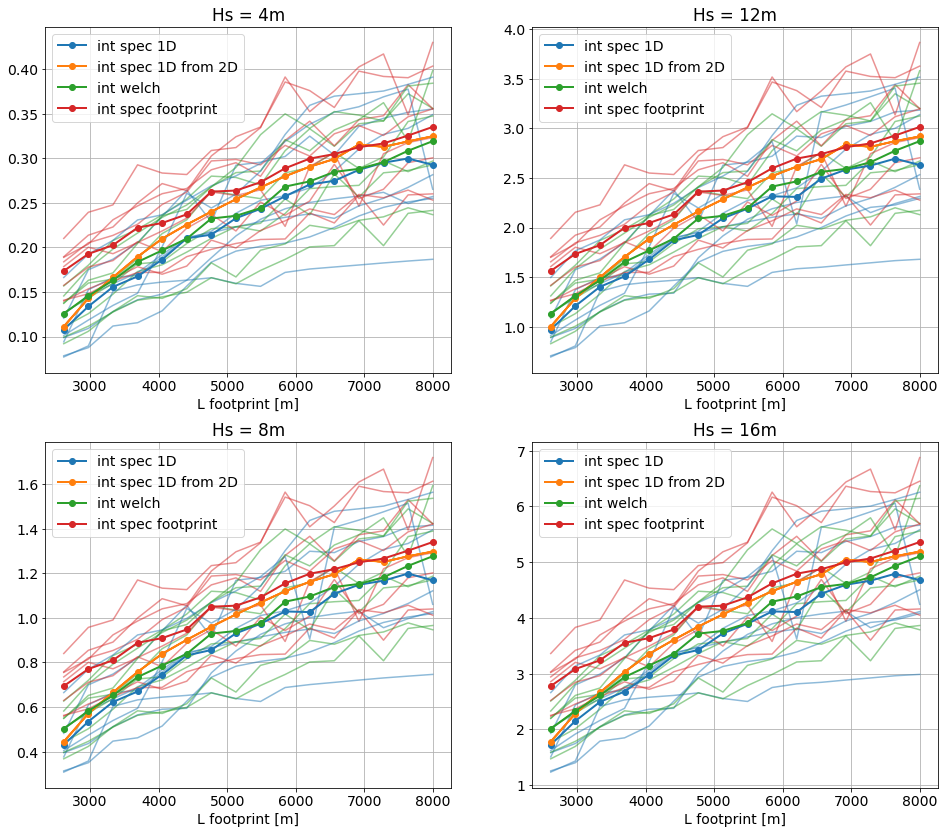

In [111]:
fig,axs = plt.subplots(2,2,figsize=(16,14))
for ihs in range(4):
    for isee in range(nseed):
        if isee==0:
            cl1, =axs[ihs%2,ihs//2].plot(LLs,var_env_above[:,ihs,isee],'-',alpha=0.5)
            cl2, =axs[ihs%2,ihs//2].plot(LLs,var_env_2D_above[:,ihs,isee],'-',alpha=0.5)
            cl3, =axs[ihs%2,ihs//2].plot(LLs,var_env_welch[:,ihs,isee],'-',alpha=0.5)
            cl4, =axs[ihs%2,ihs//2].plot(LLs,var_env_footspec[:,ihs,isee],'-',alpha=0.5)
        else:
            axs[ihs%2,ihs//2].plot(LLs,var_env_above[:,ihs,isee],'-',alpha=0.5,color=cl1.get_color())
            axs[ihs%2,ihs//2].plot(LLs,var_env_2D_above[:,ihs,isee],'-',alpha=0.5,color=cl2.get_color())
            axs[ihs%2,ihs//2].plot(LLs,var_env_welch[:,ihs,isee],'-',alpha=0.5,color=cl3.get_color())
            axs[ihs%2,ihs//2].plot(LLs,var_env_footspec[:,ihs,isee],'-',alpha=0.5,color=cl4.get_color())
    
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_above[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl1.get_color(),alpha=1,label='int spec 1D')
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_2D_above[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl2.get_color(),alpha=1,label='int spec 1D from 2D')
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_welch[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl3.get_color(),alpha=1,label='int welch')
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_footspec[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl4.get_color(),alpha=1,label='int spec footprint')
    axs[ihs%2,ihs//2].legend()
    axs[ihs%2,ihs//2].set_xlabel('L footprint [m]')
    axs[ihs%2,ihs//2].set_title('Hs = '+str(Hss[ihs])+'m')

In [13]:
# nLL = 6
# LLs=np.flip(np.linspace(1000,8000,nLL))
nxA = nx
#     nxtile = int(nxA//Ntiles)
# nLL=20
# LLs=np.flip(np.linspace(500,8000,nLL))
# nxtile = int(LLs.min()//dx)
# Ntiles = int(nx//nxtile)
# Ntiles_overlap = 2*(nx//(LLs.min()//dx))-1

coeff_LL = np.zeros(nLL)
Nts = np.zeros(nLL,dtype=np.int)
for il,LL in enumerate(LLs):
    nxtile = int(LL//dx)
    Ntiles = int(nxA//nxtile)
    shx = int(nxtile//2)
    Ntiles_overlap = 2*Ntiles-1
    Nts[il] = int(Ntiles_overlap)
    coeff_LL[il] = (0.0799*LL+347)/nxtile
    print('Nb of tiles : ',Ntiles_overlap,' , size of tile (pixel) : ',nxtile)

Nb of tiles :  9  , size of tile (pixel) :  800
Nb of tiles :  9  , size of tile (pixel) :  760
Nb of tiles :  9  , size of tile (pixel) :  721
Nb of tiles :  9  , size of tile (pixel) :  681
Nb of tiles :  11  , size of tile (pixel) :  642
Nb of tiles :  11  , size of tile (pixel) :  602
Nb of tiles :  13  , size of tile (pixel) :  563
Nb of tiles :  13  , size of tile (pixel) :  523
Nb of tiles :  15  , size of tile (pixel) :  484
Nb of tiles :  17  , size of tile (pixel) :  444
Nb of tiles :  17  , size of tile (pixel) :  405
Nb of tiles :  21  , size of tile (pixel) :  365
Nb of tiles :  23  , size of tile (pixel) :  326
Nb of tiles :  27  , size of tile (pixel) :  286
Nb of tiles :  31  , size of tile (pixel) :  247
Nb of tiles :  37  , size of tile (pixel) :  207
Nb of tiles :  47  , size of tile (pixel) :  168
Nb of tiles :  61  , size of tile (pixel) :  128
Nb of tiles :  89  , size of tile (pixel) :  89
Nb of tiles :  159  , size of tile (pixel) :  50


In [139]:
sx0s = np.linspace(0.08,0.15,10)
T0s = np.arange(6,18)
limL = np.zeros((len(sx0s),len(T0s)))
limL2 = np.zeros((len(sx0s),len(T0s)))

for isx,sx0 in enumerate(sx0s):
    for it,T0 in enumerate(T0s):
        Lp=9.81/np.pi*T0**2;
        kp=2*np.pi/Lp;
        sx = kp*sx0
        limL[isx,it]=2*np.pi / (3*sx)
        limL2[isx,it]=2*np.pi / (0.5*sx)

ind=np.unravel_index(np.argmax(limL),np.shape(limL))
print(ind)
print(np.min(limL))
print(np.max(limL))
print('-----------------------------------')
print(np.min(limL2))
print(np.max(limL2))
# plt.pcolormesh(sx0s,T0s,limL.T)

(0, 11)
249.809598677039
3760.1548967533463
-----------------------------------
1498.8575920622338
22560.92938052008


In [154]:
print(8192*5)
iss = np.arange(8,13.5,0.25)
for i in iss:
    print((2**i))
    print(int(2**i))

40960
256.0
256
304.4370214406966
304
362.03867196751236
362
430.5389646099018
430
512.0
512
608.8740428813932
608
724.0773439350247
724
861.0779292198037
861
1024.0
1024
1217.7480857627863
1217
1448.1546878700494
1448
1722.1558584396073
1722
2048.0
2048
2435.4961715255727
2435
2896.309375740099
2896
3444.3117168792146
3444
4096.0
4096
4870.992343051145
4870
5792.618751480198
5792
6888.623433758429
6888
8192.0
8192
9741.98468610229
9741
11585.237502960395
11585


In [14]:
# --- compute integrals of interest ------------
int_func_0_kc = np.zeros((nLL,nHs,nseed))
int_func_tot = np.zeros((nLL,nHs,nseed))
int_func_kc_end = np.zeros((nLL,nHs,nseed))
kmin = np.min(kx[kx>0])
for ih,Hs in enumerate(Hss):
    funcs = spec_funcs[ih]
    for isee in range(nseed):
        func_spec = funcs[isee]
        for il,LL in enumerate(LLs):
            kc = 2*np.pi/(LL)
            int_func_0_kc[il,ih,isee] = spint.quad(func_spec,-kc,-kmin)[0]+spint.quad(func_spec,kmin,kc)[0]
            int_func_kc_end[il,ih,isee] = spint.quad(func_spec,kc,kx.max())[0] + spint.quad(func_spec,kx.min(),-kc)[0]
            int_func_tot[il,ih,isee] = spint.quad(func_spec,kx.min(),-kmin)[0]+spint.quad(func_spec,kmin,kx.max())[0]

In [45]:
int_func_0_kc = int_func_0_kc/dkx
int_func_kc_end = int_func_kc_end/dkx
int_func_tot = int_func_tot/dkx

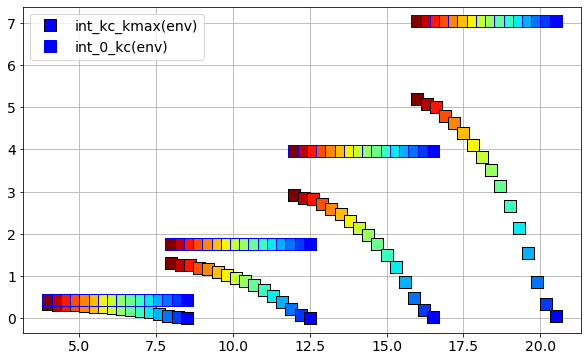

In [46]:
for ill,LL in enumerate(LLs):
    A2 = np.zeros((nHs,nseed))
    B2 = np.zeros((nHs,nseed))
#     print(Nts[ill])
    for isee in range(nseed):
        cl3=plt.plot(Hss+0.3*ill,int_func_kc_end[ill,:,isee],'s',color=plt.cm.jet(LL/LLs[0]),
                     markersize=12,markeredgecolor='k')
        cl4=plt.plot(Hss+0.3*ill,int_func_tot[ill,:,isee],'s',color=plt.cm.jet(LL/LLs[0]),
                     markersize=12,markeredgecolor='b')
    if ill==nLL-1:
        cl3[0].set_label('int_kc_kmax(env)')
        cl4[0].set_label('int_0_kc(env)')
plt.legend()

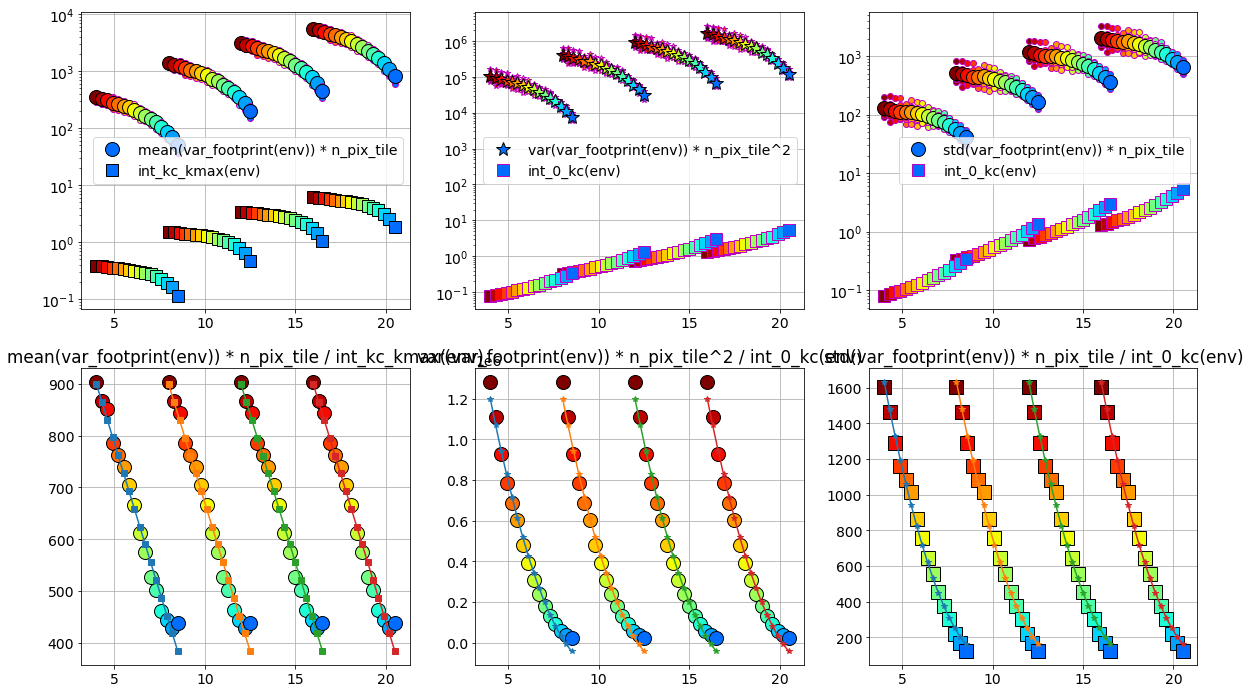

In [33]:
fig,axs=plt.subplots(2,3,figsize=(20,12))

C = np.zeros((nHs,nLL))
D = np.zeros((nHs,nLL))
DD = np.zeros((nHs,nLL))
for ill,LL in enumerate(LLs):
    A2 = np.zeros((nHs,nseed))
    B2 = np.zeros((nHs,nseed))
    BB2 = np.zeros((nHs,nseed))
    
#     print(Nts[ill])
    for isee in range(nseed):
#         A0 = env_var_disk_vec[ill,:,isee,:Nts[ill]]
        A = np.mean((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1)
        B = np.sqrt(np.var((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1))
        BB = np.std((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1)
        A2[:,isee]=A
        B2[:,isee]=B
        BB2[:,isee]=BB
#         cl0=axs[0].plot(Hss+0.3*ill,A0,'o',alpha=0.5,color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k')
        _=axs[0,0].plot(Hss+0.3*ill,A*(int(LL//dx)),'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m')
        
        _=axs[0,1].plot(Hss+0.3*ill,B*(int(LL//dx))**2,'*',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m')
        _=axs[0,2].plot(Hss+0.3*ill,BB*(int(LL//dx)),'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m')
    
    # --- mean over nseed -------------------
    A3=np.mean(A2,axis=1)*(int(LL//dx))
    B3=np.mean(B2,axis=1)*(int(LL//dx))**2
    BB3=np.mean(BB2,axis=1)*(int(LL//dx))
    
    C3 = np.mean(int_func_kc_end[ill,:,:],axis=-1)
    D3 = np.mean(int_func_0_kc[ill,:,:],axis=-1)
    C[:,ill] = A3/C3
    D[:,ill] = B3/D3
    DD[:,ill] = BB3/D3
    
    cl1=axs[0,0].plot(Hss+0.3*ill,A3,'o',color=plt.cm.jet(LL/LLs[0]),
                    markeredgecolor='k',markersize=14,zorder=2)
    cl3=axs[0,0].plot(Hss+0.3*ill,C3,'s',color=plt.cm.jet(LL/LLs[0]),
                     markersize=12,markeredgecolor='k',zorder=100)
    
    cl2=axs[0,1].plot(Hss+0.3*ill,B3,'*',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)
    cl22=axs[0,2].plot(Hss+0.3*ill,BB3,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)
    cl4=axs[0,1].plot(Hss+0.3*ill,D3,'s',color=plt.cm.jet(LL/LLs[0]),
                     markersize=12,markeredgecolor='m')
    cl44=axs[0,2].plot(Hss+0.3*ill,D3,'s',color=plt.cm.jet(LL/LLs[0]),
                     markersize=12,markeredgecolor='m')
    
    cl5=axs[1,0].plot(Hss+0.3*ill,A3/C3,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)
    cl6=axs[1,1].plot(Hss+0.3*ill,B3/D3,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)
    cl66=axs[1,2].plot(Hss+0.3*ill,BB3/D3,'s',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)
    
    if ill==nLL-1:
        cl1[0].set_label('mean(var_footprint(env)) * n_pix_tile')
        cl2[0].set_label('var(var_footprint(env)) * n_pix_tile^2')
        cl22[0].set_label('std(var_footprint(env)) * n_pix_tile')
        cl3[0].set_label('int_kc_kmax(env)')
        cl4[0].set_label('int_0_kc(env)')#' / int_kc_kmax(env)')
        cl44[0].set_label('int_0_kc(env)')#' / int_kc_kmax(env)')
        axs[1,0].set_title('mean(var_footprint(env)) * n_pix_tile / int_kc_kmax(env)')
        axs[1,1].set_title('var(var_footprint(env)) * n_pix_tile^2 / int_0_kc(env)')
        axs[1,2].set_title('std(var_footprint(env)) * n_pix_tile / int_0_kc(env)')
        
axs[0,0].legend()
axs[0,0].set_yscale('log')
axs[0,1].set_yscale('log')
axs[0,2].set_yscale('log')
axs[0,1].legend()
# axs[1,1].legend()
# axs[1,0].legend()
# axs[1,2].legend()
axs[0,2].legend()
# axs[1,1].set_yscale('log')

nxtiles = (LLs//dx)
ntypes=4
slopes = np.zeros((ntypes,nHs))
intercepts = np.zeros((ntypes,nHs))
for ih,Hs in enumerate(Hss):
    res1 = stats.linregress((LLs[:]),C[ih,:])
#     print('A3/C3 =>   Hs = ',Hs,'  : slope = ',res1.slope,' and intercept = ',res1.intercept)
    y1 = res1.slope*(LLs)+res1.intercept
    slopes[0,ih]=res1.slope
    intercepts[0,ih]=res1.intercept
    _=axs[1,0].plot(Hs+0.3*np.arange(nLL),y1,'s-')
        
    res2 = stats.linregress(LLs[:],D[ih,:])
    slopes[1,ih]=res2.slope
    intercepts[1,ih]=res2.intercept
# #     print('B3/D3 =>   Hs = ',Hs,'  : slope = ',res2.slope,' and intercept = ',res2.intercept)
#     y2 = res2.slope*LLs+res2.intercept
#     _=axs[1,1].plot(Hs+0.3*np.arange(nLL),y2,'s-')
    
    res2 = stats.linregress(LLs[:]**2,D[ih,:])
    slopes[2,ih]=res2.slope
    intercepts[2,ih]=res2.intercept
#     print('B3/D3 =>   Hs = ',Hs,'  : slope = ',res2.slope,' and intercept = ',res2.intercept)
    y2 = res2.slope*LLs**2+res2.intercept
    _=axs[1,1].plot(Hs+0.3*np.arange(nLL),y2,'*-')
    
    res22 = stats.linregress(LLs[:]**2,DD[ih,:])
    slopes[3,ih]=res22.slope
    intercepts[3,ih]=res22.intercept
    y22 = res22.slope*LLs**2+res22.intercept
    _=axs[1,2].plot(Hs+0.3*np.arange(nLL),y22,'*-')


# ## ---------- check ---------
# fig,axs=plt.subplots(1,2,figsize=(20,8))
# C = np.zeros((nHs,nLL))
# D = np.zeros((nHs,nLL))
# for ill,LL in enumerate(LLs):
#     A2 = np.zeros((nHs,nseed))
#     B2 = np.zeros((nHs,nseed))
# #     for ill,LL in enumerate(LLs):
#     for isee in range(nseed):
#         A = np.mean((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1)
#         B = np.std((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1)
#         A2[:,isee]=A
#         B2[:,isee]=B
#     A30=np.mean(A2,axis=1)
#     A3=np.mean(A2,axis=1)*(int(LL//dx))
#     B3=np.mean(B2,axis=1)*(int(LL//dx))
#     C3 = np.mean(int_func_kc_end[ill,:,:],axis=-1)#/int_func_tot[ill,:,:],axis=-1)#
#     C4 = np.mean(int_func_0_kc[ill,:,:],axis=-1)#/int_func_tot[ill,:,:],axis=-1)#

#     C[:,ill] = A3/C3
#     D[:,ill] = B3/C4
#     _=axs[0].plot(Hss+0.3*ill,A3/C3,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)
#     _=axs[1].plot(Hss+0.3*ill,B3/C4,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)
    
#     if ill<len(LLs)-4:
#         _=axs[0].plot(Hss+0.3*ill,A3/C3,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m',markersize=14)
# #     res = stats.linregress(np.sqrt(Hs_stds_2[:,ihs]), np.sqrt(Hs2_estimated_std[:,ihs]))
# #     slope[ihs]=res.slope
# #     inter[ihs]=res.intercept
# #     _=plt.plot(LLs+30*ih,A3-C3,'*',color=plt.cm.jet(Hs/Hss[-1]),markeredgecolor='k',markersize=14)
# #     plt.yscale('log')
# for ih,Hs in enumerate(Hss):
#     res = stats.linregress(LLs[:],C[ih,:])
#     print('Hs = ',Hs,'  : slope = ',res.slope,' and intercept = ',res.intercept)
#     y = res.slope*LLs+res.intercept
#     _=axs[0].plot(Hs+0.3*np.arange(nLL),y,'*-')
# #     _=plt.yscale('log')
# #     _=plt.plot(Hss+0.1*ill,np.mean(B2,axis=1),'*',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)

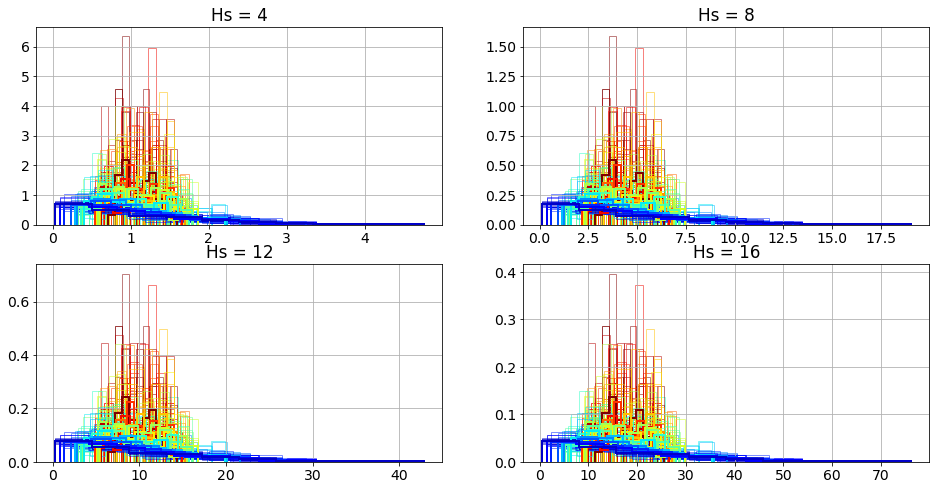

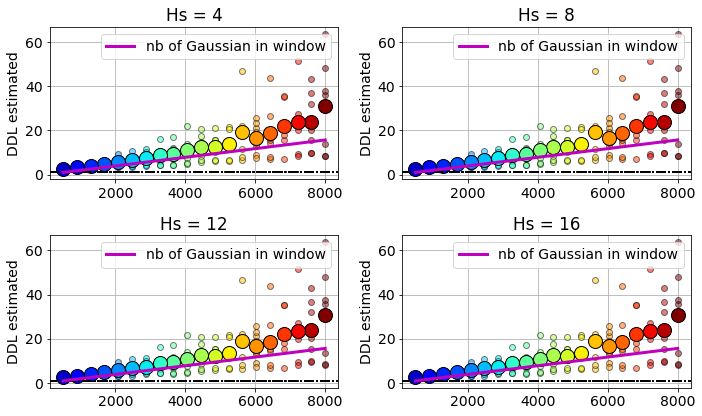

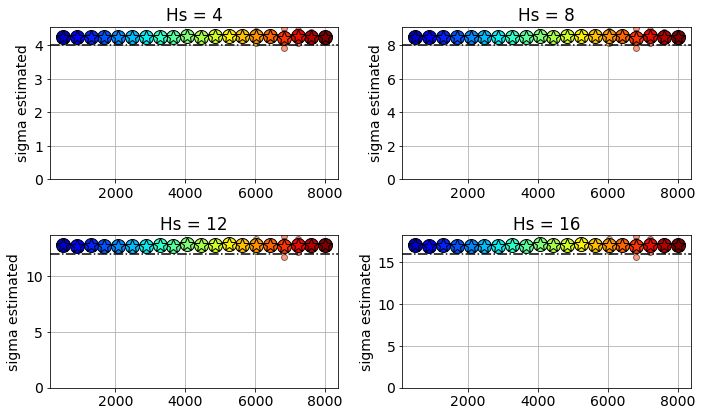

In [62]:
fig,axs=plt.subplots(2,2,figsize=(16,8))

var_chi2 = np.zeros((nHs,nLL,nseed))
mean_chi2 = np.zeros((nHs,nLL,nseed))
ddl_chi2 = np.zeros((nHs,nLL,nseed))
sigma_chi2 = np.zeros((nHs,nLL,nseed))
sigma_norm = np.zeros((nHs,nLL,nseed))
for ih,Hs in enumerate(Hss):
    for ill,LL in enumerate(LLs):
        for isee in range(nseed):
            A = np.squeeze(Hs_footprints_disk_2_vec[ill,ih,isee,:Nts[ill]])#*(LL)/(LL-1)
            var_chi20 = np.var(A)
            mean_chi20 = np.mean(A)
            ddl0 = 2*(mean_chi20**2/var_chi20)
            
            var_chi2[ih,ill,isee] = var_chi20
            mean_chi2[ih,ill,isee] = mean_chi20
            ddl_chi2[ih,ill,isee] = ddl0
            sigma_chi2[ih,ill,isee] = (var_chi20*ddl0/2)**(1/4)#*(ddl0)/(ddl0-1)
            sigma_norm[ih,ill,isee] = (mean_chi20)**(1/2)#*(ddl0)/(ddl0-1)
            
            if isee == 0:
                nA,bins,_=axs[ih//2,ih%2].hist(A,density=True,histtype='step',
                                              color=plt.cm.jet(LL/LLs[0]),alpha=0.5,zorder=0)
            else:
                nA0,bins,_=axs[ih//2,ih%2].hist(A,bins=bins,density=True,histtype='step',
                                              color=plt.cm.jet(LL/LLs[0]),alpha=0.5,zorder=1)
                nA = nA + nA0
            
        _=axs[ih//2,ih%2].hist(bins[:-1],bins,weights=nA/nseed,histtype='step',
                                              color=plt.cm.jet(LL/LLs[0]),linewidth=2,zorder=10)
    axs[ih//2,ih%2].set_title('Hs = '+str(Hs))    

sz_gaussienne_r = 1/sx
nb_ddl_gaussienne = LLs/sz_gaussienne_r

fig,axs=plt.subplots(2,2)

for ih,Hs in enumerate(Hss):
    for ill,LL in enumerate(LLs):
        for isee in range(nseed):   
            A = ddl_chi2[ih,ill,isee]
            _=axs[ih//2,ih%2].plot(LL,A,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',alpha=0.5)
        _=axs[ih//2,ih%2].plot(LL,np.mean(ddl_chi2[ih,ill,:],axis=-1),'o',color=plt.cm.jet(LL/LLs[0]),
                   markeredgecolor='k',markersize=14)
        _=axs[ih//2,ih%2].set_ylabel('DDL estimated')
        _=axs[ih//2,ih%2].axhline(1,color='k',linestyle='-.')
#         _=plt.axhline
    _=axs[ih//2,ih%2].plot(LLs,nb_ddl_gaussienne,color='m',linestyle='-',linewidth=3,label='nb of Gaussian in window')
    axs[ih//2,ih%2].set_title('Hs = '+str(Hs))
    _=axs[ih//2,ih%2].legend()
plt.tight_layout()

fig,axs=plt.subplots(2,2)

for ih,Hs in enumerate(Hss):
    for ill,LL in enumerate(LLs):
        for isee in range(nseed):   
            A = sigma_norm[ih,ill,isee]
            _=axs[ih//2,ih%2].plot(LL,4*A,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',alpha=0.5)
        _=axs[ih//2,ih%2].plot(LL,np.mean(4*sigma_norm[ih,ill,:],axis=-1),'o',color=plt.cm.jet(LL/LLs[0]),
                   markeredgecolor='k',markersize=14)
        _=axs[ih//2,ih%2].plot(LL,np.mean(4*sigma_chi2[ih,ill,:],axis=-1),'*',color=plt.cm.jet(LL/LLs[0]),
                   markeredgecolor='k',markersize=14)
        _=axs[ih//2,ih%2].set_ylabel('sigma estimated')
    _=axs[ih//2,ih%2].axhline(Hs,color='k',linestyle='-.')

    axs[ih//2,ih%2].set_title('Hs = '+str(Hs)) 
    axs[ih//2,ih%2].set_ylim((0,None))
plt.tight_layout()
#             A = np.mean((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1)
#             B = np.sqrt(np.var((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1))

In [37]:
np.sqrt(13)

3.605551275463989

In [ ]:
np.sqrt()

Hs =  4   : slope =  0.07995857904991009  and intercept =  347.1526216214478
Hs =  8   : slope =  0.07995534629866351  and intercept =  347.1771633497528
Hs =  12   : slope =  0.07995795919609124  and intercept =  347.1661501443251
Hs =  16   : slope =  0.0799517229802867  and intercept =  347.1831293240812


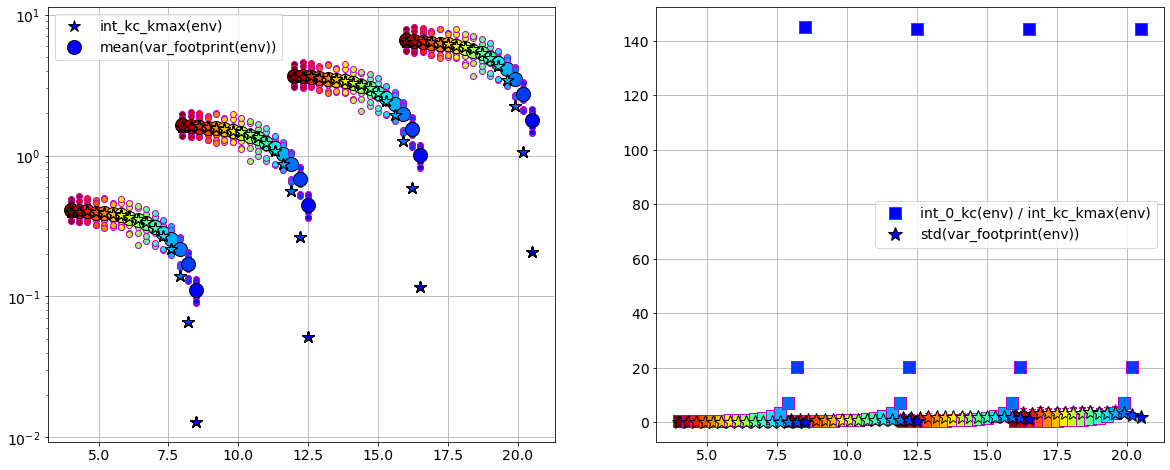

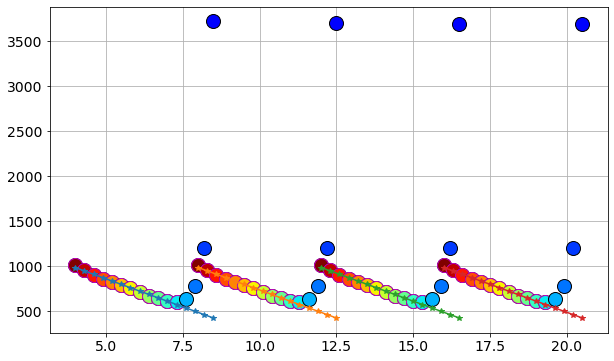

In [93]:
fig,axs=plt.subplots(1,2,figsize=(20,8))
for ill,LL in enumerate(LLs):
    A2 = np.zeros((nHs,nseed))
    B2 = np.zeros((nHs,nseed))
#     print(Nts[ill])
    for isee in range(nseed):
        A0 = env_var_disk_vec[ill,:,isee,:Nts[ill]]
        A = np.mean((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1)
        B = np.std((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1)
        A2[:,isee]=A
        B2[:,isee]=B
#         cl0=axs[0].plot(Hss+0.3*ill,A0,'o',alpha=0.5,color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k')
        cl1=axs[0].plot(Hss+0.3*ill,A,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m')
        cl3=axs[0].plot(Hss+0.3*ill,int_func_kc_end[ill,:,isee]*(0.0799*LL+347)/(int(LL//dx)),'*',color=plt.cm.jet(LL/LLs[0]),
                     markersize=12,markeredgecolor='k',zorder=100)
        
        cl2=axs[1].plot(Hss+0.3*ill,B,'*',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m')
        cl4=axs[1].plot(Hss+0.3*ill,int_func_0_kc[ill,:,isee]/int_func_kc_end[ill,:,isee],'s',color=plt.cm.jet(LL/LLs[0]),
                     markersize=12,markeredgecolor='m')
#         cl4=plt.plot(Hss+0.3*ill,int_func_tot[ill,:,isee],'s',color=plt.cm.jet(LL/LLs[0]),
#                      markersize=12,markeredgecolor='b')
    cl1=axs[0].plot(Hss+0.3*ill,np.mean(A2,axis=1),'o',color=plt.cm.jet(LL/LLs[0]),
                    markeredgecolor='k',markersize=14,zorder=2)
    cl2=axs[1].plot(Hss+0.3*ill,np.mean(B2,axis=1),'*',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)
    if ill==nLL-1:
        cl1[0].set_label('mean(var_footprint(env))')
        cl2[0].set_label('std(var_footprint(env))')
        cl3[0].set_label('int_kc_kmax(env)')
        cl4[0].set_label('int_0_kc(env) / int_kc_kmax(env)')
axs[0].legend()
axs[0].set_yscale('log')
axs[1].legend()
       
plt.figure()
C = np.zeros((nHs,nLL))
for ill,LL in enumerate(LLs):
    A2 = np.zeros((nHs,nseed))
    B2 = np.zeros((nHs,nseed))
#     for ill,LL in enumerate(LLs):
    for isee in range(nseed):
        A = np.mean((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1)
        B = np.std((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1)
        A2[:,isee]=A
        B2[:,isee]=B
#         _=plt.plot(Hss+0.1*ill,A,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m')
#         _=plt.plot(Hss+0.1*ill,B,'*',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m')
#         _=plt.plot(Hss+0.1*ill,var_env_2D_above[ill,:,isee],'s',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k')
    A30=np.mean(A2,axis=1)
    A3=np.mean(A2,axis=1)*(int(LL//dx))
    B3=np.mean(B2,axis=1)
    C3 = np.mean(int_func_kc_end[ill,:,:],axis=-1)#/int_func_tot[ill,:,:],axis=-1)#
    C[:,ill] = A3/C3
    _=plt.plot(Hss+0.3*ill,A3/C3,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)
    if ill<len(LLs)-4:
        _=plt.plot(Hss+0.3*ill,A3/C3,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m',markersize=14)
#     res = stats.linregress(np.sqrt(Hs_stds_2[:,ihs]), np.sqrt(Hs2_estimated_std[:,ihs]))
#     slope[ihs]=res.slope
#     inter[ihs]=res.intercept
#     _=plt.plot(LLs+30*ih,A3-C3,'*',color=plt.cm.jet(Hs/Hss[-1]),markeredgecolor='k',markersize=14)
#     plt.yscale('log')
for ih,Hs in enumerate(Hss):
    res = stats.linregress(LLs[:-4],C[ih,:-4])
    print('Hs = ',Hs,'  : slope = ',res.slope,' and intercept = ',res.intercept)
    y = res.slope*LLs+res.intercept
    _=plt.plot(Hs+0.3*np.arange(nLL),y,'*-')
#     _=plt.yscale('log')
#     _=plt.plot(Hss+0.1*ill,np.mean(B2,axis=1),'*',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)

In [109]:
print('1/dkx = ',1/dkx)
print('dkx = ',dkx)
print('dx = ',dx)
print('Lp = ',Lp)
print('kp = ',kp)
print('sx = ',sx)#0.0799)

1/dkx =  6442.592096359485
dkx =  0.00015521702833942721
dx =  10
Lp =  449.6572776186701
kp =  0.01397327613700498
sx =  0.017488455740932392


In [53]:
plt.figure()
for ill,LL in enumerate(LLs):
    A2 = np.zeros((nHs,nseed))
    B2 = np.zeros((nHs,nseed))
    for isee in range(nseed):
        A = np.std(np.sqrt(np.squeeze(Hs_footprints_disk_2_vec[ill,:,isee,:Nts[ill]])),axis=-1)
        B0 = 2*np.sqrt(8*(env_means_disk_vec[ill,:,isee,:Nts[ill]]**2+env_var_disk_vec[ill,:,isee,:Nts[ill]]))
        B = np.std(B0,axis=-1)
        A2[:,isee]=A
        B2[:,isee]=B
#         C0 = 
#         C1 = 
#         C = 8*(C0 + C1)
        _=plt.plot(Hss+0.3*ill,A,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m')
        _=plt.plot(Hss+0.3*ill,B,'*',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m')      
        
    cl=plt.plot(Hss+0.3*ill,np.mean(A2,axis=1),'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)
    cl2=plt.plot(Hss+0.3*ill,np.mean(B2,axis=1),'*',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14) 
    if ill==nLL-1:
        cl[0].set_label('std(Hs_footprint)')
        cl2[0].set_label('std(2*sqrt(8*(<env>^2 + <env^2>)))')
_=plt.legend()
# Hs_footprints_disk_2_vec
# env_means_disk_vec
# env_var_disk_vec

AttributeError: 'Figure' object has no property 'figsze'

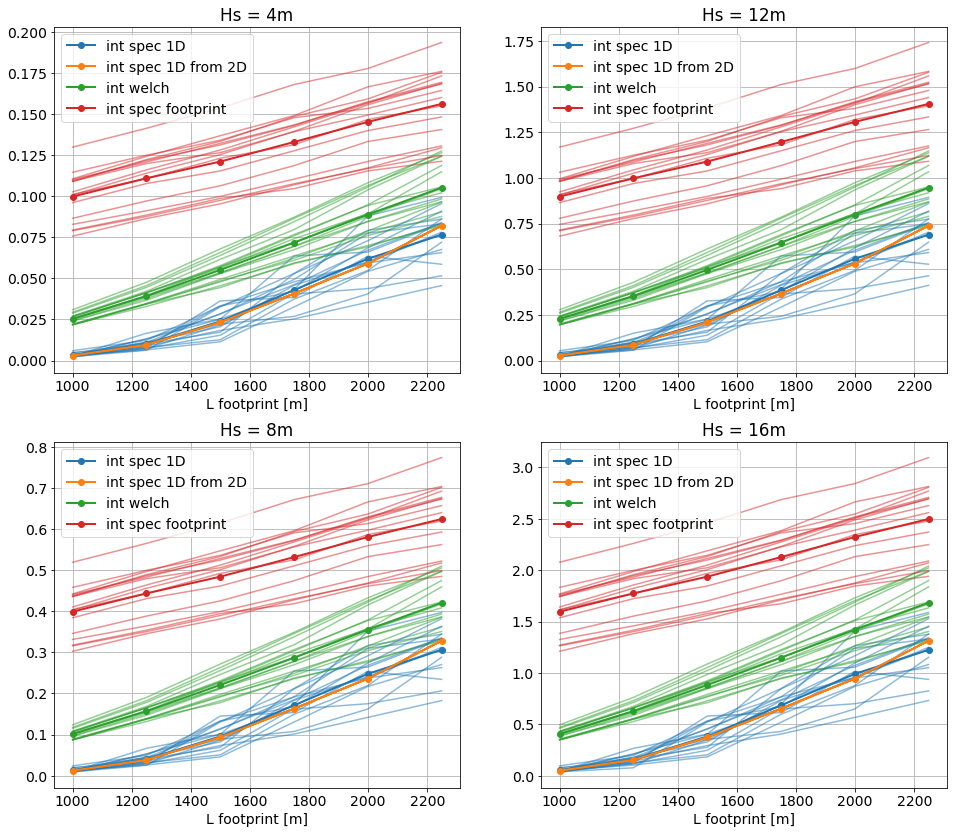

In [119]:
# OLD 
fig,axs = plt.subplots(2,2,figsize=(16,14))
for ihs in range(4):
    for isee in range(nseed):
        if isee==0:
            cl1, =axs[ihs%2,ihs//2].plot(LLs,var_env_above[:,ihs,isee],'-',alpha=0.5)
            cl2, =axs[ihs%2,ihs//2].plot(LLs,var_env_2D_above[:,ihs,isee],'-',alpha=0.5)
            cl3, =axs[ihs%2,ihs//2].plot(LLs,var_env_welch[:,ihs,isee],'-',alpha=0.5)
            cl4, =axs[ihs%2,ihs//2].plot(LLs,var_env_footspec[:,ihs,isee],'-',alpha=0.5)
        else:
            axs[ihs%2,ihs//2].plot(LLs,var_env_above[:,ihs,isee],'-',alpha=0.5,color=cl1.get_color())
            axs[ihs%2,ihs//2].plot(LLs,var_env_2D_above[:,ihs,isee],'-',alpha=0.5,color=cl2.get_color())
            axs[ihs%2,ihs//2].plot(LLs,var_env_welch[:,ihs,isee],'-',alpha=0.5,color=cl3.get_color())
            axs[ihs%2,ihs//2].plot(LLs,var_env_footspec[:,ihs,isee],'-',alpha=0.5,color=cl4.get_color())
    
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_above[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl1.get_color(),alpha=1,label='int spec 1D')
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_2D_above[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl2.get_color(),alpha=1,label='int spec 1D from 2D')
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_welch[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl3.get_color(),alpha=1,label='int welch')
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_footspec[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl4.get_color(),alpha=1,label='int spec footprint')
    axs[ihs%2,ihs//2].legend()
    axs[ihs%2,ihs//2].set_xlabel('L footprint [m]')
    axs[ihs%2,ihs//2].set_title('Hs = '+str(Hss[ihs])+'m')

In [ ]:
print('dkx spec = ',dkxspec)
print('dkx welch = ',(freq_welch[1]-freq_welch[0]))
print(kx)
print(freq_welch)
print(freq_footprint_mkmax_kmax[freq_footprint_mkmax_kmax>=0])



In [16]:
np.fft.fftfreq(Ntiles, d=dx)*2*np.pi

array([ 0.        ,  0.0079534 ,  0.0159068 ,  0.0238602 ,  0.0318136 ,
        0.039767  ,  0.04772039,  0.05567379,  0.06362719,  0.07158059,
        0.07953399,  0.08748739,  0.09544079,  0.10339419,  0.11134759,
        0.11930099,  0.12725439,  0.13520779,  0.14316118,  0.15111458,
        0.15906798,  0.16702138,  0.17497478,  0.18292818,  0.19088158,
        0.19883498,  0.20678838,  0.21474178,  0.22269518,  0.23064857,
        0.23860197,  0.24655537,  0.25450877,  0.26246217,  0.27041557,
        0.27836897,  0.28632237,  0.29427577,  0.30222917,  0.31018257,
       -0.31018257, -0.30222917, -0.29427577, -0.28632237, -0.27836897,
       -0.27041557, -0.26246217, -0.25450877, -0.24655537, -0.23860197,
       -0.23064857, -0.22269518, -0.21474178, -0.20678838, -0.19883498,
       -0.19088158, -0.18292818, -0.17497478, -0.16702138, -0.15906798,
       -0.15111458, -0.14316118, -0.13520779, -0.12725439, -0.11930099,
       -0.11134759, -0.10339419, -0.09544079, -0.08748739, -0.07

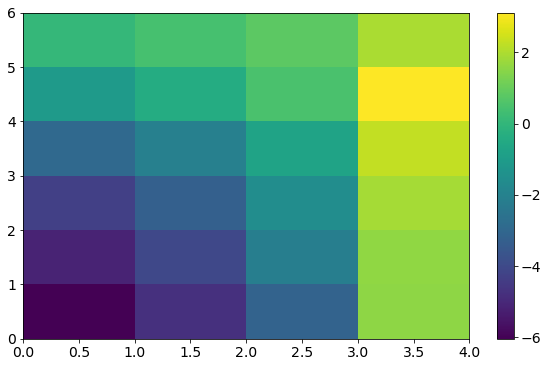

In [42]:
im=plt.pcolormesh(mean_sum_spec_env_without0-var_env_above)


plt.colorbar(im)
print()

In [43]:
mean_sum_spec_env_without0

array([[0.38494337, 1.65761406, 3.24821988, 7.97773969],
       [0.37636705, 1.50950758, 3.4014125 , 7.15898989],
       [0.3629275 , 1.40706787, 3.07209237, 6.57059241],
       [0.3301595 , 1.18203026, 2.52253352, 5.54522246],
       [0.26472685, 0.92433046, 1.81858147, 4.44832908],
       [0.13148376, 0.46924725, 0.8856989 , 2.02864271]])

In [45]:
var_env2_above

array([[1446.03962912, 1446.03962912, 1446.03962912, 1446.03962912],
       [1255.4789931 , 1255.4789931 , 1255.4789931 , 1255.4789931 ],
       [1027.13625274, 1027.13625274, 1027.13625274, 1027.13625274],
       [ 704.64401486,  704.64401486,  704.64401486,  704.64401486],
       [ 257.76175413,  257.76175413,  257.76175413,  257.76175413],
       [   3.38289519,    3.38289519,    3.38289519,    3.38289519]])

In [44]:
var_env_above

array([[6.42187206, 6.42187206, 6.42187206, 6.42187206],
       [5.55476987, 5.55476987, 5.55476987, 5.55476987],
       [4.67615213, 4.67615213, 4.67615213, 4.67615213],
       [3.26957055, 3.26957055, 3.26957055, 3.26957055],
       [1.33705633, 1.33705633, 1.33705633, 1.33705633],
       [0.06831445, 0.06831445, 0.06831445, 0.06831445]])

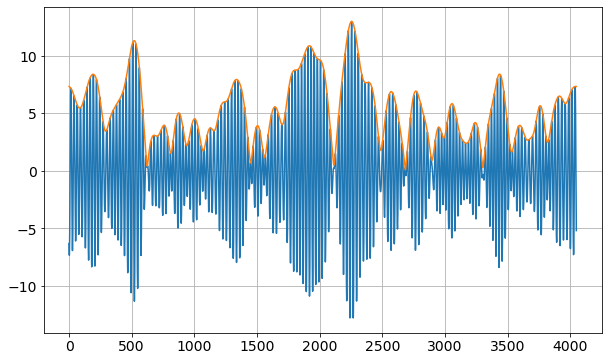

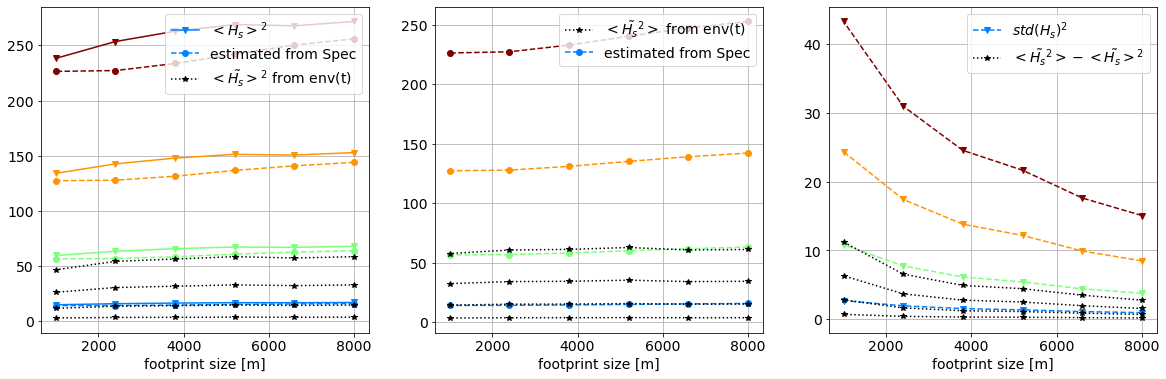

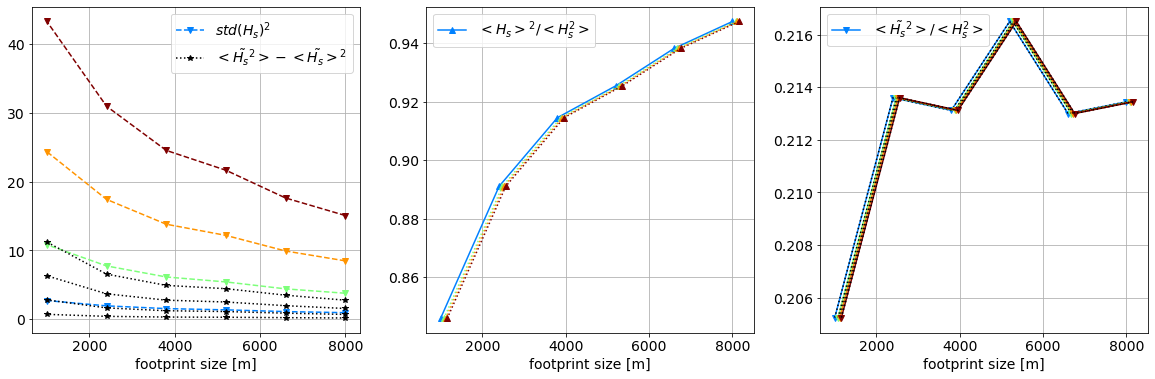

In [73]:
_=plt.figure()
_=plt.plot(S1D_r,'-')
_=plt.plot(np.sqrt(S1D_r**2+S1D_i**2),'-')
_=plt.grid(True)

# _=plt.figure()
# for ihs,Hs in enumerate(Hss):
#     if ihs==0:
#         _=plt.plot(LLs,Hs2_means[:,ihs],'^-',color=plt.cm.jet(Hs/Hss[-1]),label=r'$<H_s^2>$')
#         _=plt.plot(LLs,Hs_means_2[:,ihs],'v--',color=plt.cm.jet(Hs/Hss[-1]),label=r'$<H_s>^2$')
#         _=plt.plot(LLs,Hs2_estimated_mean[:,ihs],'*:k',label=r'$<\tilde{H_s}^2>$ from env(t)')#,color=plt.cm.jet(Hs/Hss[-1]),label=r'$<\tilde{H_s}^2>$ from env(t)')
#     else:
#         _=plt.plot(LLs,Hs2_means[:,ihs],'^-',color=plt.cm.jet(Hs/Hss[-1]))
#         _=plt.plot(LLs,Hs_means_2[:,ihs],'v--',color=plt.cm.jet(Hs/Hss[-1]))
#         _=plt.plot(LLs,Hs2_estimated_mean[:,ihs],'*:k')#,color=plt.cm.jet(Hs/Hss[-1]))
# _=plt.legend()

fig,axs=plt.subplots(1,3,figsize=(20,6))
for ihs,Hs in enumerate(Hss):
    if ihs==0:
        
        _=axs[0].plot(LLs,Hs_means_2[:,ihs],'v-',color=plt.cm.jet(Hs/Hss[-1]),label=r'$<H_s>^2$')
        _=axs[0].plot(LLs,(Hs2_estimated_env[:,ihs]),'o--',color=plt.cm.jet(Hs/Hss[-1]),label='estimated from Spec')
        _=axs[0].plot(LLs,Hs_estimated_mean[:,ihs]**2,'*:k',label=r'$<\tilde{H_s}>^2$ from env(t)',zorder=100)
#         _=axs[1].plot(LLs,Hs2_means[:,ihs],'v-',color=plt.cm.jet(Hs/Hss[-1]),label=r'$<H_s^2>$')
        _=axs[1].plot(LLs,Hs2_estimated_mean[:,ihs],'*:k',label=r'$<\tilde{H_s}^2>$ from env(t)',zorder=100)
        _=axs[1].plot(LLs,(Hs2_estimated_env2[:,ihs]),'o--',color=plt.cm.jet(Hs/Hss[-1]),label='estimated from Spec')
        _=axs[2].plot(LLs,Hs_stds_2[:,ihs],'v--',color=plt.cm.jet(Hs/Hss[-1]),label=r'$std(H_s)^2$')
        _=axs[2].plot(LLs,Hs2_estimated_mean[:,ihs]-Hs_estimated_mean[:,ihs]**2,'*:k',label=r'$<\tilde{H_s}^2>-<\tilde{H_s}>^2$')    
#         _=axs[1].plot(LLs,Hs_means_2[:,ihs]/Hs2_means[:,ihs],'^-',color=plt.cm.jet(Hs/Hss[-1]),label=r'$<H_s>^2/<H_s^2>$')
#         _=axs[2].plot(LLs,Hs2_estimated_mean[:,ihs]/Hs2_means[:,ihs],'v-',color=plt.cm.jet(Hs/Hss[-1]),label=r'$<\tilde{H_s}^2>/<H_s^2>$')
#         _=axs[2].plot(LLs,Hs2_estimated_mean[:,ihs]/Hs2_means[:,ihs],':k')
    else:
        
        _=axs[0].plot(LLs,Hs_means_2[:,ihs],'v-',color=plt.cm.jet(Hs/Hss[-1]))
        _=axs[0].plot(LLs,(Hs2_estimated_env[:,ihs]),'o--',color=plt.cm.jet(Hs/Hss[-1]))
        _=axs[0].plot(LLs,Hs_estimated_mean[:,ihs]**2,'*:k',zorder=100)
#         _=axs[1].plot(LLs,Hs2_means[:,ihs],'v-',color=plt.cm.jet(Hs/Hss[-1]))
        _=axs[1].plot(LLs,Hs2_estimated_mean[:,ihs],'*:k',zorder=100)
        _=axs[1].plot(LLs,(Hs2_estimated_env2[:,ihs]),'o--',color=plt.cm.jet(Hs/Hss[-1]))
        _=axs[2].plot(LLs,Hs_stds_2[:,ihs],'v--',color=plt.cm.jet(Hs/Hss[-1]))
        _=axs[2].plot(LLs,Hs2_estimated_mean[:,ihs]-Hs_estimated_mean[:,ihs]**2,'*:k')
#         _=axs[1].plot(LLs+Hs*10,Hs_means_2[:,ihs]/Hs2_means[:,ihs],'^:',color=plt.cm.jet(Hs/Hss[-1]))
#         _=axs[2].plot(LLs+Hs*10,Hs2_estimated_mean[:,ihs]/Hs2_means[:,ihs],'v-',color=plt.cm.jet(Hs/Hss[-1]))
#         _=axs[2].plot(LLs+Hs*10,Hs2_estimated_mean[:,ihs]/Hs2_means[:,ihs],':k')#,color=plt.cm.jet(Hs/Hss[-1]))
_=axs[0].legend()
_=axs[1].legend()
_=axs[2].legend()
_=axs[0].set_xlabel('footprint size [m]')
_=axs[1].set_xlabel('footprint size [m]')
_=axs[2].set_xlabel('footprint size [m]')

fig,axs=plt.subplots(1,3,figsize=(20,6))
for ihs,Hs in enumerate(Hss):
    if ihs==0:
        #_=axs[0].plot(LLs,Hs2_stds[:,ihs],'^-',color=plt.cm.jet(Hs/Hss[-1]),label=r'$std(H_s^2)$')
        _=axs[0].plot(LLs,Hs_stds_2[:,ihs],'v--',color=plt.cm.jet(Hs/Hss[-1]),label=r'$std(H_s)^2$')
        _=axs[0].plot(LLs,Hs2_estimated_mean[:,ihs]-Hs_estimated_mean[:,ihs]**2,'*:k',label=r'$<\tilde{H_s}^2>-<\tilde{H_s}>^2$')
#         _=axs[0].plot(LLs,Hs2_estimated_std[:,ihs],'*:k',label=r'$std(\tilde{H_s}^2)$ from env(t)')
        _=axs[1].plot(LLs,Hs_means_2[:,ihs]/Hs2_means[:,ihs],'^-',color=plt.cm.jet(Hs/Hss[-1]),label=r'$<H_s>^2/<H_s^2>$')
        _=axs[2].plot(LLs,Hs2_estimated_mean[:,ihs]/Hs2_means[:,ihs],'v-',color=plt.cm.jet(Hs/Hss[-1]),label=r'$<\tilde{H_s}^2>/<H_s^2>$')
        _=axs[2].plot(LLs,Hs2_estimated_mean[:,ihs]/Hs2_means[:,ihs],':k')
    else:
        #_=axs[0].plot(LLs,Hs2_stds[:,ihs],'^-',color=plt.cm.jet(Hs/Hss[-1]))
        _=axs[0].plot(LLs,Hs_stds_2[:,ihs],'v--',color=plt.cm.jet(Hs/Hss[-1]))
        _=axs[0].plot(LLs,Hs2_estimated_mean[:,ihs]-Hs_estimated_mean[:,ihs]**2,'*:k')
#         _=axs[0].plot(LLs,Hs2_estimated_std[:,ihs],'*:k')
        _=axs[1].plot(LLs+Hs*10,Hs_means_2[:,ihs]/Hs2_means[:,ihs],'^:',color=plt.cm.jet(Hs/Hss[-1]))
        _=axs[2].plot(LLs+Hs*10,Hs2_estimated_mean[:,ihs]/Hs2_means[:,ihs],'v-',color=plt.cm.jet(Hs/Hss[-1]))
        _=axs[2].plot(LLs+Hs*10,Hs2_estimated_mean[:,ihs]/Hs2_means[:,ihs],':k')#,color=plt.cm.jet(Hs/Hss[-1]))
_=axs[0].legend()
_=axs[1].legend()
_=axs[2].legend()
_=axs[0].set_xlabel('footprint size [m]')
_=axs[1].set_xlabel('footprint size [m]')
_=axs[2].set_xlabel('footprint size [m]')

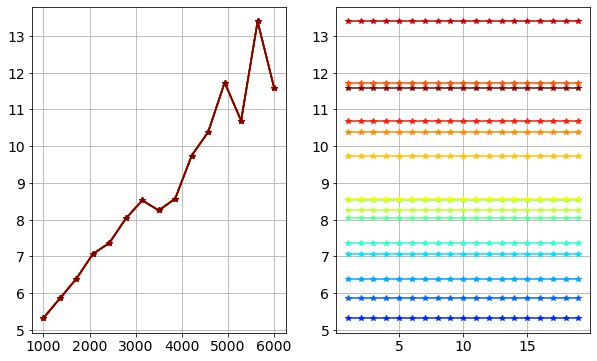

In [72]:
# A=Hs2_estimated_std/Hs2_estimated_mean
A=Hs2_stds/Hs_stds_2
fig,axs=plt.subplots(1,2)
for ihs,Hs in enumerate(Hss):
    axs[0].plot(LLs,A[:,ihs],'*-',color=plt.cm.jet(Hs/Hss[-1]))

for iLL,LL in enumerate(LLs):
    axs[1].plot(Hss,A[iLL,:],'*-',color=plt.cm.jet(LL/LLs[-1]))

Text(0, 0.5, 'slope Hs2_estimated_std/Hs_stds_2')

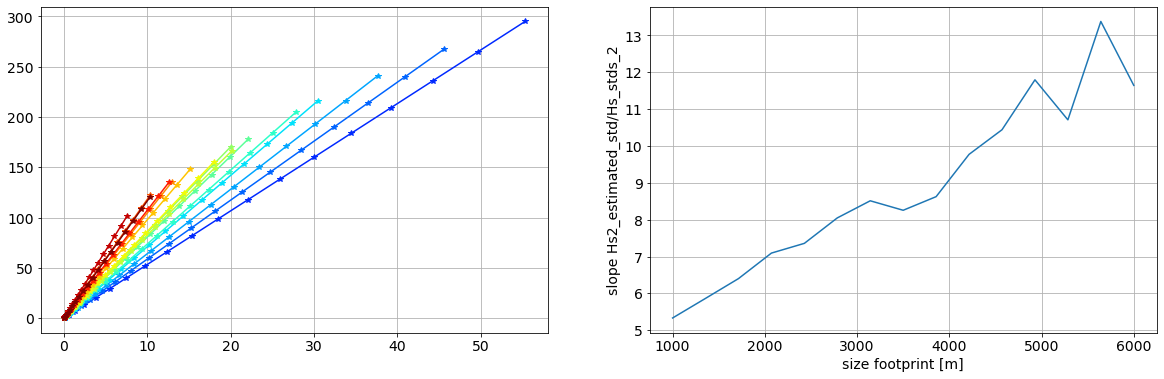

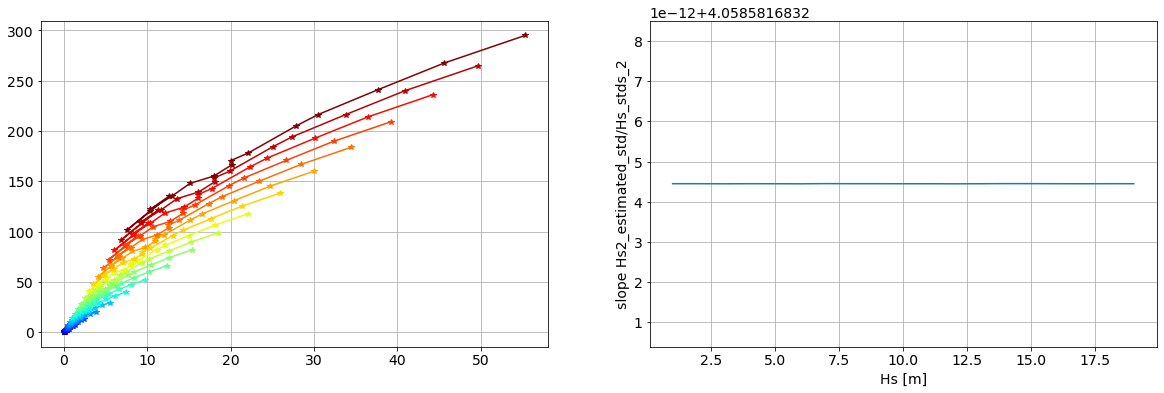

In [9]:
fig,axs=plt.subplots(1,2,figsize=(20,6))
slopell = np.zeros(nLL)
for iLL,LL in enumerate(LLs):
    axs[0].plot(Hs_stds_2[iLL,:],Hs2_estimated_std[iLL,:],'-*',color=plt.cm.jet(LL/LLs[-1]))
    res = stats.linregress(Hs_stds_2[iLL,:],Hs2_estimated_std[iLL,:])
    slopell[iLL]=res.slope
# _=plt.scatter(Hs_stds_2,Hs2_estimated_std,s=np.tile(Hss,(nLL,1))*5,c=np.tile(LLs,(1,nHs)))
# _=plt.plot(Hss,Hs_stds_2.T,'*',label='Hs std 2')
# _=plt.plot(Hss,Hs2_estimated_std.T,'-k',label='Hs2 estimated std')
# _=plt.plot(Hss,Hss*1.05,'--r',label='Hs def*1.05')

axs[1].plot(LLs,slopell)
axs[1].set_xlabel('size footprint [m]')
axs[1].set_ylabel('slope Hs2_estimated_std/Hs_stds_2')

fig,axs=plt.subplots(1,2,figsize=(20,6))
slopehs = np.zeros(nHs)
for ihs,Hs in enumerate(Hss):
    axs[0].plot(Hs_stds_2[:,ihs],Hs2_estimated_std[:,ihs],'-*',color=plt.cm.jet(Hs/Hss[-1]))
    res = stats.linregress(Hs_stds_2[:,ihs],Hs2_estimated_std[:,ihs])
    slopehs[ihs]=res.slope
#     print(res)
# _=plt.scatter(Hs_stds_2,Hs2_estimated_std,s=np.tile(Hss,(nLL,1))*5,c=np.tile(LLs,(1,nHs)))
# _=plt.plot(Hss,Hs_stds_2.T,'*',label='Hs std 2')
# _=plt.plot(Hss,Hs2_estimated_std.T,'-k',label='Hs2 estimated std')
# _=plt.plot(Hss,Hss*1.05,'--r',label='Hs def*1.05')

axs[1].plot(Hss,slopehs)
axs[1].set_xlabel('Hs [m]')
axs[1].set_ylabel('slope Hs2_estimated_std/Hs_stds_2')
# _=plt.yscale('log')
# _=plt.xscale('log')
# _=plt.legend()

ValueError: too many values to unpack (expected 4)

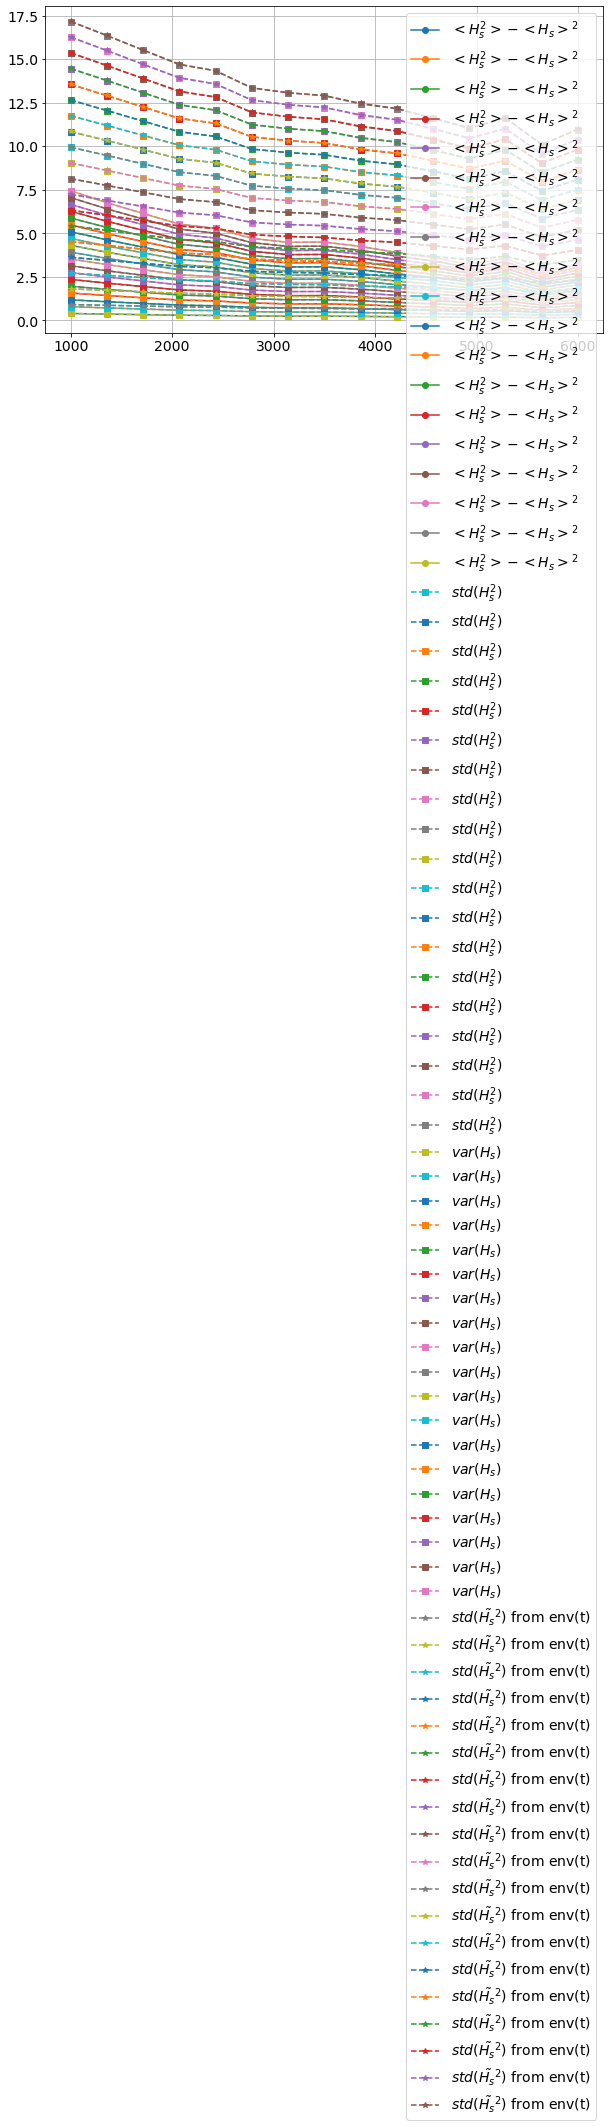

In [10]:
_=plt.figure()
_=plt.plot(LLs,np.sqrt(Hs2_means-Hs_means_2),'o-',label=r'$<H_s^2>-<H_s>^2$')
_=plt.plot(LLs,np.sqrt(Hs2_stds),'s--',label=r'$std(H_s^2)$')
_=plt.plot(LLs,np.sqrt(Hs_stds_2),'s--',label=r'$var(H_s)$')
_=plt.plot(LLs,np.sqrt(Hs2_estimated_std),'*--',label=r'$std(\tilde{H_s}^2)$ from env(t)')
_=plt.legend()

res = stats.linregress(np.sqrt(Hs_stds_2), np.sqrt(Hs2_estimated_std))
print(res)

In [21]:
strs = ['2020-01-01','2020-01-01 00:30:00','2020-01-01 01:00:00','2020-01-01 01:30:00']
import pandas as pd
d={'dates': strs, 'col0': np.arange(0,len(strs))}
A=pd.DataFrame(data=d)
# print(A)

print(A.loc[A['dates']=='2020-01-01 01:00:00'])



                 dates  col0
2  2020-01-01 01:00:00     2


In [7]:
# investigate integration over total signal #############################
isplot=0

### Get a equivalent 2D spectrum from DFT of the surface ################
# -- to verify the coefficients ------------------------------------
Z2D_from_FFT = np.abs(np.fft.fft2(S2D_r,norm='forward'))**2/(dkx*dky)

### 1D spectrum from integration over ky 
Z1D_def = (np.sum(Z2D_def,axis=0))*dky
Z1D_def_noshift=np.fft.ifftshift(Z1D_def)

### Generate a 1D surface based on 1D spectrum (1 realisation) #########
rng = np.random.default_rng(0)
rg = rng.uniform(low=0.0, high=1.0, size=(nx))
# -- from original 1D spectrum (from 2D)
zhats=np.sqrt(2*np.fft.ifftshift(Z1D_def)*dkx)*np.exp(1j*2*np.pi*rg)
S1D_r = np.real(np.fft.ifft(zhats,norm="forward"))
S1D_i = np.imag(np.fft.ifft(zhats,norm="forward"))

### Envelope squared A2D and envelope B2D ###############################################
# -- 2D env
A2D = (S2D_r**2+S2D_i**2) # S1 is real part, S2 is imaginary part
B2D = np.sqrt(A2D) 
A2D = A2D-np.mean(A2D.flatten())
B2D = B2D-np.mean(B2D.flatten())

# ---- Spectrum of A = spectrum of envelope squared from 2D Surface ---------------
Spec_env2_2D = np.abs(np.fft.fft2(A2D,norm='forward'))**2/(dky*dkx)
Spec_env1_2D = np.abs(np.fft.fft2(B2D,norm='forward'))**2/(dky*dkx)

# integration over y <=> integration over realisations 
Spec_env2_from_2D = np.sum(Spec_env2_2D,axis=0)*dky

Spec_env1_from_2D = np.sum(Spec_env1_2D,axis=0)*dky

Spec_env2_from_2D_shifted = np.fft.fftshift(Spec_env2_from_2D)
Spec_env1_from_2D_shifted = np.fft.fftshift(Spec_env1_from_2D)


# -- 1D env
A1D = (S1D_r**2+S1D_i**2) # S1 is real part, S2 is imaginary part
B1D = np.sqrt(A1D) 
A1D = A1D-np.mean(A1D.flatten())
# B1D = B1D-np.mean(B1D.flatten())

# ---- Spectrum of A = spectrum of envelope squared from 2D Surface ---------------
Spec_env2_from_1D = np.abs(np.fft.fft(A1D,norm='forward'))**2/(dkx)
Spec_env1_from_1D = np.abs(np.fft.fft(B1D-np.mean(B1D.flatten()),norm='forward'))**2/(dkx)
Spec_env1_from_1D_notnormal = np.abs(np.fft.fft(B1D,norm='forward'))**2/(dkx) 
Spec_env2_from_1D_shifted = np.fft.fftshift(Spec_env2_from_1D)
Spec_env1_from_1D_shifted = np.fft.fftshift(Spec_env1_from_1D)

Spec_env1_func = spi.interp1d(kx,Spec_env1_from_1D_shifted)
Spec_env2_func = spi.interp1d(kx,Spec_env2_from_1D_shifted)
Spec_env1_from2D_func = spi.interp1d(kx,Spec_env1_from_2D_shifted)

###  Convolution following Rice pp 131-133.
#conv_1D = np.convolve(Z1D_def_noshift,Z1D_def_noshift,'full')*dkx
#conv_1D_pm = conv_1D[nx//2:nx//2+nx]
conv_1D  = myconv(Z1D_def_noshift ,Z1D_def_noshift )*dkx

# This one is the definition we need: convolution with flipped single-sided spectrum
conv_1Da  = 4*myconv(Z1D_def_noshift ,np.flip(Z1D_def_noshift) )*dkx
# conv_1Db  = 8*myconv(Z1D_from_FFT_noshift ,Z1D_from_FFT_noshift )*dkx

conv_1D_shift  = np.fft.fftshift(conv_1D )
conv_1Da_shift = np.fft.fftshift(conv_1Da )
conv_1Da_func = spi.interp1d(kx,conv_1Da_shift)

# conv_1Db_shift = np.fft.fftshift(conv_1Db )

### Check values of Hs from spectrum #####################################
# -- original 2D spectrum
sumZ2D_def=4*np.sqrt(sum(Z2D_def.flatten()*dkx*dky))
# -- reconstructed (DFT) 2D spectrum
sumZ2D_from_FFT=4*np.sqrt(sum(Z2D_from_FFT.flatten()*dkx*dky))
# -- 1D spectrum integrated from original 2D spectrum
sumZ1D_def = 4*np.sqrt(sum(Z1D_def*dkx))


if isprints:
    ##### Prints #####################################################################
    print('---- Hs estimates from spectrum : ----------------------------------')
    print('4*sqrt(Z2D_ref*dkx*dky) = ',sumZ2D_def)
    print('4*sqrt(Z2D_from_FFT*dkx*dky) = ',sumZ2D_from_FFT)
    print('4*sqrt(Z1D_ref*dkx) = ',sumZ1D_def)

### Envelope stds #####################################
A1Dstd = np.std(A1D.flatten())
B1Dstd = np.std(B1D.flatten())
sum_conv1Da   = 4*np.sqrt(sum(conv_1Da_shift*dkx))
# sum_conv1Db   = 4*np.sqrt(sum(conv_1Db_shift*dkx))
sum_Specenv2_1Db = 4*np.sqrt(sum(Spec_env2_from_1D*dkx))
sum_Specenv1_1Db = 4*np.sqrt(sum(Spec_env1_from_1D*dkx))

estim_Hs_from_env = np.sqrt(8)*np.sqrt(np.mean(B1D.flatten())**2 + np.std(B1D.flatten())**2)#np.sum(Spec_env1_from_1D)*dkx)
estim_Hs_from_env_bis = np.sqrt(8)*np.sqrt(np.sum(Spec_env1_from_1D_notnormal)*dkx)

equiv_Hs_from_env = 2*np.sqrt(2)*(np.mean(B1D.flatten()))
if isprints:
#     print('---- Equivalent Hs from Std of "surface" : ----------------------------------')
#     print('envelope squared :   4*std(A1D) = ',4*A1Dstd)
#     print('envelope :           4*std(B1D) = ',4*B1Dstd)
#     print(' ')
    print('')
    print('---- Equivalent Hs from mean of "surface envelope" (2 * env ~ Hrms) : --------------')
    print('envelope :           4*std(B1D) = ',equiv_Hs_from_env)
    print(' ')
    print('---- Estimation of Hs from envelope : ----------------------------------')
    print('estimation :           Hs_estim = ',estim_Hs_from_env)
    print('estimation bis :       Hs_estim = ',estim_Hs_from_env_bis)
    print('ratio Hs/estimation = ',sumZ1D_def/estim_Hs_from_env)
    print(' ')
    print('Is variance = int_(R) Spec  ? ')
    print(np.std(B1D.flatten())**2, ' =?= ',np.sum(Spec_env1_from_1D_notnormal)*dkx,'     =>   NO !')
    print('Is variance = int_(R*) Spec  ? ')
    print(np.std(B1D.flatten())**2, ' =?= ',np.sum(Spec_env1_from_1D)*dkx,'     =>   YES !')
    print(' ')
    print('---- Envelope Hs from spectrum of envelope: -------------------')
    print('Envelope squared :')
    print('   estimation 1 :   4*sqrt(Spec_conv*dkx) = ',sum_conv1Da)
#     print('   estimation 2 :   4*sqrt(Spec_conv*dkx) = ',sum_conv1Db)
    print('   definition   :   4*sqrt(Spec_env2_from_2D*dkx) = ',sum_Specenv2_1Db)
    print('Envelope (definition) :')
    print('                    4*sqrt(Spec_env_from_2D*dkx) = ',sum_Specenv1_1Db)
    print('--------------------------------------------------------------')
    print('---- Estimate Hs std from surface : -------------------')    
### Estimates Hs std

mean_env = np.mean(B1D)

Lc=4000 # cut-off wavelength approximating effect of altimeter footprint
kc=2*np.pi/Lc
nLL = 15
Hs_means = np.zeros(nLL)
Hs_estimated_mean = np.zeros(nLL)
Hs_estimated_std = np.zeros(nLL)
Hs_estimated_b = np.zeros(nLL)
Hs_estimated_a = np.zeros(nLL) # local mean and local std of enveloppe

Hs_estimated_a_local = np.zeros(nLL)
Hs_estimated_a_local_std = np.zeros(nLL)
Hs_estimated_a_local_std_p = np.zeros(nLL)
Hs_estimated_a_local_std_m = np.zeros(nLL)
Hs_std_estim_a = np.zeros(nLL)
Hs_stds = np.zeros(nLL)
env_means = np.zeros(nLL)
env_std_mean = np.zeros(nLL)
env_mean_std = np.zeros(nLL)
env_stds = np.zeros(nLL)

stds_env2_def_from2D_below = np.zeros(nLL)
stds_env2_conv_below = np.zeros(nLL)
stds_env_def_from2D_below = np.zeros(nLL)

stds_env2_def_from2D_above_old = np.zeros(nLL)
stds_env2_conv_above_old = np.zeros(nLL)
stds_env_def_from2D_above_old = np.zeros(nLL)

stds_env2_def_from2D_above = np.zeros(nLL)
stds_env2_conv_above = np.zeros(nLL)
stds_env_def_from2D_above = np.zeros(nLL)


LLs=np.linspace(1000,6000,nLL)
for il,LL in enumerate(LLs):
    Nfoot = int(LL//dx)
    kc=2*np.pi/LL
#     footprints_S1D =np.zeros((Nfoot,nx-Nfoot))
#     footprints_Env=np.zeros((Nfoot,nx-Nfoot))
#     for infoot in range(nx-Nfoot):
#         footprints_S1D[:,infoot]=S1D_r[infoot:infoot+Nfoot]
#         footprints_Env[:,infoot]=B1D[infoot:infoot+Nfoot]
    footprints_S1D, Ntiles= extract_Welch_tiles_1D(S1D_r,Nfoot)
    footprints_Env, Ntiles= extract_Welch_tiles_1D(B1D,Nfoot)
    Hs_footprints_ring = 4**2*np.var(footprints_S1D,axis=1,ddof=0)
    env_means_ring = np.mean(footprints_Env,axis=1)
    env_std_ring = np.var(footprints_Env,axis=1,ddof=1)
    
    Hs_means[il] = np.mean(Hs_footprints_ring)
    
    
    env_means[il] = np.mean(env_means_ring)
    env_std_mean[il] = np.mean(env_std_ring)
    env_mean_std[il] = np.var(env_means_ring)
    env_stds[il] = np.var(env_std_ring)
    Hs_stds[il] = np.std(Hs_footprints_ring)
    
    #     Hs_estimated_b[il] = np.sqrt(8)*np.sqrt(mean_env**2+np.sum(Spec_envB_from_1D_shifted[abs(kx) < kc])*dkx)
#   old manual integration
    var_env_above_old = np.sum(Spec_env1_from_1D_shifted[abs(kx) >= kc])*dkx
    var_env2_above_old = np.sum(Spec_env2_from_1D_shifted[abs(kx) >= kc])*dkx
    var_env2_conv_above_old = np.sum(conv_1Da_shift[abs(kx) >= kc])*dkx
    # integrate correctly :
    var_env_above = spint.quad(Spec_env1_func,kc,kx.max())[0]+spint.quad(Spec_env1_func,kx.min(),-kc)[0]
    var_env2_above = spint.quad(Spec_env2_func,kc,kx.max())[0]+spint.quad(Spec_env2_func,kx.min(),-kc)[0]
    var_env2_conv_above=spint.quad(conv_1Da_func,kc,kx.max())[0]+spint.quad(conv_1Da_func,kx.min(),-kc)[0]
   
    # Hs estimated for each realisation of footprint
    Hs_estimated_footprint = np.sqrt(8)*np.sqrt(env_means_ring**2 + env_std_ring)#**2)
    Hs_estimated_mean[il] = np.mean(Hs_estimated_footprint**2) # THIS one is similar to local Hs !!!! NICELY DONE !
    Hs_estimated_std[il] = np.std(Hs_estimated_footprint**2)
    
    
    
    
    
    Nsamples = Ntiles
    # This is not really nice ...
    
    Hs_estimated_a[il] = np.sqrt(8)*np.sqrt(mean_env**2 + var_env_above)
    Hs_estimated_a_local[il] = np.sqrt(8)*np.sqrt(env_means[il]**2 + env_std_mean[il]**2)
    Hs_estimated_a_local_std[il] = np.sqrt(8)*np.sqrt(env_stds[il]**2 + var_env_above)
    
    Hs_std_estim_a[il] = np.sqrt(8)*np.sqrt(env_mean_std[il]**2+env_stds[il]**2)
    
    
    # --- computations from spectrums
#     conv_1Da_shift,Spec_env_from_2D,Spec_envB_from_2D
#     stds_env2_def_from2D_below[il] = 4*np.sqrt(var_env2_below)
#     stds_env2_conv_below[il] = 4*np.sqrt(var_env2_conv_below)
#     stds_env_def_from2D_below[il] = 4*np.sqrt(var_env_below)
    stds_env2_def_from2D_above_old[il] = 4*np.sqrt(var_env2_above_old)
    stds_env2_conv_above_old[il] = 4*np.sqrt(var_env2_conv_above_old)
    stds_env_def_from2D_above_old[il] = 4*np.sqrt(var_env_above_old)
    
    stds_env2_def_from2D_above[il] = 4*np.sqrt(var_env2_above)
    stds_env2_conv_above[il] = 4*np.sqrt(var_env2_conv_above)
    stds_env_def_from2D_above[il] = 4*np.sqrt(var_env_above)
    
#     if isprints:
#         print('---- LL = ',LL)
#         print('     Hs mean = ', Hs_mean_ring)
#         print('     Hs std = ', Hs_std_ring)

---- Hs estimates from spectrum : ----------------------------------
4*sqrt(Z2D_ref*dkx*dky) =  16.86548085423178
4*sqrt(Z2D_from_FFT*dkx*dky) =  16.86548085423167
4*sqrt(Z1D_ref*dkx) =  16.865480854231926

---- Equivalent Hs from mean of "surface envelope" (2 * env ~ Hrms) : --------------
envelope :           4*std(B1D) =  15.07811595294591
 
---- Estimation of Hs from envelope : ----------------------------------
estimation :           Hs_estim =  16.865480854231937
estimation bis :       Hs_estim =  16.86548085423193
ratio Hs/estimation =  0.9999999999999993
 
Is variance = int_(R) Spec  ? 
7.136857969247753  =?=  35.555555555557966      =>   NO !
Is variance = int_(R*) Spec  ? 
7.136857969247753  =?=  7.136857969247752      =>   YES !
 
---- Envelope Hs from spectrum of envelope: -------------------
Envelope squared :
   estimation 1 :   4*sqrt(Spec_conv*dkx) =  142.22222222223186
   definition   :   4*sqrt(Spec_env2_from_2D*dkx) =  122.9911228768155
Envelope (definition) :
      

mean envelope =  5.330919018922557
Slope between Hs_means and Hs_estimated_a =  0.0783206464078263  intersection =  -7.541767666175964


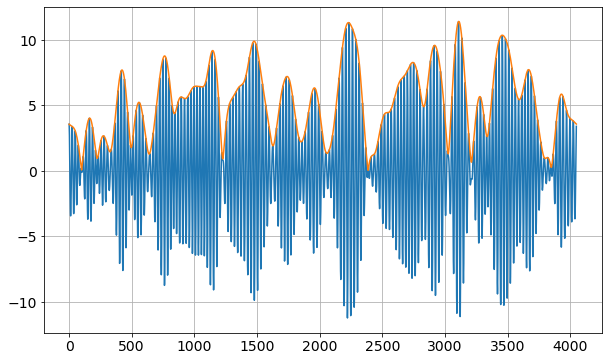

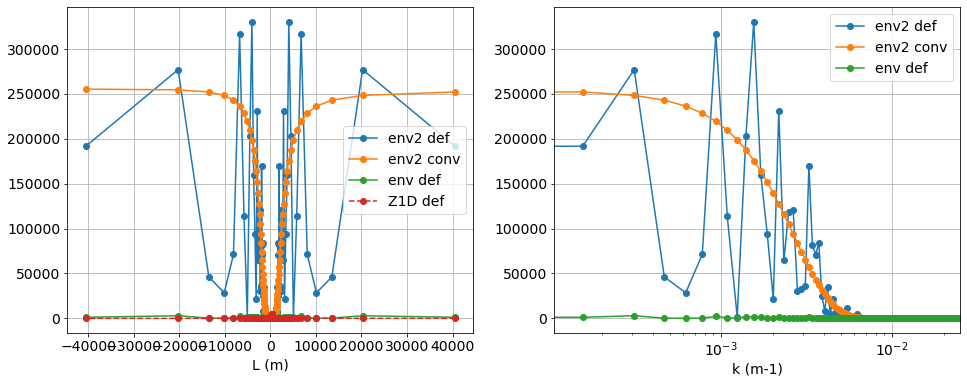

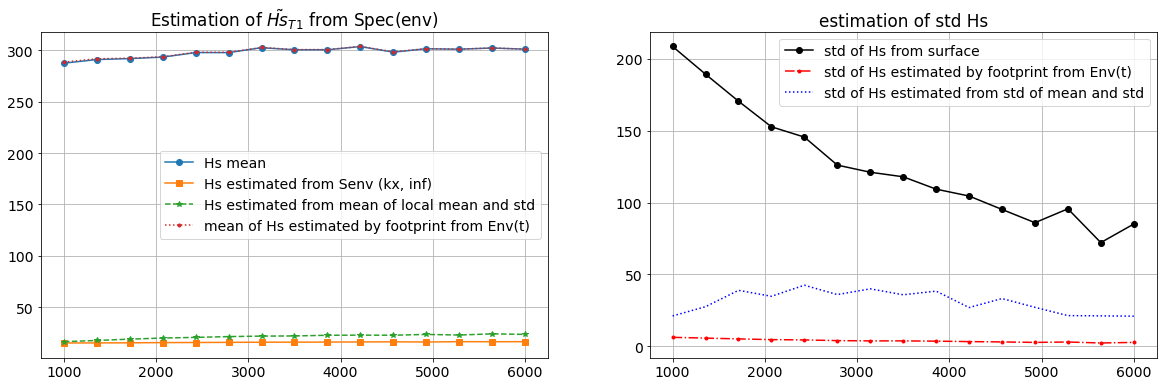

In [8]:
plt.figure()
plt.plot(S1D_r,'-')
plt.plot(np.sqrt(S1D_r**2+S1D_i**2),'-')
plt.grid(True)


fig,axs=plt.subplots(1,2,figsize=(16,6))
axs[0].plot((2*np.pi)/kx,Spec_env2_from_1D_shifted,'o-',label='env2 def')
axs[0].plot((2*np.pi)/kx,conv_1Da_shift,'o-',label='env2 conv')
axs[0].plot((2*np.pi)/kx,Spec_env1_from_1D_shifted,'o-',label='env def')
axs[0].plot((2*np.pi)/kx,Z1D_def,'o--',label='Z1D def')
axs[0].grid(True)
axs[0].set_xlabel('L (m)')
# axs[0].set_xscale('log')
axs[0].legend()

axs[1].plot(kx,Spec_env2_from_1D_shifted,'o-',label='env2 def')
axs[1].plot(kx,conv_1Da_shift,'o-',label='env2 conv')
axs[1].plot(kx,Spec_env1_from_1D_shifted,'o-',label='env def')
# axs[1].plot(kx,Z1D_def,'o--',label='Z1D def')
axs[1].grid(True)
axs[1].set_xlabel('k (m-1)')
axs[1].set_xscale('log')
axs[1].set_xlim((-0.025,0.025))
axs[1].legend()

fig,axs=plt.subplots(1,2,figsize=(20,6))
axs[0].plot(LLs,Hs_means,'o-',label='Hs mean')
# axs[0].plot(LLs,Hs_estimated_b,label='Hs estimated from Senv (0, kx)')
axs[0].plot(LLs,Hs_estimated_a,'s-',label='Hs estimated from Senv (kx, inf)')
axs[0].plot(LLs,Hs_estimated_a_local,'*--',label='Hs estimated from mean of local mean and std')
axs[0].plot(LLs,Hs_estimated_mean,'.:',label='mean of Hs estimated by footprint from Env(t)')
                                                   
# axs[0].plot(Hs_means,Hs_estimated_a,label='Hs mean vs Hs estimated from Senv (kx, inf)')
res = stats.linregress(Hs_means, Hs_estimated_a)
print('mean envelope = ',np.mean(B1D))
print('Slope between Hs_means and Hs_estimated_a = ',res.slope,' intersection = ',res.intercept)
# axs[0].plot(LLs,stds_Z1D_below,'*--',label='sqrt(int 0 kc Z1D)')
# axs[0].plot(LLs,stds_Z1D_above,'*-.',label='sqrt(int kc inf Z1D)')
axs[0].grid(True)
axs[0].set_title(r'Estimation of $\tilde{Hs}_{T1}$ from Spec(env)')
axs[0].legend()

axs[1].plot(LLs,Hs_stds,'o-k',label='std of Hs from surface')
# axs[1].plot(LLs,stds_env2_def_from2D_below,'*--r',label='int 0_kx env2 def')
# axs[1].plot(LLs,stds_env2_conv_below,'*--g',label='int 0_kx env2 conv')
# axs[1].plot(LLs,stds_env_def_from2D_below,'*--b',label='int 0_kx env def')
axs[1].plot(LLs,Hs_estimated_std,'.-.r',label='std of Hs estimated by footprint from Env(t)')
axs[1].plot(LLs,Hs_std_estim_a,':b',label='std of Hs estimated from std of mean and std')
# axs[1].plot(LLs,stds_env2_conv_above_old,'.-.g',label='old int kx_inf env2 conv')
# axs[1].plot(LLs,stds_env_def_from2D_above_old,'.:b',label='old int kx_inf env def')
# axs[1].plot(LLs,stds_env2_def_from2D_above,'.-.r',label='int kx_inf env2 def')
# axs[1].plot(LLs,stds_env2_conv_above,'.-.g',label='int kx_inf env2 conv')
# axs[1].plot(LLs,stds_env_def_from2D_above,'.:b',label='int kx_inf env def')
axs[1].grid(True)
axs[1].set_title('estimation of std Hs')
axs[1].legend()

#     print('env not squared = ',sum_SpecenvB1Db, sum_SpecenvB1Db/np.sqrt(sum_Specenv1D))
#     print('4*sqrt(conv_1Da_pm) = ',sum_conv1Da, 'this is Hs**2 / 2, for L > Lc : ',4*std_env_squared)
#     print('4*sqrt(conv_1Db_pm) = ',sum_conv1Db, 'contains harmonics')
#     print('--------------------------------------------------------------')
#     print('From the wave directional spectrum, we predict std(Hs) for L > 3km: ')
#     print(std_Hs)
### Estimates Hs STD for L > Lc 
#convc=conv_1Db_shift
#convc[abs(kx) > kc]=0  # selects wavelengths L > Lc 
#
# surface elevation variance E = a^2/2, Hs is 4 * sqrt(E)
# envelope gives a 
# envelope squared is a^2 = 2E 
# hence local Hs is 2*sqrt(2*envelope squared) or 2*sqrt(2)*envelope
#
# Now, from the PSD of the envelope the variance of the envelope over a given range 
# of wavenumber is var_env = sum(convc*dkx), giving a std of the envelope sqrt(sum(convc*dkx))

std_env_squared=np.sqrt(sum(conv_1Da_shift[abs(kx) > kc])*dkx)
std_env_approx=std_env_squared/(np.pi*sumZ2D_def/4)
std_Hs=2*np.sqrt(2)*std_env_approx

# if isprints:
#     print('--------------------------------------------------------------')
#     print('From the wave directional spectrum, we predict std(Hs) for L > 3km: ')
#     print(std_Hs)
        

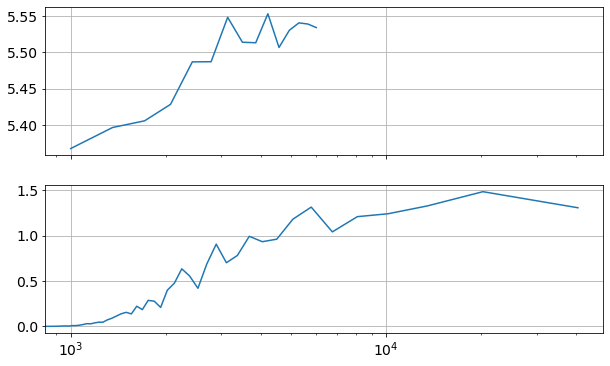

In [35]:

fig,axs=plt.subplots(2,1,sharex=True)
axs[0].plot(LLs,env_means)
axs[0].set_xscale('log')
axs[1].plot((2*np.pi)/kx,Spec_env1_from_2D_shifted/Spec_env1_from_1D_notnormal[0])


In [32]:
# investigation with a cut off
isplot=0
LM = 10000
### Get a equivalent 2D spectrum from DFT of the surface ################
# -- to verify the coefficients ------------------------------------
Z2D_from_FFT = np.abs(np.fft.fft2(S2D_r,norm='forward'))**2/(dkx*dky)

### 1D spectrum from integration over ky 
Z1D_def = (np.sum(Z2D_def,axis=0))*dky
Z1D_def_noshift=np.fft.ifftshift(Z1D_def)

### Generate a 1D surface based on 1D spectrum (1 realisation) #########
rng = np.random.default_rng(0)
rg = rng.uniform(low=0.0, high=1.0, size=(nx))
# -- from original 1D spectrum (from 2D)
zhats=np.sqrt(2*np.fft.ifftshift(Z1D_def)*dkx)*np.exp(1j*2*np.pi*rg)
S1D_r = np.real(np.fft.ifft(zhats,norm="forward"))
S1D_i = np.imag(np.fft.ifft(zhats,norm="forward"))

### Envelope squared A2D and envelope B2D ###############################################
# -- 2D env
A2D = (S2D_r**2+S2D_i**2) # S1 is real part, S2 is imaginary part
B2D = np.sqrt(A2D) 
A2D = A2D-np.mean(A2D.flatten())
B2D = B2D-np.mean(B2D.flatten())

# ---- Spectrum of A = spectrum of envelope squared from 2D Surface ---------------
Spec_env2_2D = np.abs(np.fft.fft2(A2D,norm='forward'))**2/(dky*dkx)
Spec_env1_2D = np.abs(np.fft.fft2(B2D,norm='forward'))**2/(dky*dkx)

# integration over y <=> integration over realisations 
Spec_env2_from_2D = np.sum(Spec_env2_2D,axis=0)*dky

Spec_env1_from_2D = np.sum(Spec_env1_2D,axis=0)*dky

Spec_env2_from_2D_shifted = np.fft.fftshift(Spec_env2_from_2D)
Spec_env1_from_2D_shifted = np.fft.fftshift(Spec_env1_from_2D)


# -- 1D env
A1D = (S1D_r**2+S1D_i**2) # S1 is real part, S2 is imaginary part
B1D = np.sqrt(A1D) 
A1D = A1D-np.mean(A1D.flatten())
# B1D = B1D-np.mean(B1D.flatten())

# ---- Spectrum of A = spectrum of envelope squared from 2D Surface ---------------
Spec_env2_from_1D = np.abs(np.fft.fft(A1D,norm='forward'))**2/(dkx)
Spec_env1_from_1D = np.abs(np.fft.fft(B1D-np.mean(B1D.flatten()),norm='forward'))**2/(dkx)
Spec_env1_from_1D_notnormal = np.abs(np.fft.fft(B1D,norm='forward'))**2/(dkx) 
Spec_env2_from_1D_shifted = np.fft.fftshift(Spec_env2_from_1D)
Spec_env1_from_1D_shifted = np.fft.fftshift(Spec_env1_from_1D)
###  Convolution following Rice pp 131-133.
#conv_1D = np.convolve(Z1D_def_noshift,Z1D_def_noshift,'full')*dkx
#conv_1D_pm = conv_1D[nx//2:nx//2+nx]
conv_1D  = myconv(Z1D_def_noshift ,Z1D_def_noshift )*dkx

# This one is the definition we need: convolution with flipped single-sided spectrum
conv_1Da  = 4*myconv(Z1D_def_noshift ,np.flip(Z1D_def_noshift) )*dkx
# conv_1Db  = 8*myconv(Z1D_from_FFT_noshift ,Z1D_from_FFT_noshift )*dkx

conv_1D_shift  = np.fft.fftshift(conv_1D )
conv_1Da_shift = np.fft.fftshift(conv_1Da )
# conv_1Db_shift = np.fft.fftshift(conv_1Db )

### Check values of Hs from spectrum #####################################
# -- original 2D spectrum
sumZ2D_def=4*np.sqrt(sum(Z2D_def.flatten()*dkx*dky))
# -- reconstructed (DFT) 2D spectrum
sumZ2D_from_FFT=4*np.sqrt(sum(Z2D_from_FFT.flatten()*dkx*dky))
# -- 1D spectrum integrated from original 2D spectrum
sumZ1D_def = 4*np.sqrt(sum(Z1D_def*dkx))


if isprints:
    ##### Prints #####################################################################
    print('---- Hs estimates from spectrum : ----------------------------------')
    print('4*sqrt(Z2D_ref*dkx*dky) = ',sumZ2D_def)
    print('4*sqrt(Z2D_from_FFT*dkx*dky) = ',sumZ2D_from_FFT)
    print('4*sqrt(Z1D_ref*dkx) = ',sumZ1D_def)

### Envelope stds #####################################
A1Dstd = np.std(A1D.flatten())
B1Dstd = np.std(B1D.flatten())
sum_conv1Da   = 4*np.sqrt(sum(conv_1Da_shift*dkx))
# sum_conv1Db   = 4*np.sqrt(sum(conv_1Db_shift*dkx))
sum_Specenv2_1Db = 4*np.sqrt(sum(Spec_env2_from_1D*dkx))
sum_Specenv1_1Db = 4*np.sqrt(sum(Spec_env1_from_1D*dkx))

estim_Hs_from_env = np.sqrt(8)*np.sqrt(np.mean(B1D.flatten())**2 + np.std(B1D.flatten())**2)#np.sum(Spec_env1_from_1D)*dkx)
estim_Hs_from_env_bis = np.sqrt(8)*np.sqrt(np.sum(Spec_env1_from_1D_notnormal)*dkx)

equiv_Hs_from_env = 2*np.sqrt(2)*(np.mean(B1D.flatten()))
if isprints:
#     print('---- Equivalent Hs from Std of "surface" : ----------------------------------')
#     print('envelope squared :   4*std(A1D) = ',4*A1Dstd)
#     print('envelope :           4*std(B1D) = ',4*B1Dstd)
#     print(' ')
    print('')
    print('---- Equivalent Hs from mean of "surface envelope" (2 * env ~ Hrms) : --------------')
    print('envelope :           4*std(B1D) = ',equiv_Hs_from_env)
    print(' ')
    print('---- Estimation of Hs from envelope : ----------------------------------')
    print('estimation :           Hs_estim = ',estim_Hs_from_env)
    print('estimation bis :       Hs_estim = ',estim_Hs_from_env_bis)
    print('ratio Hs/estimation = ',sumZ1D_def/estim_Hs_from_env)
    print(' ')
    print('Is variance = int_(R) Spec  ? ')
    print(np.std(B1D.flatten())**2, ' =?= ',np.sum(Spec_env1_from_1D_notnormal)*dkx,'     =>   NO !')
    print('Is variance = int_(R*) Spec  ? ')
    print(np.std(B1D.flatten())**2, ' =?= ',np.sum(Spec_env1_from_1D)*dkx,'     =>   YES !')
    print(' ')
    print('---- Envelope Hs from spectrum of envelope: -------------------')
    print('Envelope squared :')
    print('   estimation 1 :   4*sqrt(Spec_conv*dkx) = ',sum_conv1Da)
#     print('   estimation 2 :   4*sqrt(Spec_conv*dkx) = ',sum_conv1Db)
    print('   definition   :   4*sqrt(Spec_env2_from_2D*dkx) = ',sum_Specenv1Db)
    print('Envelope (definition) :')
    print('                    4*sqrt(Spec_env_from_2D*dkx) = ',sum_SpecenvB1Db)
    print('--------------------------------------------------------------')
    print('---- Estimate Hs std from surface : -------------------')    
### Estimates Hs std

mean_env = np.mean(B1D)

Lc=4000 # cut-off wavelength approximating effect of altimeter footprint
kc=2*np.pi/Lc
nLL = 15

nxtilebig = int(LM//dx) # nb pixels to have the big (scale of interest) part
extract_S1D_LM, Ntiles= extract_Welch_tiles_1D(S1D_r,nxtilebig)
extract_env1D_LM, Ntiles= extract_Welch_tiles_1D(B1D,nxtilebig)

Hs_means = np.zeros((nLL,Ntiles))
Hs_stds = np.zeros((nLL,Ntiles))

Hs_estimated_a = np.zeros(nLL)
Hs_estimated_b = np.zeros(nLL)
Hs_estimated_c = np.zeros(nLL)

LLs=np.linspace(1000,5000,nLL)
kM = 2*np.pi/LM
Ntilesfoots = np.zeros(nLL)

for index_big in range(Ntiles):
    footprints_big_S1D = extract_S1D_LM[index_big,:]
    footprints_big_Env = extract_env1D_LM[index_big,:]
    for il,LL in enumerate(LLs):
        Nxfoot = int(LL//dx) # nb pixels in footprint
        footprints_S1D_LM, Ntilesfoot = extract_Welch_tiles_1D(footprints_big_S1D,Nxfoot)
        footprints_env1D_LM, Ntilesfoot = extract_Welch_tiles_1D(footprints_big_Env,Nxfoot)
        Ntilesfoots[il]=Ntilesfoot
        if index_big==0:
            print('LL = ',LL,' ... Nb of tiles for footprint = ',Ntilesfoot)
        kc=2*np.pi/LL

        Hs_footprints_ring = 4*np.std(footprints_S1D_LM,axis=1)# vector of Hs from successive footprints
        env_means_ring = np.mean(footprints_env1D_LM,axis=1)
        
        Hs_means[il,index_big] = np.mean(Hs_footprints_ring)
        Hs_stds[il,index_big] = np.std(Hs_footprints_ring)

for il,LL in enumerate(LLs):
    kc=2*np.pi/LL
    var_env_above = np.sum(Spec_env1_from_1D_shifted[(abs(kx) >= kc)])*dkx
    var_env_below = np.sum(Spec_env1_from_1D_shifted[(abs(kx) >= kM)])*dkx
    var_env2_above = np.sum(Spec_env2_from_1D_shifted[(abs(kx) >= kc)&(abs(kx) <= kM)])*dkx
    var_env2_conv_above = np.sum(conv_1Da_shift[(abs(kx) >= kc)&(abs(kx) <= kM)])*dkx
    Hs_estimated_a[il] = ((Ntilesfoots[il]+1)/(Ntilesfoots[il]))*np.sqrt(8)*np.sqrt(mean_env**2 + var_env_above)
    Hs_estimated_b[il] = np.sqrt(8)*np.sqrt(mean_env**2 + var_env_below)
    Hs_estimated_c[il] = np.sqrt(8)*np.sqrt(mean_env**2 + var_env_above-var_env_below)
    
plt.figure()
plt.plot(S1D_r,'-')
plt.plot(np.sqrt(S1D_r**2+S1D_i**2),'-')
plt.grid(True)


fig,axs=plt.subplots(1,2,figsize=(16,6))
axs[0].plot((2*np.pi)/kx,Spec_env2_from_1D_shifted,'o-',label='env2 def')
axs[0].plot((2*np.pi)/kx,conv_1Da_shift,'o-',label='env2 conv')
axs[0].plot((2*np.pi)/kx,Spec_env1_from_1D_shifted,'o-',label='env def')
axs[0].plot((2*np.pi)/kx,Z1D_def,'o--',label='Z1D def')
axs[0].grid(True)
axs[0].set_xlabel('L (m)')
# axs[0].set_xscale('log')
axs[0].legend()

axs[1].plot(kx,Spec_env2_from_1D_shifted,'o-',label='env2 def')
axs[1].plot(kx,conv_1Da_shift,'o-',label='env2 conv')
axs[1].plot(kx,Spec_env1_from_1D_shifted,'o-',label='env def')
# axs[1].plot(kx,Z1D_def,'o--',label='Z1D def')
axs[1].grid(True)
axs[1].set_xlabel('k (m-1)')
# axs[1].set_xscale('log')
axs[1].set_xlim((-0.025,0.025))
axs[1].legend()

fig,axs=plt.subplots(1,2,figsize=(20,6))
axs[0].plot(LLs,np.mean(Hs_means,axis=1),'o-',label='Hs mean')
# axs[0].plot(LLs,Hs_estimated_b,label='Hs estimated from Senv (0, kx)')
axs[0].plot(LLs,Hs_estimated_a,'s-',label='Hs estimated from Senv (kx, inf)')
axs[0].plot(LLs,Hs_estimated_b,'s-',label='Hs estimated from Senv (0, kM)')
# axs[0].plot(LLs,Hs_estimated_a_local,'*--',label='Hs estimated from Senv (kx, inf) and local mean')
# axs[0].plot(LLs,Hs_estimated_mean,'s-',label='mean of Hs estimated by footprint from Senv (kx, inf)')
                                                   
# axs[0].plot(Hs_means,Hs_estimated_a,label='Hs mean vs Hs estimated from Senv (kx, inf)')
res = stats.linregress(np.mean(Hs_means,axis=1), Hs_estimated_a)
print('mean envelope = ',np.mean(B1D))
print('Slope between Hs_means and Hs_estimated_a = ',res.slope,' intersection = ',res.intercept)
# axs[0].plot(LLs,stds_Z1D_below,'*--',label='sqrt(int 0 kc Z1D)')
# axs[0].plot(LLs,stds_Z1D_above,'*-.',label='sqrt(int kc inf Z1D)')
axs[0].grid(True)
axs[0].set_title(r'Estimation of $\tilde{Hs}_{T1}$ from Spec(env)')
axs[0].legend()

axs[1].plot(LLs,np.mean(Hs_stds,axis=1),'o-k',label='std from surface')
axs[1].plot(LLs,Hs_estimated_b/Hs_estimated_a,'*-b',label='std from surface')
axs[1].plot(LLs,Hs_estimated_c,'*--r',label='estimated_c')
# axs[1].plot(LLs,stds_env2_def_from2D_below,'*--r',label='int 0_kx env2 def')
# axs[1].plot(LLs,stds_env2_conv_below,'*--g',label='int 0_kx env2 conv')
# axs[1].plot(LLs,stds_env_def_from2D_below,'*--b',label='int 0_kx env def')
# axs[1].plot(LLs,stds_env2_def_from2D_above,'.-.r',label='int kx_inf env2 def')
# axs[1].plot(LLs,stds_env2_conv_above,'.-.g',label='int kx_inf env2 conv')
# axs[1].plot(LLs,stds_env_def_from2D_above,'.:b',label='int kx_inf env def')
axs[1].grid(True)
axs[1].legend()

#     print('env not squared = ',sum_SpecenvB1Db, sum_SpecenvB1Db/np.sqrt(sum_Specenv1D))
#     print('4*sqrt(conv_1Da_pm) = ',sum_conv1Da, 'this is Hs**2 / 2, for L > Lc : ',4*std_env_squared)
#     print('4*sqrt(conv_1Db_pm) = ',sum_conv1Db, 'contains harmonics')
#     print('--------------------------------------------------------------')
#     print('From the wave directional spectrum, we predict std(Hs) for L > 3km: ')
#     print(std_Hs)
### Estimates Hs STD for L > Lc 
#convc=conv_1Db_shift
#convc[abs(kx) > kc]=0  # selects wavelengths L > Lc 
#
# surface elevation variance E = a^2/2, Hs is 4 * sqrt(E)
# envelope gives a 
# envelope squared is a^2 = 2E 
# hence local Hs is 2*sqrt(2*envelope squared) or 2*sqrt(2)*envelope
#
# Now, from the PSD of the envelope the variance of the envelope over a given range 
# of wavenumber is var_env = sum(convc*dkx), giving a std of the envelope sqrt(sum(convc*dkx))

std_env_squared=np.sqrt(sum(conv_1Da_shift[abs(kx) > kc])*dkx)
std_env_approx=std_env_squared/(np.pi*sumZ2D_def/4)
std_Hs=2*np.sqrt(2)*std_env_approx

# if isprints:
#     print('--------------------------------------------------------------')
#     print('From the wave directional spectrum, we predict std(Hs) for L > 3km: ')
#     print(std_Hs)
        

---- Hs estimates from spectrum : ----------------------------------
4*sqrt(Z2D_ref*dkx*dky) =  16.86548085423178
4*sqrt(Z2D_from_FFT*dkx*dky) =  16.86548085423167
4*sqrt(Z1D_ref*dkx) =  16.865480854231926

---- Equivalent Hs from mean of "surface envelope" (2 * env ~ Hrms) : --------------
envelope :           4*std(B1D) =  15.07811595294591
 
---- Estimation of Hs from envelope : ----------------------------------
estimation :           Hs_estim =  16.865480854231937
estimation bis :       Hs_estim =  16.86548085423193
ratio Hs/estimation =  0.9999999999999993
 
Is variance = int_(R) Spec  ? 
7.136857969247753  =?=  35.555555555557966      =>   NO !
Is variance = int_(R*) Spec  ? 
7.136857969247753  =?=  7.136857969247752      =>   YES !
 
---- Envelope Hs from spectrum of envelope: -------------------
Envelope squared :
   estimation 1 :   4*sqrt(Spec_conv*dkx) =  142.22222222223186


NameError: name 'sum_Specenv1Db' is not defined

In [67]:
print(kc)
print(kM)

0.0012566370614359172
0.0006283185307179586


In [ ]:
# investigation with a cut off: Welch's similar
isplot=0
LM = 10000
### Get a equivalent 2D spectrum from DFT of the surface ################
# -- to verify the coefficients ------------------------------------
Z2D_from_FFT = np.abs(np.fft.fft2(S2D_r,norm='forward'))**2/(dkx*dky)

### 1D spectrum from integration over ky 
Z1D_def = (np.sum(Z2D_def,axis=0))*dky
Z1D_def_noshift=np.fft.ifftshift(Z1D_def)

### Generate a 1D surface based on 1D spectrum (1 realisation) #########
rng = np.random.default_rng(0)
rg = rng.uniform(low=0.0, high=1.0, size=(nx))
# -- from original 1D spectrum (from 2D)
zhats=np.sqrt(2*np.fft.ifftshift(Z1D_def)*dkx)*np.exp(1j*2*np.pi*rg)
S1D_r = np.real(np.fft.ifft(zhats,norm="forward"))
S1D_i = np.imag(np.fft.ifft(zhats,norm="forward"))

### Envelope squared A2D and envelope B2D ###############################################
# -- 2D env
A2D = (S2D_r**2+S2D_i**2) # S1 is real part, S2 is imaginary part
B2D = np.sqrt(A2D) 
A2D = A2D-np.mean(A2D.flatten())
B2D = B2D-np.mean(B2D.flatten())

# ---- Spectrum of A = spectrum of envelope squared from 2D Surface ---------------
Spec_env2_2D = np.abs(np.fft.fft2(A2D,norm='forward'))**2/(dky*dkx)
Spec_env1_2D = np.abs(np.fft.fft2(B2D,norm='forward'))**2/(dky*dkx)

# integration over y <=> integration over realisations 
Spec_env2_from_2D = np.sum(Spec_env2_2D,axis=0)*dky

Spec_env1_from_2D = np.sum(Spec_env1_2D,axis=0)*dky

Spec_env2_from_2D_shifted = np.fft.fftshift(Spec_env2_from_2D)
Spec_env1_from_2D_shifted = np.fft.fftshift(Spec_env1_from_2D)


# -- 1D env
A1D = (S1D_r**2+S1D_i**2) # S1 is real part, S2 is imaginary part
B1D = np.sqrt(A1D) 
A1D = A1D-np.mean(A1D.flatten())
# B1D = B1D-np.mean(B1D.flatten())

# ---- Spectrum of A = spectrum of envelope squared from 2D Surface ---------------
Spec_env2_from_1D = np.abs(np.fft.fft(A1D,norm='forward'))**2/(dkx)
Spec_env1_from_1D = np.abs(np.fft.fft(B1D-np.mean(B1D.flatten()),norm='forward'))**2/(dkx)
Spec_env1_from_1D_notnormal = np.abs(np.fft.fft(B1D,norm='forward'))**2/(dkx) 
Spec_env2_from_1D_shifted = np.fft.fftshift(Spec_env2_from_1D)
Spec_env1_from_1D_shifted = np.fft.fftshift(Spec_env1_from_1D)
###  Convolution following Rice pp 131-133.
#conv_1D = np.convolve(Z1D_def_noshift,Z1D_def_noshift,'full')*dkx
#conv_1D_pm = conv_1D[nx//2:nx//2+nx]
conv_1D  = myconv(Z1D_def_noshift ,Z1D_def_noshift )*dkx

# This one is the definition we need: convolution with flipped single-sided spectrum
conv_1Da  = 4*myconv(Z1D_def_noshift ,np.flip(Z1D_def_noshift) )*dkx
# conv_1Db  = 8*myconv(Z1D_from_FFT_noshift ,Z1D_from_FFT_noshift )*dkx

conv_1D_shift  = np.fft.fftshift(conv_1D )
conv_1Da_shift = np.fft.fftshift(conv_1Da )
# conv_1Db_shift = np.fft.fftshift(conv_1Db )

### Check values of Hs from spectrum #####################################
# -- original 2D spectrum
sumZ2D_def=4*np.sqrt(sum(Z2D_def.flatten()*dkx*dky))
# -- reconstructed (DFT) 2D spectrum
sumZ2D_from_FFT=4*np.sqrt(sum(Z2D_from_FFT.flatten()*dkx*dky))
# -- 1D spectrum integrated from original 2D spectrum
sumZ1D_def = 4*np.sqrt(sum(Z1D_def*dkx))


if isprints:
    ##### Prints #####################################################################
    print('---- Hs estimates from spectrum : ----------------------------------')
    print('4*sqrt(Z2D_ref*dkx*dky) = ',sumZ2D_def)
    print('4*sqrt(Z2D_from_FFT*dkx*dky) = ',sumZ2D_from_FFT)
    print('4*sqrt(Z1D_ref*dkx) = ',sumZ1D_def)

### Envelope stds #####################################
A1Dstd = np.std(A1D.flatten())
B1Dstd = np.std(B1D.flatten())
sum_conv1Da   = 4*np.sqrt(sum(conv_1Da_shift*dkx))
# sum_conv1Db   = 4*np.sqrt(sum(conv_1Db_shift*dkx))
sum_Specenv2_1Db = 4*np.sqrt(sum(Spec_env2_from_1D*dkx))
sum_Specenv1_1Db = 4*np.sqrt(sum(Spec_env1_from_1D*dkx))

estim_Hs_from_env = np.sqrt(8)*np.sqrt(np.mean(B1D.flatten())**2 + np.std(B1D.flatten())**2)#np.sum(Spec_env1_from_1D)*dkx)
estim_Hs_from_env_bis = np.sqrt(8)*np.sqrt(np.sum(Spec_env1_from_1D_notnormal)*dkx)

equiv_Hs_from_env = 2*np.sqrt(2)*(np.mean(B1D.flatten()))
if isprints:
#     print('---- Equivalent Hs from Std of "surface" : ----------------------------------')
#     print('envelope squared :   4*std(A1D) = ',4*A1Dstd)
#     print('envelope :           4*std(B1D) = ',4*B1Dstd)
#     print(' ')
    print('')
    print('---- Equivalent Hs from mean of "surface envelope" (2 * env ~ Hrms) : --------------')
    print('envelope :           4*std(B1D) = ',equiv_Hs_from_env)
    print(' ')
    print('---- Estimation of Hs from envelope : ----------------------------------')
    print('estimation :           Hs_estim = ',estim_Hs_from_env)
    print('estimation bis :       Hs_estim = ',estim_Hs_from_env_bis)
    print('ratio Hs/estimation = ',sumZ1D_def/estim_Hs_from_env)
    print(' ')
    print('Is variance = int_(R) Spec  ? ')
    print(np.std(B1D.flatten())**2, ' =?= ',np.sum(Spec_env1_from_1D_notnormal)*dkx,'     =>   NO !')
    print('Is variance = int_(R*) Spec  ? ')
    print(np.std(B1D.flatten())**2, ' =?= ',np.sum(Spec_env1_from_1D)*dkx,'     =>   YES !')
    print(' ')
    print('---- Envelope Hs from spectrum of envelope: -------------------')
    print('Envelope squared :')
    print('   estimation 1 :   4*sqrt(Spec_conv*dkx) = ',sum_conv1Da)
#     print('   estimation 2 :   4*sqrt(Spec_conv*dkx) = ',sum_conv1Db)
    print('   definition   :   4*sqrt(Spec_env2_from_2D*dkx) = ',sum_Specenv1Db)
    print('Envelope (definition) :')
    print('                    4*sqrt(Spec_env_from_2D*dkx) = ',sum_SpecenvB1Db)
    print('--------------------------------------------------------------')
    print('---- Estimate Hs std from surface : -------------------')    
### Estimates Hs std

mean_env = np.mean(B1D)

Lc=4000 # cut-off wavelength approximating effect of altimeter footprint
kc=2*np.pi/Lc
nLL = 15

Nbig = int(LM//dx) # nb pixels to have the big (scale of interest) part
Hs_means = np.zeros((nLL,nx-Nbig))
Hs_estimated_mean = np.zeros(nLL)
Hs_estimated_std = np.zeros(nLL)
Hs_estimated_b = np.zeros(nLL)
Hs_estimated_a = np.zeros(nLL)
Hs_estimated_a_local = np.zeros(nLL)
Hs_estimated_a_local_std = np.zeros(nLL)
Hs_estimated_a_local_std_p = np.zeros(nLL)
Hs_estimated_a_local_std_m = np.zeros(nLL)
Hs_stds = np.zeros((nLL,nx-Nbig))
env_means = np.zeros(nLL)
env_stds = np.zeros(nLL)

stds_env2_def_from2D_below = np.zeros(nLL)
stds_env2_conv_below = np.zeros(nLL)
stds_env_def_from2D_below = np.zeros(nLL)
stds_env2_def_from2D_above = np.zeros(nLL)
stds_env2_conv_above = np.zeros(nLL)
stds_env_def_from2D_above = np.zeros(nLL)
stds_Z1D_below = np.zeros(nLL)
stds_Z1D_above = np.zeros(nLL)

LLs=np.linspace(1000,5000,nLL)
kM = 2*np.pi/LM
# footprints_big_S1D =np.zeros((Nbig,nx-Nbig))
# footprints_big_Env=np.zeros((Nbig,nx-Nbig))
for index_big in range(nx - Nbig):
    footprints_big_S1D = S1D_r[index_big:index_big + Nbig]
    footprints_big_Env = B1D[index_big:index_big + Nbig]
    for il,LL in enumerate(LLs):
        Nfoot = int(LL//dx)
        footprints_S1D = np.zeros((Nfoot,(nx-Nbig)-Nfoot))
        footprints_Env = np.zeros((Nfoot,(nx-Nbig)-Nfoot))
        kc=2*np.pi/LL
        for infoot in range((nx-Nbig)-Nfoot):
            print('total =',np.shape(footprints_big_S1D))
            print('left = ',np.shape(footprints_S1D))
            print('right =',np.shape(footprints_big_S1D[infoot:infoot+Nfoot]))
            footprints_S1D[:,infoot]=footprints_big_S1D[infoot:infoot+Nfoot]
            footprints_Env[:,infoot]=footprints_big_S1D[infoot:infoot+Nfoot]

        Hs_footprints_ring = 4*np.std(footprints_S1D,axis=0) # vector of Hs from successive footprints
        env_means_ring = np.mean(footprints_Env,axis=0)
        
        Hs_means[il,index_big] = np.mean(Hs_footprints_ring)
        Hs_stds[il,index_big] = np.std(Hs_footprints_ring)
#     env_means[il] = np.mean(env_means_ring)
#     env_stds[il] = np.std(env_means_ring)
#     Hs_stds[il] = np.std(Hs_footprints_ring)
#     stds_Z1D_below[il] = 4*np.sqrt(sum(Z1D_def[abs(kx) < kc])*dkx)
#     stds_Z1D_above[il] = 4*np.sqrt(sum(Z1D_def[abs(kx) > kc])*dkx)
#     Hs_estimated_b[il] = np.sqrt(8)*np.sqrt(mean_env**2+np.sum(Spec_envB_from_1D_shifted[abs(kx) < kc])*dkx)

for il,LL in enumerate(LLs):
    kc=2*np.pi/LL
    var_env_above = np.sum(Spec_env1_from_1D_shifted[(abs(kx) >= kc)&(abs(kx) <= kM)])*dkx
    var_env2_above = np.sum(Spec_env2_from_1D_shifted[(abs(kx) >= kc)&(abs(kx) <= kM)])*dkx
    var_env2_conv_above = np.sum(conv_1Da_shift[(abs(kx) >= kc)&(abs(kx) <= kM)])*dkx
    Hs_estimated_a[il] = np.sqrt(8)*np.sqrt(mean_env**2 + var_env_above)
    
    
#     # --- computations from spectrums
# #     conv_1Da_shift,Spec_env_from_2D,Spec_envB_from_2D
#     stds_env2_def_from2D_below[il] = 4*np.sqrt(var_env2_below)
#     stds_env2_conv_below[il] = 4*np.sqrt(var_env2_conv_below)
#     stds_env_def_from2D_below[il] = 4*np.sqrt(var_env_below)
    
#     stds_env2_def_from2D_above[il] = 4*np.sqrt(var_env2_above)
#     stds_env2_conv_above[il] = 4*np.sqrt(var_env2_conv_above)
#     stds_env_def_from2D_above[il] = 4*np.sqrt(var_env_above)
    
#     if isprints:
#         print('---- LL = ',LL)
#         print('     Hs mean = ', Hs_mean_ring)
#         print('     Hs std = ', Hs_std_ring)

plt.figure()
plt.plot(S1D_r,'-')
plt.plot(np.sqrt(S1D_r**2+S1D_i**2),'-')
plt.grid(True)


fig,axs=plt.subplots(1,2,figsize=(16,6))
axs[0].plot((2*np.pi)/kx,Spec_env2_from_1D_shifted,'o-',label='env2 def')
axs[0].plot((2*np.pi)/kx,conv_1Da_shift,'o-',label='env2 conv')
axs[0].plot((2*np.pi)/kx,Spec_env1_from_1D_shifted,'o-',label='env def')
axs[0].plot((2*np.pi)/kx,Z1D_def,'o--',label='Z1D def')
axs[0].grid(True)
axs[0].set_xlabel('L (m)')
# axs[0].set_xscale('log')
axs[0].legend()

axs[1].plot(kx,Spec_env2_from_1D_shifted,'o-',label='env2 def')
axs[1].plot(kx,conv_1Da_shift,'o-',label='env2 conv')
axs[1].plot(kx,Spec_env1_from_1D_shifted,'o-',label='env def')
# axs[1].plot(kx,Z1D_def,'o--',label='Z1D def')
axs[1].grid(True)
axs[1].set_xlabel('k (m-1)')
# axs[1].set_xscale('log')
axs[1].set_xlim((-0.025,0.025))
axs[1].legend()

fig,axs=plt.subplots(1,2,figsize=(20,6))
axs[0].plot(LLs,Hs_means,'o-',label='Hs mean')
# axs[0].plot(LLs,Hs_estimated_b,label='Hs estimated from Senv (0, kx)')
axs[0].plot(LLs,Hs_estimated_a,'s-',label='Hs estimated from Senv (kx, inf)')
# axs[0].plot(LLs,Hs_estimated_a_local,'*--',label='Hs estimated from Senv (kx, inf) and local mean')
# axs[0].plot(LLs,Hs_estimated_mean,'s-',label='mean of Hs estimated by footprint from Senv (kx, inf)')
                                                   
# axs[0].plot(Hs_means,Hs_estimated_a,label='Hs mean vs Hs estimated from Senv (kx, inf)')
res = stats.linregress(Hs_means, Hs_estimated_a)
print('mean envelope = ',np.mean(B1D))
print('Slope between Hs_means and Hs_estimated_a = ',res.slope,' intersection = ',res.intercept)
# axs[0].plot(LLs,stds_Z1D_below,'*--',label='sqrt(int 0 kc Z1D)')
# axs[0].plot(LLs,stds_Z1D_above,'*-.',label='sqrt(int kc inf Z1D)')
axs[0].grid(True)
axs[0].set_title(r'Estimation of $\tilde{Hs}_{T1}$ from Spec(env)')
axs[0].legend()

axs[1].plot(LLs,Hs_stds,'o-k',label='std from surface')
axs[1].plot(LLs,stds_env2_def_from2D_below,'*--r',label='int 0_kx env2 def')
axs[1].plot(LLs,stds_env2_conv_below,'*--g',label='int 0_kx env2 conv')
axs[1].plot(LLs,stds_env_def_from2D_below,'*--b',label='int 0_kx env def')
axs[1].plot(LLs,stds_env2_def_from2D_above,'.-.r',label='int kx_inf env2 def')
axs[1].plot(LLs,stds_env2_conv_above,'.-.g',label='int kx_inf env2 conv')
axs[1].plot(LLs,stds_env_def_from2D_above,'.:b',label='int kx_inf env def')
axs[1].grid(True)
axs[1].legend()

#     print('env not squared = ',sum_SpecenvB1Db, sum_SpecenvB1Db/np.sqrt(sum_Specenv1D))
#     print('4*sqrt(conv_1Da_pm) = ',sum_conv1Da, 'this is Hs**2 / 2, for L > Lc : ',4*std_env_squared)
#     print('4*sqrt(conv_1Db_pm) = ',sum_conv1Db, 'contains harmonics')
#     print('--------------------------------------------------------------')
#     print('From the wave directional spectrum, we predict std(Hs) for L > 3km: ')
#     print(std_Hs)
### Estimates Hs STD for L > Lc 
#convc=conv_1Db_shift
#convc[abs(kx) > kc]=0  # selects wavelengths L > Lc 
#
# surface elevation variance E = a^2/2, Hs is 4 * sqrt(E)
# envelope gives a 
# envelope squared is a^2 = 2E 
# hence local Hs is 2*sqrt(2*envelope squared) or 2*sqrt(2)*envelope
#
# Now, from the PSD of the envelope the variance of the envelope over a given range 
# of wavenumber is var_env = sum(convc*dkx), giving a std of the envelope sqrt(sum(convc*dkx))

std_env_squared=np.sqrt(sum(conv_1Da_shift[abs(kx) > kc])*dkx)
std_env_approx=std_env_squared/(np.pi*sumZ2D_def/4)
std_Hs=2*np.sqrt(2)*std_env_approx

# if isprints:
#     print('--------------------------------------------------------------')
#     print('From the wave directional spectrum, we predict std(Hs) for L > 3km: ')
#     print(std_Hs)
        

In [ ]:
# breakpoint

In [8]:
print('mean envelope = ',np.mean(B1D))
print('equiv mean from spectrum = ',np.sqrt(Spec_envB_from_1D_shifted[nx//2]*dkx))
print('sqrt(Hs) = ',np.sqrt(Hs))

mean envelope =  1.966553747535086
equiv mean from spectrum =  1.966553747535086
sqrt(Hs) =  2.449489742783178


In [10]:
kx[nx//2]#:nx//2+3]

0.0

---- Hs estimates : ----------------------------------
4*sqrt(Z2D_ref*dkx*dky) =  13.99999999999972
4*sqrt(Z1D_ref*dkx) =  13.99999999999972

---- Envelope squared std : ----------------------------------
4*std(A2D),4*std(A1D) =  94.2062273228768 76.28638280739892
---- Envelope std (pi*Hs/4 times smaller): -------------------
4*std(B2D),4*std(B1D) =  9.072735367753998 7.423763830621054 4*A2Dstd/(pi*Hs/4) 8.567649570557093
4*sqrt(Specenv1D*dkx) =  124.19183629303599
4*sqrt(Specenv1Db*dkx) =  94.20622732287679
env not squared =  19.79898987322293 1.7766280279286604
4*sqrt(conv_1Da_pm) =  97.9999999999961 this is Hs**2 / 2, for L > Lc :  76.37132062392489
4*sqrt(conv_1Db_pm) =  138.59292911255787 contains harmonics
--------------------------------------------------------------
From the wave directional spectrum, we predict std(Hs) for L > 3km: 
4.911310431727618


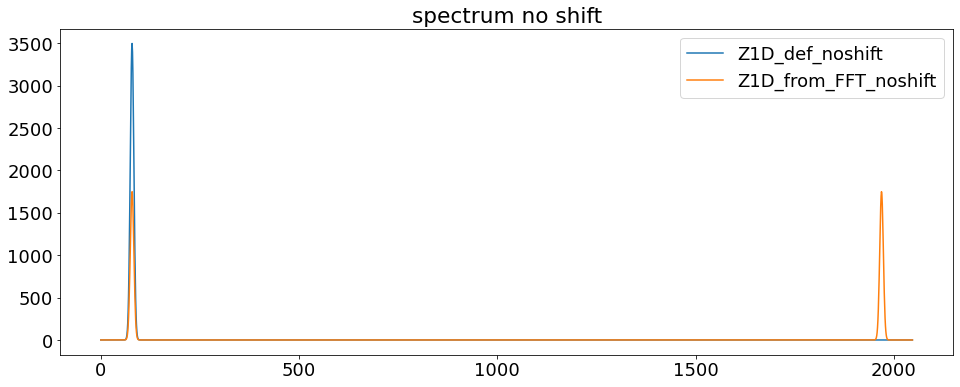

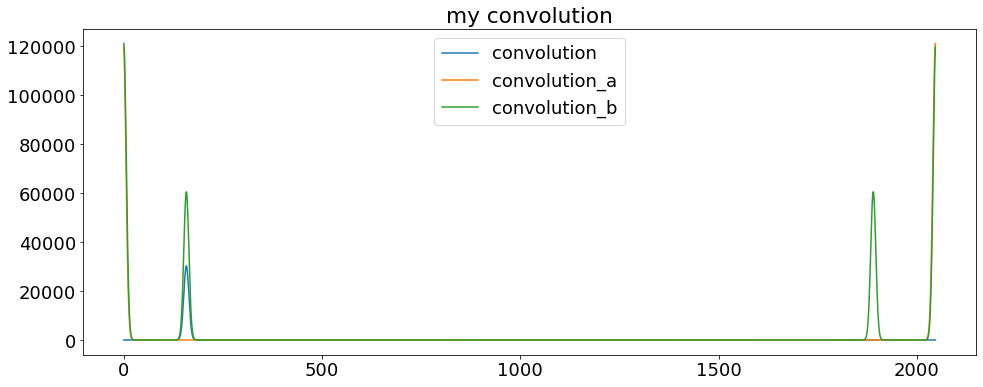

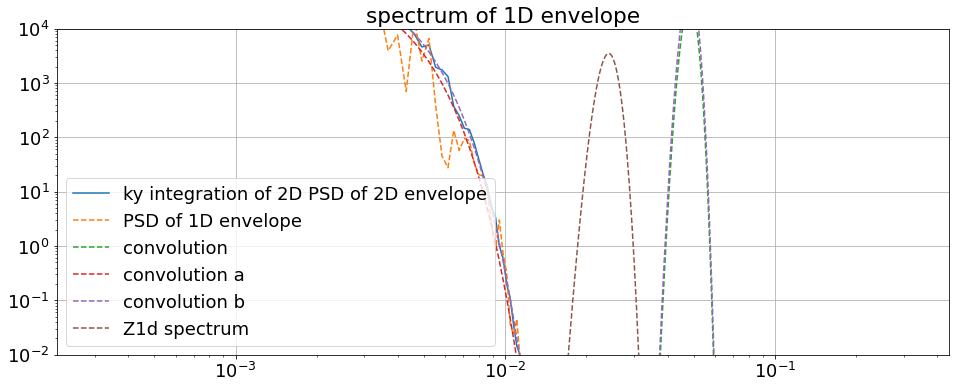

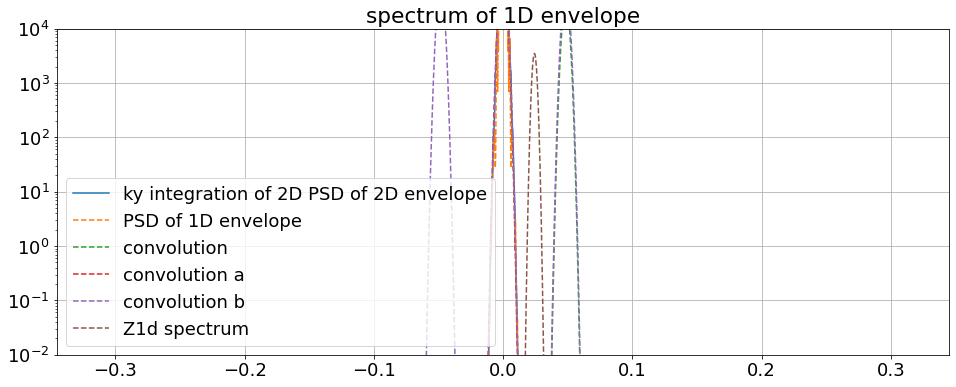

In [7]:
### Get a equivalent 2D spectrum from DFT of the surface ################
# -- to verify the coefficients ------------------------------------
Z2D_from_FFT = np.abs(np.fft.fft2(S2D_r,norm='forward'))**2/(dkx*dky)

### 1D spectrum from integration over ky 
Z1D_def = (np.sum(Z2D_def*dky,axis=0))
Z1D_def_noshift=np.fft.ifftshift(Z1D_def)

# -- reconstructed (DFT) 2D spectrum
Z1D_from_FFT_noshift = np.sum(Z2D_from_FFT*dky,axis=0) 
Z1D_from_FFT = np.fft.fftshift(np.sum(Z2D_from_FFT*dky,axis=0)) # fftshift to have the values from -k_lim to k_lim
# set the spectrum only to positive part (equiv to Z2_def) => easier to generate surface
Z1D_from_FFT[0:nx//2]=0
Z1D_from_FFT[nx//2:]=2*Z1D_from_FFT[nx//2:] 

### Generate a 1D surface based on 1D spectrum (1 realisation) #########
rng = np.random.default_rng(0)
rg = rng.uniform(low=0.0, high=1.0, size=(nx))
# -- from original 1D spectrum (from 2D)
zhats=np.sqrt(2*np.fft.ifftshift(Z1D_def)*dkx)*np.exp(1j*2*np.pi*rg)
S1D_def_r = np.real(np.fft.ifft(zhats,norm="forward"))
# -- from 2D spectrum from 2D FFT spectrum
zhats=np.sqrt(2*np.fft.ifftshift(Z1D_from_FFT)*dkx)*np.exp(1j*2*np.pi*rg)
S1D_from_FFT = (np.fft.ifft(zhats,norm="forward"))

### Generate associated spectrum to S1D ################################
Z1D_from_S1D_complex = np.fft.fftshift(np.fft.fft(S1D_from_FFT.real,norm="forward")) # Z33
Z1D_from_S1D = np.sqrt(np.abs(Z1D_from_S1D_complex)**2)

### Envelope squared and envelope ###############################################
# -- 2D env
A2D = (S2D_r**2+S2D_i**2) # S1 is real part, S2 is imaginary part
B2D = np.sqrt(A2D) 

# ---- Spectrum of A = spectrum of envelope squared from 2D Surface ---------------
Spec_env2_2D = np.abs(np.fft.fft2(A2D-np.mean(A2D.flatten()),norm='forward'))**2/(dky*dkx)
Spec_env1_2D = np.abs(np.fft.fft2(B2D,norm='forward'))**2/(dky*dkx)

# integration over y <=> integration over realisations 
Spec_env2_from_2D = np.sum(Spec_env2_2D,axis=0)*dky

Spec_env1_from_2D = np.sum(Spec_env1_2D,axis=0)*dky

Spec_env2_from_2D_shifted = np.fft.fftshift(Spec_env2_from_2D)

A1D = S1D_from_FFT.real**2+S1D_from_FFT.imag**2
B1D = np.sqrt(A1D)



# ---- Spectrum of B = spectrum of enveloppe from 1D Surface ---------------
# warning, this is a double-sided spectrum
Spec_env_1D = np.abs(np.fft.fft(A1D,norm='forward'))**2/dkx
Spec_env_1D_shifted = np.fft.fftshift(Spec_env_1D)


###  Convolution following Rice pp 131-133.
#conv_1D = np.convolve(Z1D_def_noshift,Z1D_def_noshift,'full')*dkx
#conv_1D_pm = conv_1D[nx//2:nx//2+nx]
conv_1D  = myconv(Z1D_def_noshift ,Z1D_def_noshift )*dkx

# This one is the definition we need: convolution with flipped single-sided spectrum
conv_1Da  = 4*myconv(Z1D_def_noshift ,np.flip(Z1D_def_noshift) )*dkx
conv_1Db  = 8*myconv(Z1D_from_FFT_noshift ,Z1D_from_FFT_noshift )*dkx


conv_1D_shift  = np.fft.fftshift(conv_1D )
conv_1Da_shift = np.fft.fftshift(conv_1Da )
conv_1Db_shift = np.fft.fftshift(conv_1Db )


### Check values of Hs from spectrum #####################################
# -- original 2D spectrum
sumZ2D_def=4*np.sqrt(sum(Z2D_def.flatten()*dkx*dky))
# -- reconstructed (DFT) 2D spectrum
sumZ2D_from_FFT=4*np.sqrt(sum(Z2D_from_FFT.flatten()*dkx*dky))
# -- 1D spectrum integrated from original 2D spectrum
sumZ1D_def = 4*np.sqrt(sum(Z1D_def*dkx))
# -- 1D spectrum integrated from reconstructed (DFT) 2D spectrum
sumZ1D_from_FFT = 4*np.sqrt(sum(Z1D_from_FFT*dkx))
# -- 1D spectrum calculated from 1D surface (from FFT)
sumZ1D_from_S1D = 4*np.sqrt(sum(Z1D_from_S1D**2))

### Envelope stds #####################################
A1Dstd=np.std(A1D.flatten())
A2Dstd=np.std(A2D.flatten())
B1Dstd=np.std(B1D.flatten())
B2Dstd=np.std(B2D.flatten())
sum_Specenv1D =4*np.sqrt(sum(Spec_env_1D*dkx))
sum_conv1Da   =4*np.sqrt(sum(conv_1Da_shift*dkx))
sum_Specenv2_1Db=4*np.sqrt(sum(Spec_env2_from_2D*dkx))
sum_Specenv1_1Db=4*np.sqrt(sum(Spec_env1_from_2D*dkx))
sum_conv1Db   =4*np.sqrt(sum(conv_1Db_shift*dkx))

### Estimates Hs STD for L > Lc 
#convc=conv_1Db_shift
#convc[abs(kx) > kc]=0  # selects wavelengths L > Lc 
#
# surface elevation variance E = a^2/2, Hs is 4 * sqrt(E)
# envelope gives a 
# envelope squared is a^2 = 2E 
# hence local Hs is 2*sqrt(2*envelope squared) or 2*sqrt(2)*envelope
#
# Now, from the PSD of the envelope the variance of the envelope over a given range 
# of wavenumber is var_env = sum(convc*dkx), giving a std of the envelope sqrt(sum(convc*dkx))

std_env_squared=np.sqrt(sum(conv_1Db_shift[abs(kx) < kc])*dkx)
std_env_approx=std_env_squared/(np.pi*sumZ2D_def/4)
std_Hs=2*np.sqrt(2)*std_env_approx


k1 = np.argmin(np.abs(kx-(-0.03)))
k2 = np.argmin(np.abs(kx-0.03))
if isplot:
    ##### spectrum  ######
    fig,axs=plt.subplots(1,1,figsize=(16,6))
    plt.plot(Z1D_def_noshift ,label='Z1D_def_noshift')
    plt.plot(Z1D_from_FFT_noshift ,label='Z1D_from_FFT_noshift')
    plt.legend()
    _=axs.set_title('spectrum no shift')

    ##### convolution  ######
    fig,axs=plt.subplots(1,1,figsize=(16,6))
    plt.plot(conv_1D,label='convolution')
    plt.plot(conv_1Da,label='convolution_a')
    plt.plot(conv_1Db,label='convolution_b')
    plt.legend()
    _=axs.set_title('my convolution')

    ##### spectrum of enveloppe from 2D and  1D log scale  ######
    fig,axs=plt.subplots(1,1,figsize=(16,6))
    plt.plot(kx,Spec_env2_from_2D_shifted,label='ky integration of 2D PSD of 2D envelope')
    plt.plot(kx,Spec_env_1D_shifted,'--',label='PSD of 1D envelope')
    plt.plot(kx,conv_1D_shift,'--',label='convolution')
    plt.plot(kx,conv_1Da_shift,'--',label='convolution a')
    plt.plot(kx,conv_1Db_shift,'--',label='convolution b')
    plt.plot(kx,Z1D_def,'--',label='Z1d spectrum')
    _=axs.set_title('spectrum of 1D envelope')
    plt.grid(True)
    _=plt.ylim(10**-2,10**4)
    # plt.xlim((-0.1,0.1))
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()

            ##### spectrum of enveloppe from 2D and  1D  ######
    fig,axs=plt.subplots(1,1,figsize=(16,6))
    plt.plot(kx,Spec_env2_from_2D_shifted,label='ky integration of 2D PSD of 2D envelope')
    plt.plot(kx,Spec_env_1D_shifted,'--',label='PSD of 1D envelope')
    plt.plot(kx,conv_1D_shift,'--',label='convolution')
    plt.plot(kx,conv_1Da_shift,'--',label='convolution a')
    plt.plot(kx,conv_1Db_shift,'--',label='convolution b')
    plt.plot(kx,Z1D_def,'--',label='Z1d spectrum')
    _=axs.set_title('spectrum of 1D envelope')
    plt.grid(True)
    _=plt.ylim(10**-2,10**4)
    # plt.xlim((-0.1,0.1))
    plt.yscale('log')
    plt.legend()



if isprints:
    ##### Prints #####################################################################
    print('---- Hs estimates : ----------------------------------')
    print('4*sqrt(Z2D_ref*dkx*dky) = ',sumZ2D_def)
    print('4*sqrt(Z1D_ref*dkx) = ',sumZ1D_def)
    print('')
    print('---- Envelope squared std : ----------------------------------')
    print('4*std(A2D),4*std(A1D) = ',4*A2Dstd,4*A1Dstd)
    print('---- Envelope std (pi*Hs/4 times smaller): -------------------')
    print('4*std(B2D),4*std(B1D) = ',4*B2Dstd,4*B1Dstd,'4*A2Dstd/(pi*Hs/4)',4*A2Dstd/(np.pi*sumZ2D_def/4))
    print('4*sqrt(Specenv1D*dkx) = ',sum_Specenv1D)
    print('4*sqrt(Specenv1Db*dkx) = ',sum_Specenv1Db)
    print('env not squared = ',sum_SpecenvB1Db, sum_SpecenvB1Db/np.sqrt(sum_Specenv1D))
    print('4*sqrt(conv_1Da_pm) = ',sum_conv1Da, 'this is Hs**2 / 2, for L > Lc : ',4*std_env_squared)
    print('4*sqrt(conv_1Db_pm) = ',sum_conv1Db, 'contains harmonics')
    print('--------------------------------------------------------------')
    print('From the wave directional spectrum, we predict std(Hs) for L > 3km: ')
    print(std_Hs)

        

In [8]:
freq_satsampl=40 # freq for waveforms
v_sat=7000 # satellite velocity in m/s
alti_sat=519000 # altitude of satellite CFOSAT
# WARNING: the following 4 parameters should probably be adjusted as a function of the wave height ... 
radi = 4000     # radius used to compute waveform
radi1 = 900     # inner radius for Hs average
radi2 = 1200    # outer radius for Hs average
range_shift = 10 # shift of the waveforms from the "epoch" in meters

isplot_steps=0
# --- edges for range windows ------------
dr = 0.4
edges_max = 20

nHs=251
Hs_max = 25

wfm_ref, Hsm_ref, edges_ref = generate_wvform_database(dr,nHs,edges_max=edges_max,Hs_max=Hs_max,offset=range_shift)

nxa=np.floor(radi/dx).astype(int) # size of radius of footprint in pixel
di=np.floor((v_sat/freq_satsampl)/dx).astype(int) # distance between footprint centers, in pixels (v_sat/freq_satsampl = dsitance in m)
nsamp=np.floor((nx-2*nxa)/di).astype(int) # Nb of samples

Hs_std,Hs_stdbis,Hs_std2,Hs_retrack,Xalt,waveforms,surf1,footprint1 = fly_over_track_v0(X,Y,S2D_r,nsamp,nxa,di,wfm_ref,Hsm_ref,edges_ref,radi,radi1,radi2,alti_sat,range_shift)


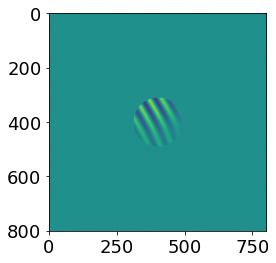

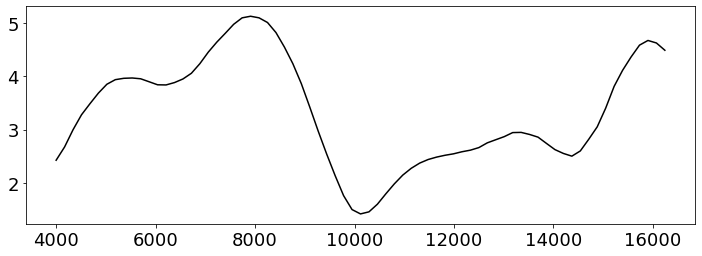

In [9]:
plt.imshow(np.flipud(surf1),vmin=-4, vmax=4)

fig,ax=plt.subplots(figsize=(12,4))
plt.plot(Xalt,Hs_std,color='k',label='python')


In [10]:
surf2 = np.nan*np.ones(surf1.shape)
surf2[footprint1>0]=surf1[footprint1>0]

Hs_std1 = 4*np.std(surf1)/np.sqrt(np.mean(footprint1))
Hs_std12 = 4*np.nanstd(surf2)#/np.sqrt(np.mean(footprint1))
print('Hs std1 = ',Hs_std1,' - Hs std2 = ',Hs_std12)

Hs std1 =  4.489025472155908  - Hs std2 =  4.48901516593509


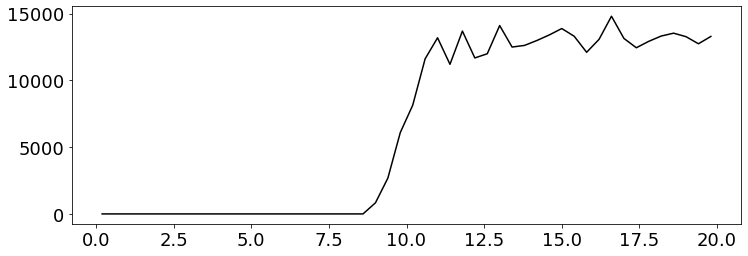

In [11]:

fig,ax=plt.subplots(figsize=(12,4))
plt.plot(edges_ref[0:-1]+dr/2,waveforms[0,:],color='k',label='python')


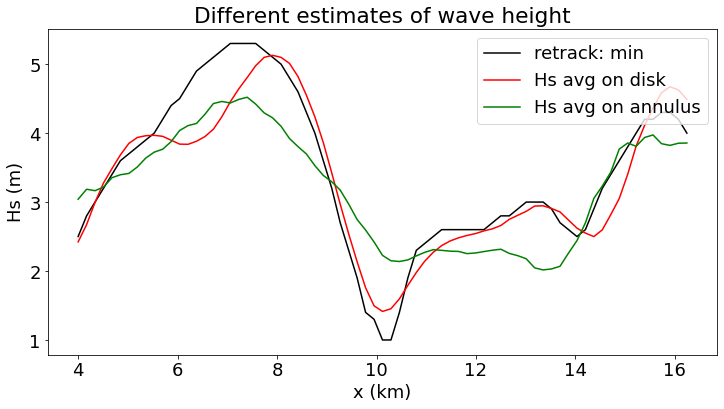

In [12]:
fig,ax=plt.subplots(figsize=(12,6))
line1=plt.plot(Xalt*0.001, Hs_retrack, color='k',label='retrack: min')
line2=plt.plot(Xalt*0.001, Hs_std, color='r',label='Hs avg on disk')
line3=plt.plot(Xalt*0.001, Hs_std2, color='g',label='Hs avg on annulus')
plt.grid
plt.xlabel('x (km)')
plt.ylabel('Hs (m)')
plt.title('Different estimates of wave height')
leg = plt.legend(loc='upper right')
plt.show()

int |cos(x)| =  0.6373475821202027
int |sin(x)| =  0.635344434229173
int cos(x)**2 =  0.501
int sin(x)**2 =  0.499
int cos(x)**2+sin(x)**2 =  1.0
int sqrt(cos(x)**2+sin(x)**2) =  1.0
1.2721508625153746
1.4142135623730951
1.5707963267948966
1.2533141373155001
1.2599210498948732
1.7724538509055159
1.4645918875615231


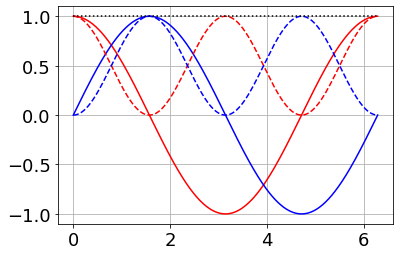

In [20]:
x=np.linspace(0,2*np.pi,500)

y1 = np.cos(x)
y2 = np.sin(x)
plt.plot(x,y1,'-r')
plt.plot(x,y2,'-b')
plt.grid(True)

plt.plot(x,y1**2,'--r')
plt.plot(x,y2**2,'--b')
plt.plot(x,np.sqrt(y1**2+y2**2),':k')

print('int |cos(x)| = ',np.mean(np.abs(y1)))
print('int |sin(x)| = ',np.mean(np.abs(y2)))

print('int cos(x)**2 = ',np.mean(y1**2))
print('int sin(x)**2 = ',np.mean(y2**2))
print('int cos(x)**2+sin(x)**2 = ',np.mean(y1**2+y2**2))
print('int sqrt(cos(x)**2+sin(x)**2) = ',np.mean(np.sqrt(y1**2+y2**2)))
print(np.mean(np.abs(y1))/np.mean(y1**2))


In [119]:
print(nx)

4048
